# COGS 108 Final Project
# Exercise vs. Food Environment – Obesity Classification

## Authors
Bryant Lin, Swarnakshi Kapil, Hendrik Hannes Holste

PIDs (not in order):
- A99044591
- A09404900
- A91052353

6/12/2017

## Introduction and Background

Sugared beverages, french fries and hamburgers: beloved staples of Western diets yet insidious threats to long-term health. Obesity in the United States is an epidemic, yet many dismiss it as a problem caused by unfavorable genetics or lack of willpower [1].

In particular, the idea has gained traction that lack of desire to exercise is the root cause behind obesity, culminating in political programs encouraging exercise as a remedy, such as Michelle Obama’s “Just Move” [3]. A lot of research exists exploring the link between lifestyle and obesity, though in many epidemiological studies, proxy features such as "caloric intake in kcal" are used [2].

Yet such calorie and exercise-focused models may not adequately consider how food environments shape behavior as root causes. To what extent do socio-economic context and food behaviors (e.g. income level and frequency of consuming sugared soda) predict obesity? Investigating this question may reveal that food environments and dieting behaviors serve as better predictors of obesity than exercise-related features.

**Our Null Hypothesis is: exercise and dieting equally strongly contribute to a person's BMI.**

References:
- [1] D. Elsweiler, M. Harvey, Towards Automatic Meal Plan Recommendations for Balanced Nutrition. Vienna, Austria: ACM, 2015 (http://dl.acm.org/citation.cfm?id=2799665)
- [2] https://med.stanford.edu/news/all-news/2014/07/lack-of-exercise--not-diet--linked-to-rise-in-obesity--stanford-.html
- [3] http://www.modernhealthcare.com/article/20160823/NEWS/160829986

## Data Description

We are using the following dataset:

- American Time Use Survey (ATUS) Eating & Health Module Files from 2014-2015
https://www.atusdata.org
    - Survey responses of eating, and exercising habits given by participants. Core features location, household income, age, ethnicity, weight, height, BMI and general health status. Features also include location where majority of grocery is purchased, frequency of exercise, and dieting features. 
    - 74,007 observations
    - 52 raw features

In [3]:
import pandas as pd
import numpy as np
import simplejson as json
import matplotlib.pyplot as plt
import matplotlib as mlt
import seaborn as sns
import scipy

import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing, linear_model
from sklearn.metrics import mean_squared_error
import patsy
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import scipy as sp, scipy
from sklearn import linear_model
import seaborn as sns; sns.set(color_codes=True)
from scipy.stats import ttest_ind, ttest_rel


In [4]:
%matplotlib inline
% config InlineBackend.figure_format = 'retina'
% matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

## Data Cleaning / Pre-processing

In [5]:
df_atus = pd.read_csv('../data/atus_00004.csv', dtype={'COUNTY': str})

# Drop NaN rows
df_atus.dropna(inplace=True)

# Drop rows with invalid BMI values
df_atus = df_atus[df_atus['BMI'] < 998]

# Feature columns in df_atus
FEATURE_COLS = ['HH_SIZE', 'FAMINCOME', 'POVERTY130', 'POVERTY185',
       'POVERTYLEVEL', 'FOODSTAMP', 'WIC', 'HHTENURE', 'HH_CHILD', 'HOUSETYPE',
       'HH_NUMKIDS', 'HH_SIZE_CPS8', 'HH_CHILD_CPS8', 'QFAMINCOME', 'PERNUM',
       'LINENO', 'WT06', 'AGE', 'SEX', 'RACE', 'MARST', 'GENHEALTH', 'HEIGHT',
       'WEIGHT', 'BMI', 'EH_RESP', 'PED', 'SED_EAT', 'FOODSHOP', 'MEALPREP',
       'SODA', 'DIETSODA', 'MILK', 'MEAT', 'STORE', 'STREASON', 'EXERCISE',
       'EXFREQ', 'FASTFD', 'FASTFDFREQ', 'FDTHERM', 'ENOUGHFD', 'ANYSECDRK',
       'ANYSECEAT']
CONTINUOUS_FEATURES = ['HH_SIZE', 'HH_NUMKIDS', 'HH_CHILD',
                       'WT06', 'AGE',
                      'PED', 'SED_EAT', 'EXFREQ']
# cannot include weight and height because these are directly associated with
# BMI
EXCLUDED_CONTINUOUS_FEATURES = ['HEIGHT', 'WEIGHT']
CATEGORICAL_FEATURES = ['FAMINCOME', 'POVERTY130', 'POVERTY185',
                       'POVERTYLEVEL', 'FOODSTAMP', 'WIC',
                       'HHTENURE', 'HOUSETYPE', 'QFAMINCOME',
                       'GENHEALTH', 'SEX', 'RACE', 'MARST',
                       'EH_RESP', 'FOODSHOP', 'MEALPREP',
                       'SODA', 'DIETSODA', 'MILK', 'MEAT', 'STORE', 
                        'STREASON', 'EXERCISE',
                       'FASTFD', 'FDTHERM', 'ENOUGHFD', 'ANYSECDRK',
                       'ANYSECEAT']

FOOD_EXERCISE_FEATURES = (['SODA','MILK','MEAT','EXERCISE', 'FOODSHOP','MEALPREP','DIETSODA', 'AGE', 'PED', 'SED_EAT', 'EXFREQ', 'FASTFDFREQ'])

Note: the original A4 write-up differs from this data cleaning in that we did not include our geolocation/zipcode resolution code. During testing we determined that the data was too sparse to use; if we wanted to include geo-analysis, we would have to discard too many rows. So we ommitted geolocation from the feature space.

## Data Visualization

### Histogram of Y label (BMI) distribution

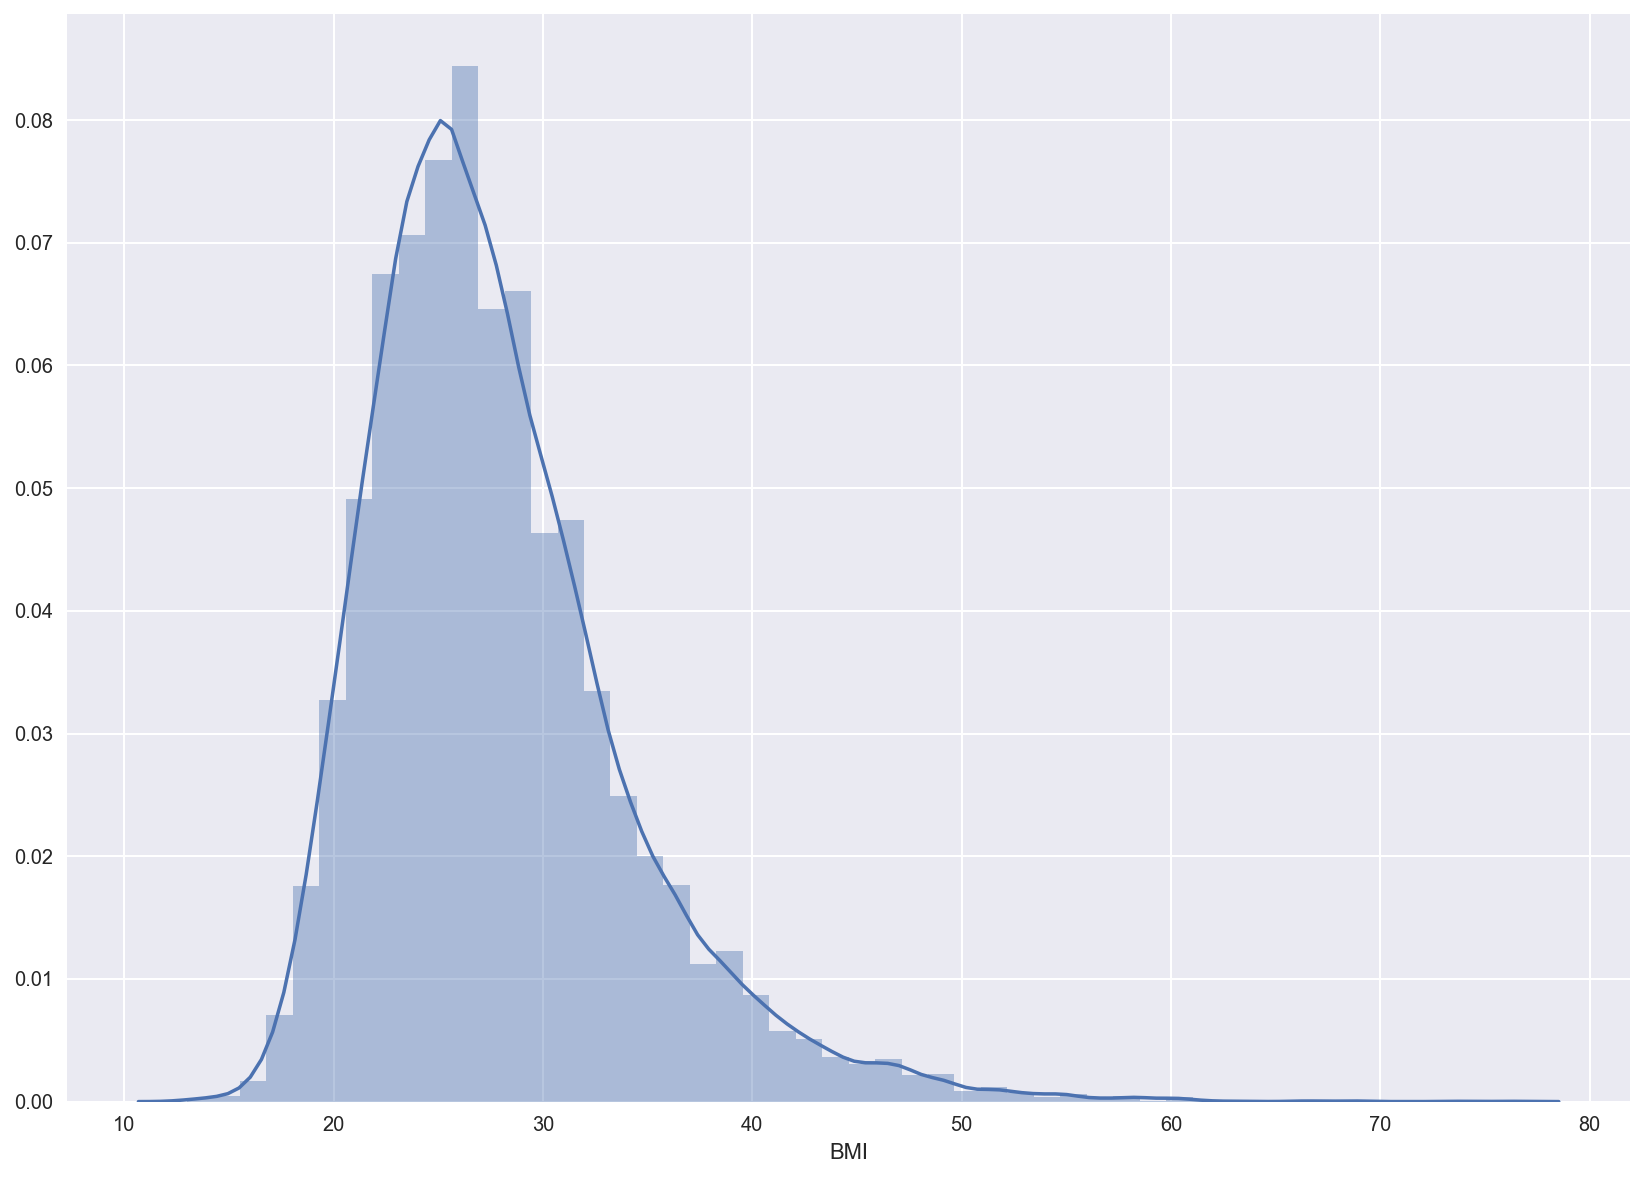

In [6]:
f, ax = plt.subplots(figsize=(14, 10))

sns.distplot(df_atus['BMI'])

plt.show()

In [7]:
# Check for normal distribution
stat, pval = scipy.stats.normaltest(df_atus['BMI'])
stat, pval

(4806.5777148218449, 0.0)

Because pval=0.0, we reject null hypothesis that the data are normally distributed. As evident in the histogram, the distribution is right-skewed with two modes.

In [8]:
df_atus['BMI'].mode()

0    25.8
dtype: float64

In [9]:
df_atus['BMI'].median()

26.6

For BMI, the mode is at 25.8, the median is at 26.6, and the interquartile range (IQR) is 30.5-23.4 = 7.1
On the BMI scale, 25 to 29.9 is considered overweight, while a BMI of >30 is considered obese.

/Users/hannes/miniconda2/envs/cogs108/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


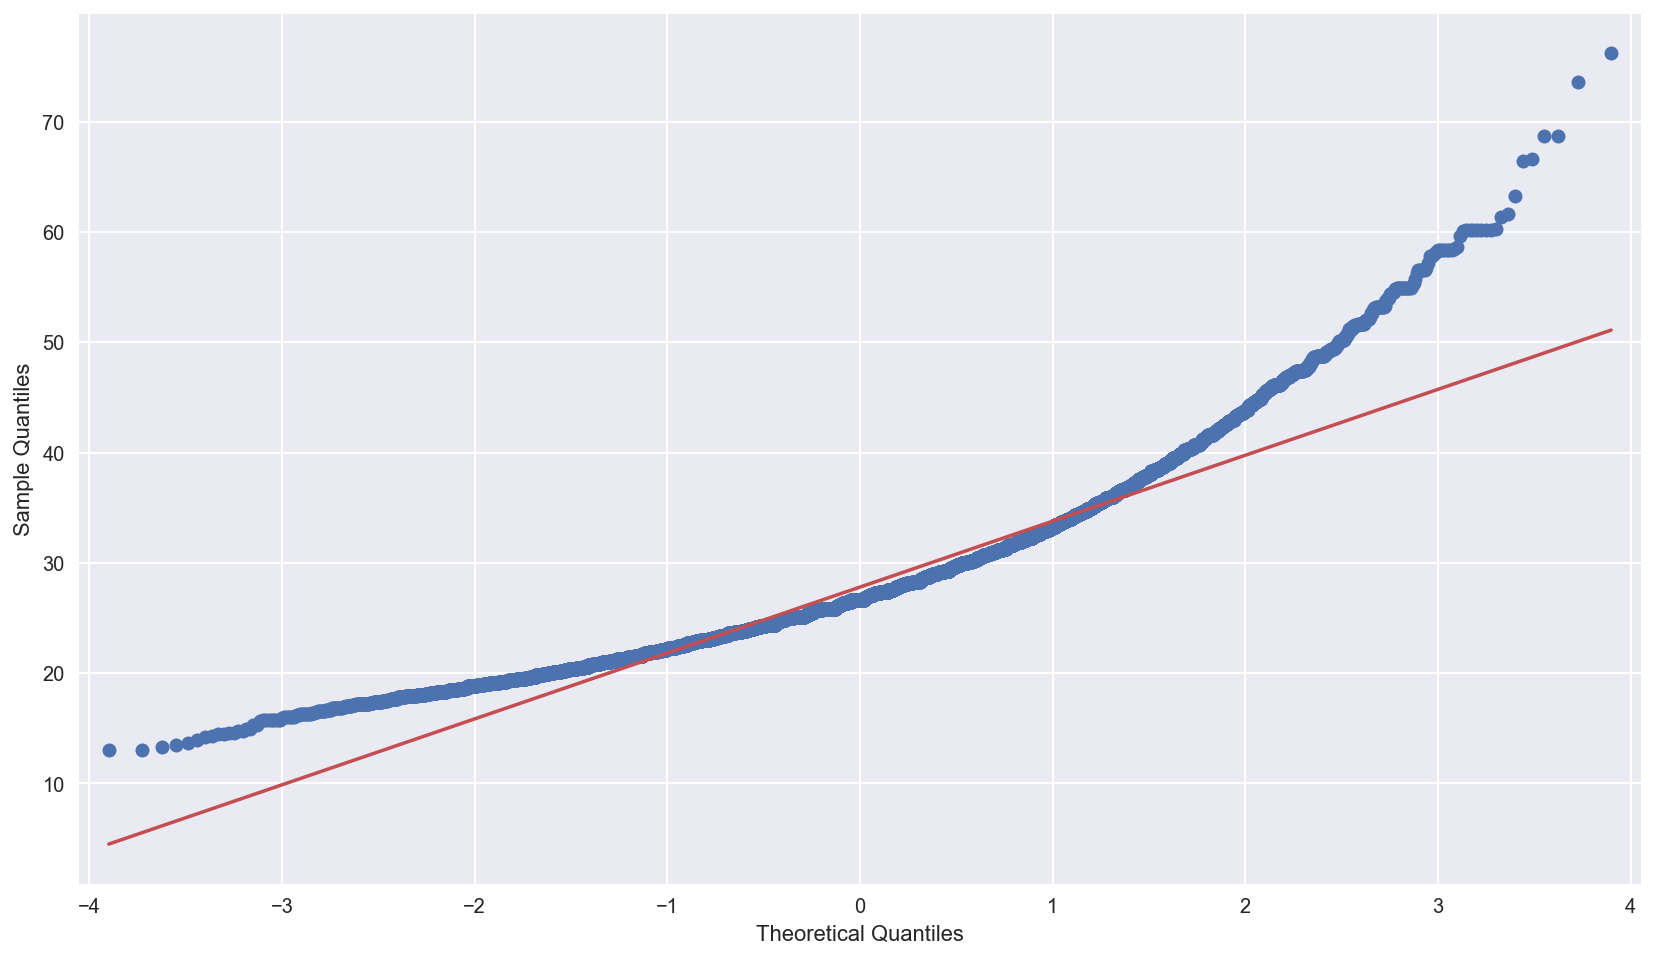

In [10]:
import statsmodels.api as sm

fig = sm.qqplot(df_atus['BMI'], line='r')
plt.show()

Though the earlier normaltest – based on D'Agostino and Pearson's test that combines skew and kurtosis for a test of normality – rejected with 100% certainty that the distribution was a normal distribution, the Q-Q plot reveals a more nuanced picture.
The Q-Q plot shows that the BMI resembles a right-skewed normal distribution.

### Spearman correlation matrix of candidate continuous features

To get an intuition for correlations between categorical features – which, in addition to not being continuous, may not have linear relationships – below is a correlation matrix generated using Spearman's rank correlation coefficient.

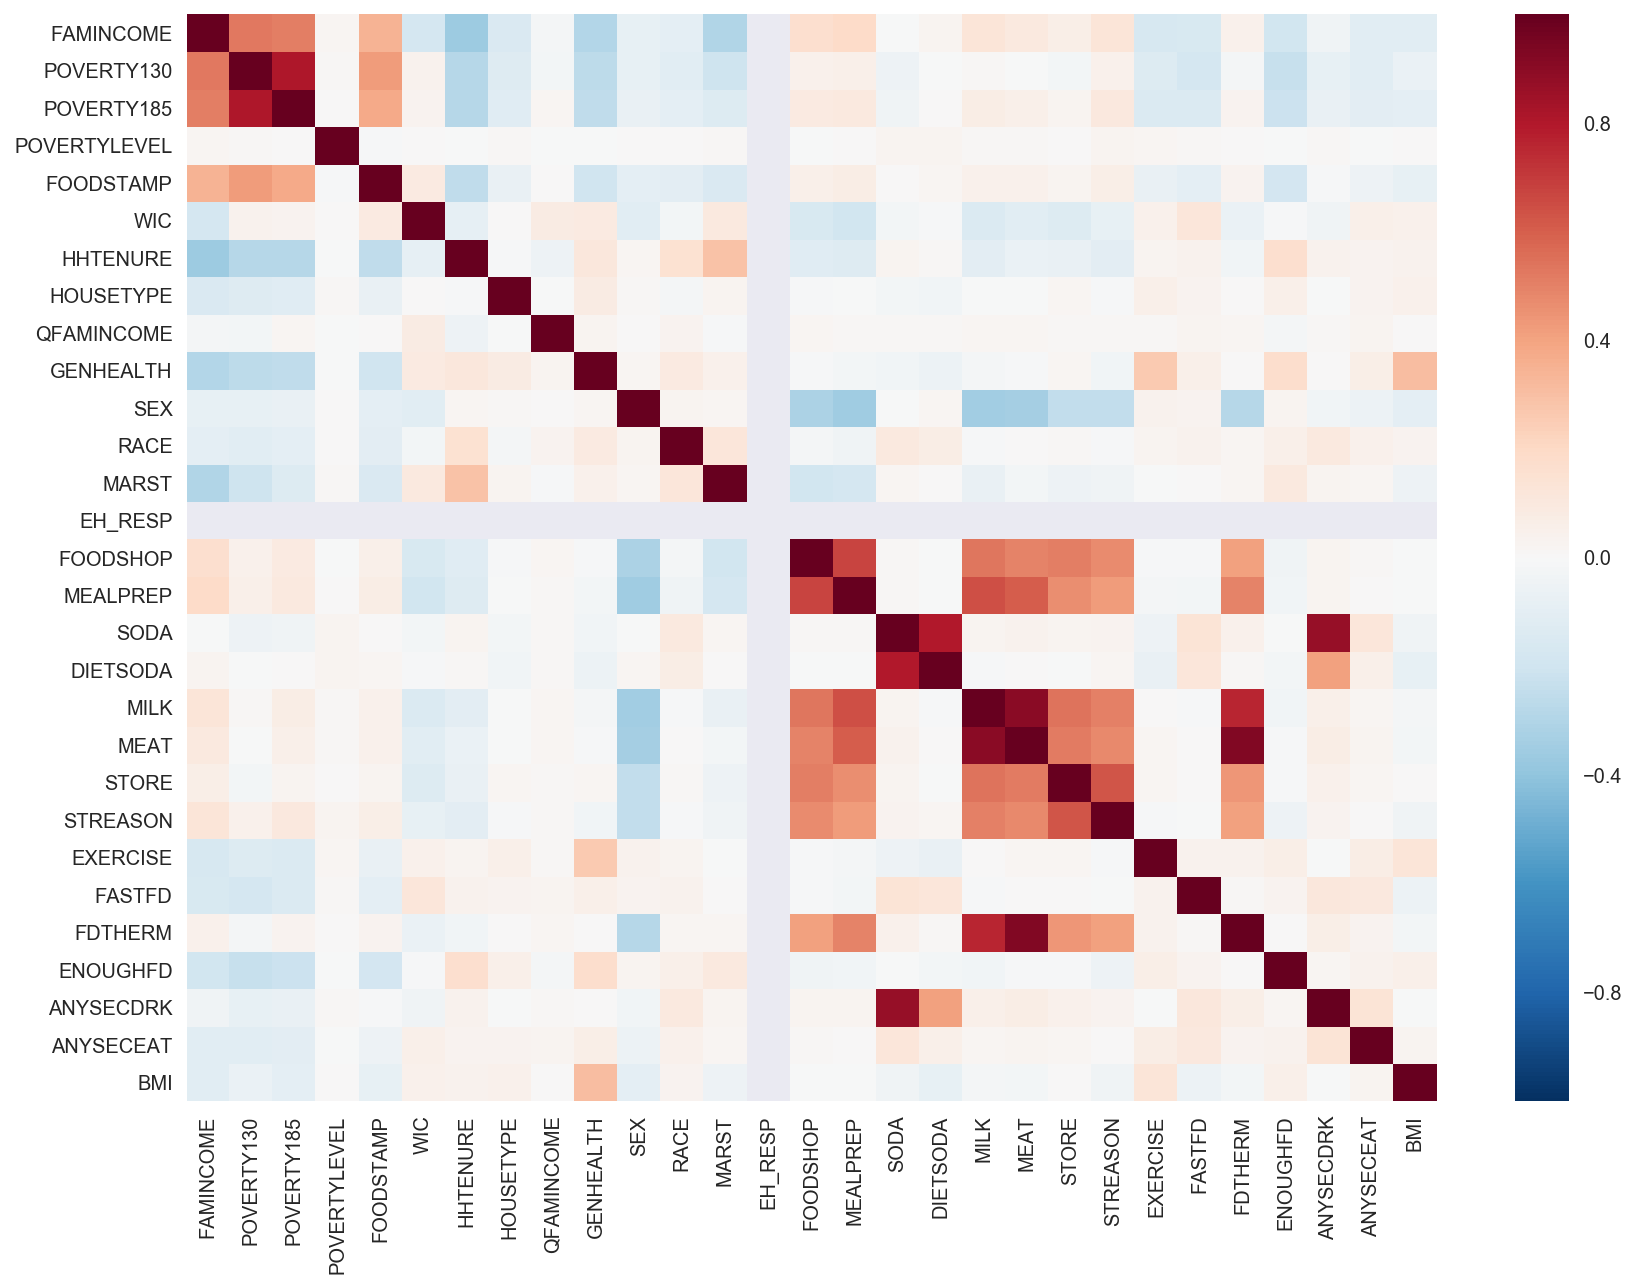

In [11]:
categorical_corrmat = (df_atus[CATEGORICAL_FEATURES + ['BMI']]).corr(method='spearman')

f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(categorical_corrmat)
plt.show()

As expected, there are strong correlations between features such as "milk" and "meat", which denote consumption of those food items. Also as expected, there is a negative correlation between family income and BMI, presumably because wealthier families are more likely to be educated about health and can afford more expensive, healthier food.

### Pearson correlation matrix of candidate continuous features

Since Pearson correlation only works with continuous variables, only such features have been visualized below.

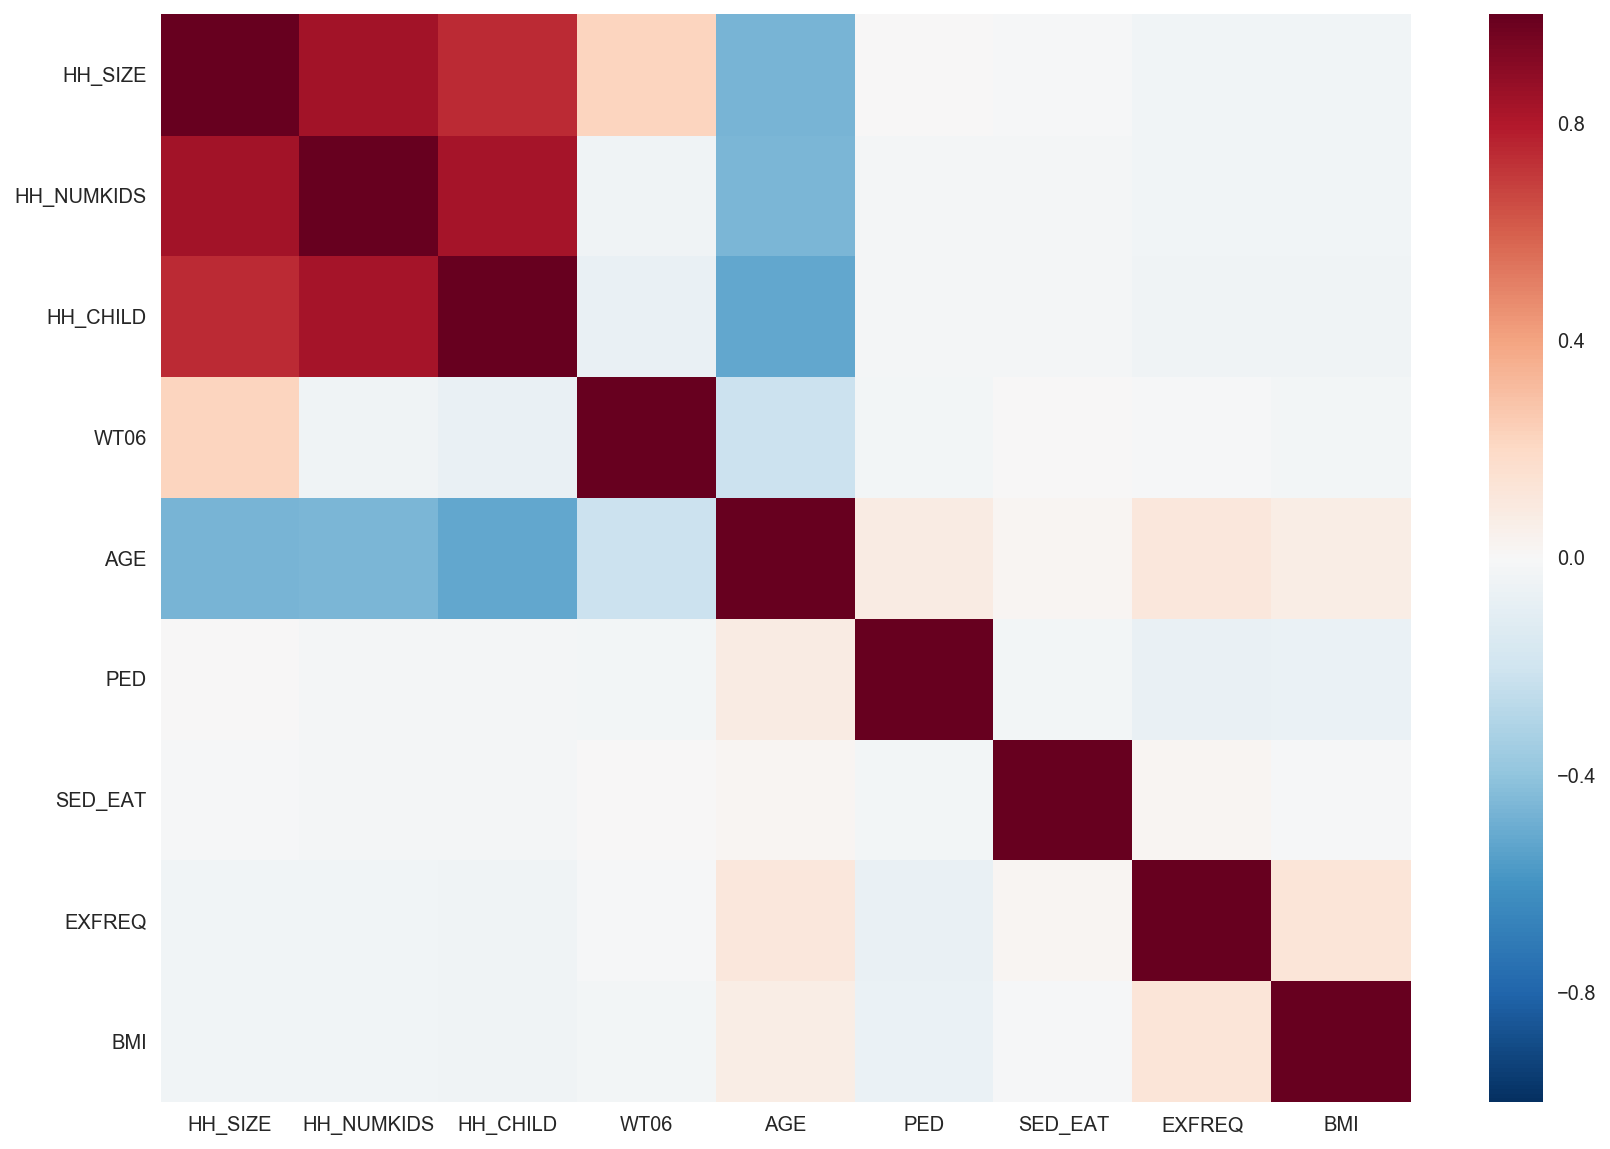

In [12]:
corrmat = (df_atus[CONTINUOUS_FEATURES + ['BMI']]).corr()

f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corrmat)
plt.show()

### Pair plot of select exercise and health related features (mix of categorical and continuous)

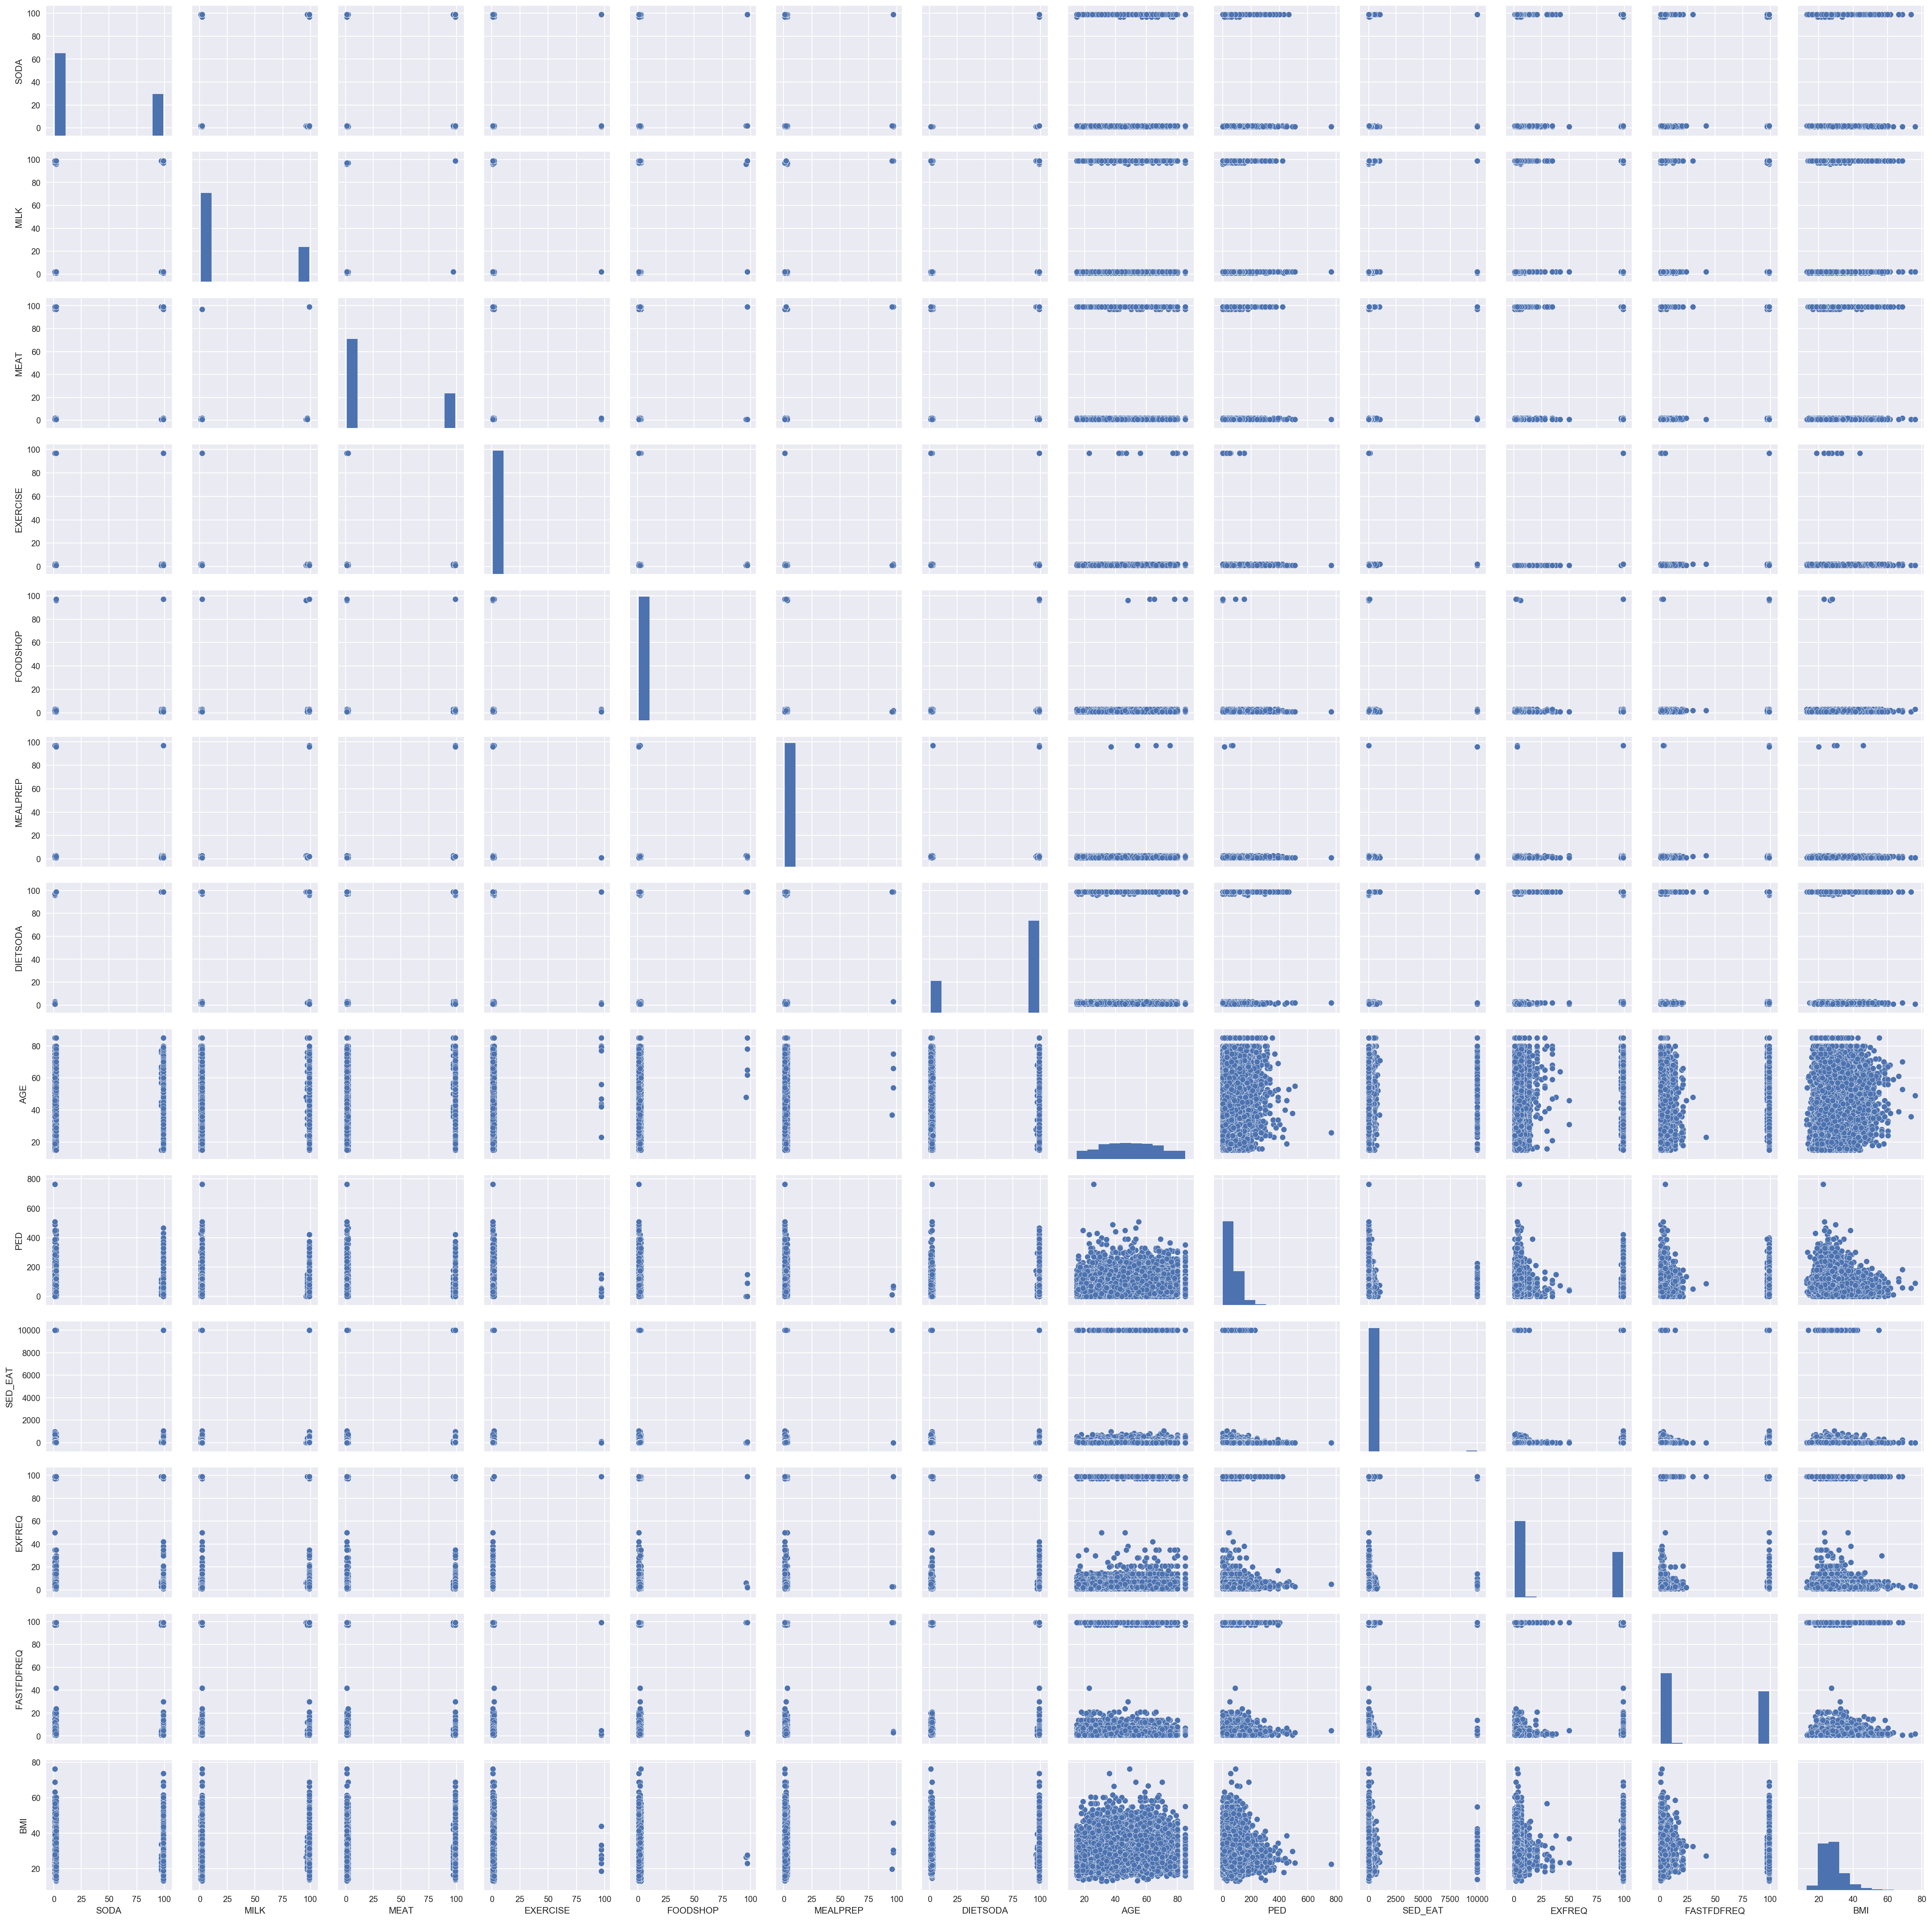

In [13]:
sns.pairplot(df_atus[FOOD_EXERCISE_FEATURES + ['BMI']])

Through these pairplots, unusually large numbers of bimodal, "binary-looking" distributions were uncovered. We discovered that we had not discarded feature values that denoted "no survey response" for a particular feature. 

We took missing survey values into account into the following data analysis. They are, however, included in the later machine learning model because our decision tree can handle categorical values through one-hot encoding. We decided this would be the better optionr rather than imputing the missing values through a population mean.

## Data Analysis and Results

### Part 0: Addtional Cleaning and Definitions

In [14]:
colums = df_atus.columns

FEATURE_COLS = ['HH_SIZE', 'FAMINCOME', 'POVERTY130', 'POVERTY185',
       'POVERTYLEVEL', 'FOODSTAMP', 'WIC', 'HHTENURE', 'HH_CHILD', 'HOUSETYPE',
       'HH_NUMKIDS', 'HH_SIZE_CPS8', 'HH_CHILD_CPS8', 'QFAMINCOME', 'PERNUM',
       'LINENO', 'WT06', 'AGE', 'SEX', 'RACE', 'MARST', 'GENHEALTH', 'HEIGHT',
       'WEIGHT', 'BMI', 'EH_RESP', 'PED', 'SED_EAT', 'FOODSHOP', 'MEALPREP',
       'SODA', 'DIETSODA', 'MILK', 'MEAT', 'STORE', 'STREASON', 'EXERCISE',
       'EXFREQ', 'FASTFD', 'FASTFDFREQ', 'FDTHERM', 'ENOUGHFD', 'ANYSECDRK',
       'ANYSECEAT']
CONTINUOUS_FEATURES = ['HH_SIZE', 'HH_CHILD',
                        'AGE',
                      'PED', 'SED_EAT', 'EXFREQ', 'FASTFDFREQ']
# cannot include weight and height because these are directly associated with
# BMI
EXCLUDED_CONTINUOUS_FEATURES = ['HEIGHT', 'WEIGHT']
CATEGORICAL_FEATURES = ['FAMINCOME', 'POVERTY130', 'POVERTY185',
                       'POVERTYLEVEL', 'FOODSTAMP', 'WIC',
                       'HHTENURE', 'HOUSETYPE', 'QFAMINCOME',
                       'GENHEALTH', 'SEX', 'RACE', 'MARST',
                       'EH_RESP', 'FOODSHOP', 'MEALPREP',
                       'SODA', 'DIETSODA', 'MILK', 'MEAT', 'STORE', 'STREASON', 'EXERCISE',
                       'FASTFD', 'FDTHERM', 'ENOUGHFD', 'ANYSECDRK',
                       'ANYSECEAT']

##### Sanity checking remaining data counts.

In [15]:
#This block of code checks for features less than 99. 99 is the code for unreported. low means are categoricals.
dont_work = ['RACE', 'POVERTY130', 'POVERTY185','SEX']

print ("Checking max range of variable, sample counts, and mean.")
print()

for x in CATEGORICAL_FEATURES:
        if x not in dont_work:
            q = (df_atus[x] < 90)
            if (len(x)<=6):
                x2= x + "     "
            else:
                x2 = x
            print(x2,"\t",   max(df_atus[q][x]),np.sum(q), int(np.mean(df_atus[q][x])))

for x in CONTINUOUS_FEATURES:
        if x not in dont_work:
            q = (df_atus[x] < 90) 
            if (len(x)<=6):
                x2= x + "     "
            else:
                x2 = x       
            print(x2,  "\t",max(df_atus[q][x]),np.sum([(df_atus[x] < 90)]), int(np.mean(df_atus[q][x])))

Checking max range of variable, sample counts, and mean.

FAMINCOME 	 16 20708 10
POVERTYLEVEL 	 7.0 20708 5
FOODSTAMP 	 2.0 20646 1
WIC      	 2.0 10606 1
HHTENURE 	 3 20708 1
HOUSETYPE 	 12 20708 1
QFAMINCOME 	 43 20708 3
GENHEALTH 	 5 20617 2
MARST      	 6 20708 2
EH_RESP 	 1.0 20708 1
FOODSHOP 	 3.0 20703 1
MEALPREP 	 3.0 20704 1
SODA      	 2.0 13781 1
DIETSODA 	 3.0 5293 1
MILK      	 2.0 14892 1
MEAT      	 2.0 14889 1
STORE      	 5.0 15032 1
STREASON 	 6.0 14846 2
EXERCISE 	 2.0 20697 1
FASTFD      	 2.0 20664 1
FDTHERM 	 2.0 13111 1
ENOUGHFD 	 3.0 20676 1
ANYSECDRK 	 2.0 20691 1
ANYSECEAT 	 2.0 20600 1
HH_SIZE 	 13 20708 2
HH_CHILD 	 1 20708 0
AGE      	 85 20708 49
PED      	 89.0 14887 42
SED_EAT 	 87.0 19869 9
EXFREQ      	 50.0 13082 4
FASTFDFREQ 	 42.0 11918 2


### Legend for BMI categories and feature codes

#### BMI categories
FROM CDC

Below 18.5	Underweight

18.5 – 24.9	Normal or Healthy Weight

25.0 – 29.9	Overweight

30.0 and Above	Obese

#### Feature codes
96 = refuse, 97 = dont know 99 = not in universe.	
Note : We drop reported value over 90.


[GENHEALTH]	
01	Excellent	
02	Very good	
03	Good	
04	Fair	
05	Poor	

[PED]	
Total time in primary eating and drinking (in minutes) 		
PED is a 4-digit numeric variable reported in minutes. 	

[SED_DRINK]	
Total time in secondary drinking (in minutes)
SED_DRINK is a 5-digit numeric variable reported in minutes.	

[FOODSHOP]	
ATUS respondent usually does the food shopping, is the food shoper.		
123 	
yes,no,split between spouse, [1,2,3]	

[MEALPREP]	
ATUS Respondent usually does the meal preparation?	
123	
yes,no,both partner	

[SODA]	
Consumed soda in the last 7 days?	
12	
yes,no	

[DIETSODA]
consumed diet soda?	
123	
yes,no,both regular and diet	

[MILK]	
Drank Unpasteurized or raw milk in last 7 days?	
12	
yes,no	

[MEAT]	
Prepared any meals with meat, poultry or seafood in last 7 days?	
12
yes,no

[STORE]	
Place where majority of groceries purchased by respondent.	
1 grocery store	
2 super center	
3 warehouse club	
4 drugstore	
5 other	

[STREASON]	
Reasons to buy foodat prefered store? 	
1 price	
2 location	
3 quality	
4 variety 	
5 customer service 	
6 other	

[EXERCISE]	
Does the respondent exercise weekly?	
12
yes,no

[PRPMEL]	
Are you the person who usually prepares the meals in your household?	
12	
yes,no

'FASTFDFREQ' Times purchased prepared food in last 7 days

'EXFREQ' 	Times participated in physical activities in last 7 days

'PED'	Total time in primary eating and drinking (in minutes)	

'SED_EAT'	Total time in secondary eating (in minutes)





#### Functions to runs tests and graphs for distributions

In [16]:
OB_RANGE = [30,99,"OBESE"] 
OW_RANGE = [25,30,"OVER"]
NW_RANGE = [18.5,25,"NORMAL"]
UW_RANGE = [12,18.5,"UNDER"]

BMI_RANGES = [OB_RANGE,OW_RANGE,NW_RANGE,UW_RANGE]
BACKGROUND_BMI_RATES_ALL = []

for bmi in BMI_RANGES:
    df_temp = df_atus
    temp_sum = df_temp[ (df_temp['BMI']>=bmi[0]) & (df_temp['BMI']<bmi[1])]
    temp_sum = len(temp_sum)
    temp_percent = temp_sum/len(df_atus)
    info = [bmi[2],temp_sum,temp_percent]
    info = temp_percent
    BACKGROUND_BMI_RATES_ALL.append(info)
    

def calc_background(df):
    
    out = []
    for bmi in BMI_RANGES:
        df_temp = df
        temp_sum = df_temp[ (df_temp['BMI']>=bmi[0]) & (df_temp['BMI']<bmi[1])]
        temp_sum = len(temp_sum)
        temp_percent = temp_sum/len(df)
        info = [bmi[2],temp_sum,temp_percent]
        info = temp_percent
        out.append(info)
        
    return out
    
    
#this function reports % of response of categorical variables.
def show_results( feature_list, df_input, ignore_above ):
    
    name_stats = {} 
    name_rows = {}
    
    for x in feature_list:
        
        if (x in SKIP_LIST):
            continue;
    
        else:
            t_name  = str(x)
        
            #These are counts
            t_on    = np.sum([(df_input[x] == 1)])
            t_off   = np.sum([(df_input[x] == 2)])
            t_both  = np.sum([(df_input[x] == 3)]) #or split
            t_4     = np.sum([(df_input[x] == 4)])
            t_5     = np.sum([(df_input[x] == 5)])
            t_6     = np.sum([(df_input[x] == 6)])
                             
            t_valid = np.sum([(df_input[x] < ignore_above)])
            t_total = np.sum(df_input[x])
            
            #These are the actual df_rows
            r_on    = df_input.loc[df_input[x] == 1]
            r_off   = df_input.loc[df_input[x] == 2]
            r_both  = df_input.loc[df_input[x] == 3]
            r_4     = df_input.loc[df_input[x] == 4]
            r_5     = df_input.loc[df_input[x] == 5]
            r_6     = df_input.loc[df_input[x] == 6]
            
            r_valid = df_input.loc[df_input[x] < ignore_above]
            
            t_zero  = np.sum([(df_input[x] == 0)])
            tab = "\t"
            
            if t_zero > 1:
                print ("warning, there is zeros")
                raise NameError('ZEROS')
            
            print("Feature Name        : ",t_name)
            print("# of ONs            : ",t_on,tab,t_on/t_valid*100)
            print("# of OFFs           : ",t_off,tab,t_off/t_valid*100)
            if (np.sum([(df_atus[x] == 3)]) > 0):
                print("# of BOTHs/SPLITs   : ",t_both,tab,t_both/t_valid*100)
            print("# of KNOWN RESPONSE : ", t_valid,tab,t_valid/t_total*100)
            #print("# of TOTAL RESPONSE : ", int(t_total))
            print("-----------------------")
            #print("")
            
            name_stats[t_name] = [0,t_on,t_off,t_both,t_4,t_5,t_6,t_valid,t_total]
            name_rows[t_name] = [0,r_on,r_off,r_both,r_4,r_5,r_6,r_valid] 
            
    return name_stats, name_rows
        

                            
#Takes results from last function, which is an array containing 2 dictionaries, one for counts, one for the actual rows.
#THIS IS P(BMI_CLASS|BEHAVIOR)
def feat_to_bmi(in_data,max_state,graph_mode):
    
    counts = in_data[0] #counts is a dictionary, whose keys are features, whos values are # of instances).
    rows = in_data[1]   #rows is a dictionary, whose keys are features, whos values are array of DFs (who are on and offs).
    
    #print(type_counts)
    #print(type(rows)) 
    
    out_record = []
    for df_feat in rows: #FOR ALL FEATURES, reported in the dictionary.
        
        for x in range(1,max_state+1):# FOR ALL BINARY(3) STATES
            
            df_temp = rows[df_feat][x]
            df_temp1 = rows[df_feat][x]
            df_temp2 = df_atus[~df_atus.isin(df_temp1).all(1)] #compare against compliment, not whole populat
            BACKGROUND_BMI_RATES = calc_background(df_temp2)
            
            
            if (graph_mode==1):
                #HELP ME LABEL THESE GRAPH
                

            

                out = ttest_ind(df_temp1.BMI, df_temp2.BMI)
                
                record = [out[1],out[0],df_feat,x]
                
                out_record.append(record)
                
                #ttest_real doese not assume same variance,
                #but random sampling is problematic due to size difference.
                #out = ttest_rel(df_temp1.BMI, df_temp2.sample(len(df_temp1)).BMI)
                #print(" T-statistic: " + str(out[0]),"p-value: "+str(out[1]))
                
                
                sns.distplot(df_temp1.BMI, label = str(df_feat))
                sns.distplot(df_temp2.BMI, label = "Population", color = 'y')
                
                if (max_state<=3):
                    word = ""
                    if x == 1:
                        word = "YES"
                    if x == 2:
                        word = "NO"
                    if x ==3:
                        word = "BOTH"
                else:
                    word = str(x)

                plt.title('FEATURE : ' + df_feat + " | STATUS: " + word)
                print("----------------------------------------------------------------------------------")
                plt.show()
                print("T-statistic: " + str(out[0]),"p-value: "+str(out[1]))
                print("----------------------------------------------------------------------------------")
                print()
                
            else:
                print("----------------------------------------------------------------------------------")
                temp_c  = counts[df_feat][x]
                temp_plot_values = [] #the % to show in the plots

                if (x==3 and len(df_temp)==0): #skip for only binaries
                    break

                #print(len(df_temp))
                #print(type(df_temp))

                temp_check = []
                temp_check2 = []

                print ("TOTAL CASES: ","","","",str(temp_c))
                for bmi in range(len(BMI_RANGES)): #FOR ALL WEIGHT CATEGORIES


                    temp_sum = df_temp[ (df_temp['BMI']>=BMI_RANGES[bmi][0]) & (df_temp['BMI']<BMI_RANGES[bmi][1])]
                    temp_sum = len(temp_sum)
                    temp_percent = temp_sum / temp_c

                    temp_check.append(temp_sum)
                    temp_check2.append(temp_percent)

                    offset = (temp_percent-BACKGROUND_BMI_RATES[bmi])*100


                    print(df_feat,x,BMI_RANGES[bmi][2],"\t",temp_sum,"\t",temp_percent*100,"%", "   OFF :"+str(offset)) 



                    temp_plot_values.append(temp_percent)



                print("")    
                #print("check if cases # matche:","",sum(temp_check) == temp_c)
                #print("check if % adds to one :","",1-sum(temp_check2) <= 0.01)

                n_groups = 4

                # create plot
                fig, ax = plt.subplots()
                index = np.arange(n_groups)
                bar_width = 0.35

                opacity = 0.8
                
                #print(sum(BACKGROUND_BMI_RATES))
                #print(sum(temp_plot_values))
                rects1 = plt.bar(index, BACKGROUND_BMI_RATES , bar_width,
                                 alpha=opacity,
                                 color='y',
                                 label='Population %')

                rects2 = plt.bar(index + bar_width, temp_plot_values, bar_width,
                                 alpha=opacity,
                                 color='g',
                                 label='Feature %')

                plt.xlabel('BMI CLASS')
                plt.ylabel('%')
                if (max_state<=3):
                    word = ""
                    if x == 1:
                        word = "YES"
                    if x == 2:
                        word = "NO"
                    if x ==3:
                        word = "BOTH"
                else:
                    word = str(x)

                plt.title('FEATURE : ' + df_feat + " | STATUS: " + word)
                plt.xticks(index + bar_width, ('OBESE', 'OVERWEIGHT', 'NORMAL', 'UNDERWEIGHT'))
                plt.legend()
                plt.ylim([0,0.55])

                plt.tight_layout()
                plt.show()

                print("----------------------------------------------------------------------------------")
   
    return out_record



#BMI FOODSHOP STORES

### Part 1: Analysis of discrete/categorical variables

In [17]:
ON_OFF_FEATURES = ['ALLDAYEAT','SODA','MILK','MEAT','EXERCISE','PRPMEL'] 
THREE_OPTIONS = ['FOODSHOP','MEALPREP','DIETSODA']
FIVE_OPTIONS = ['GENHEALTH', 'STORE' ]
SIX_OPTIONS = ['STREASON']
SKIP_LIST = ['ALLDAYEAT','PRPMEL'] #can run if we re-extract the data, currently missing;

print("Composition of features: \n")

RESULTS_ON_OFF = show_results(ON_OFF_FEATURES,df_atus,90)
RESULTS_THREE = show_results(THREE_OPTIONS,df_atus,90)
RESULTS_FIVE     = show_results(FIVE_OPTIONS,df_atus,90)
RESULTS_SIX      = show_results(SIX_OPTIONS,df_atus,90)
print("Discount GENHEALTH, STORE, STREASON")                             

Composition of features: 

Feature Name        :  SODA
# of ONs            :  5304 	 38.4877730208
# of OFFs           :  8477 	 61.5122269792
# of KNOWN RESPONSE :  13781 	 1.94643868527
-----------------------
Feature Name        :  MILK
# of ONs            :  248 	 1.66532366371
# of OFFs           :  14644 	 98.3346763363
# of KNOWN RESPONSE :  14892 	 2.46034486462
-----------------------
Feature Name        :  MEAT
# of ONs            :  13121 	 88.1254617503
# of OFFs           :  1768 	 11.8745382497
# of KNOWN RESPONSE :  14889 	 2.51208886879
-----------------------
Feature Name        :  EXERCISE
# of ONs            :  13118 	 63.3811663526
# of OFFs           :  7579 	 36.6188336474
# of KNOWN RESPONSE :  20697 	 70.5347101523
-----------------------
Feature Name        :  FOODSHOP
# of ONs            :  12743 	 61.5514659711
# of OFFs           :  5533 	 26.7255953243
# of BOTHs/SPLITs   :  2427 	 11.7229387045
# of KNOWN RESPONSE :  20703 	 65.5697725977
-----------------

In [18]:
print("These are the overall population BMI Distributions:")
print("")
k = ['Obese','Overweight','Normal','Underweight']
for x in range(len(k)):
    print (k[x]+": "+ str(BACKGROUND_BMI_RATES_ALL[x]*100)+"%")

print()





These are the overall population BMI Distributions:

Obese: 29.829051574270814%
Overweight: 34.846436159938186%
Normal: 33.67780567896465%
Underweight: 1.6467065868263475%



Bar charts showing difference of BMI class distribution between feature-specifc and general population

Note: 	General popluation is taken to be the whole population - the features. 
	This prevents double counting and accentuates the effect of the feature.

----------------------------------------------------------------------------------
TOTAL CASES:     5304
SODA 1 OBESE 	 1893 	 35.6900452489 %    OFF :7.87908705619
SODA 1 OVER 	 1786 	 33.6726998492 %    OFF :-1.57788441466
SODA 1 NORMAL 	 1545 	 29.128959276 %    OFF :-6.1151331675
SODA 1 UNDER 	 80 	 1.50829562594 %    OFF :-0.186069474031



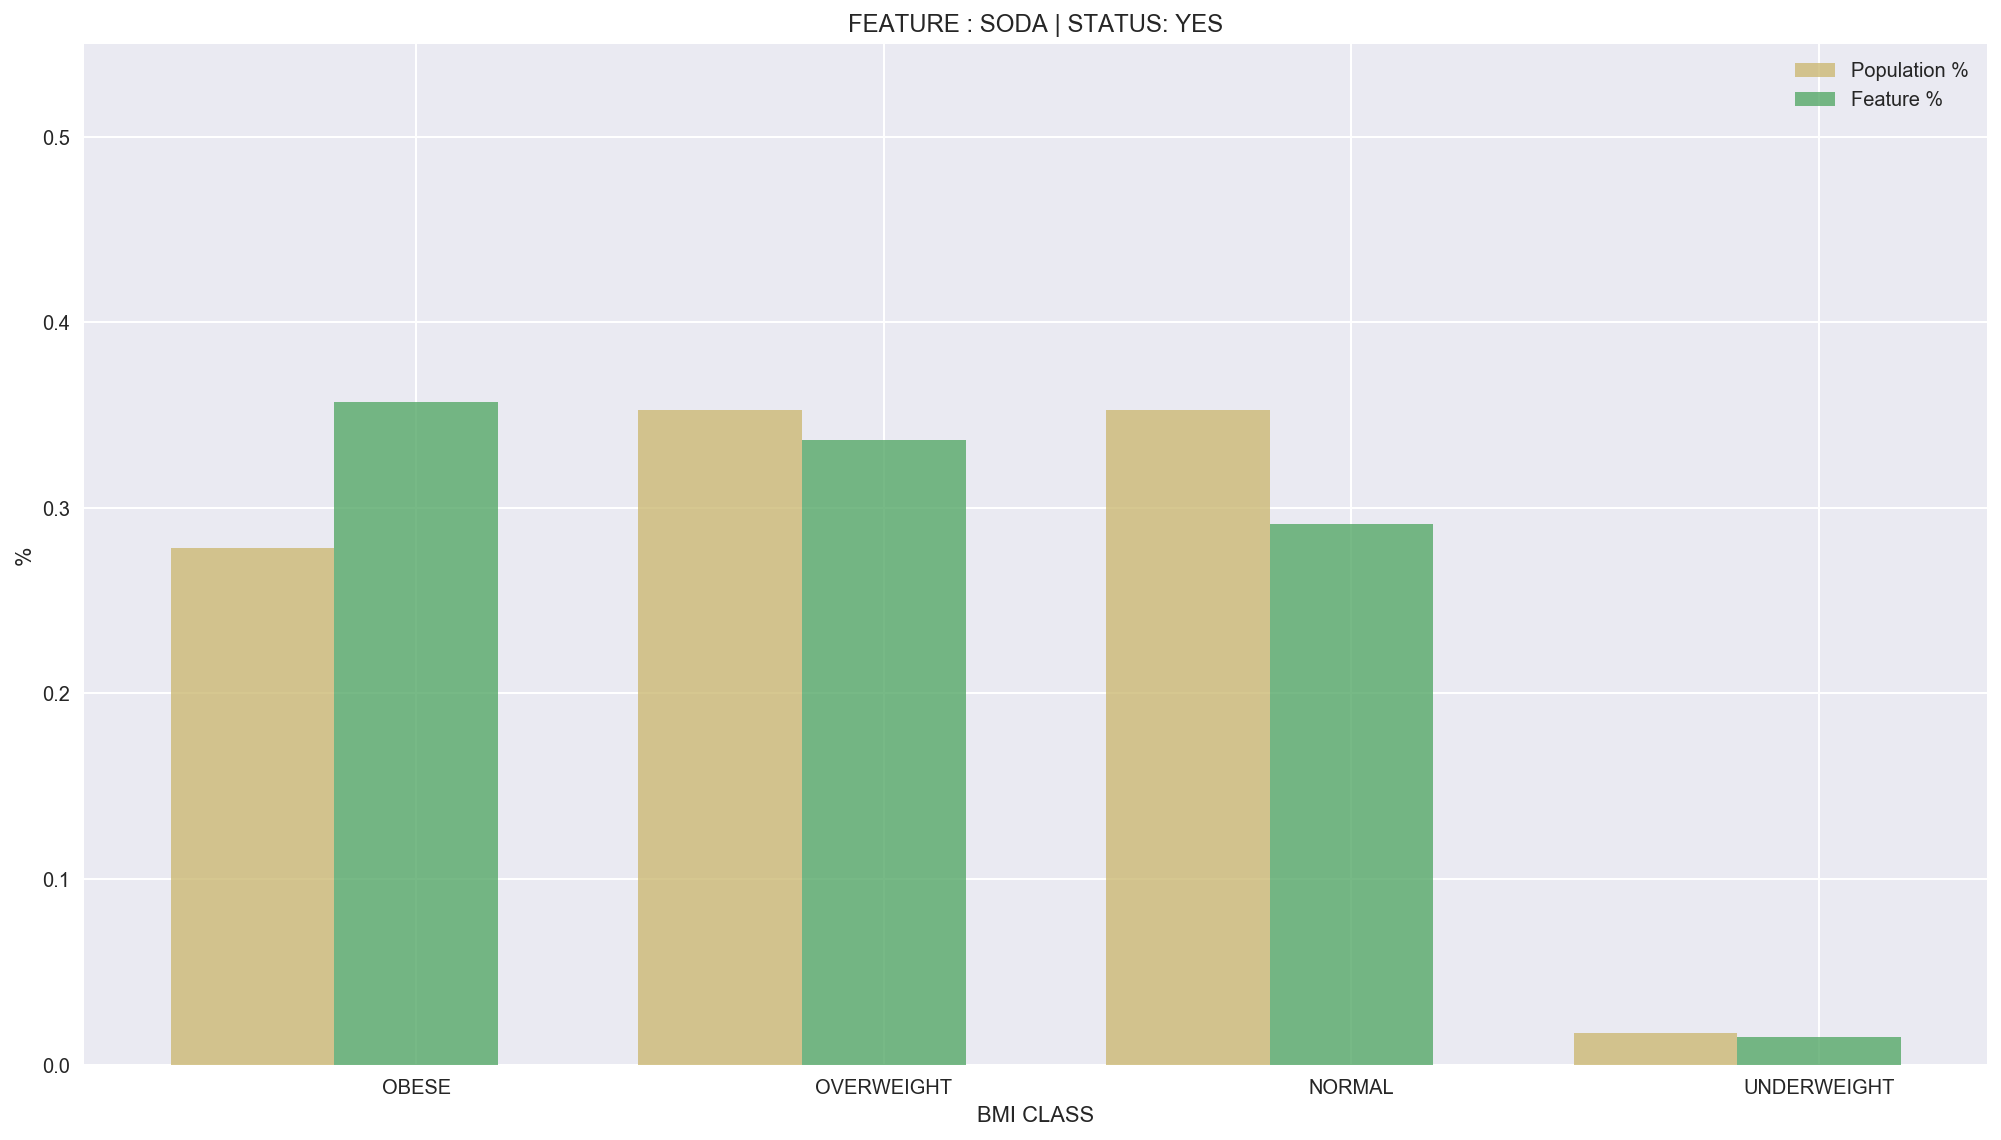

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     8477
SODA 2 OBESE 	 2253 	 26.5777987496 %    OFF :-5.50461478981
SODA 2 OVER 	 2966 	 34.9887932051 %    OFF :0.241021150528
SODA 2 NORMAL 	 3120 	 36.8054736345 %    OFF :5.29537634078
SODA 2 UNDER 	 138 	 1.62793441076 %    OFF :-0.0317827014972



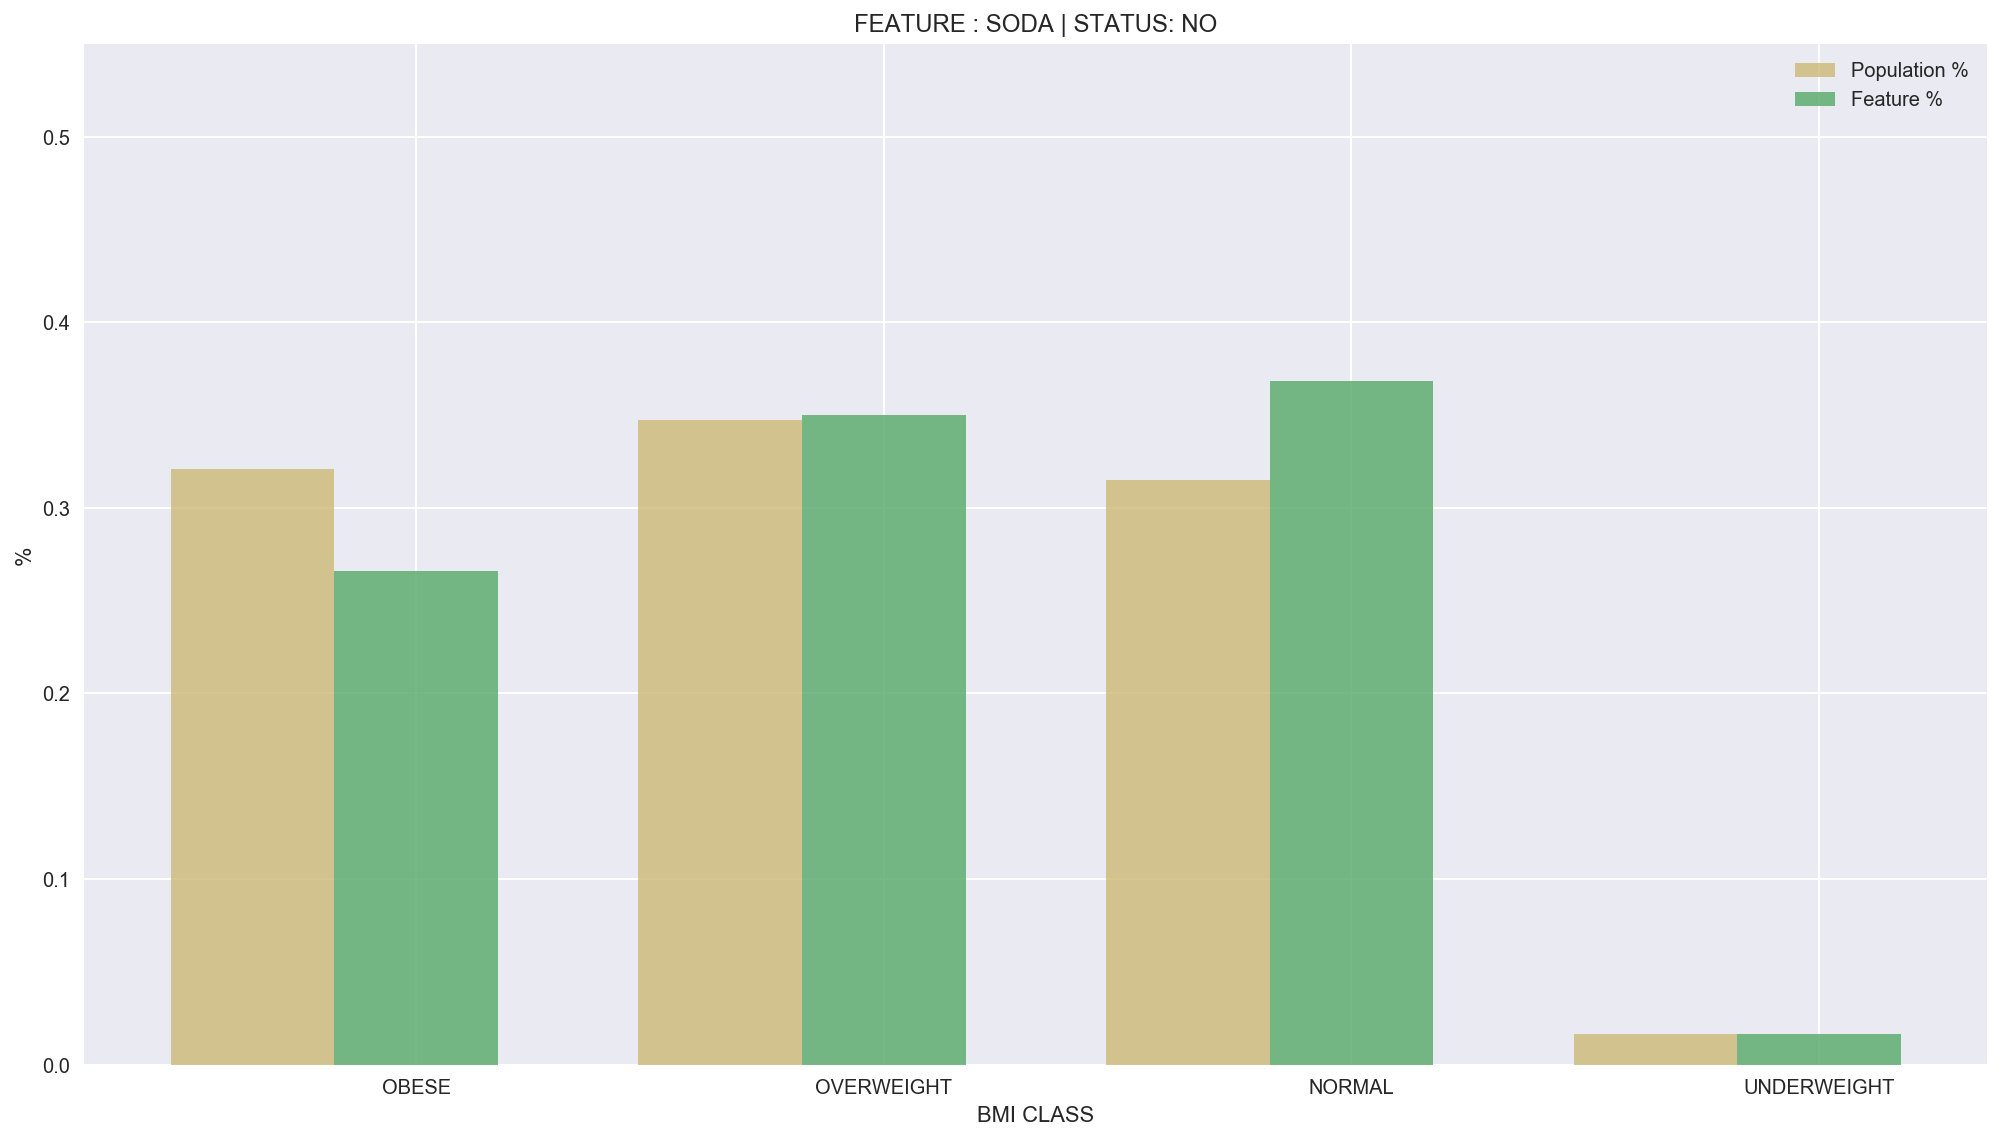

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     248
MILK 1 OBESE 	 82 	 33.064516129 %    OFF :3.27468230694
MILK 1 OVER 	 89 	 35.8870967742 %    OFF :1.05327468231
MILK 1 NORMAL 	 69 	 27.8225806452 %    OFF :-5.92619745846
MILK 1 UNDER 	 8 	 3.22580645161 %    OFF :1.59824046921



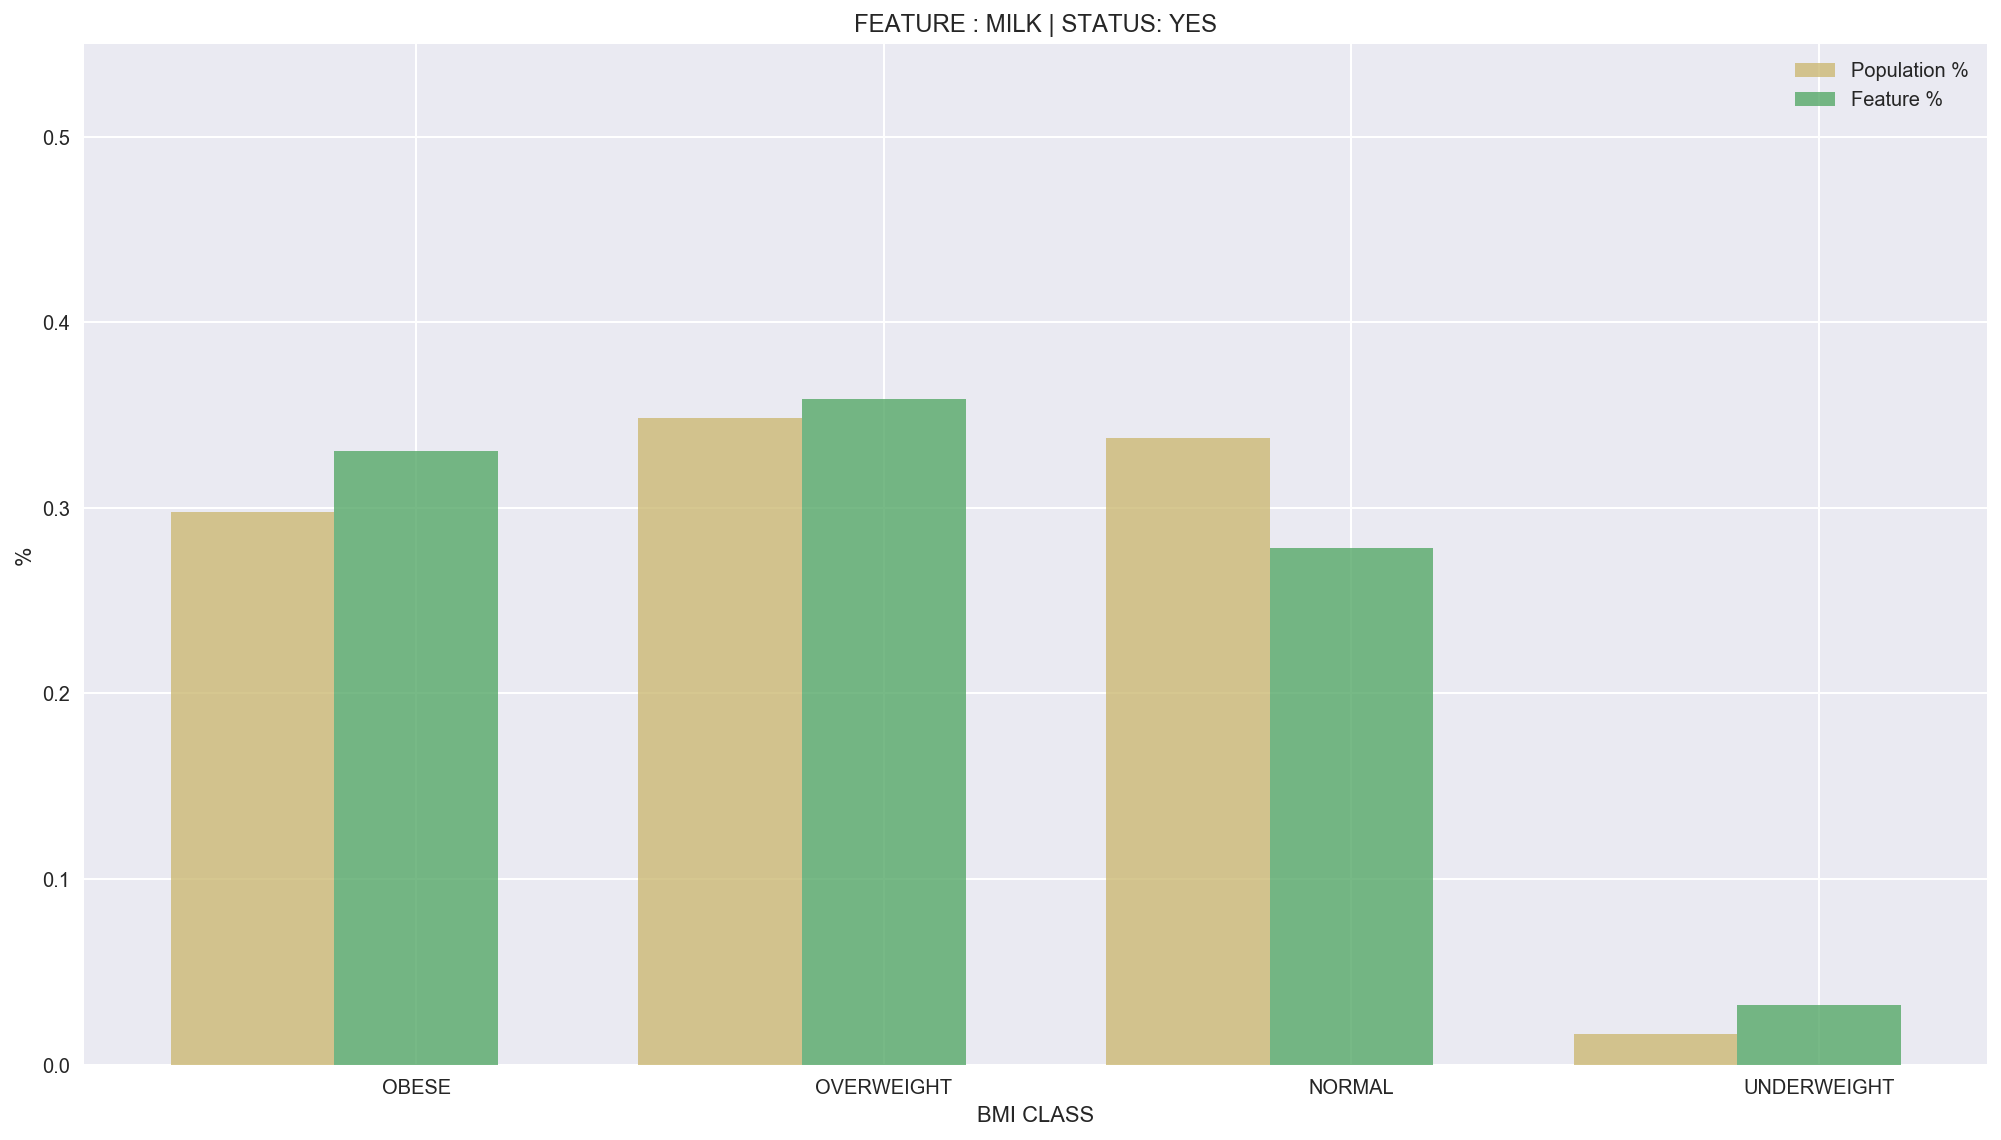

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     14644
MILK 2 OBESE 	 4450 	 30.3878721661 %    OFF :1.90832071489
MILK 2 OVER 	 5049 	 34.4782846217 %    OFF :-1.25720350496
MILK 2 NORMAL 	 4929 	 33.6588363835 %    OFF :-0.0647783922238
MILK 2 UNDER 	 216 	 1.47500682874 %    OFF :-0.586338817703



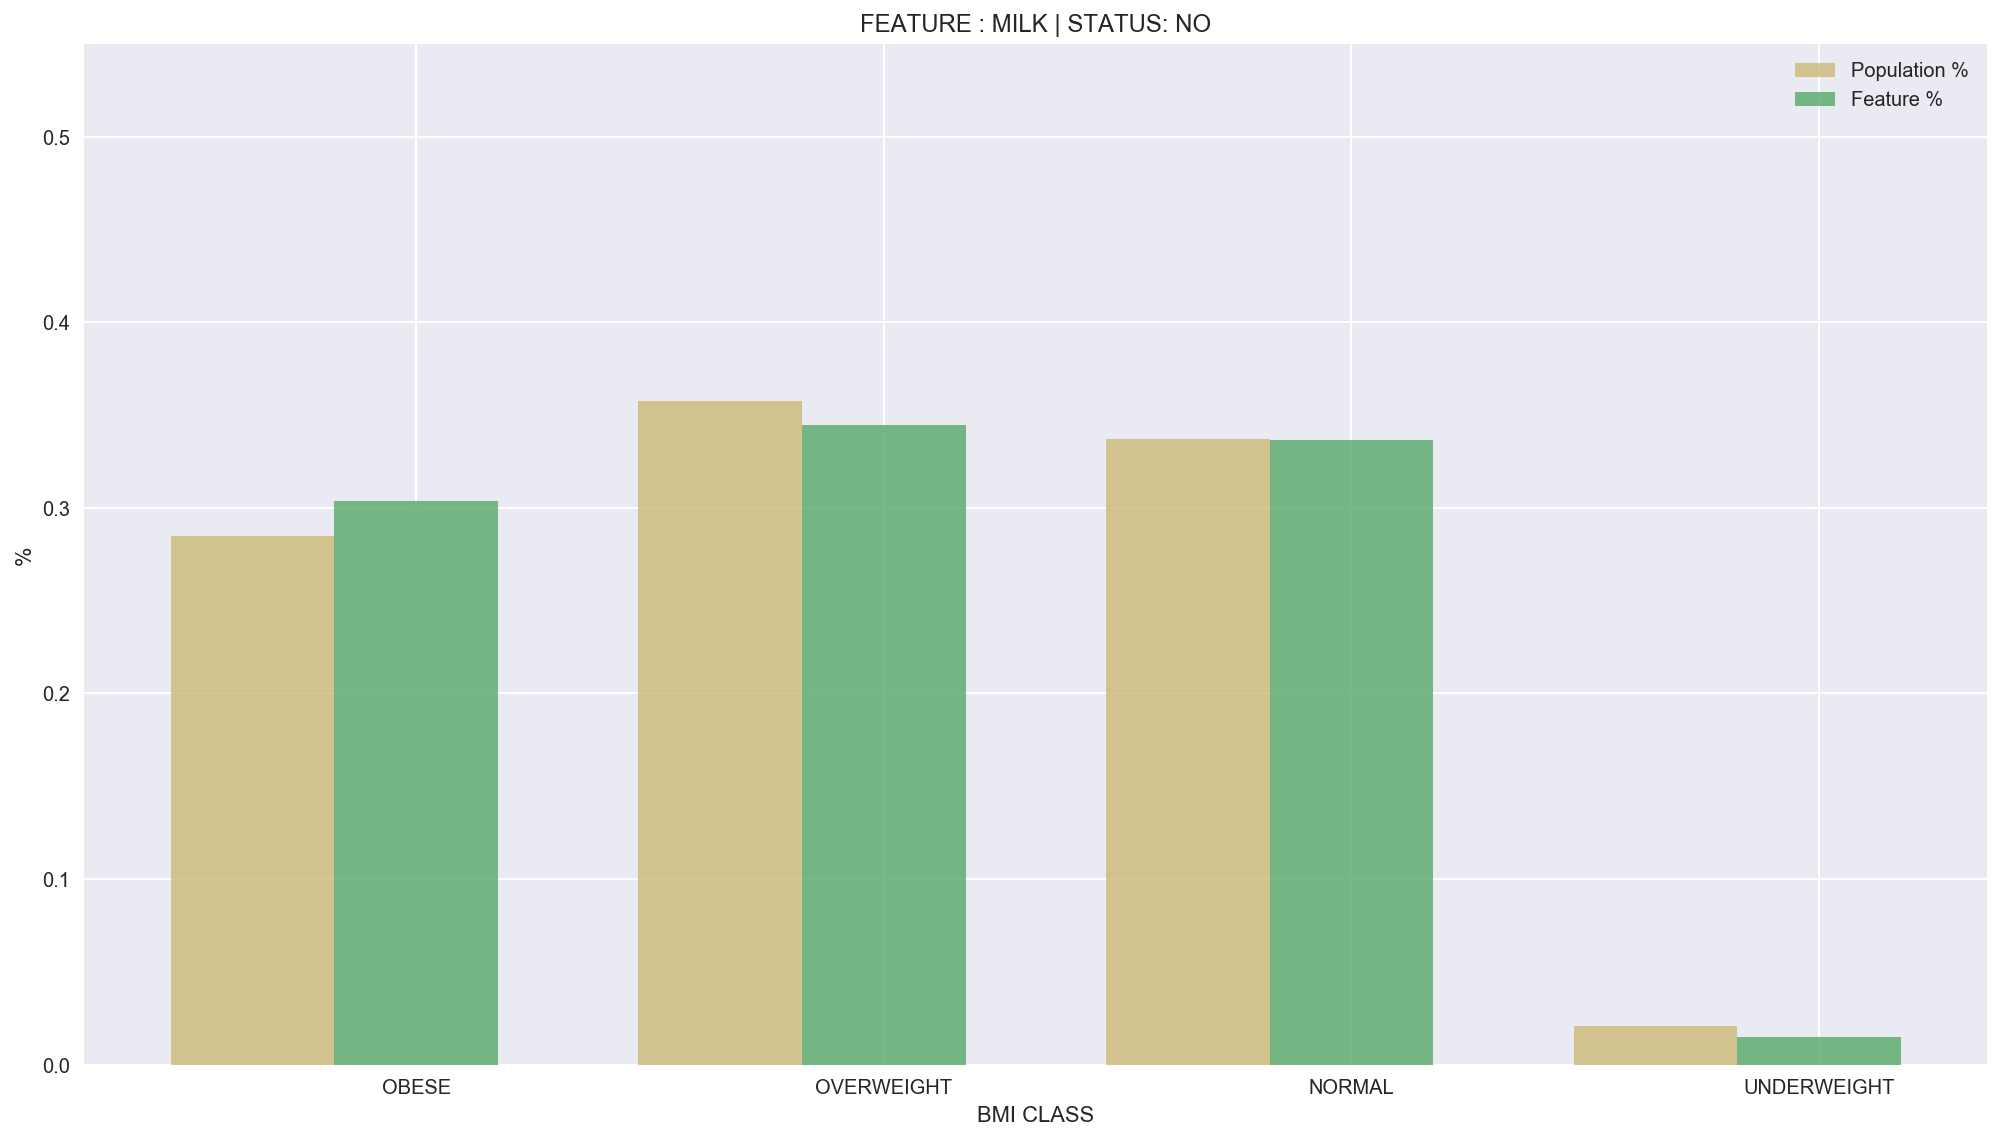

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     13121
MEAT 1 OBESE 	 4048 	 30.851307065 %    OFF :2.79014982236
MEAT 1 OVER 	 4551 	 34.6848563372 %    OFF :-0.441016866996
MEAT 1 NORMAL 	 4335 	 33.0386403475 %    OFF :-1.74454141074
MEAT 1 UNDER 	 187 	 1.42519625029 %    OFF :-0.604591544627



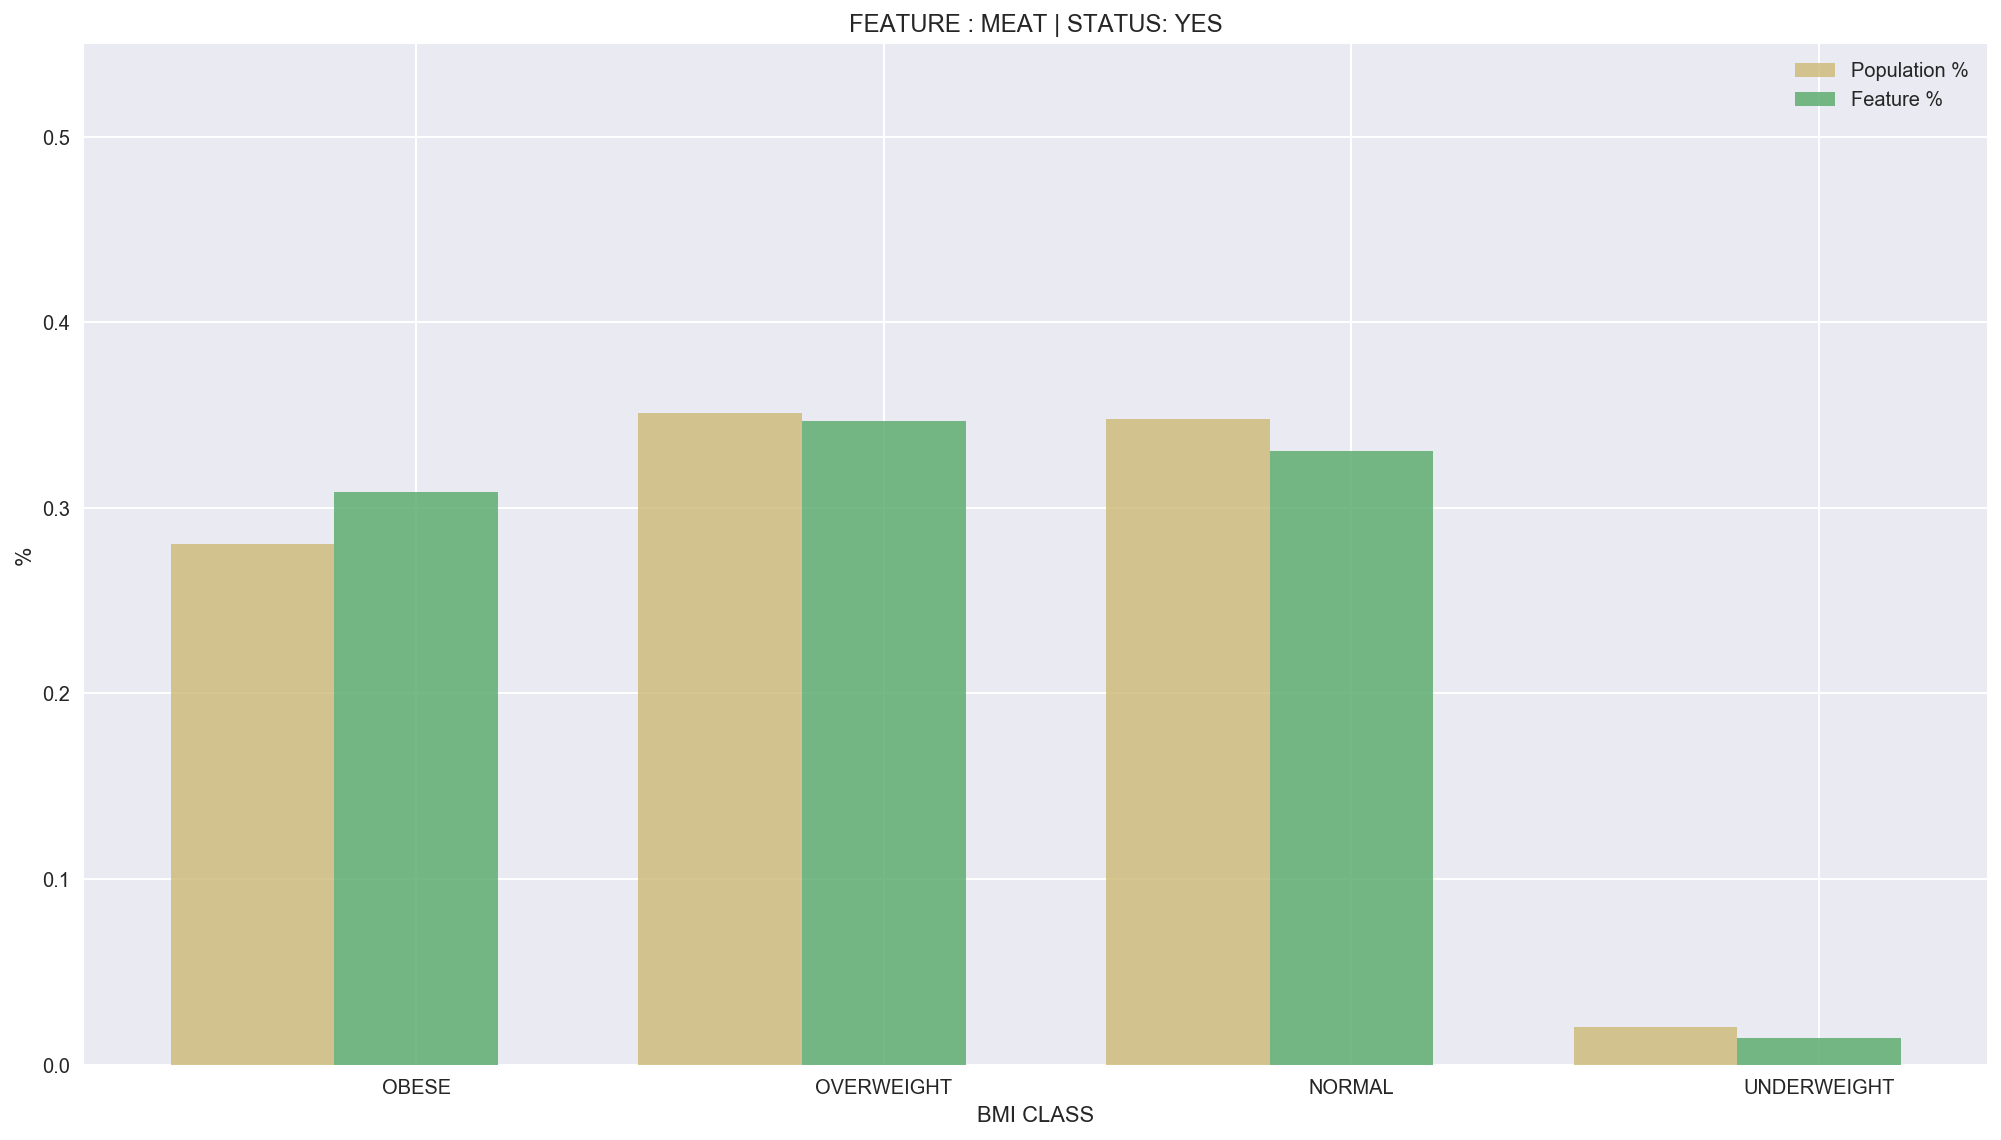

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     1768
MEAT 2 OBESE 	 483 	 27.3190045249 %    OFF :-2.74435344766
MEAT 2 OVER 	 582 	 32.9185520362 %    OFF :-2.10784711903
MEAT 2 NORMAL 	 667 	 37.7262443439 %    OFF :4.42634994051
MEAT 2 UNDER 	 36 	 2.03619909502 %    OFF :0.425850626174



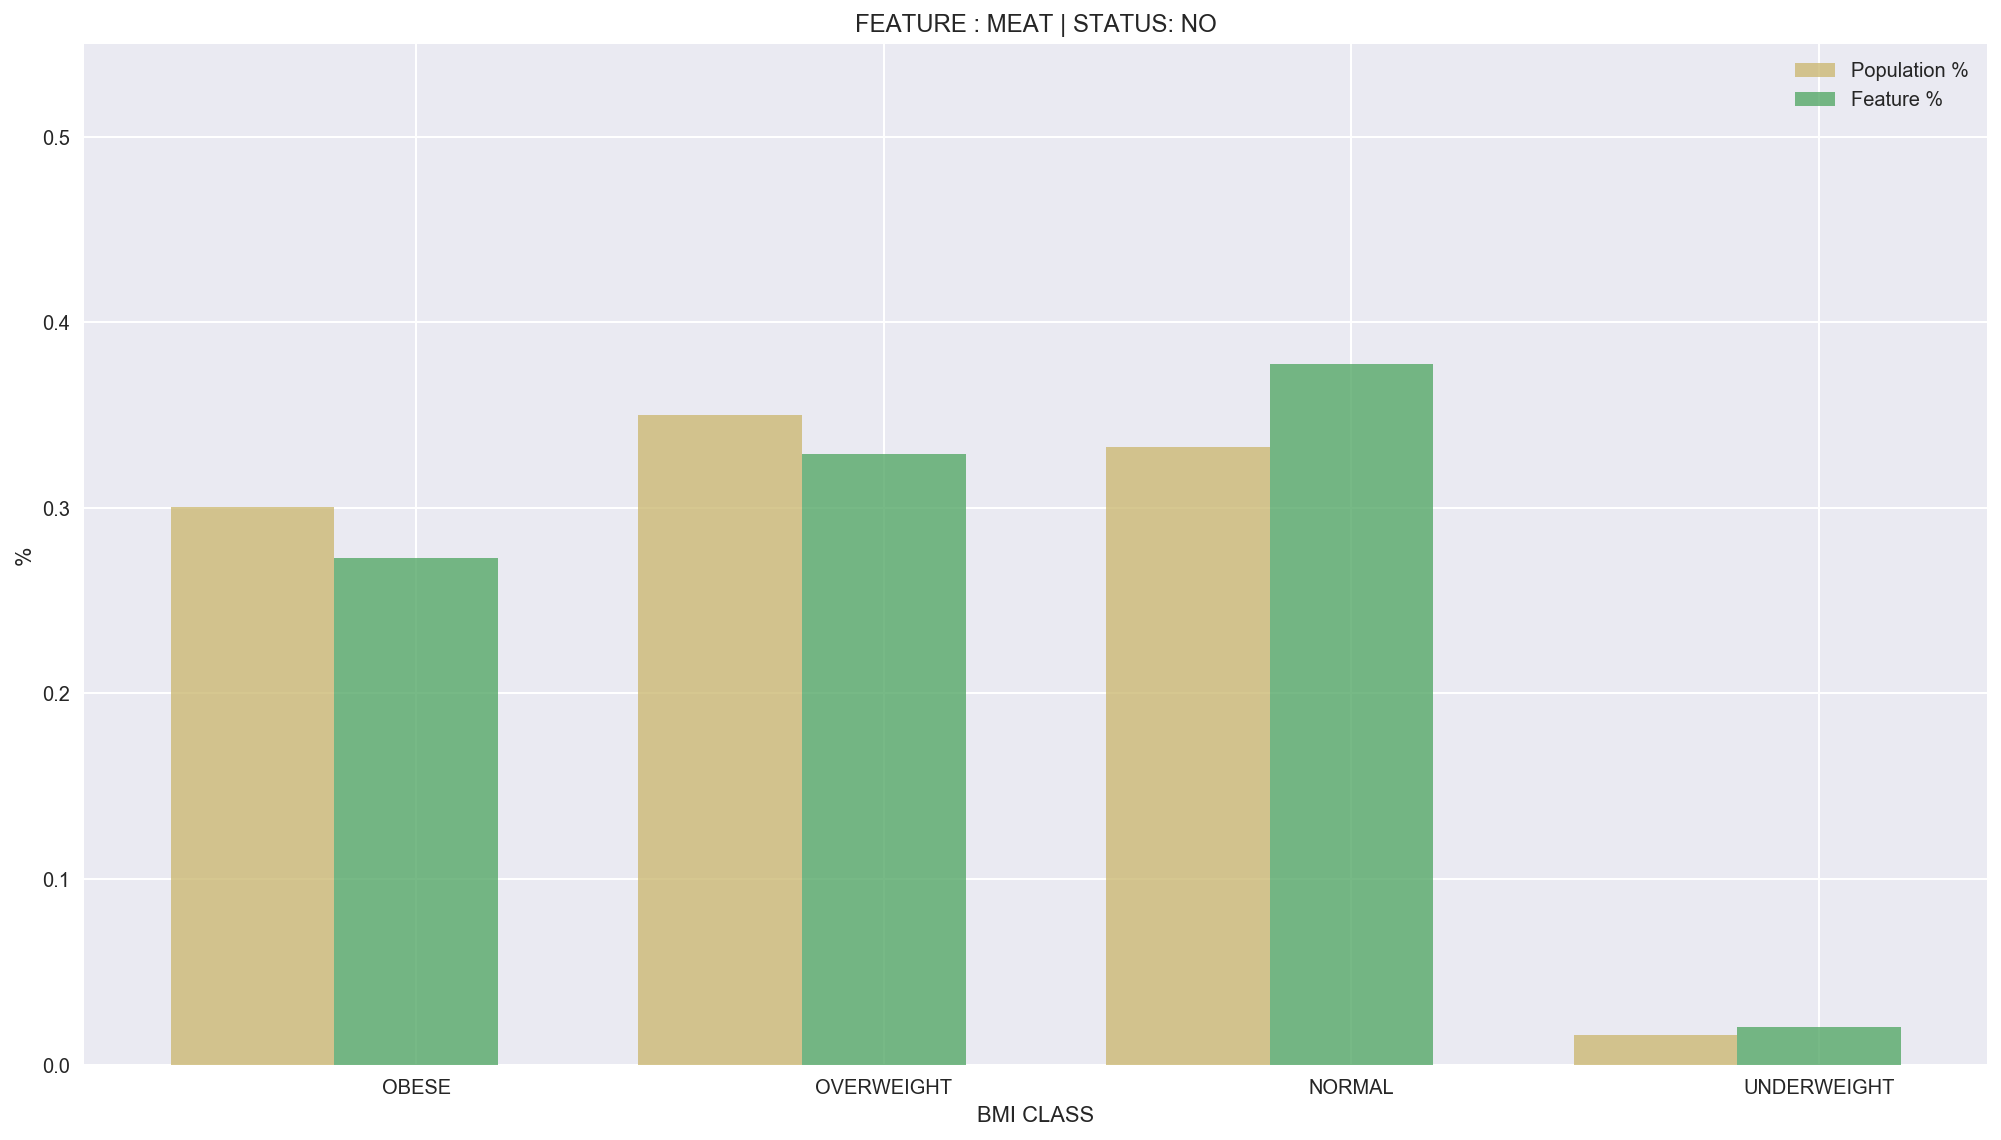

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     13118
EXERCISE 1 OBESE 	 3385 	 25.804238451 %    OFF :-10.9810052908
EXERCISE 1 OVER 	 4684 	 35.706662601 %    OFF :2.34697880654
EXERCISE 1 NORMAL 	 4836 	 36.8653758195 %    OFF :8.69673286823
EXERCISE 1 UNDER 	 213 	 1.62372312853 %    OFF :-0.0627063839908



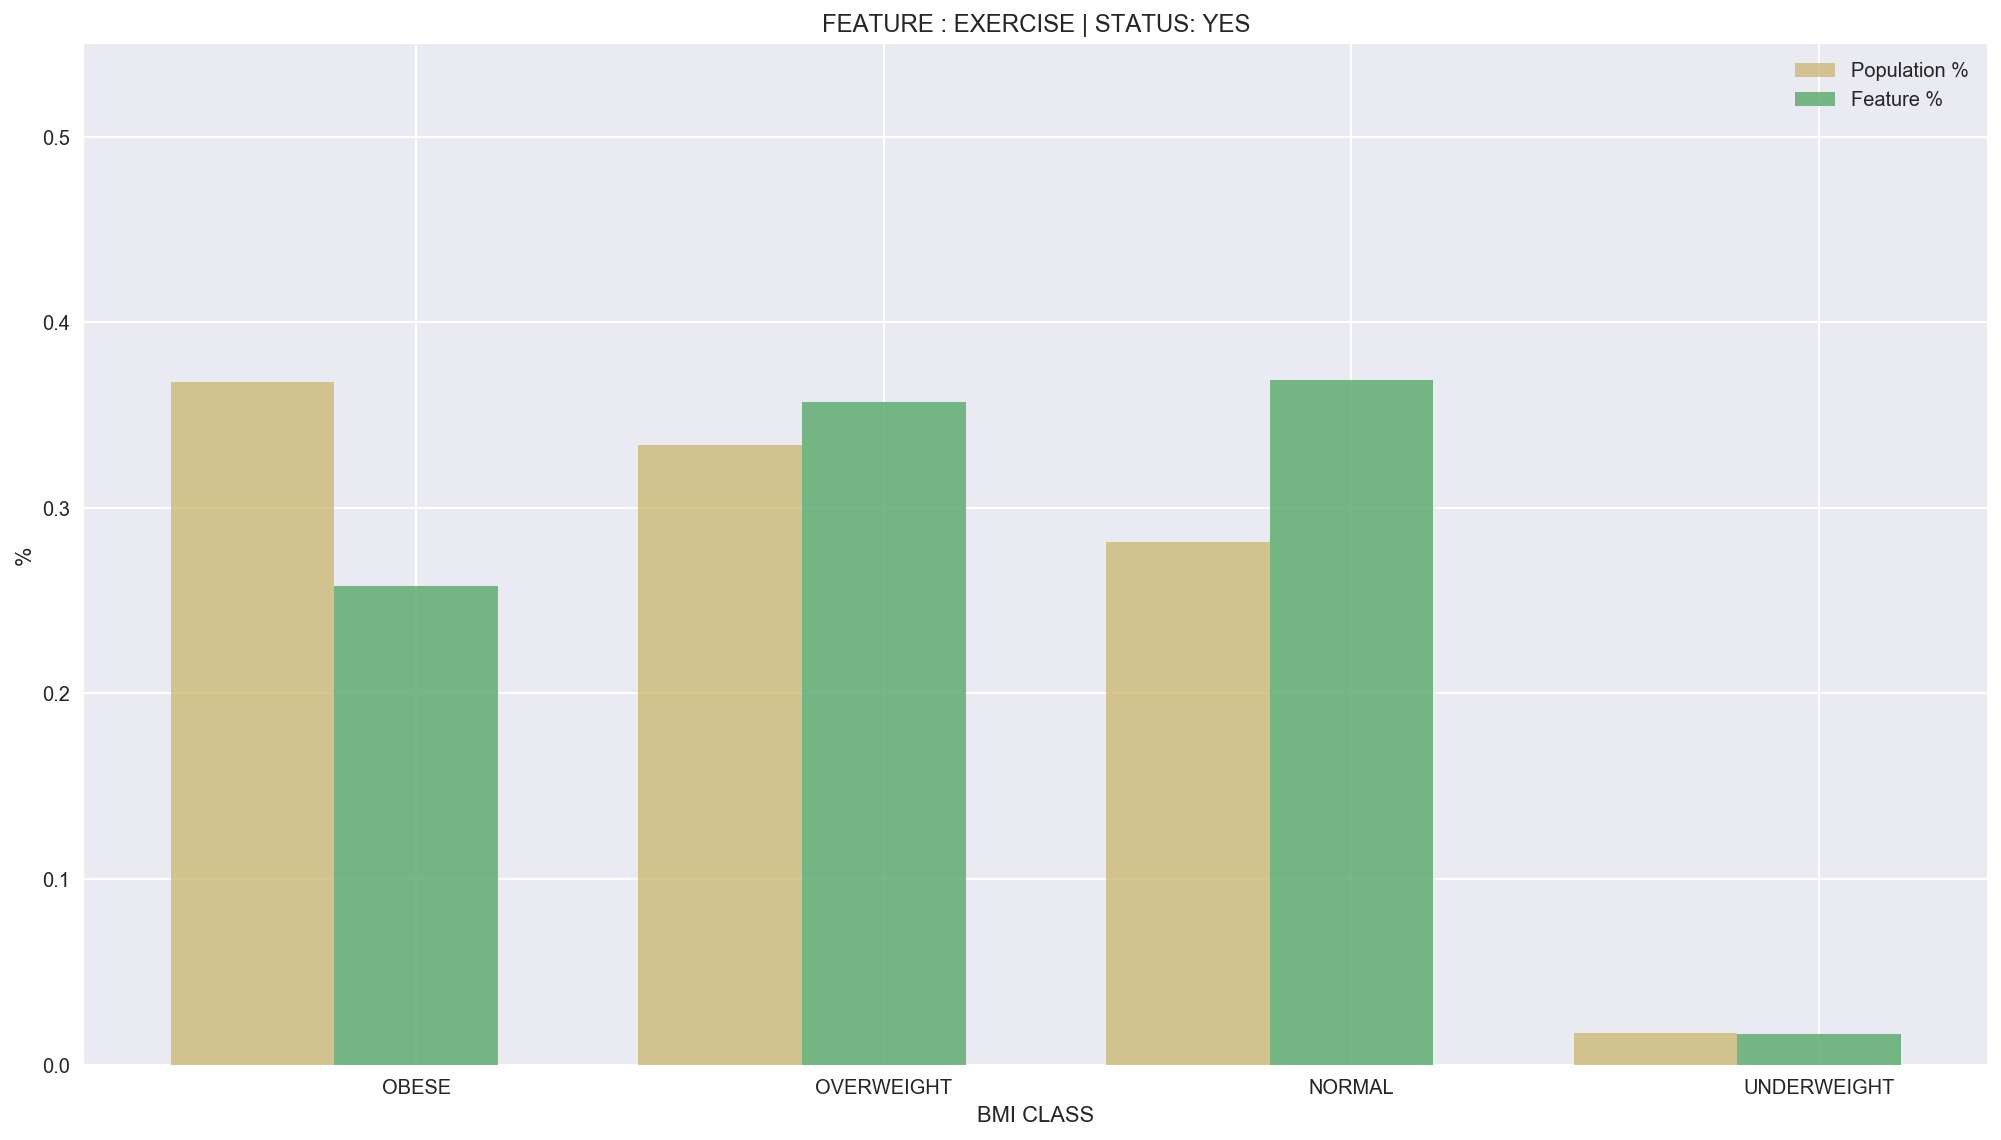

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     7579
EXERCISE 2 OBESE 	 2788 	 36.7858556538 %    OFF :10.9727701179
EXERCISE 2 OVER 	 2527 	 33.3421295685 %    OFF :-2.37270019762
EXERCISE 2 NORMAL 	 2136 	 28.1831376171 %    OFF :-8.66658437239
EXERCISE 2 UNDER 	 128 	 1.68887716058 %    OFF :0.0665144520674



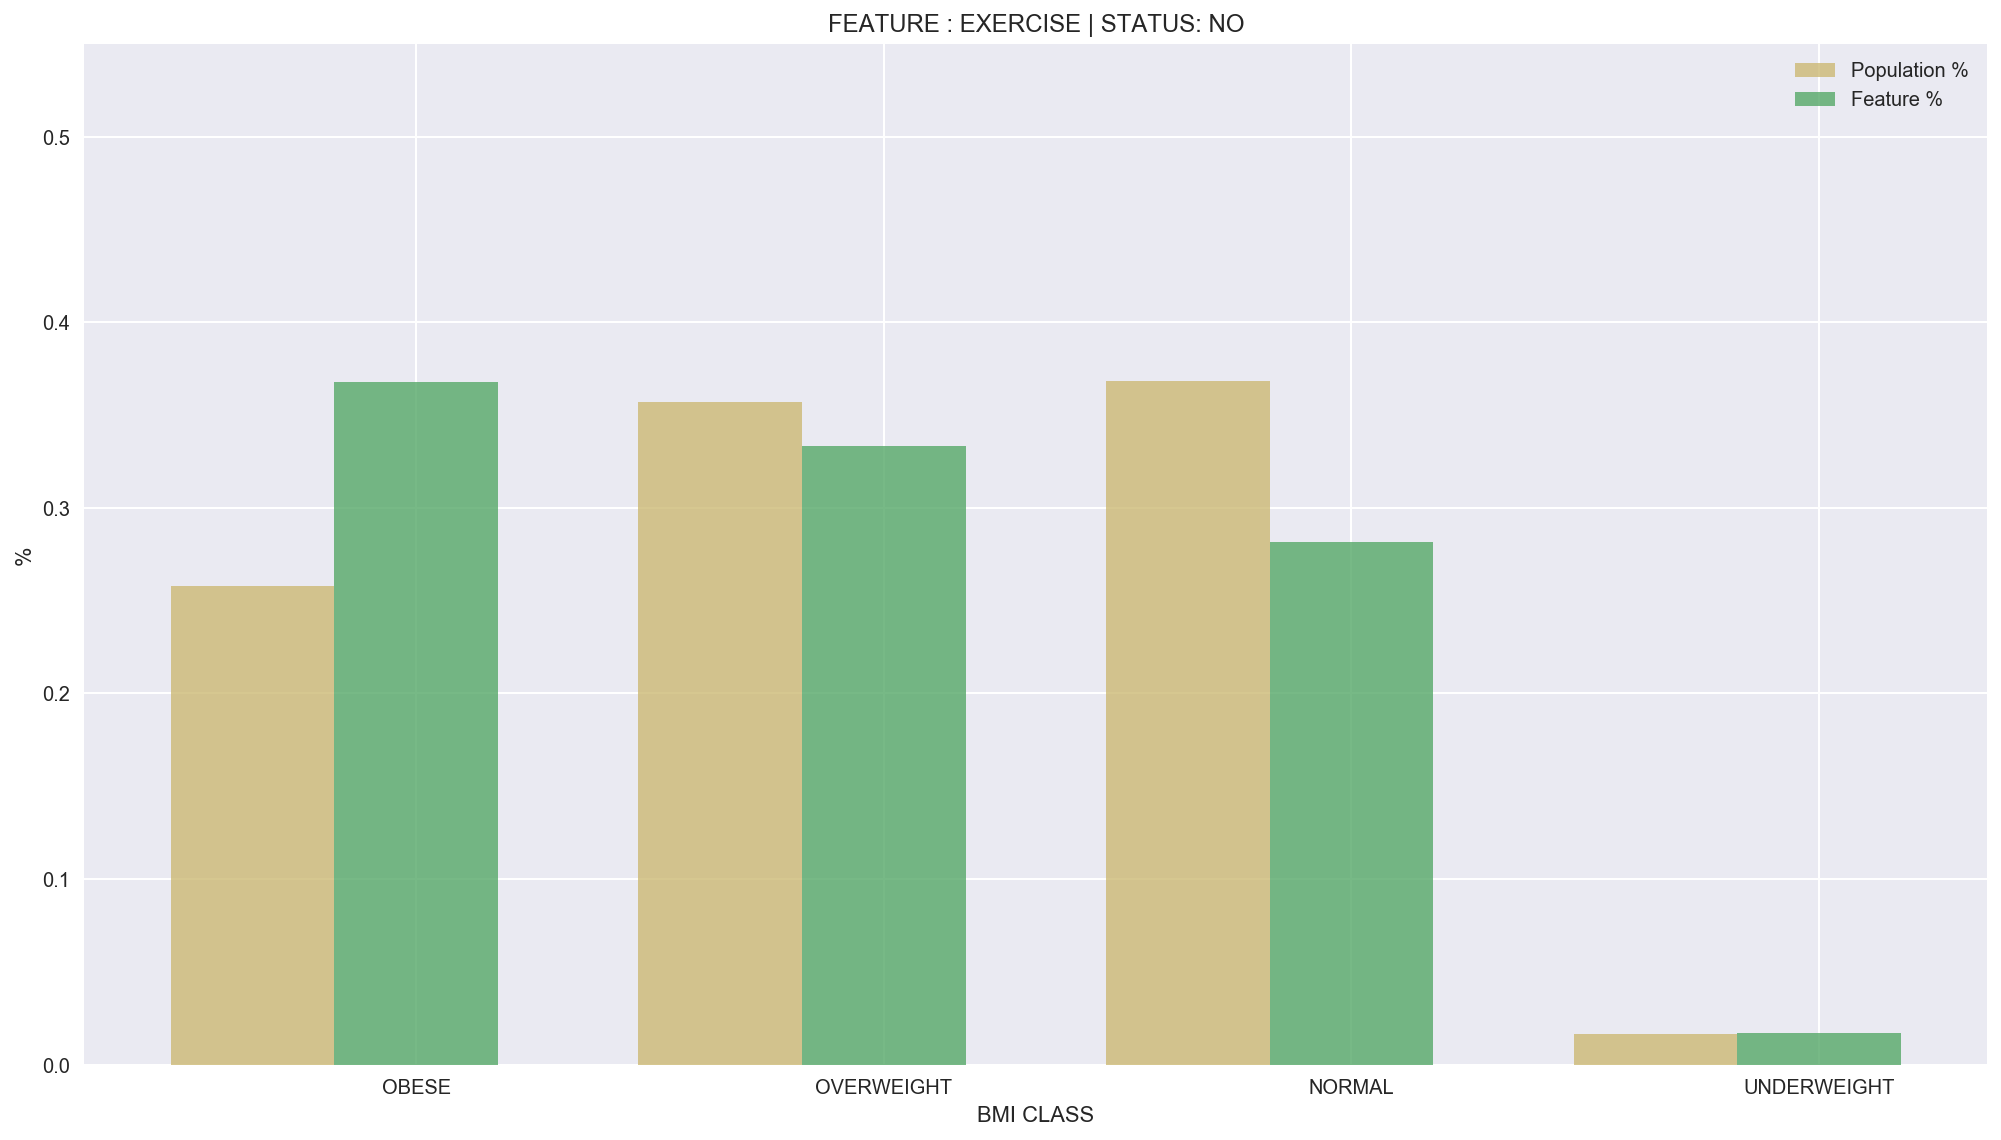

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     12743
FOODSHOP 1 OBESE 	 3883 	 30.471631484 %    OFF :1.67062708973
FOODSHOP 1 OVER 	 4340 	 34.0579141489 %    OFF :-2.05005823021
FOODSHOP 1 NORMAL 	 4331 	 33.987287138 %    OFF :0.804612938413
FOODSHOP 1 UNDER 	 189 	 1.48316722907 %    OFF :-0.425181797926



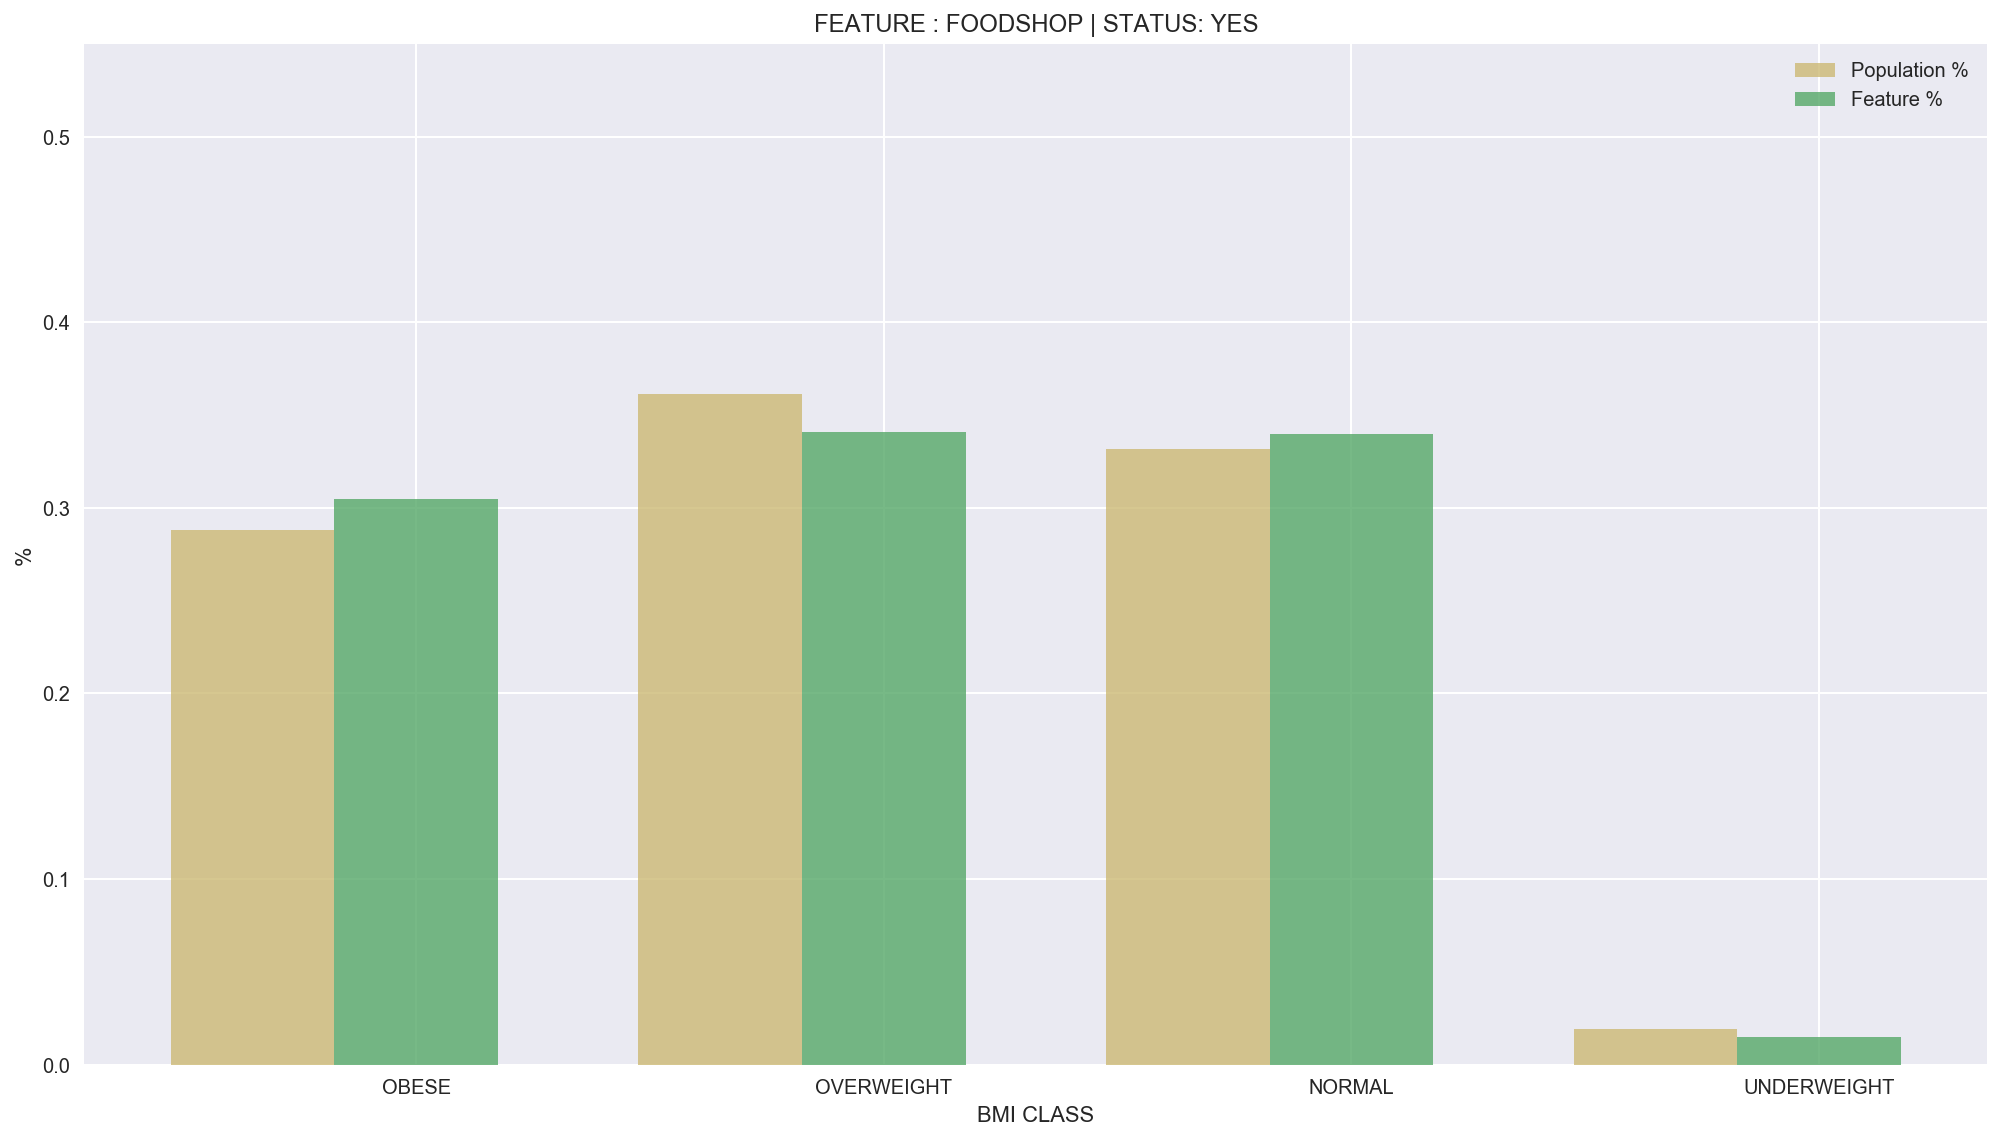

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     5533
FOODSHOP 2 OBESE 	 1562 	 28.2306163022 %    OFF :-2.18124531231
FOODSHOP 2 OVER 	 1979 	 35.7672148925 %    OFF :1.25650649049
FOODSHOP 2 NORMAL 	 1866 	 33.7249231881 %    OFF :0.0642971584898
FOODSHOP 2 UNDER 	 126 	 2.27724561721 %    OFF :0.860441663334



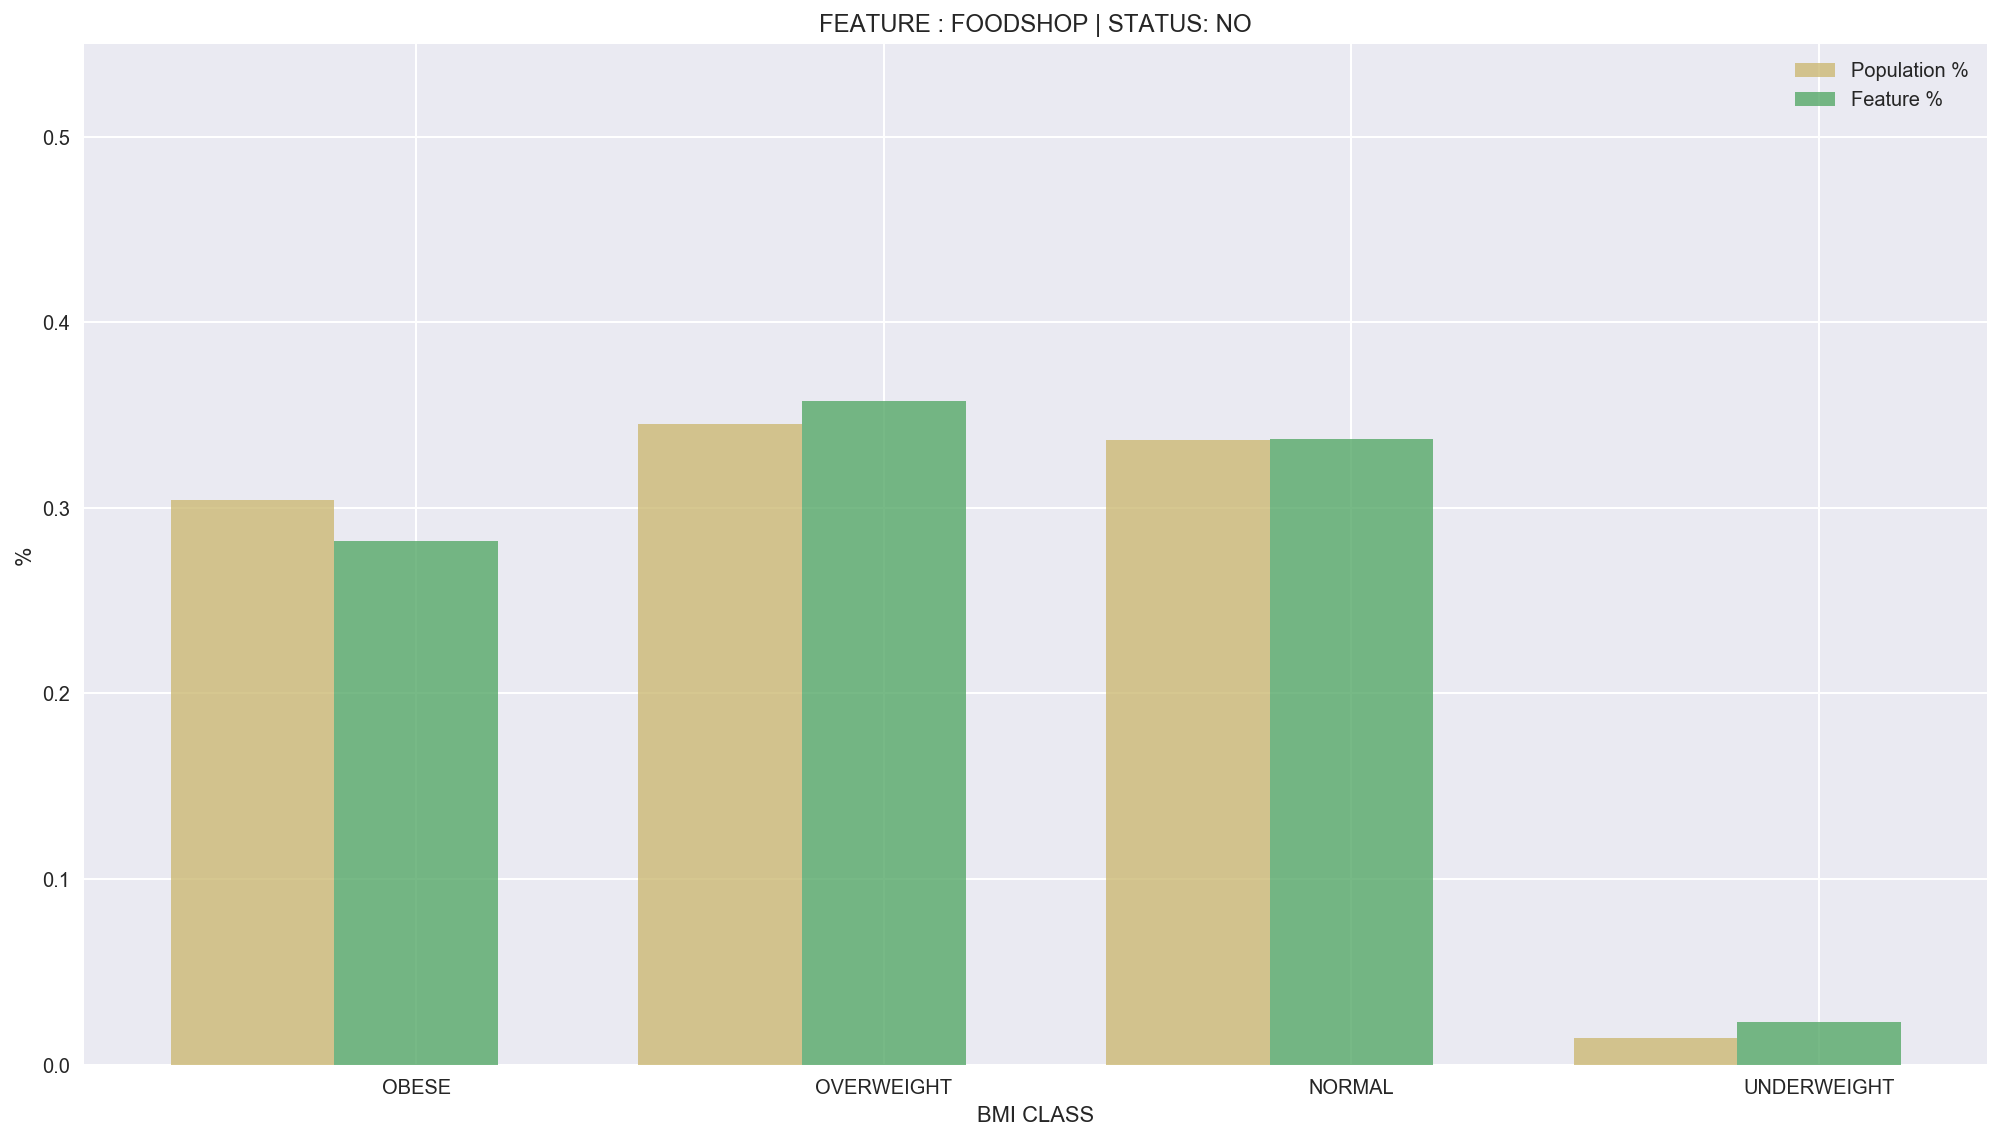

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     2427
FOODSHOP 3 OBESE 	 732 	 30.1606922126 %    OFF :0.375669511443
FOODSHOP 3 OVER 	 893 	 36.7943963741 %    OFF :2.2065729509
FOODSHOP 3 NORMAL 	 776 	 31.9736299959 %    OFF :-1.93042339288
FOODSHOP 3 UNDER 	 26 	 1.07128141739 %    OFF :-0.651819069457



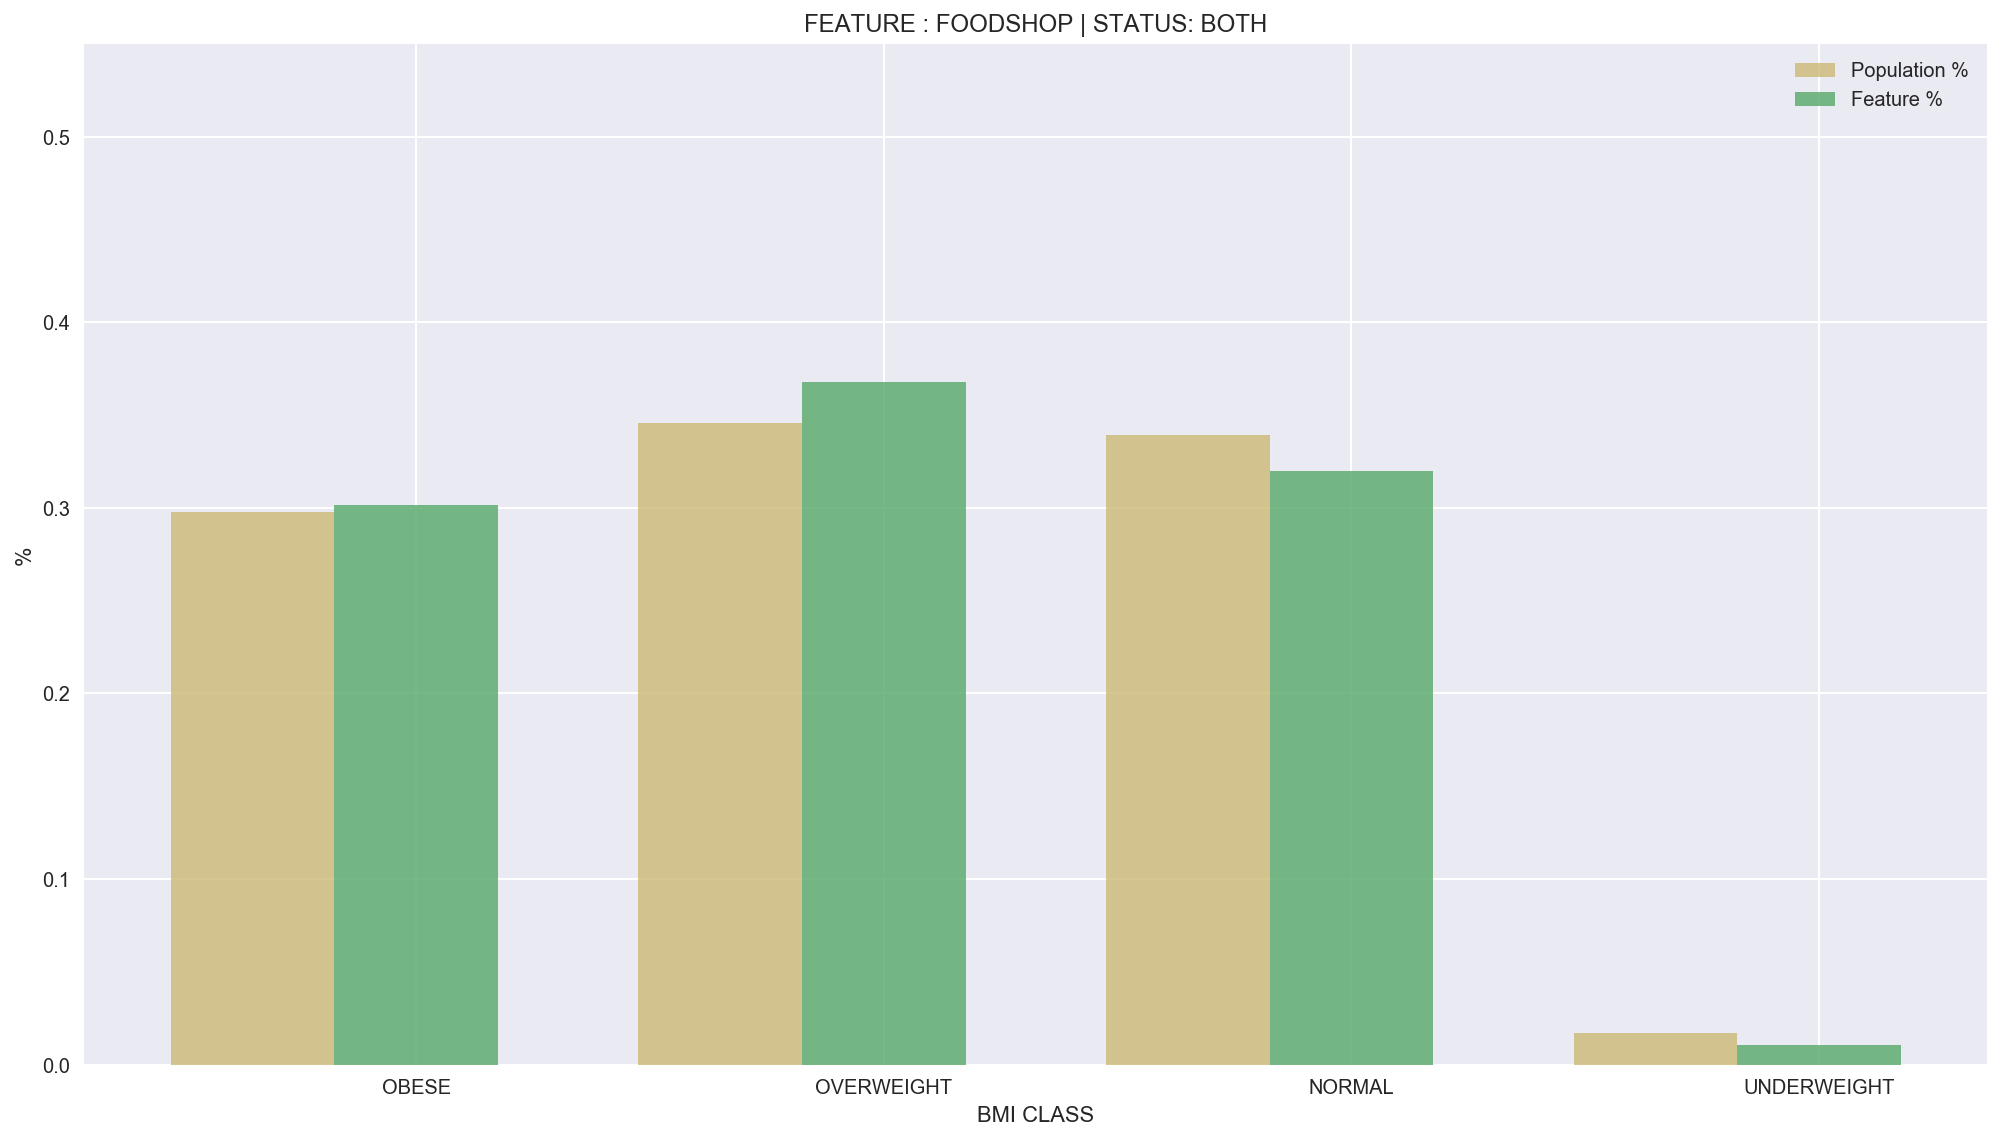

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     12866
MEALPREP 1 OBESE 	 3915 	 30.429037774 %    OFF :1.58435529502
MEALPREP 1 OVER 	 4399 	 34.1908907197 %    OFF :-1.73106796428
MEALPREP 1 NORMAL 	 4361 	 33.8955386289 %    OFF :0.574957144629
MEALPREP 1 UNDER 	 191 	 1.48453287735 %    OFF :-0.428244475365



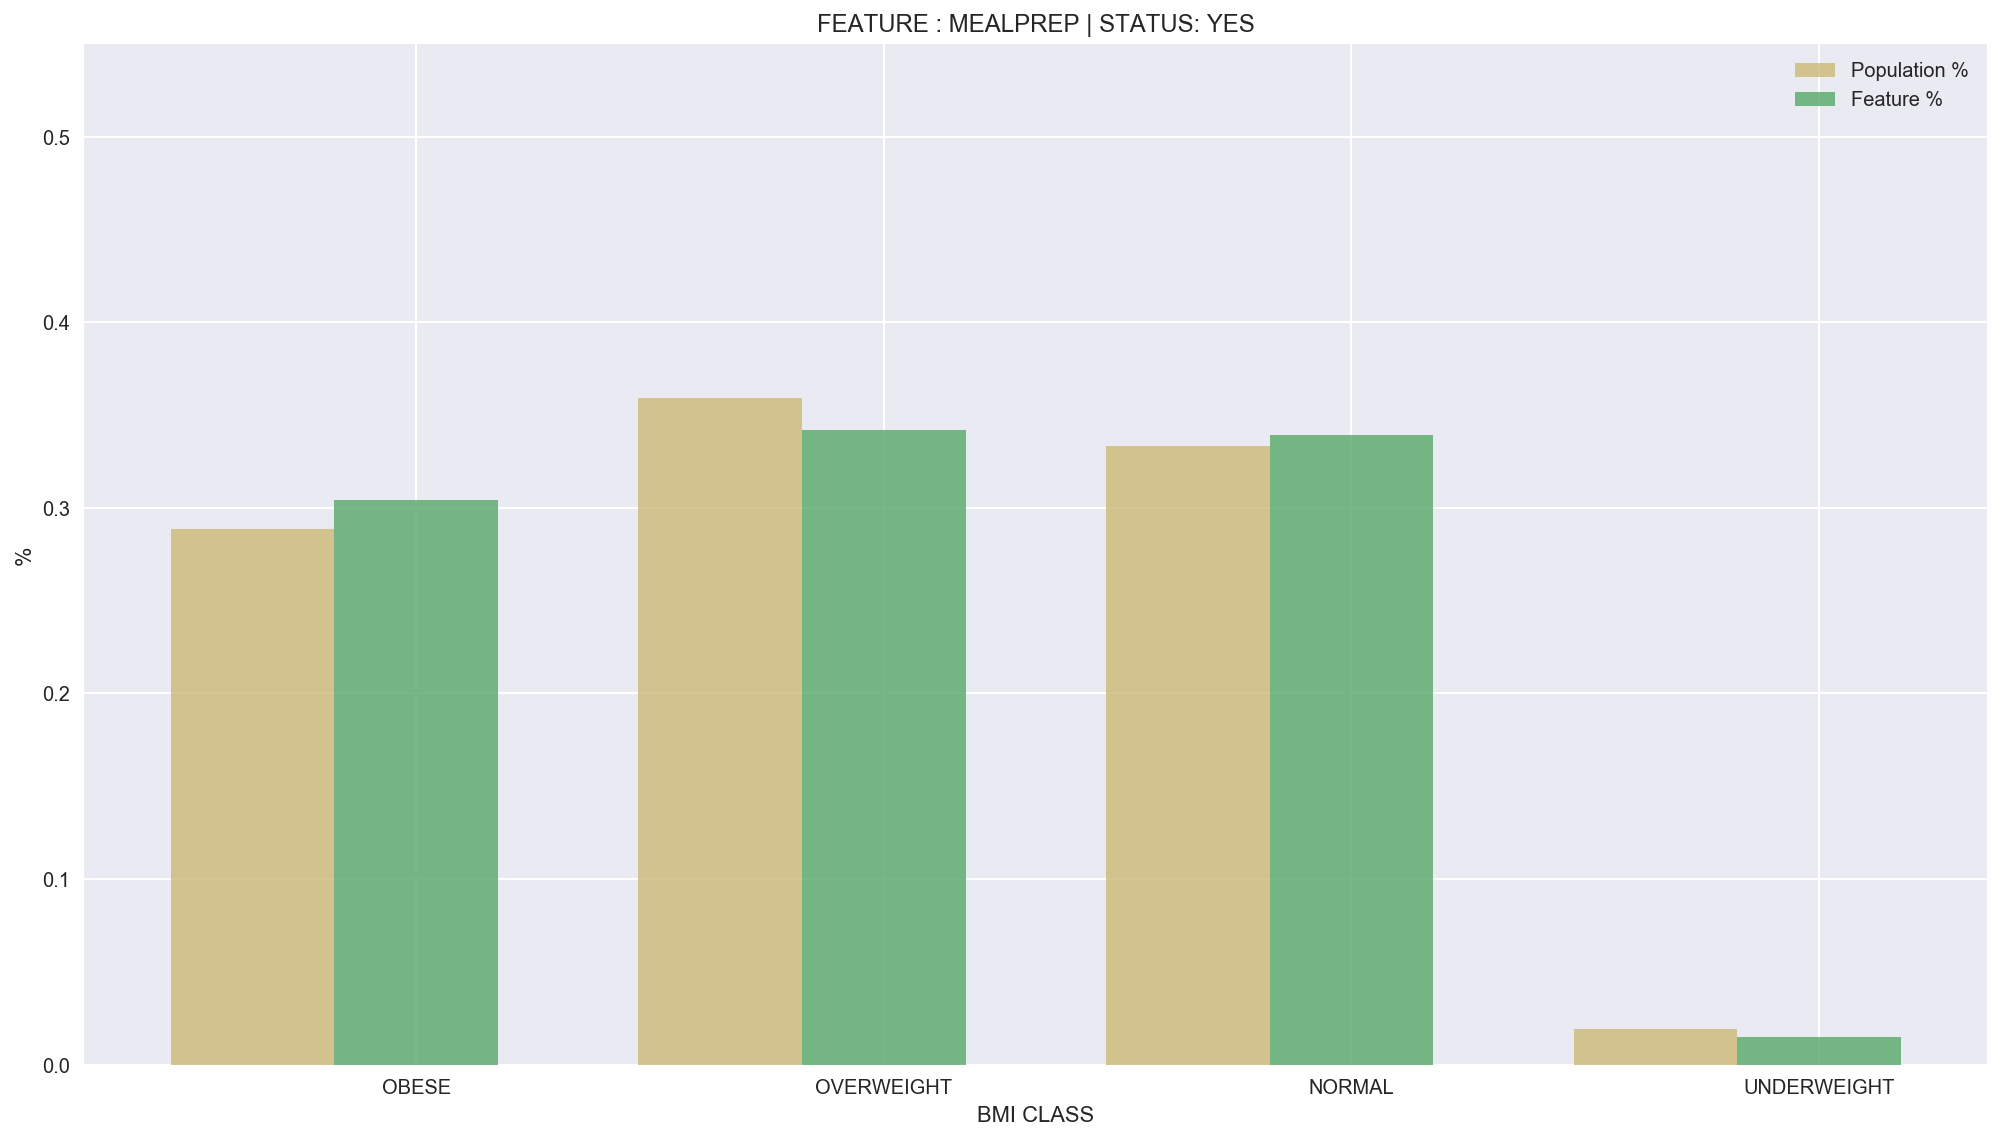

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     5793
MEALPREP 2 OBESE 	 1639 	 28.2927671327 %    OFF :-2.13297876065
MEALPREP 2 OVER 	 2073 	 35.7845675816 %    OFF :1.30250254636
MEALPREP 2 NORMAL 	 1964 	 33.9029863629 %    OFF :0.312641072875
MEALPREP 2 UNDER 	 117 	 2.01967892284 %    OFF :0.51783514141



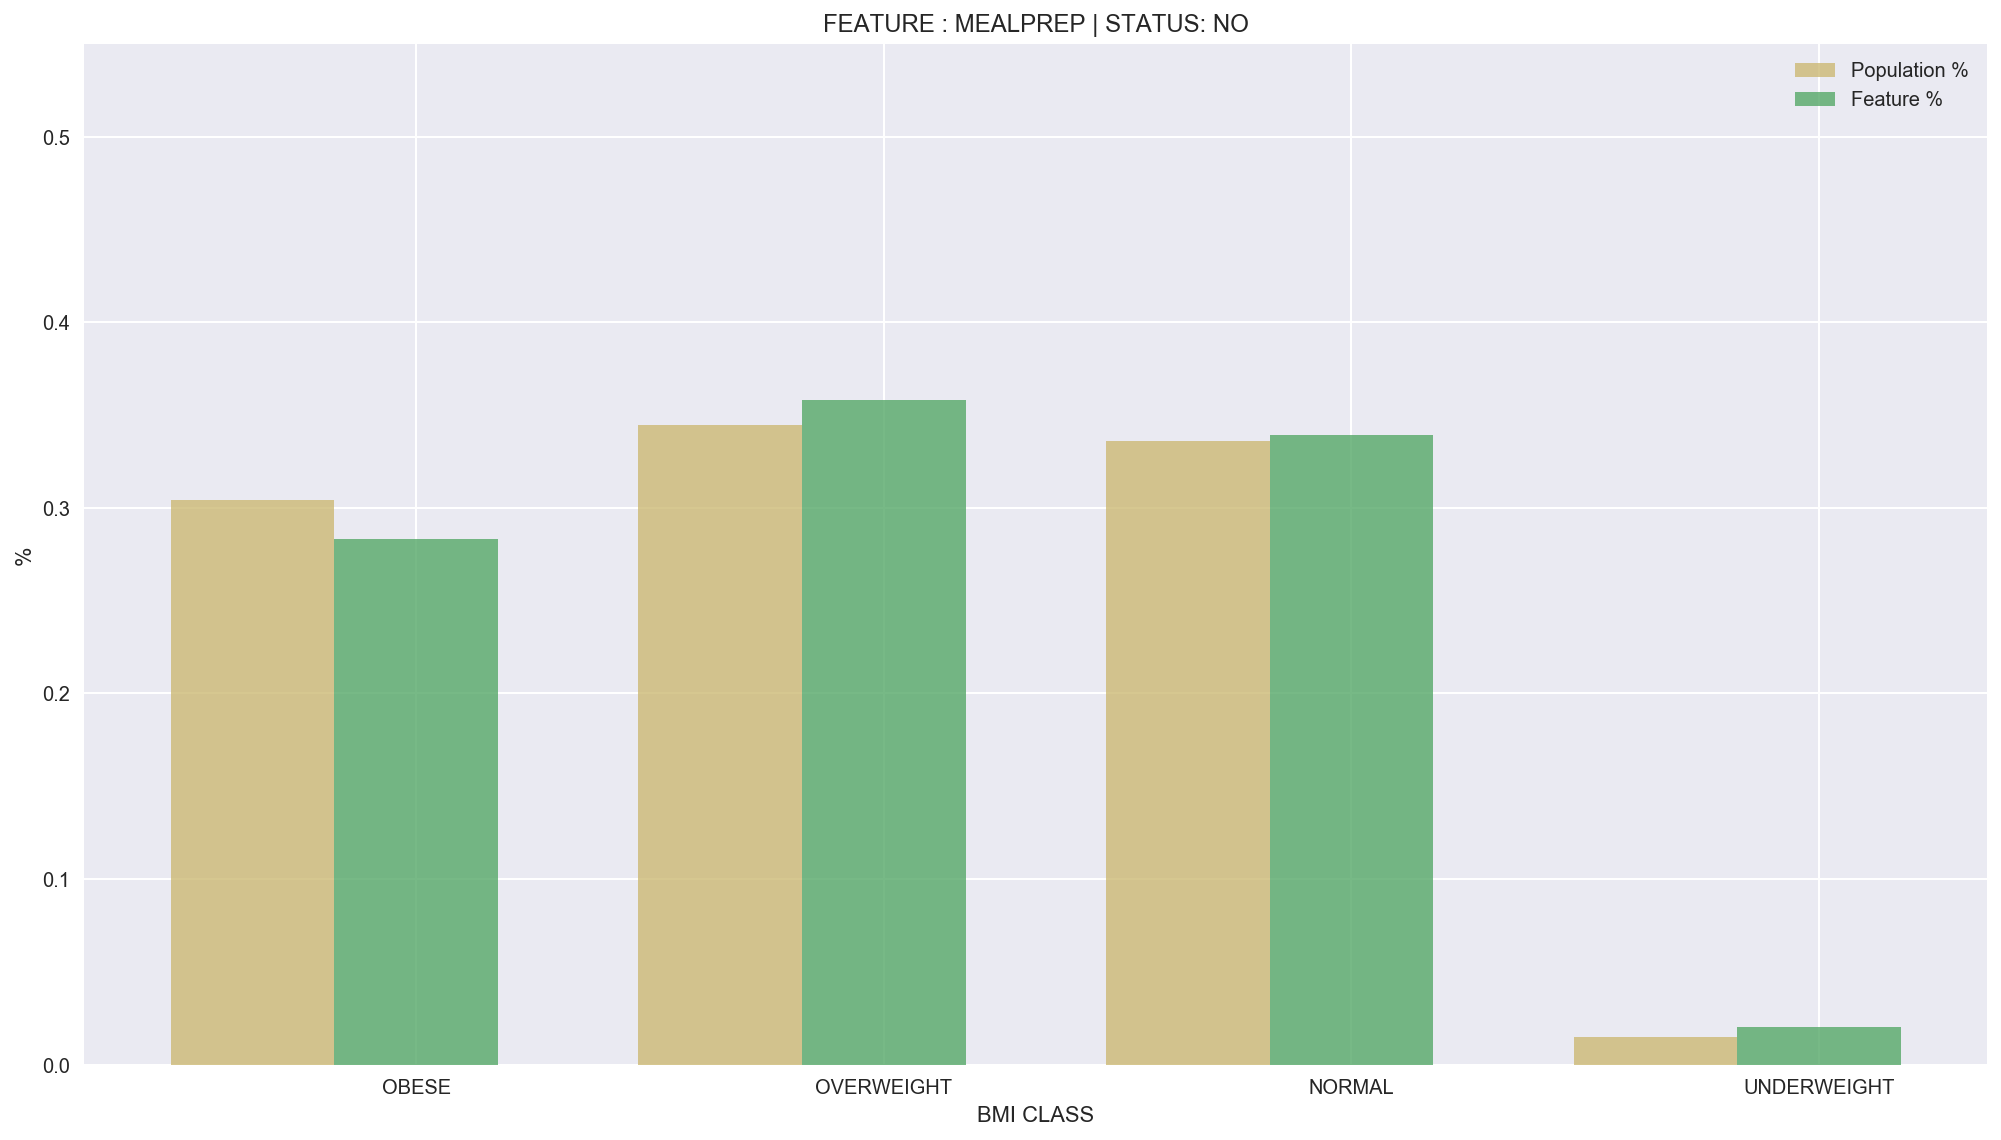

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     2045
MEALPREP 3 OBESE 	 621 	 30.3667481663 %    OFF :0.596614747195
MEALPREP 3 OVER 	 743 	 36.3325183374 %    OFF :1.6489197734
MEALPREP 3 NORMAL 	 648 	 31.6870415648 %    OFF :-2.20890228132
MEALPREP 3 UNDER 	 33 	 1.61369193154 %    OFF :-0.0366322392789



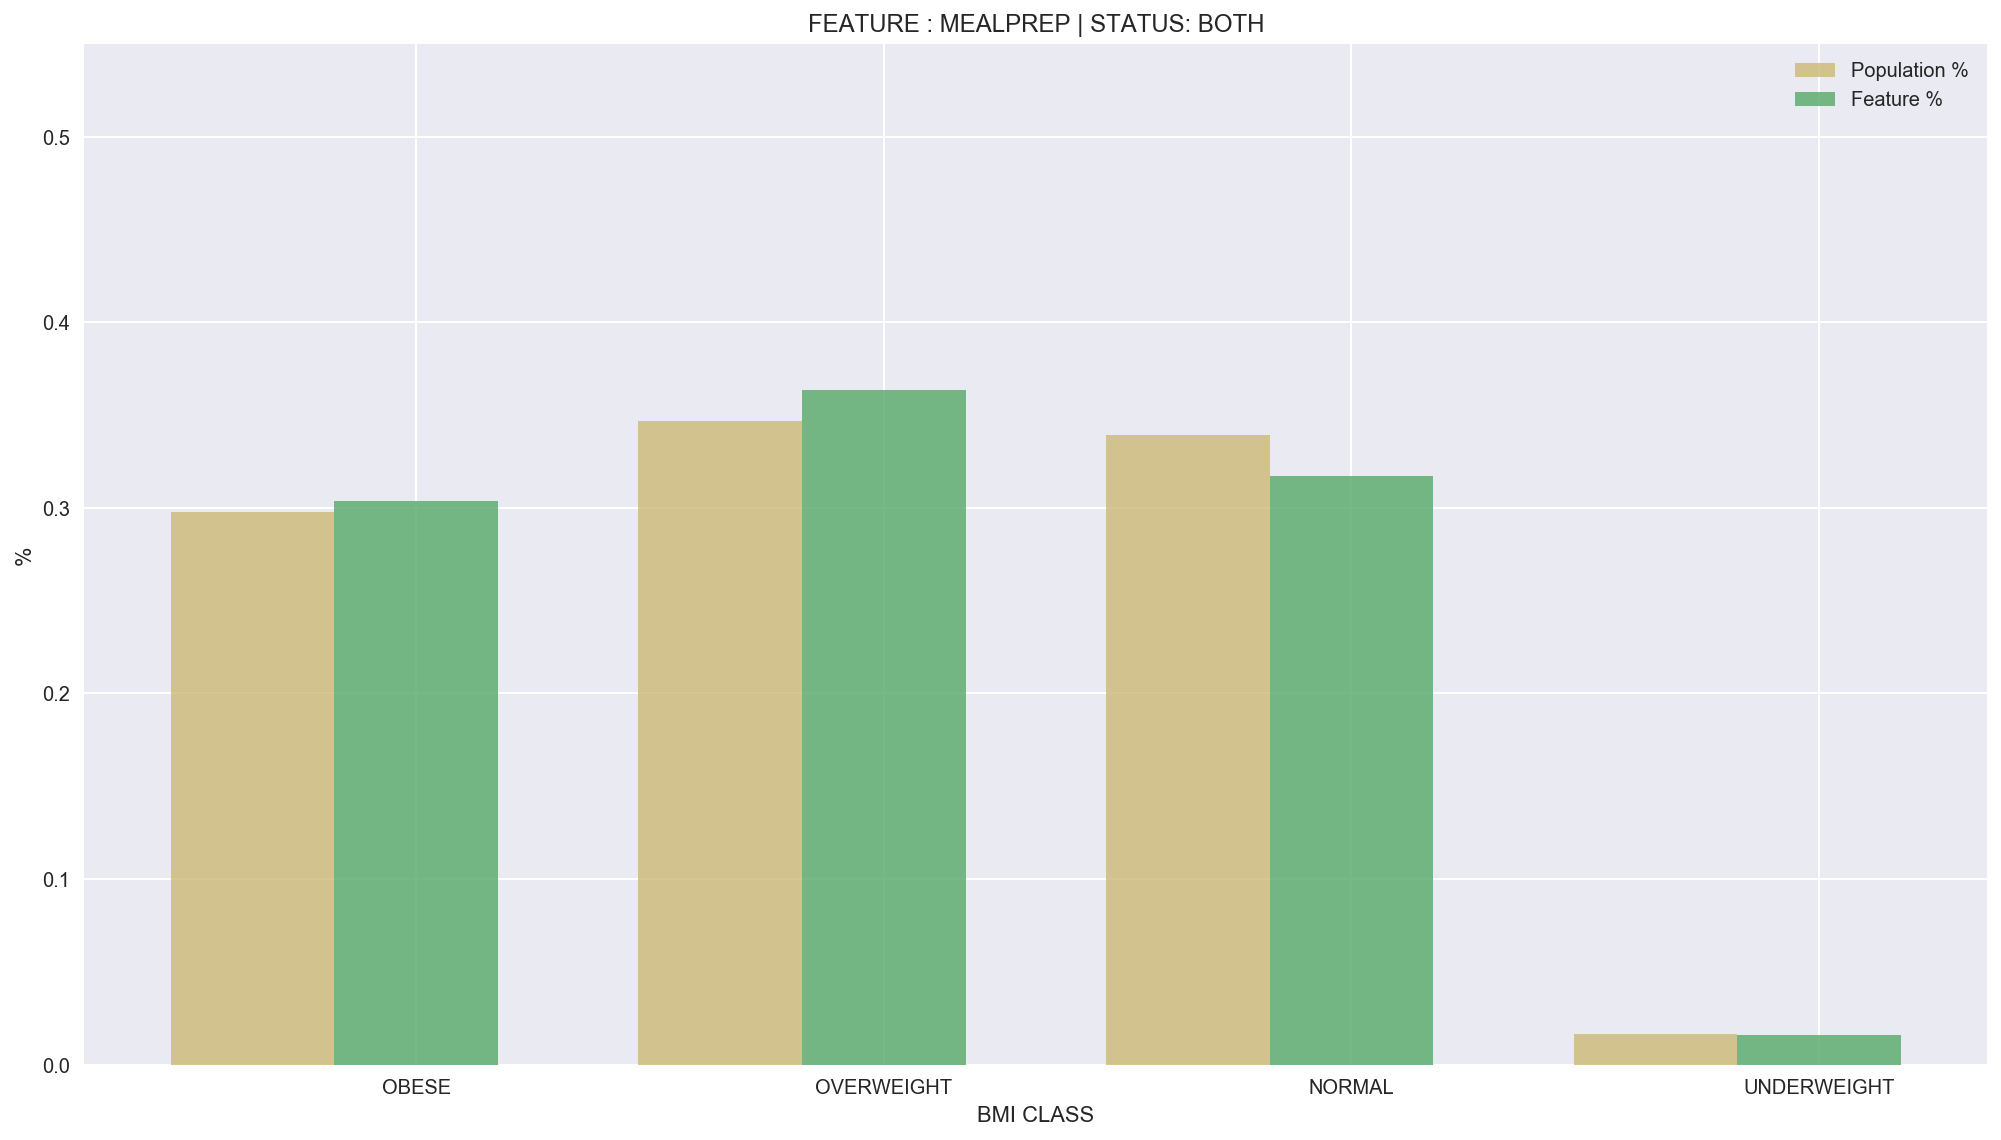

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     1995
DIETSODA 1 OBESE 	 798 	 40.0 %    OFF :11.2552770801
DIETSODA 1 OVER 	 702 	 35.1879699248 %    OFF :0.377944808583
DIETSODA 1 NORMAL 	 479 	 24.0100250627 %    OFF :-10.6984663604
DIETSODA 1 UNDER 	 16 	 0.802005012531 %    OFF :-0.934755528269



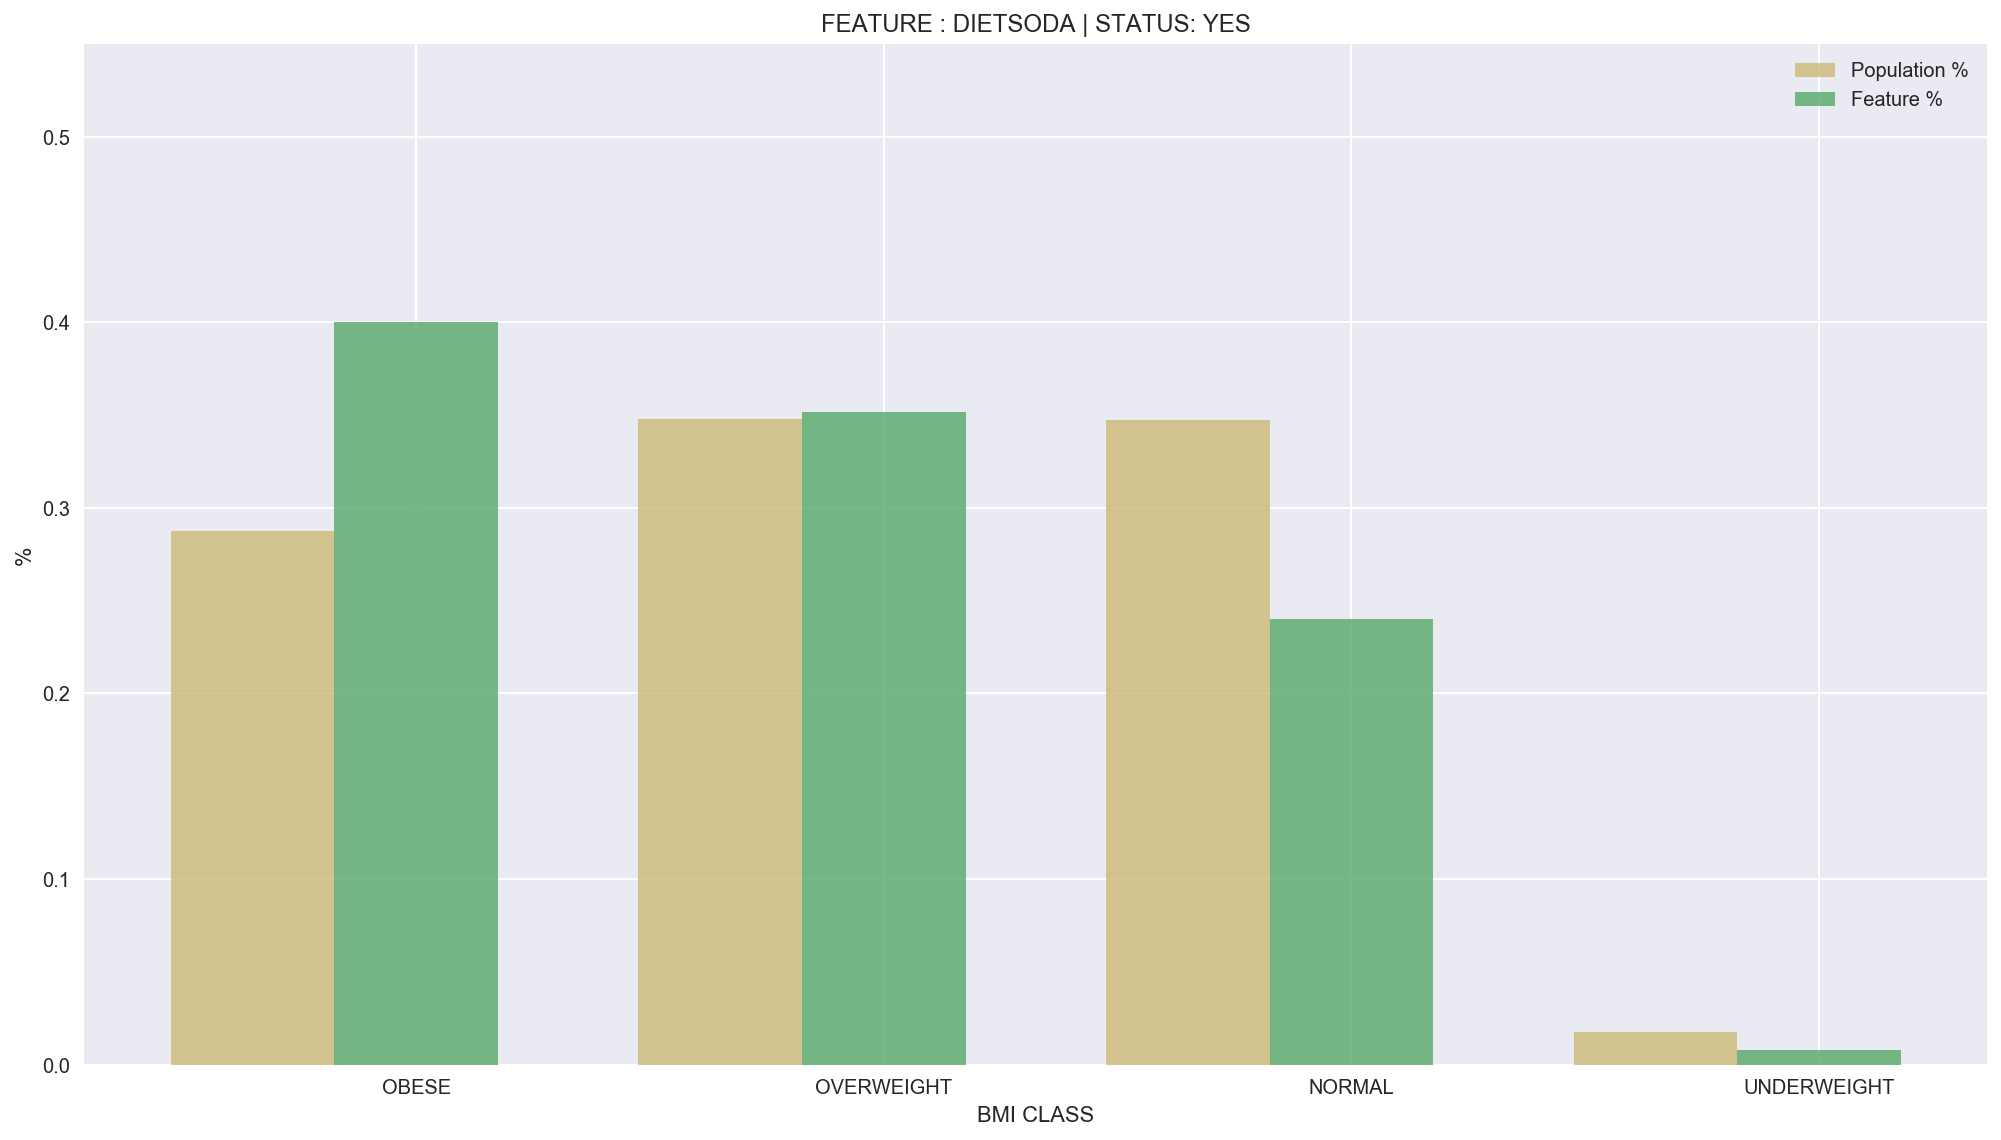

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     3159
DIETSODA 2 OBESE 	 1018 	 32.2253877809 %    OFF :2.82770130308
DIETSODA 2 OVER 	 1045 	 33.0800886356 %    OFF :-2.08430819608
DIETSODA 2 NORMAL 	 1032 	 32.6685660019 %    OFF :-1.1909131707
DIETSODA 2 UNDER 	 64 	 2.02595758151 %    OFF :0.447520063706



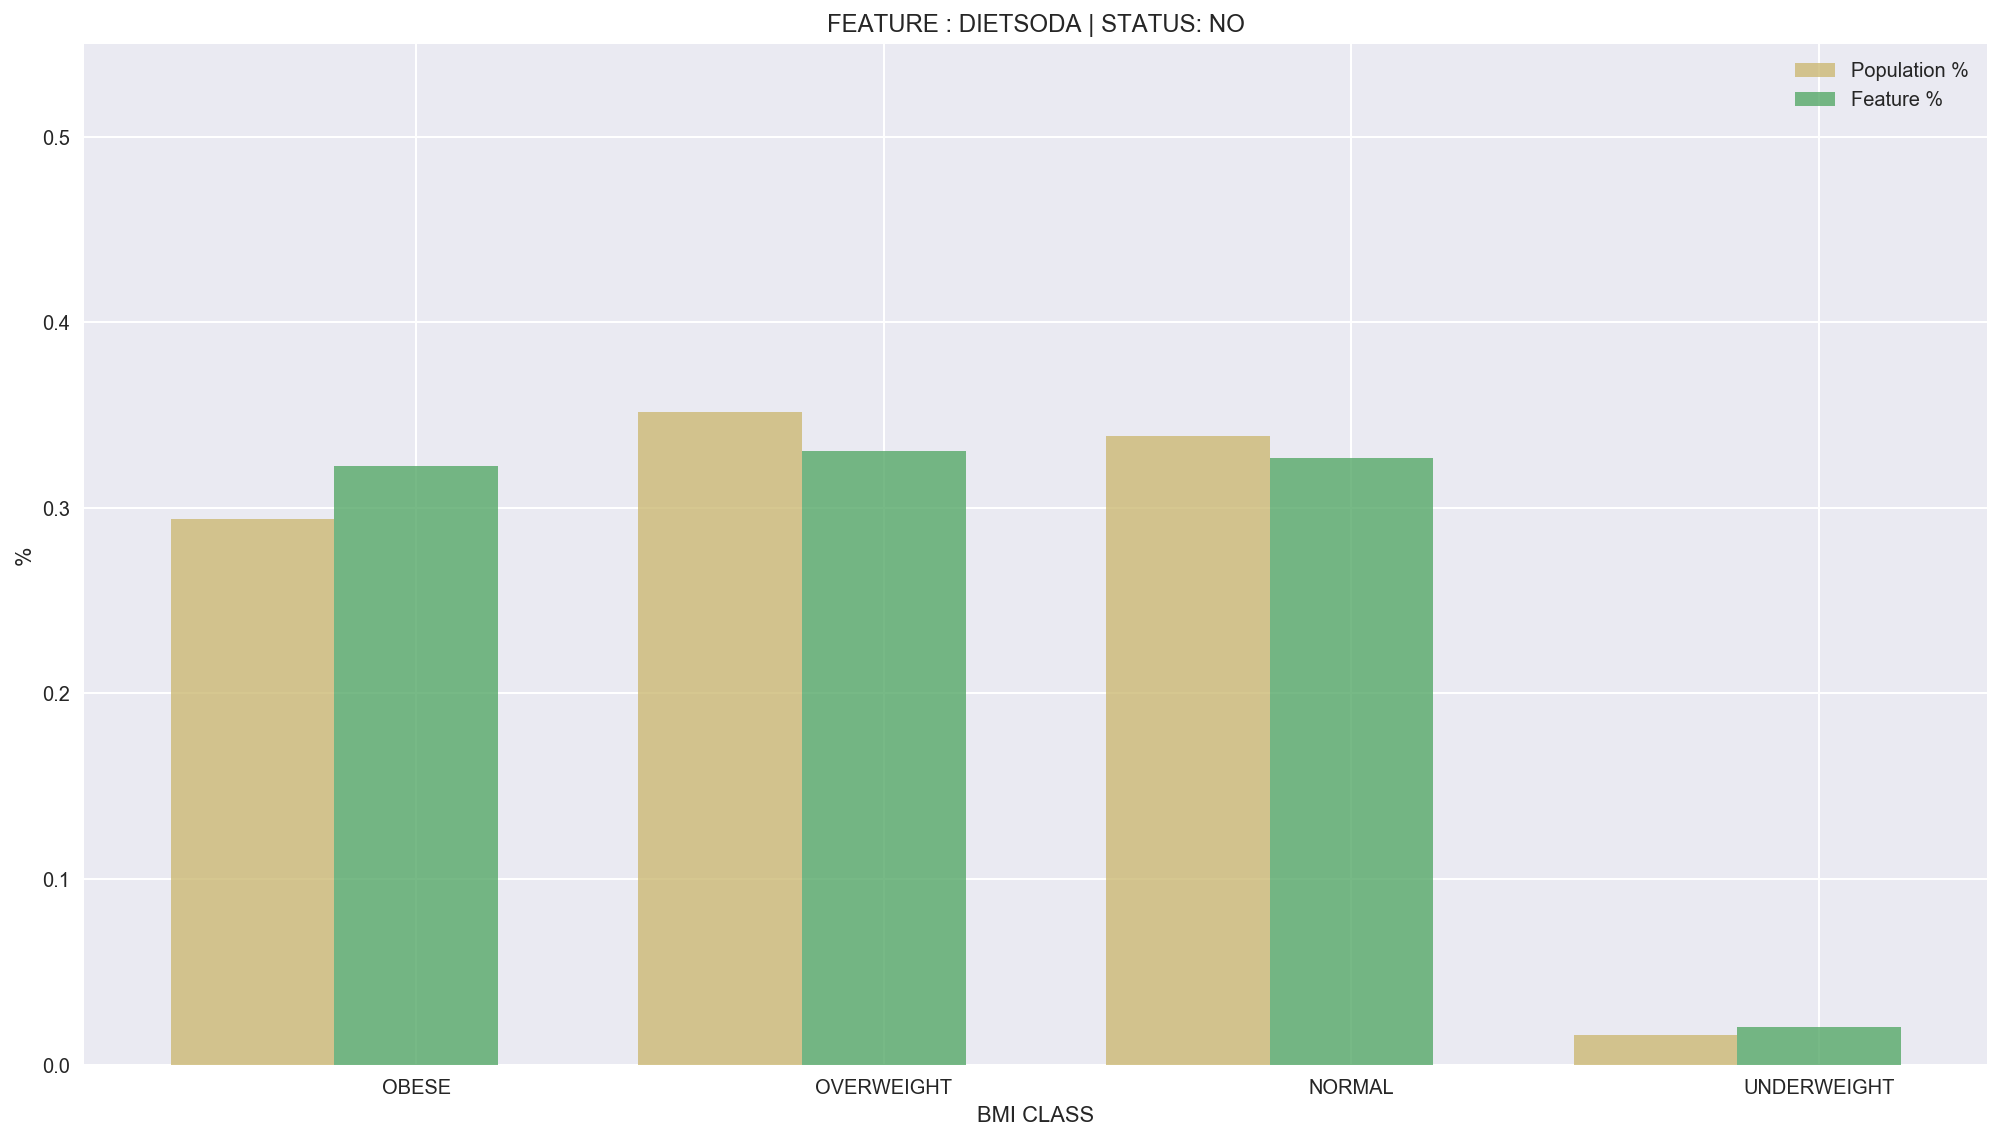

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     139
DIETSODA 3 OBESE 	 74 	 53.2374100719 %    OFF :23.5665461505
DIETSODA 3 OVER 	 35 	 25.1798561151 %    OFF :-9.73190430105
DIETSODA 3 NORMAL 	 30 	 21.5827338129 %    OFF :-12.176807244
DIETSODA 3 UNDER 	 0 	 0.0 %    OFF :-1.65783460547



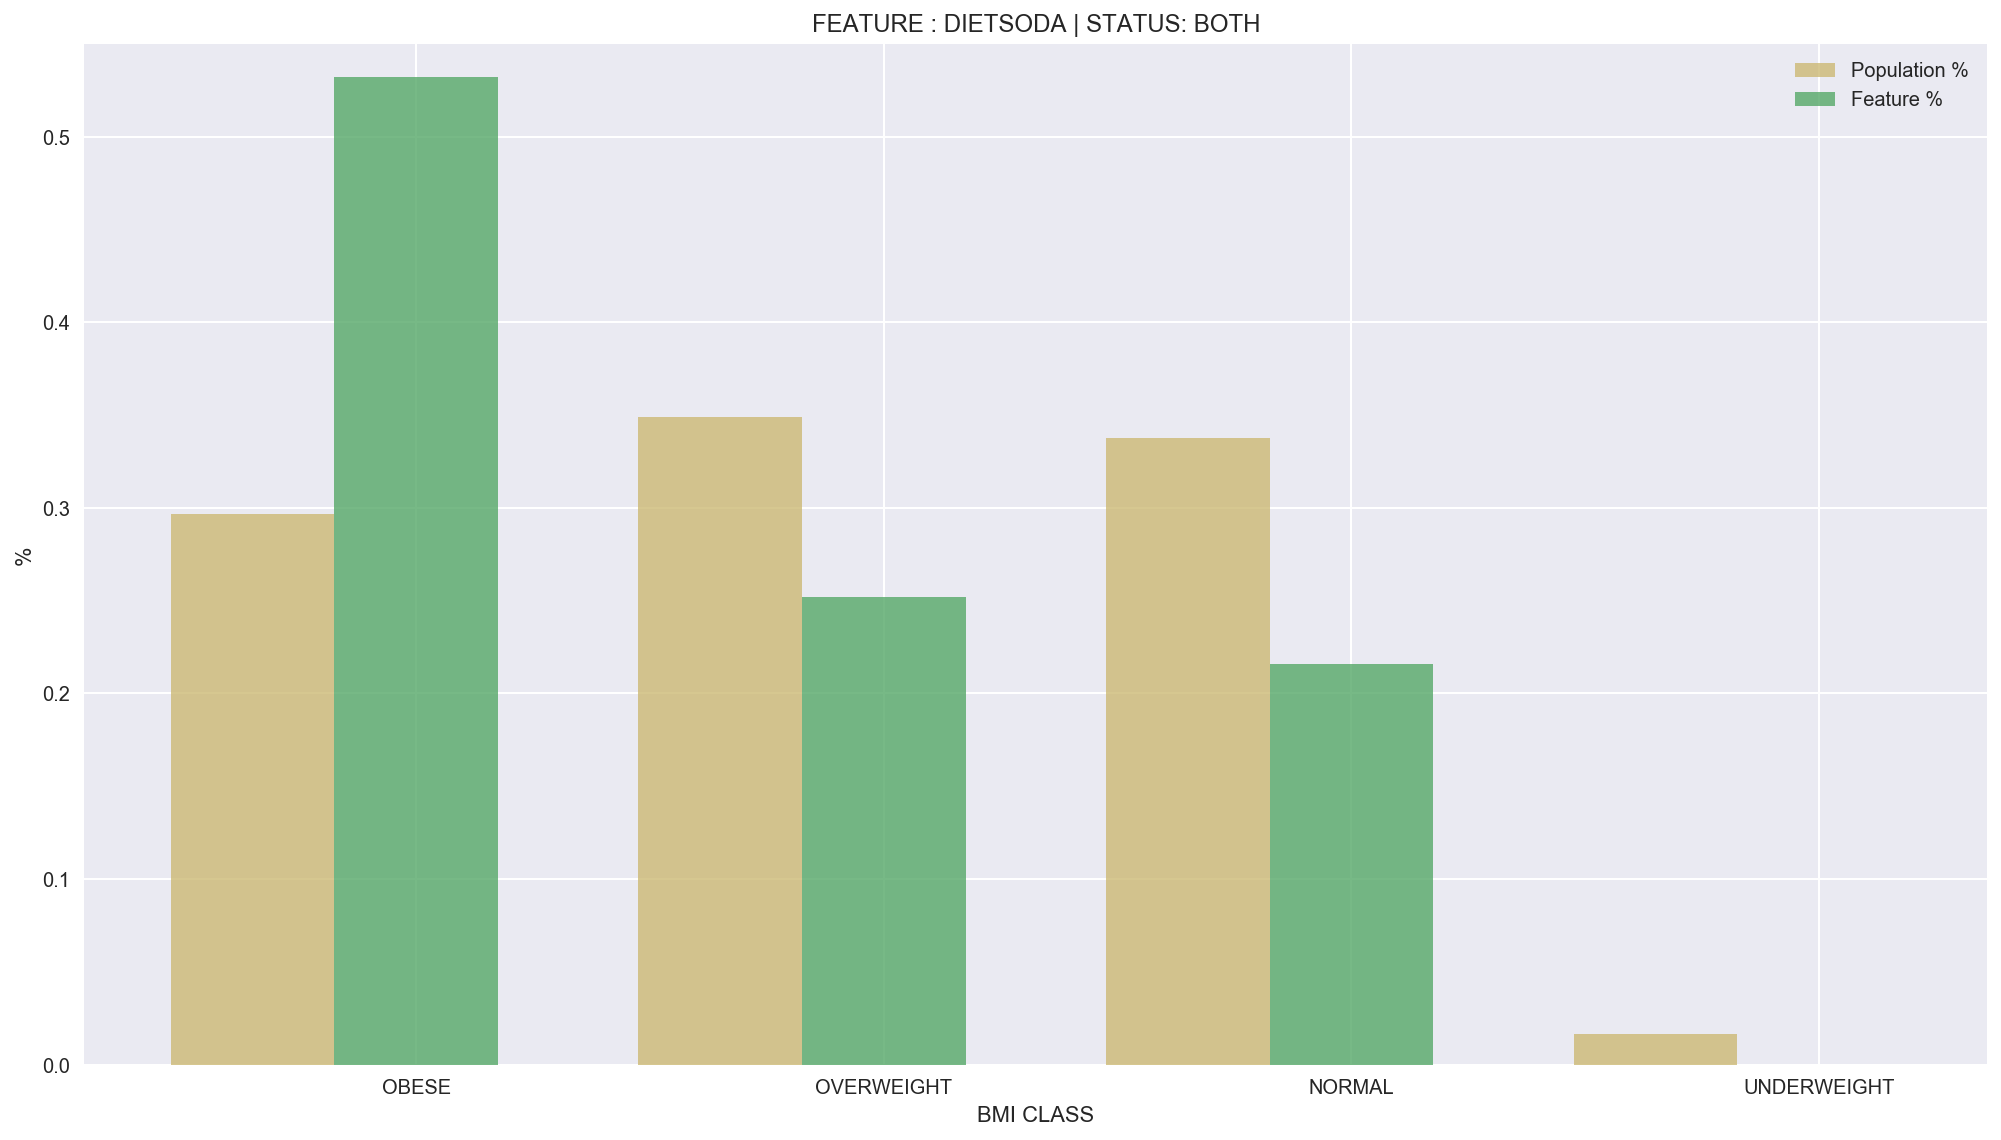

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     3740
GENHEALTH 1 OBESE 	 441 	 11.7914438503 %    OFF :-22.0133652021
GENHEALTH 1 OVER 	 1228 	 32.8342245989 %    OFF :-2.45573296825
GENHEALTH 1 NORMAL 	 1994 	 53.3155080214 %    OFF :23.9661445136
GENHEALTH 1 UNDER 	 77 	 2.05882352941 %    OFF :0.50295365671



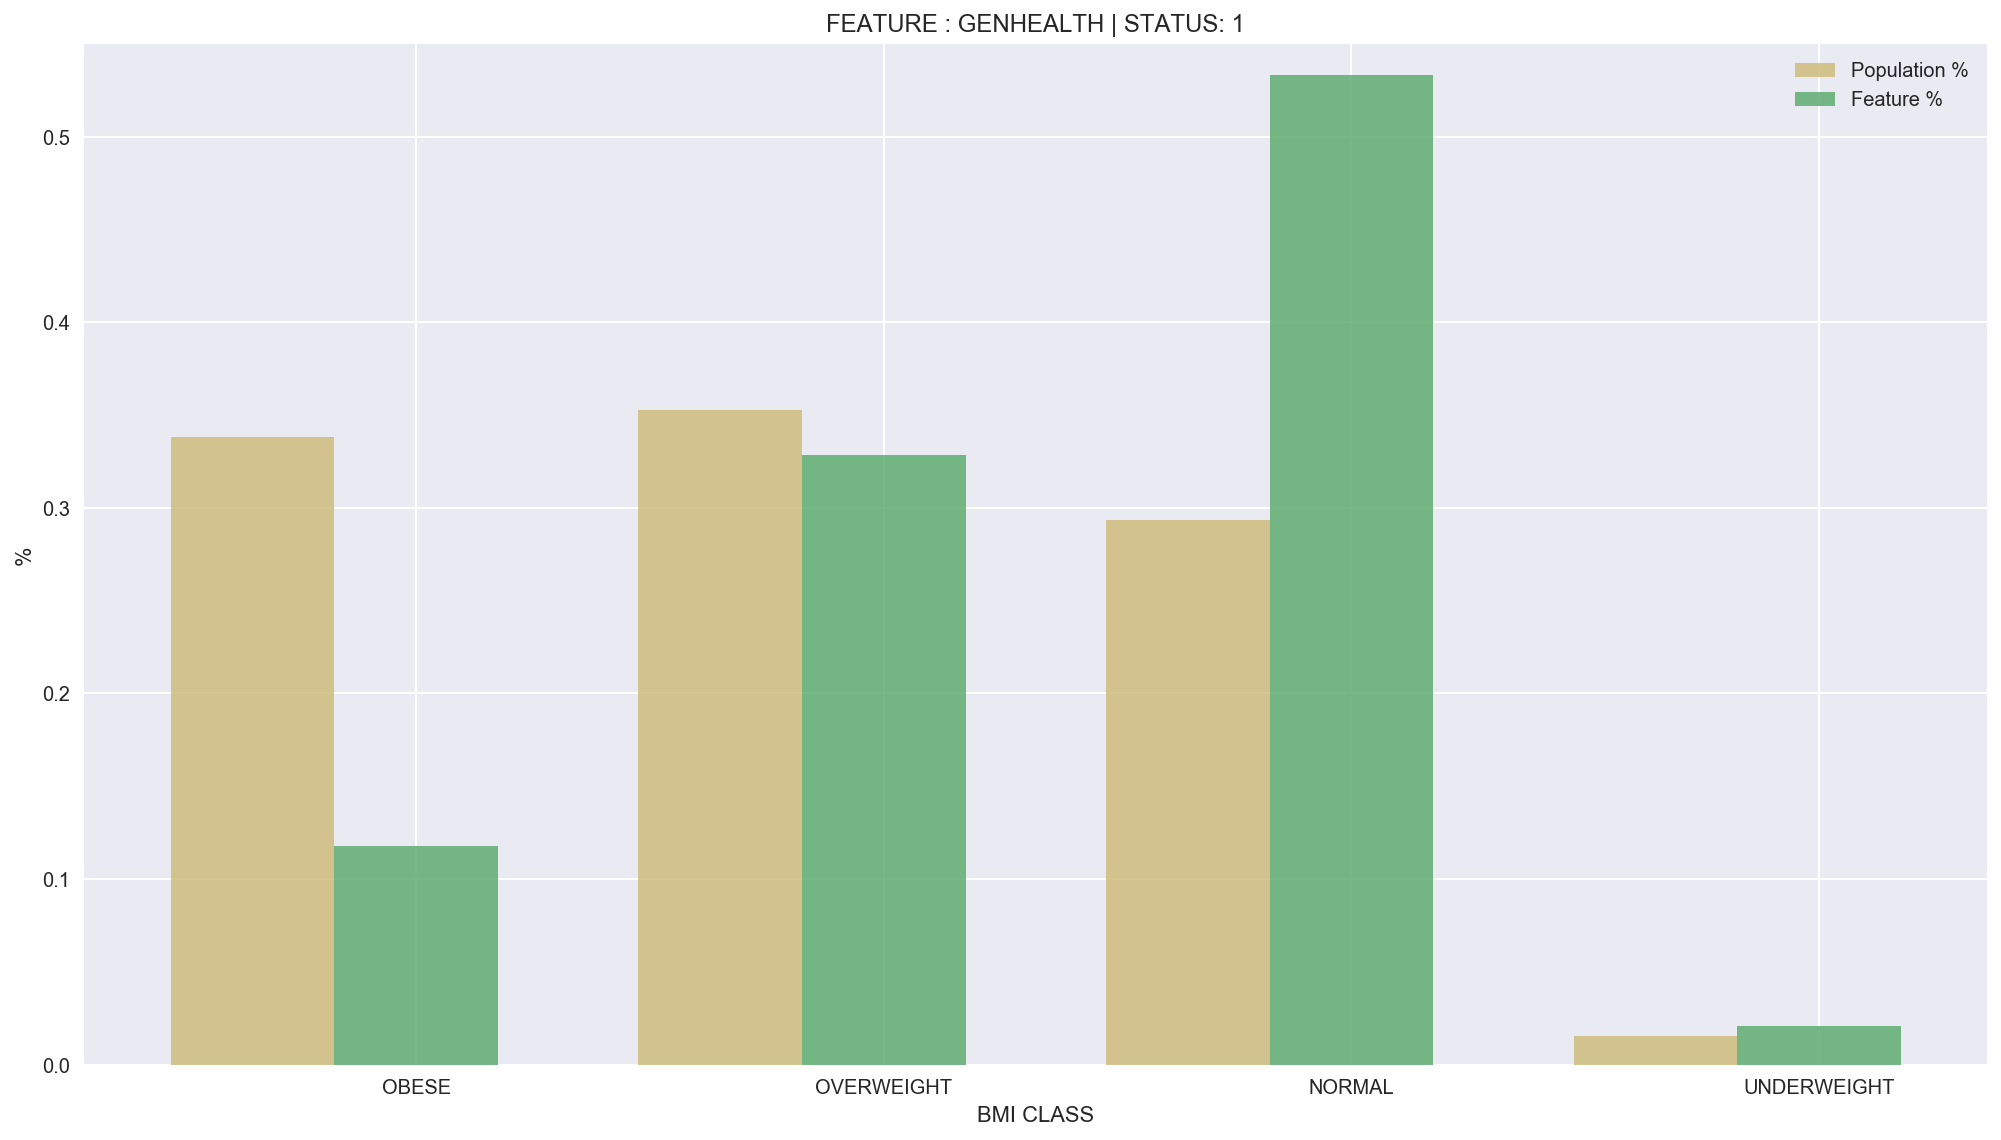

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     7054
GENHEALTH 2 OBESE 	 1558 	 22.0867592855 %    OFF :-11.7421553183
GENHEALTH 2 OVER 	 2776 	 39.3535582648 %    OFF :6.83561480502
GENHEALTH 2 NORMAL 	 2609 	 36.9861071732 %    OFF :5.01745329891
GENHEALTH 2 UNDER 	 111 	 1.57357527644 %    OFF :-0.110912785667



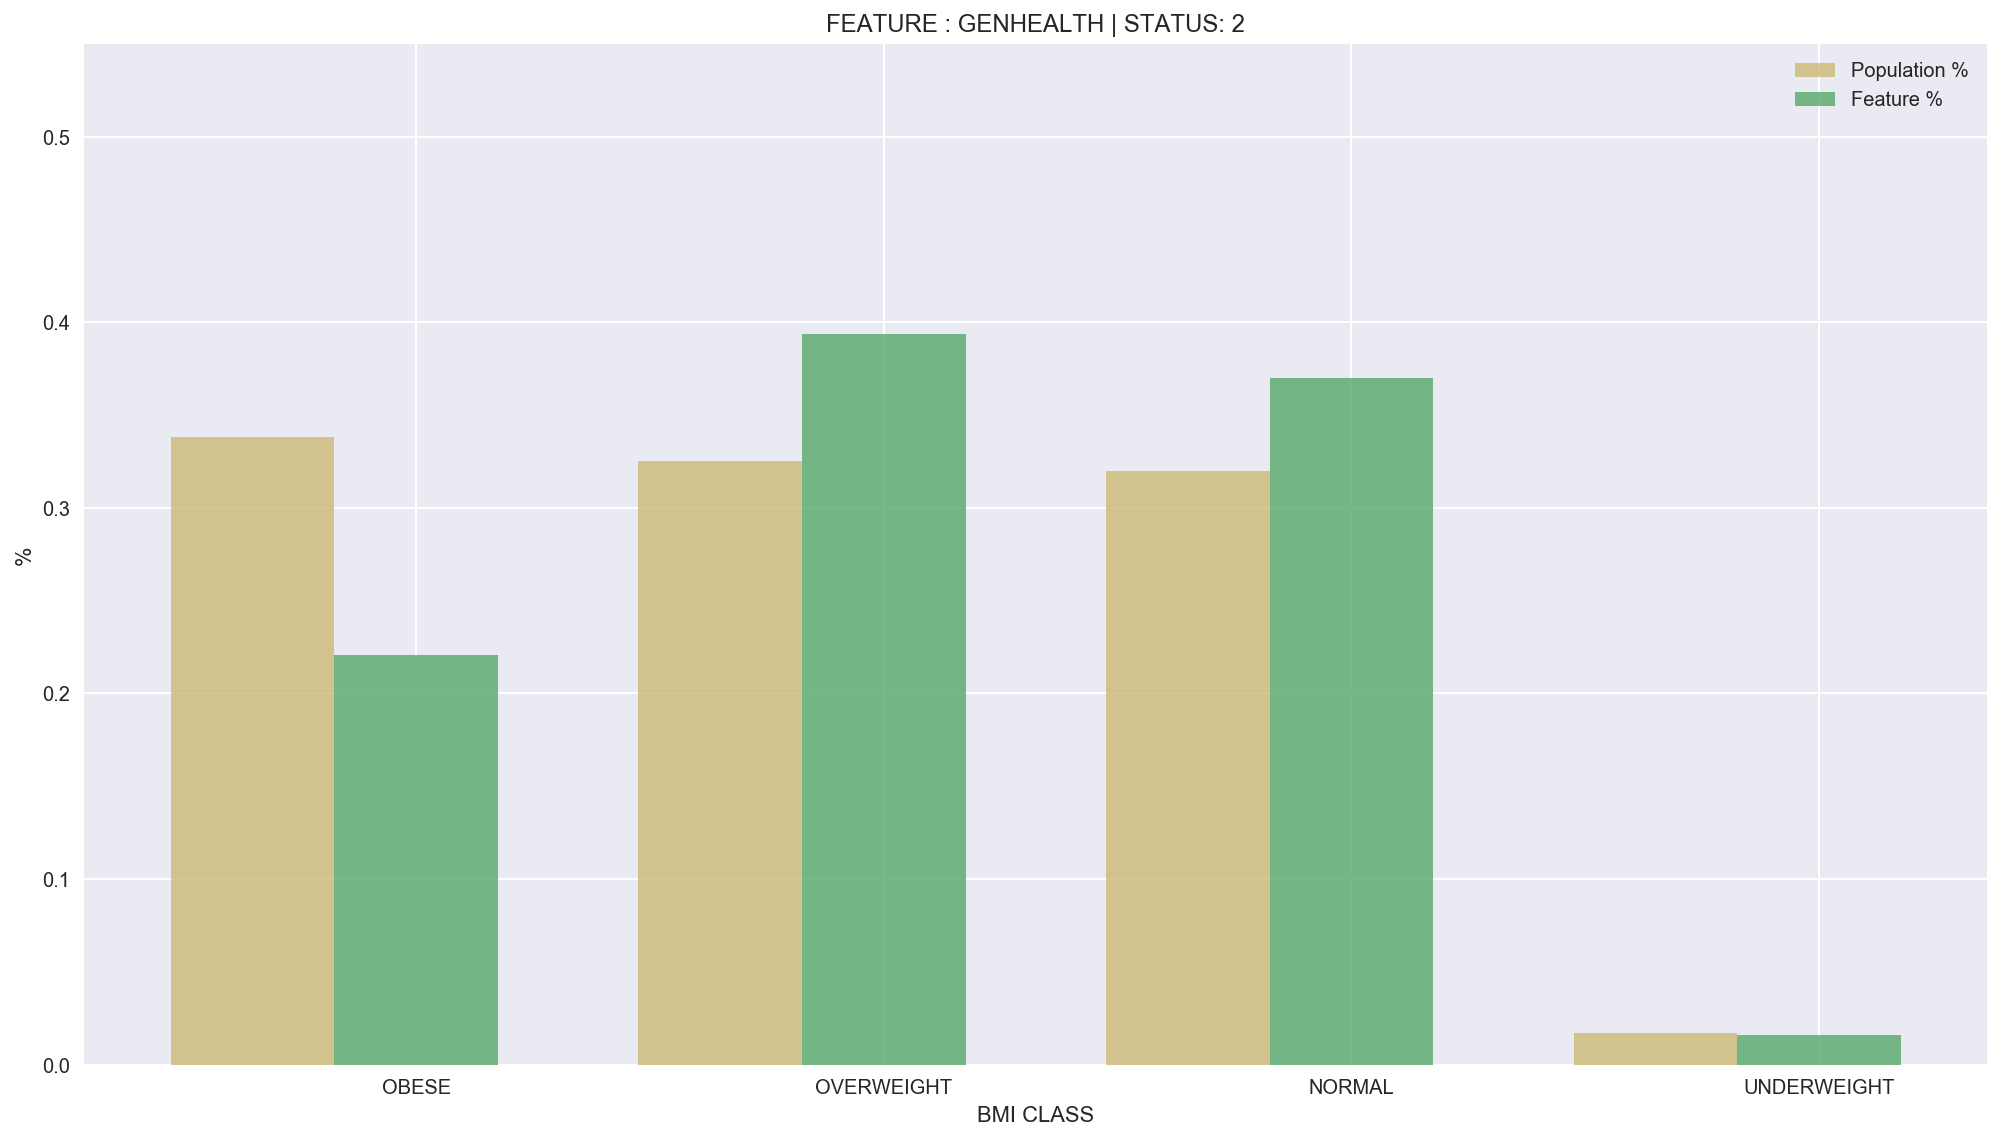

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     6433
GENHEALTH 3 OBESE 	 2484 	 38.613399658 %    OFF :12.7429968559
GENHEALTH 3 OVER 	 2214 	 34.4162909995 %    OFF :-0.623989210624
GENHEALTH 3 NORMAL 	 1648 	 25.6179076636 %    OFF :-11.6920748233
GENHEALTH 3 UNDER 	 87 	 1.35240167884 %    OFF :-0.426932822032



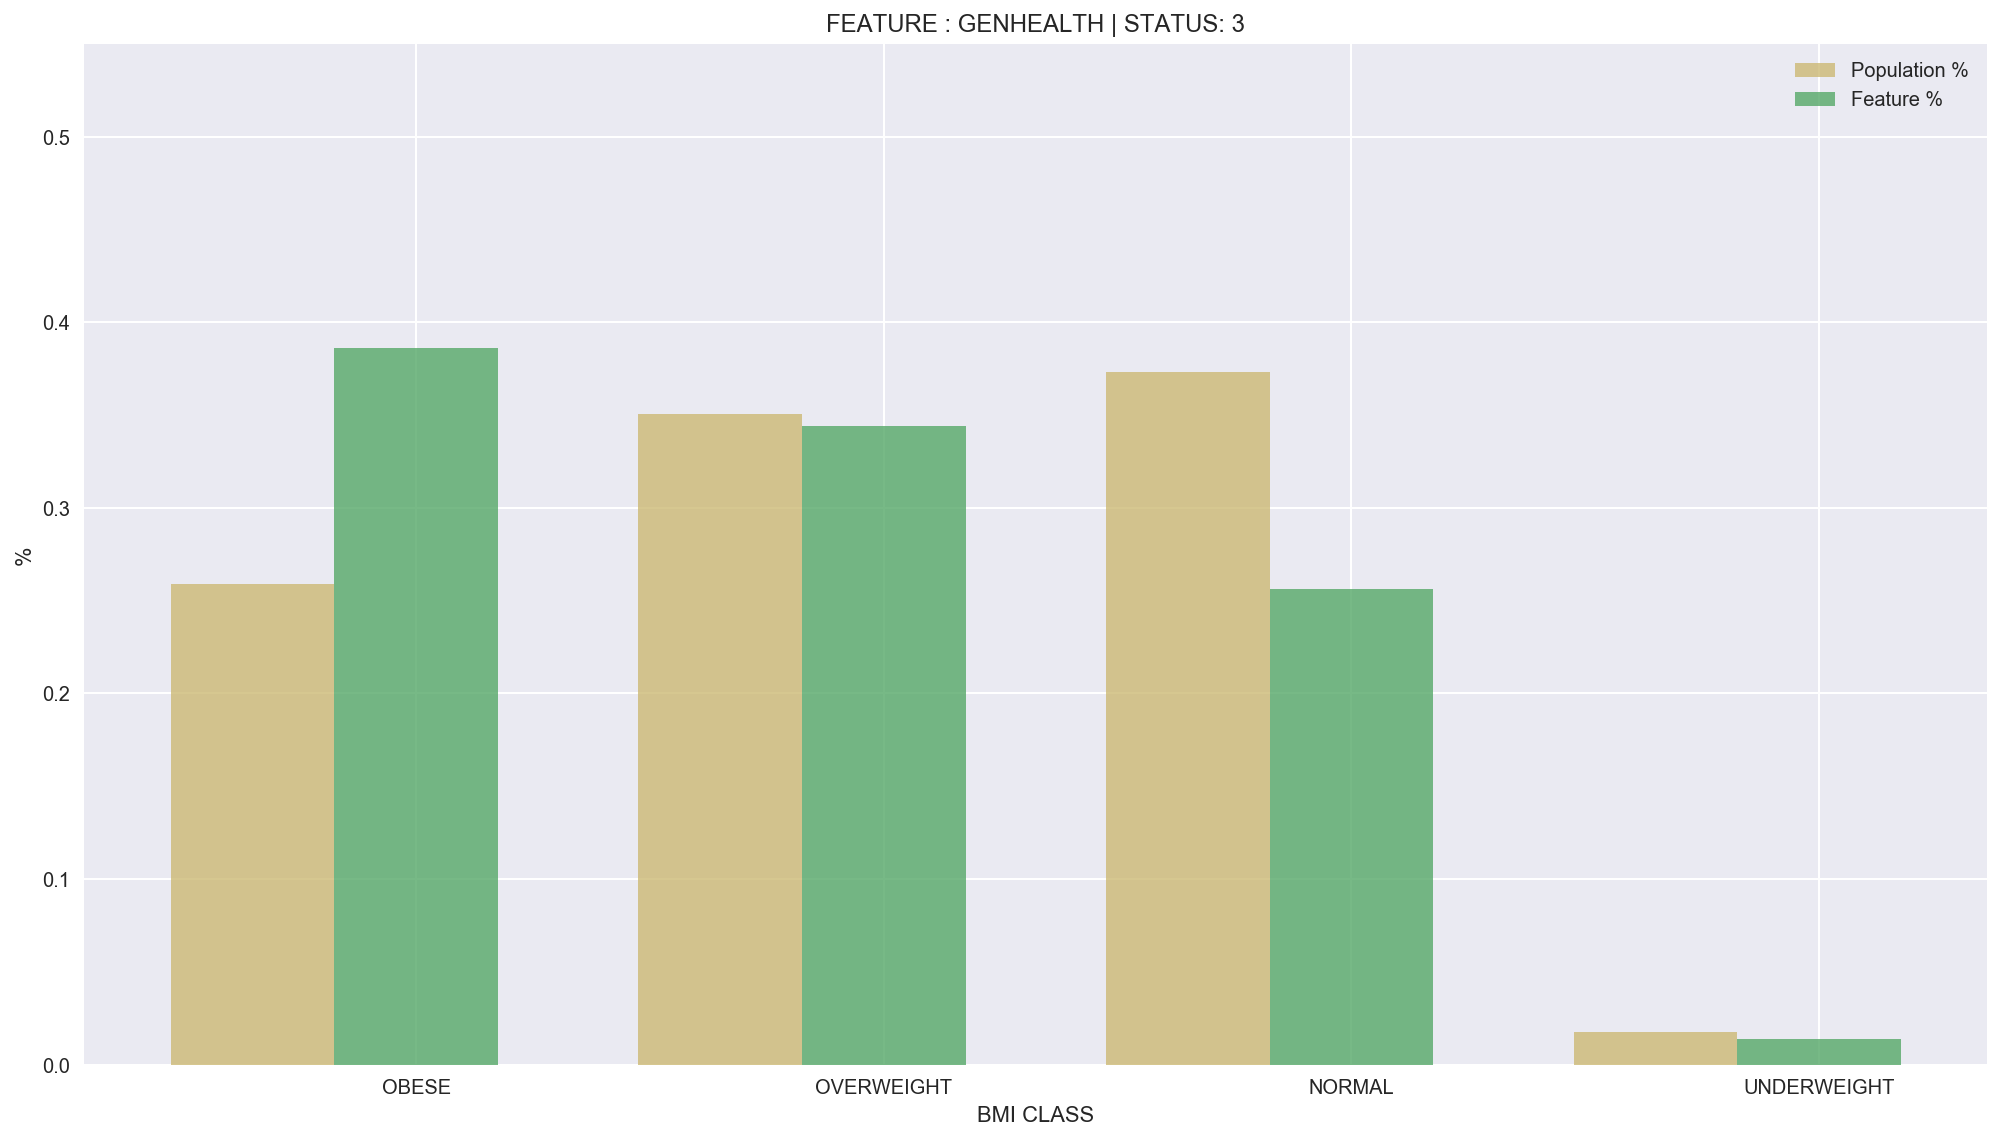

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     2517
GENHEALTH 4 OBESE 	 1227 	 48.7485101311 %    OFF :21.5372518166
GENHEALTH 4 OVER 	 727 	 28.8835915773 %    OFF :-6.78789432235
GENHEALTH 4 NORMAL 	 524 	 20.8184346444 %    OFF :-14.638659523
GENHEALTH 4 UNDER 	 39 	 1.5494636472 %    OFF :-0.110697971184



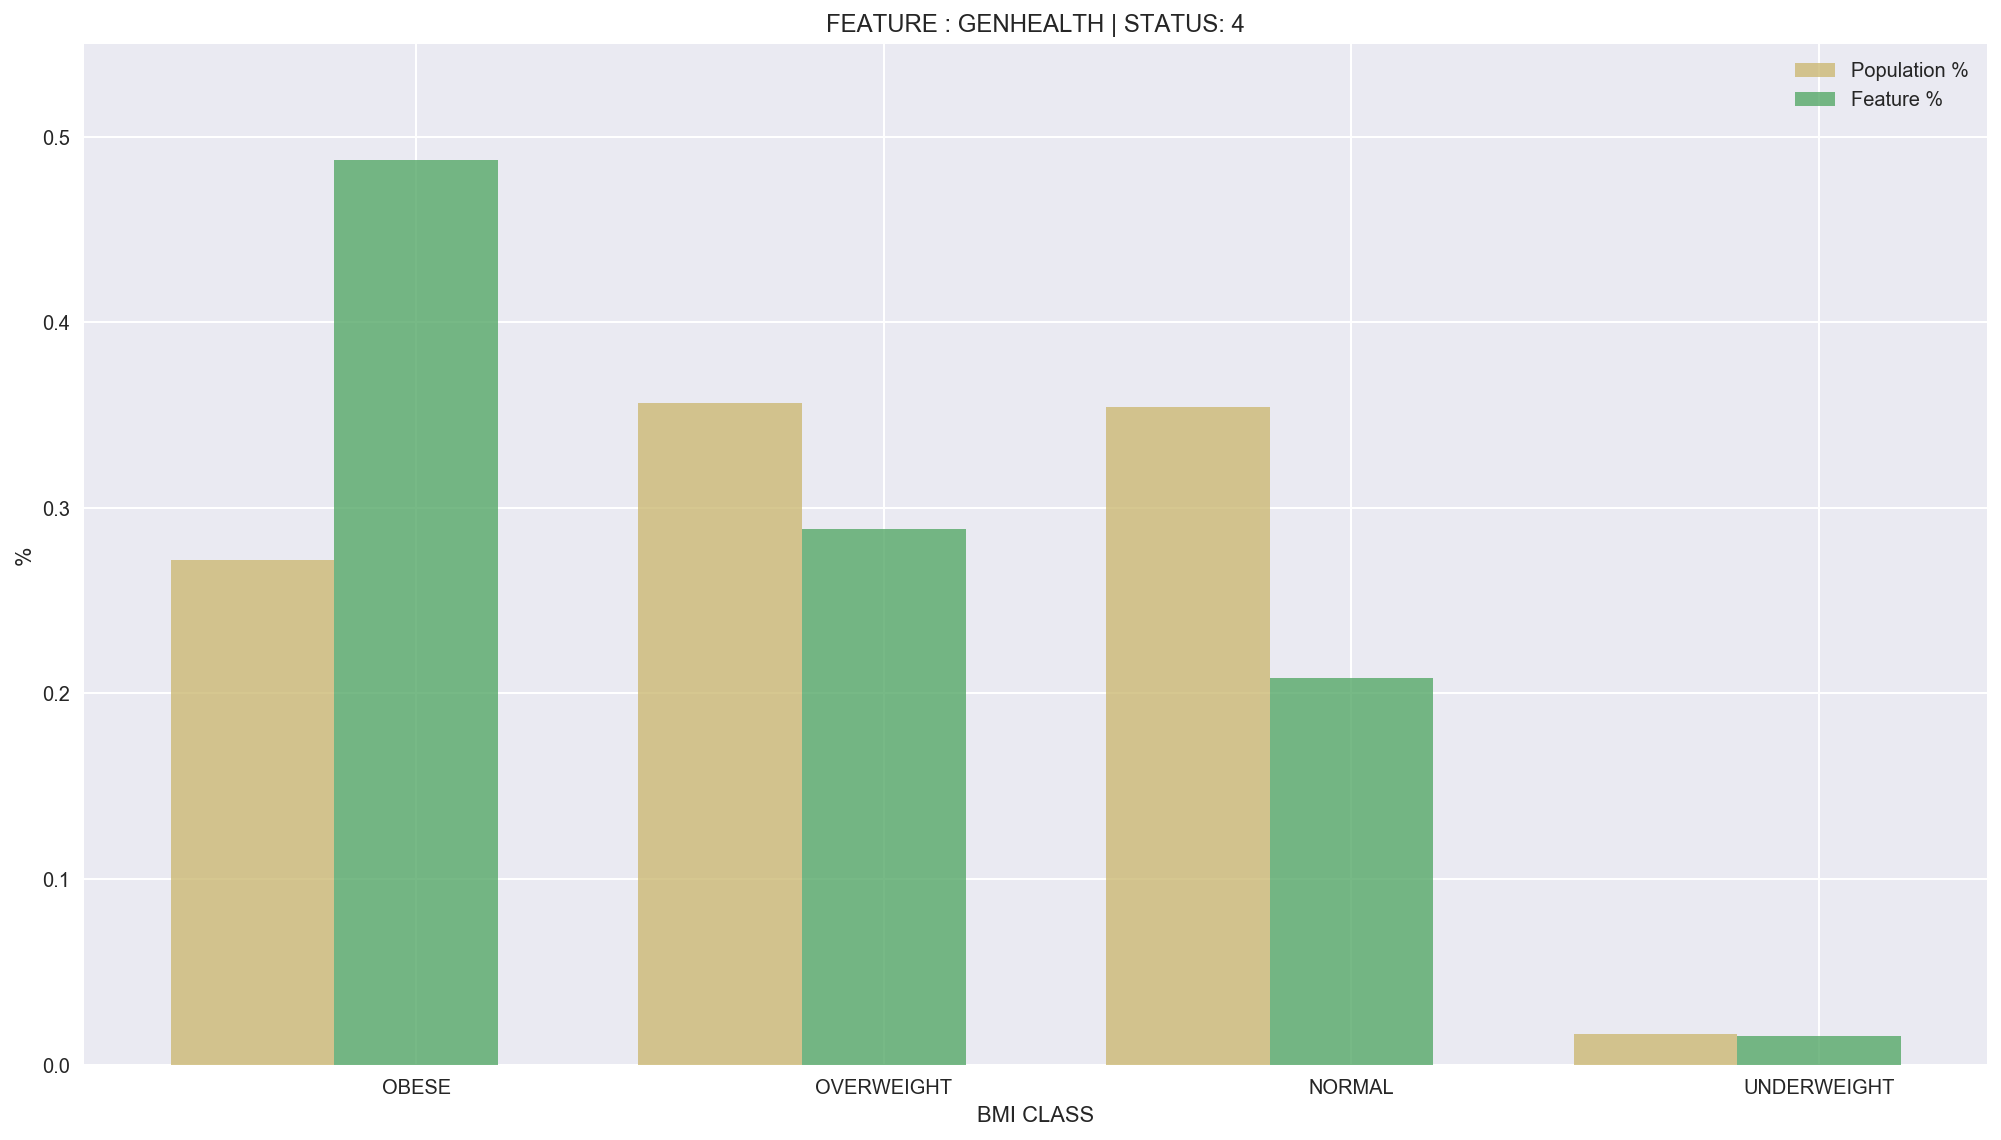

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     873
GENHEALTH 5 OBESE 	 432 	 49.4845360825 %    OFF :20.5205834734
GENHEALTH 5 OVER 	 236 	 27.0332187858 %    OFF :-8.15710135537
GENHEALTH 5 NORMAL 	 180 	 20.618556701 %    OFF :-13.6340271155
GENHEALTH 5 UNDER 	 25 	 2.8636884307 %    OFF :1.27054499737



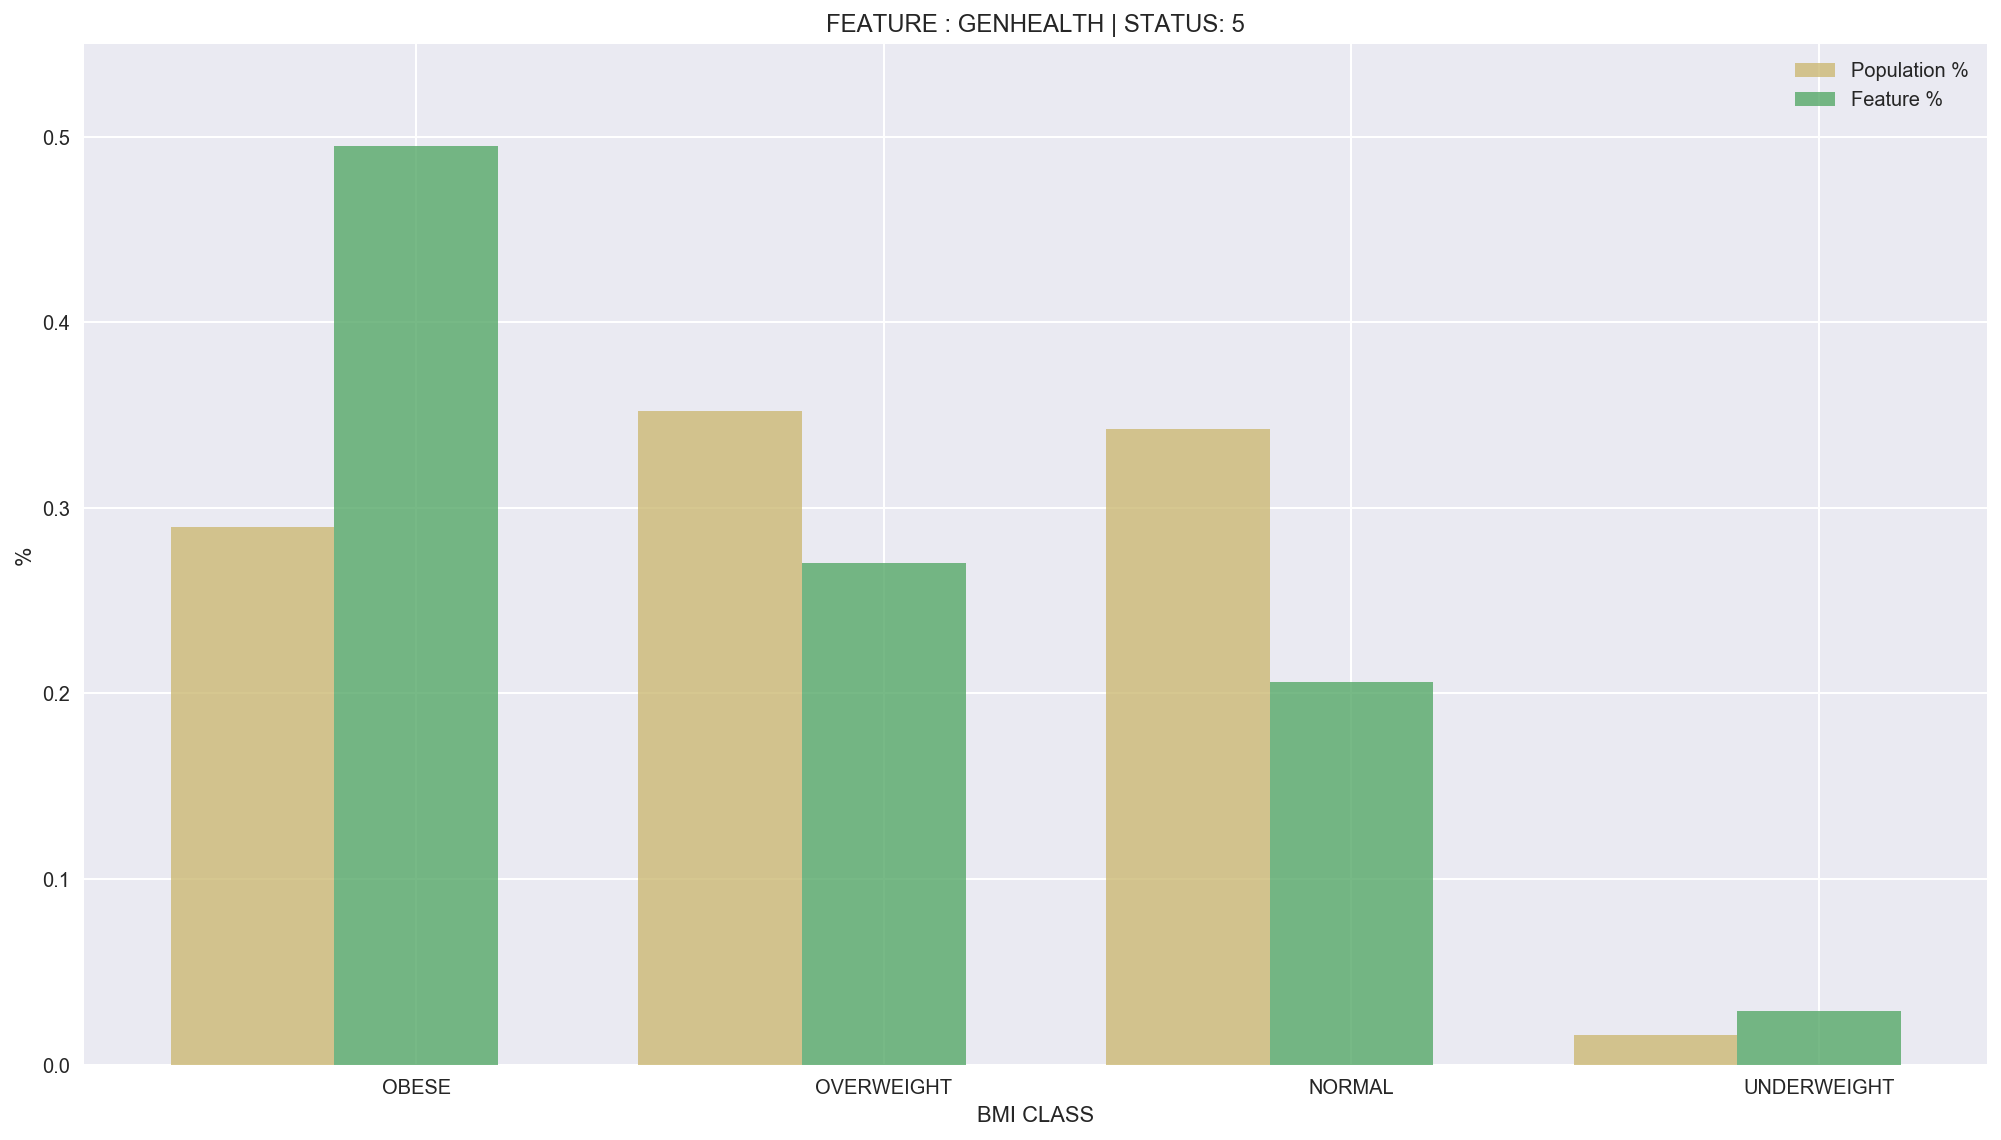

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     10309
STORE 1 OBESE 	 3023 	 29.3238917451 %    OFF :-1.00594766256
STORE 1 OVER 	 3558 	 34.5135318654 %    OFF :-0.66292740957
STORE 1 NORMAL 	 3582 	 34.7463381511 %    OFF :2.12781713949
STORE 1 UNDER 	 146 	 1.41623823843 %    OFF :-0.458942067366



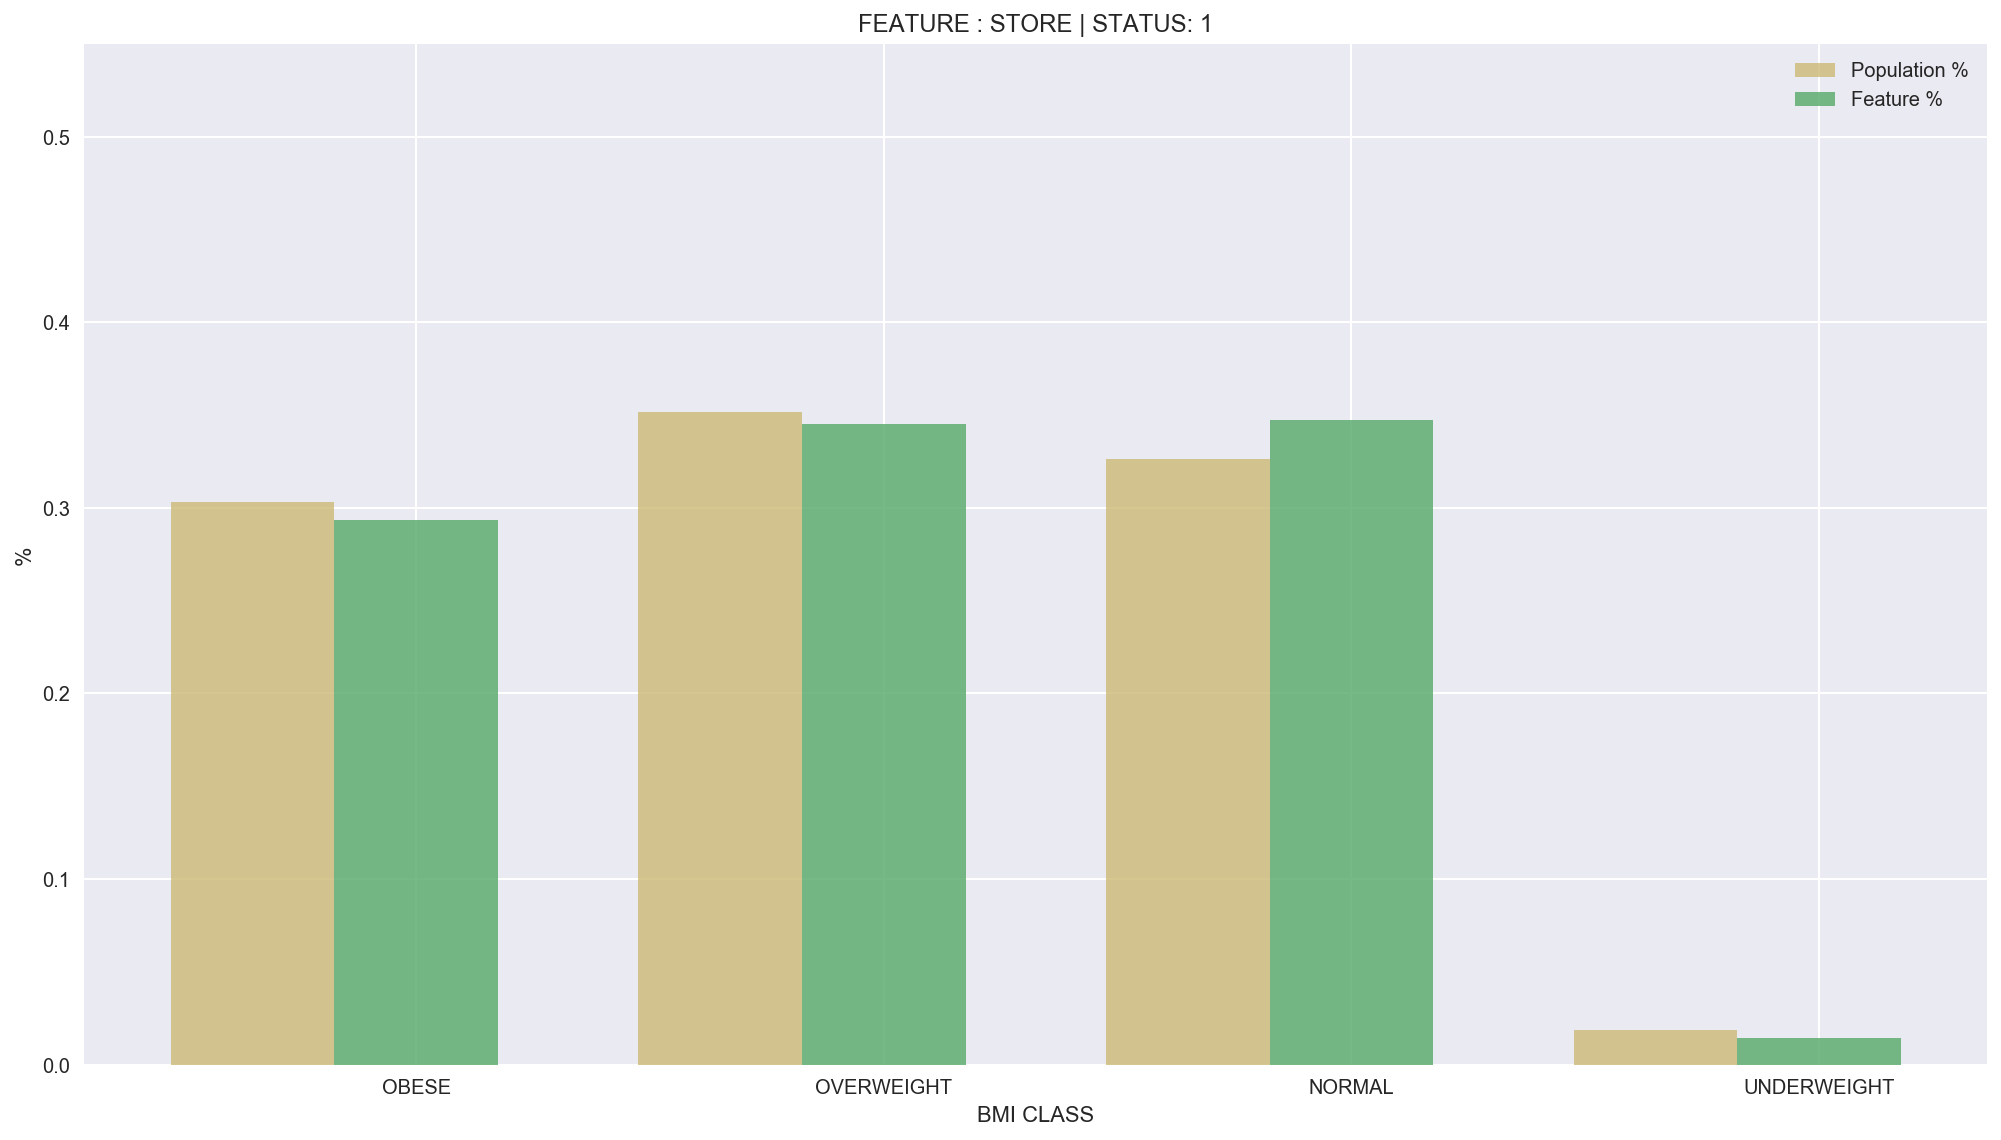

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     3623
STORE 2 OBESE 	 1234 	 34.0601711289 %    OFF :5.12835959832
STORE 2 OVER 	 1252 	 34.5569969638 %    OFF :-0.350816907975
STORE 2 NORMAL 	 1096 	 30.251173061 %    OFF :-4.1532752855
STORE 2 UNDER 	 41 	 1.13165884626 %    OFF :-0.624267404837



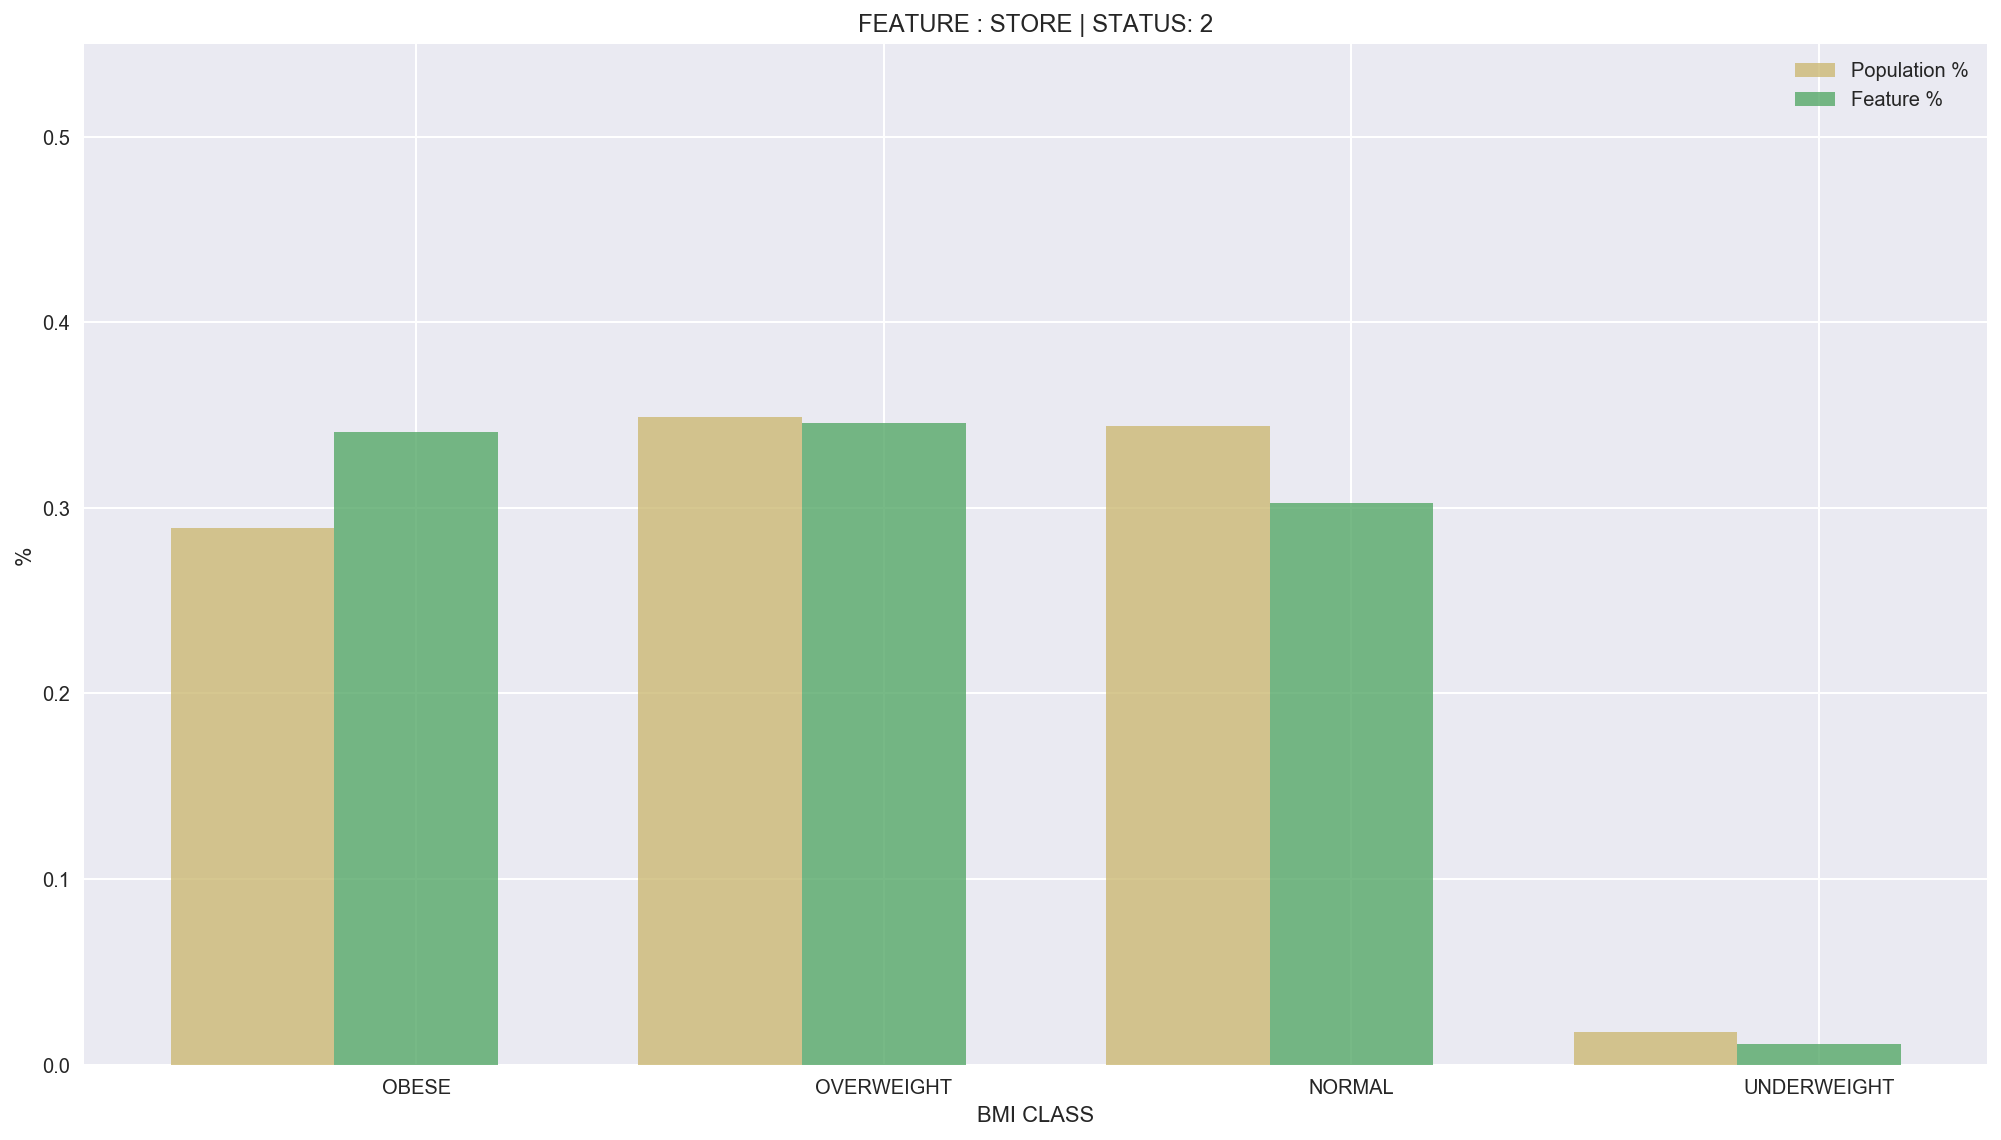

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     642
STORE 3 OBESE 	 185 	 28.8161993769 %    OFF :-1.04525781432
STORE 3 OVER 	 234 	 36.4485981308 %    OFF :1.65342221138
STORE 3 NORMAL 	 212 	 33.0218068536 %    OFF :-0.676987126284
STORE 3 UNDER 	 11 	 1.71339563863 %    OFF :0.0688227292303



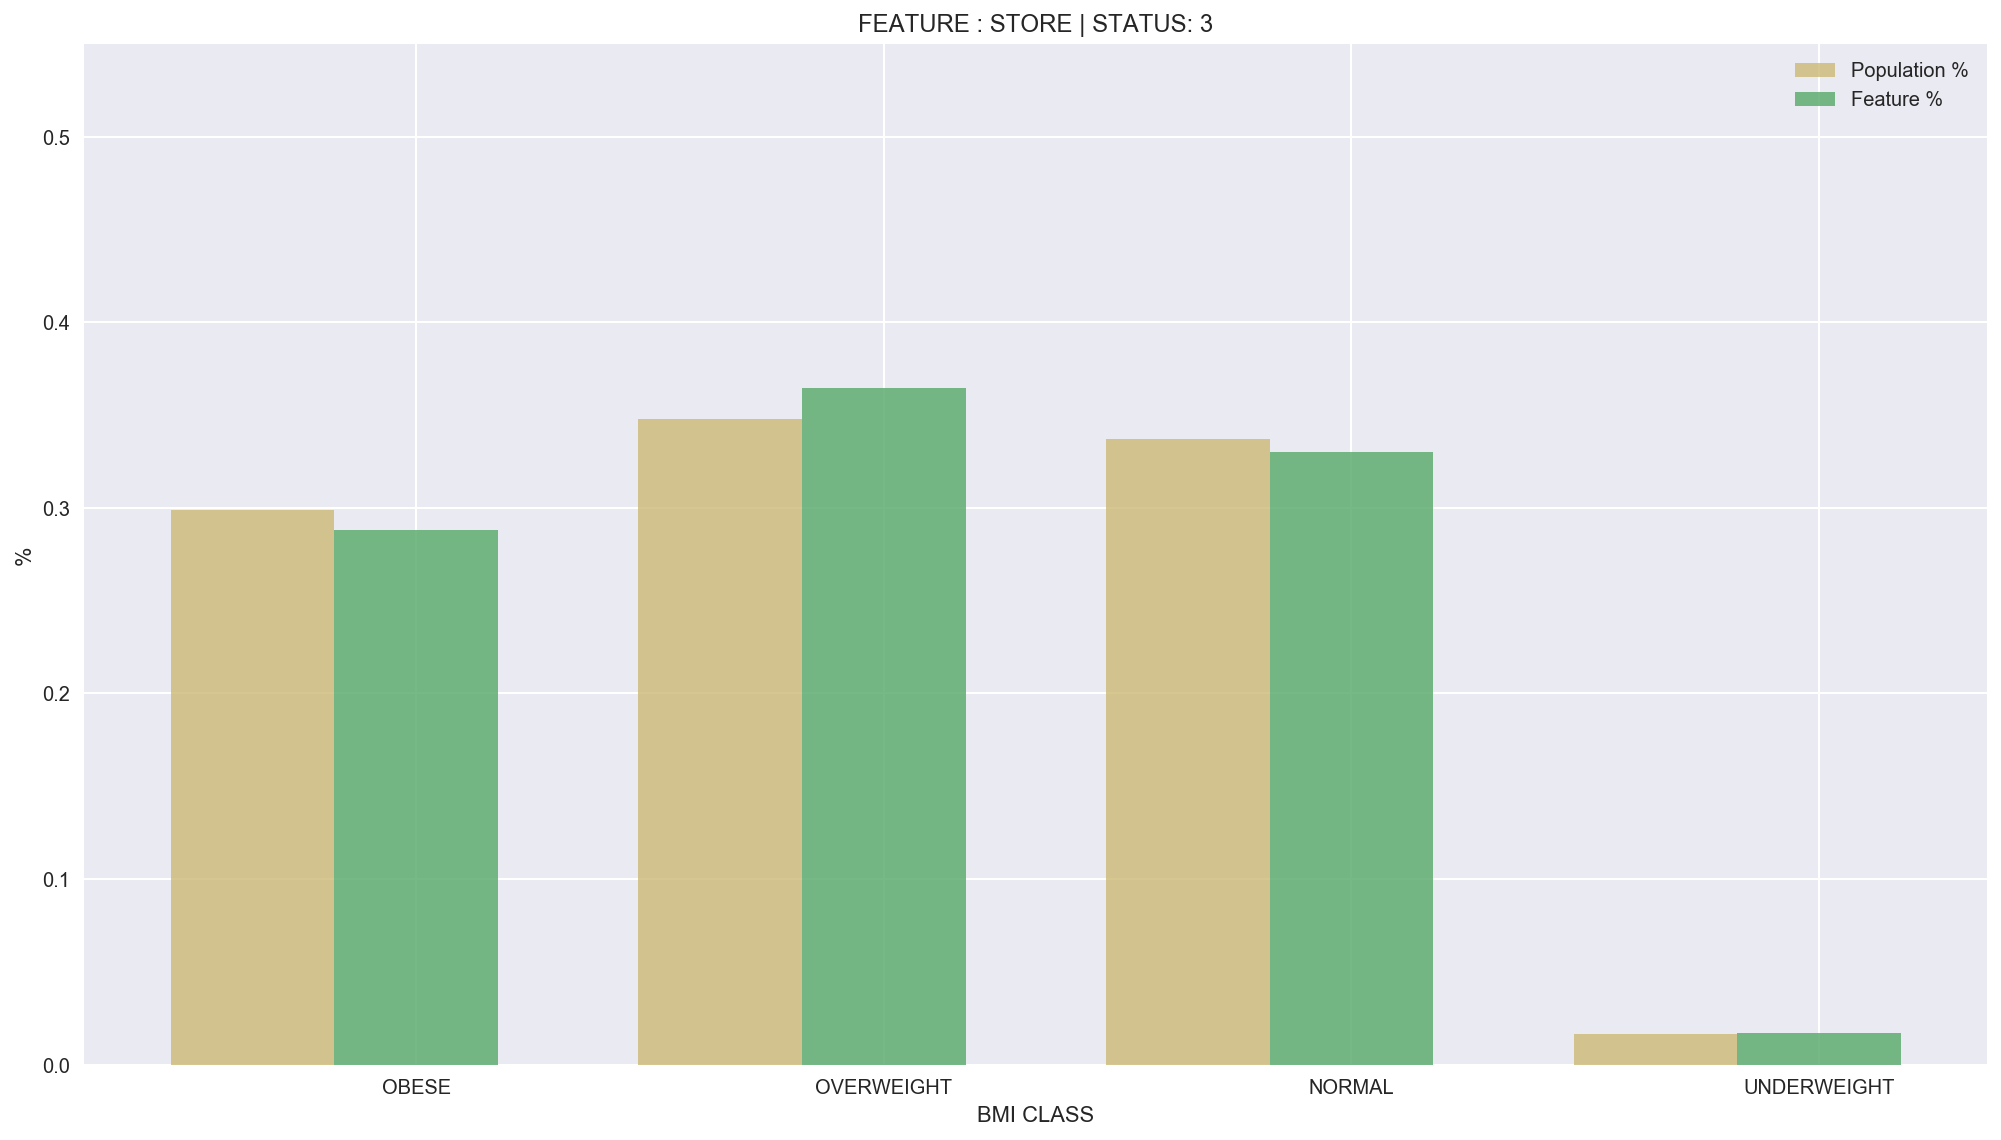

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     67
STORE 4 OBESE 	 25 	 37.3134328358 %    OFF :7.50867531438
STORE 4 OVER 	 15 	 22.3880597015 %    OFF :-12.4988159344
STORE 4 NORMAL 	 27 	 40.2985074627 %    OFF :6.64219236167
STORE 4 UNDER 	 0 	 0.0 %    OFF :-1.65205174168



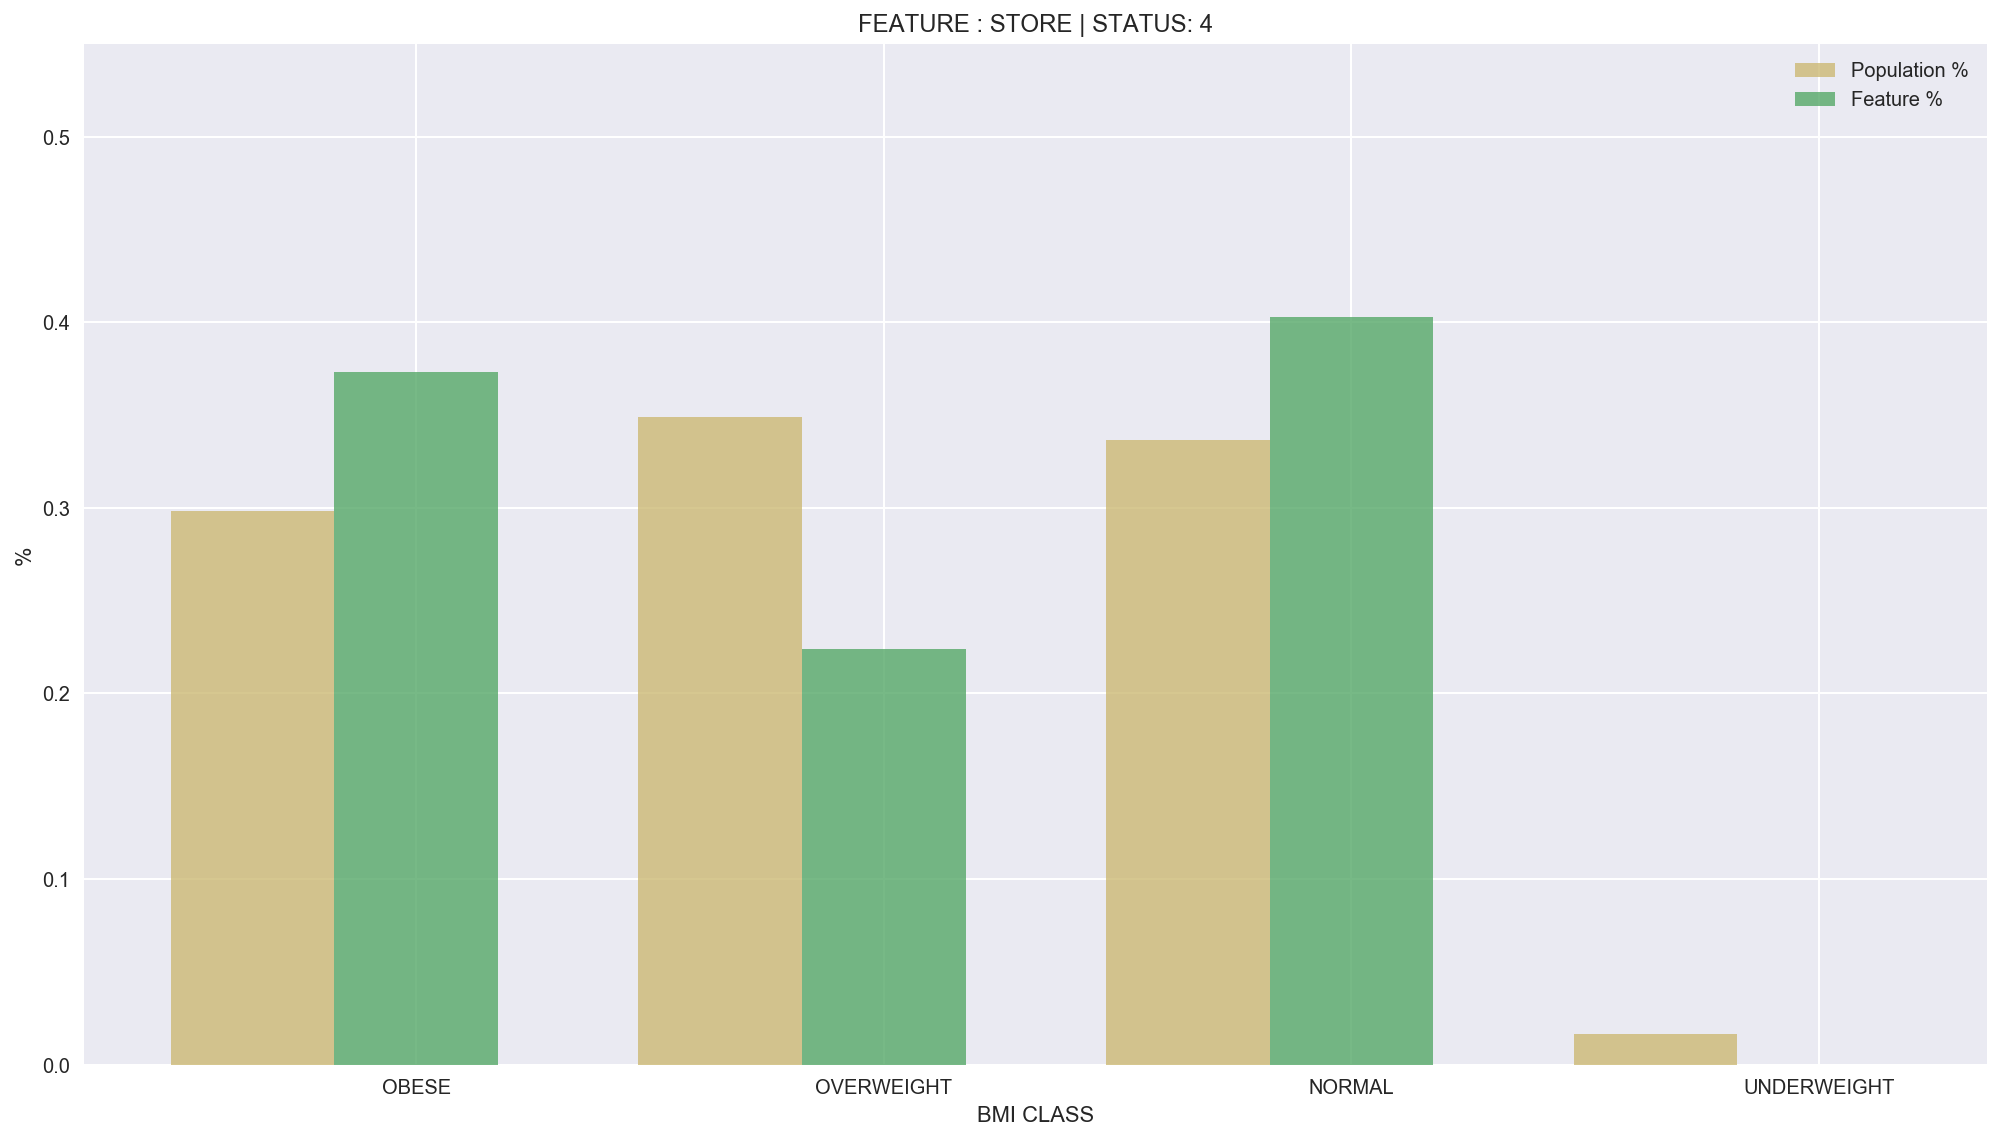

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     391
STORE 5 OBESE 	 102 	 26.0869565217 %    OFF :-3.81411154933
STORE 5 OVER 	 130 	 33.2480818414 %    OFF :-1.62911459505
STORE 5 NORMAL 	 145 	 37.084398977 %    OFF :3.47215307454
STORE 5 UNDER 	 14 	 3.58056265985 %    OFF :1.97107306985



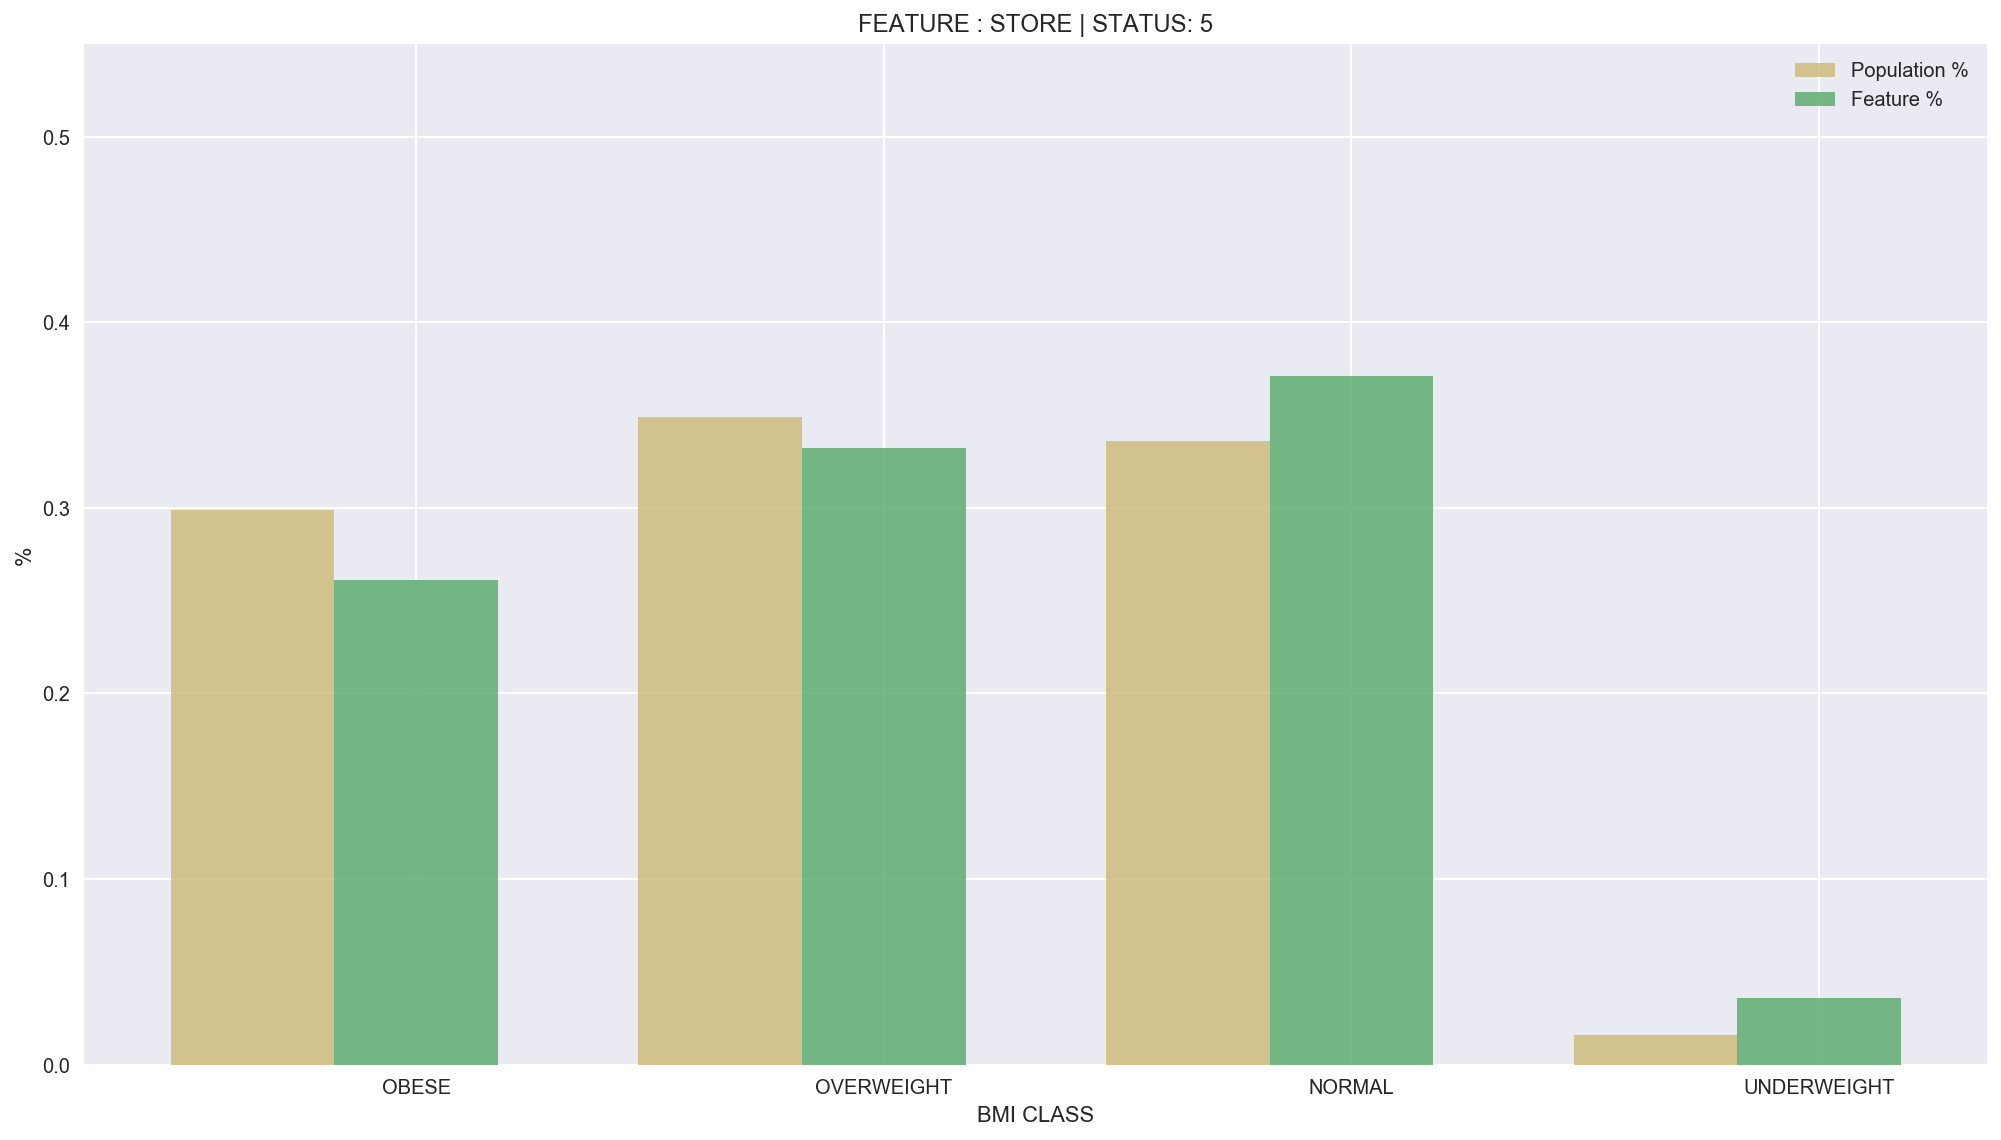

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     4629
STREASON 1 OBESE 	 1560 	 33.7005832793 %    OFF :4.98611098627
STREASON 1 OVER 	 1610 	 34.7807301793 %    OFF :-0.0846221436013
STREASON 1 NORMAL 	 1400 	 30.2441131994 %    OFF :-4.42222177169
STREASON 1 UNDER 	 59 	 1.27457334197 %    OFF :-0.479267070986



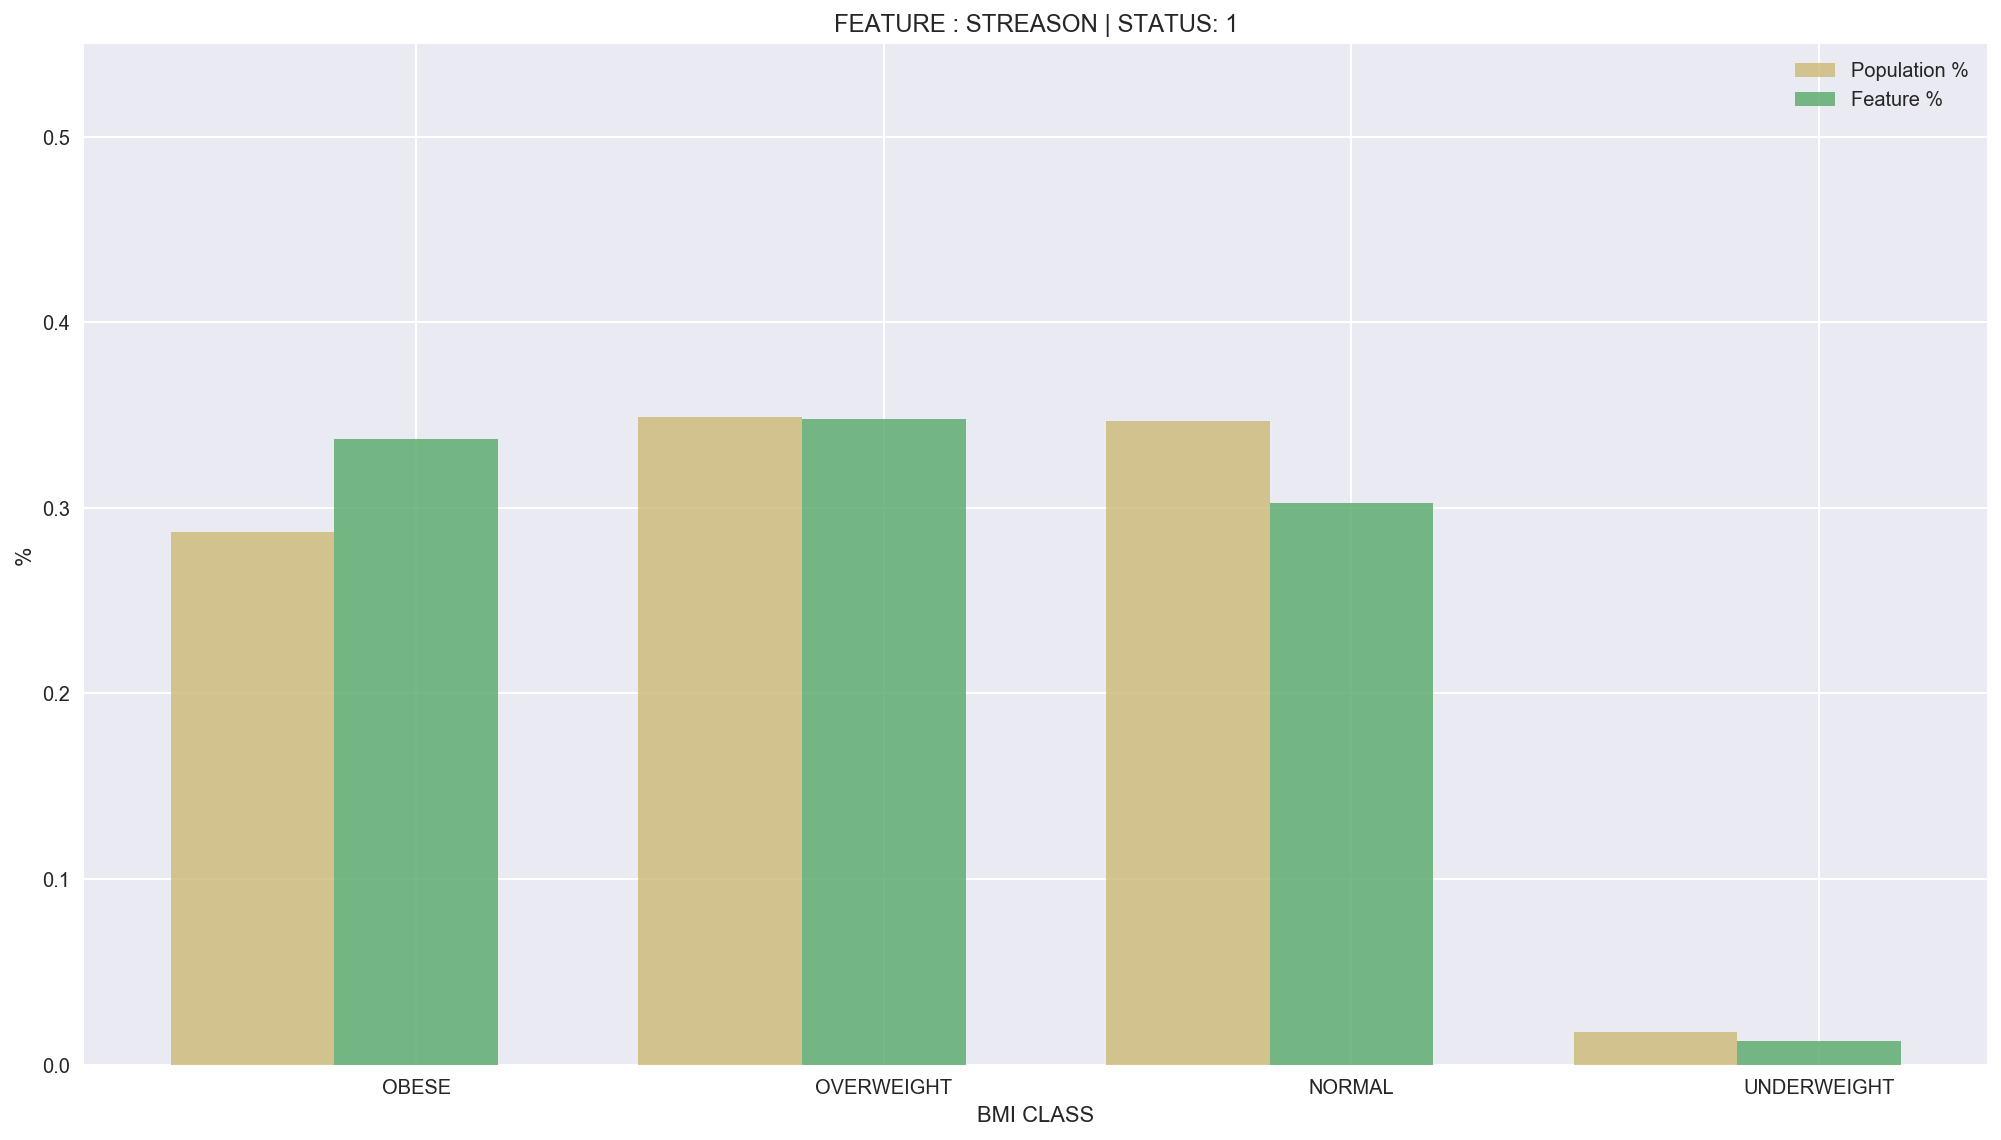

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     5659
STREASON 2 OBESE 	 1657 	 29.2807916593 %    OFF :-0.754426627626
STREASON 2 OVER 	 1966 	 34.7411203393 %    OFF :-0.144918600182
STREASON 2 NORMAL 	 1963 	 34.6881074395 %    OFF :1.39021389173
STREASON 2 UNDER 	 73 	 1.28998056194 %    OFF :-0.490868663925



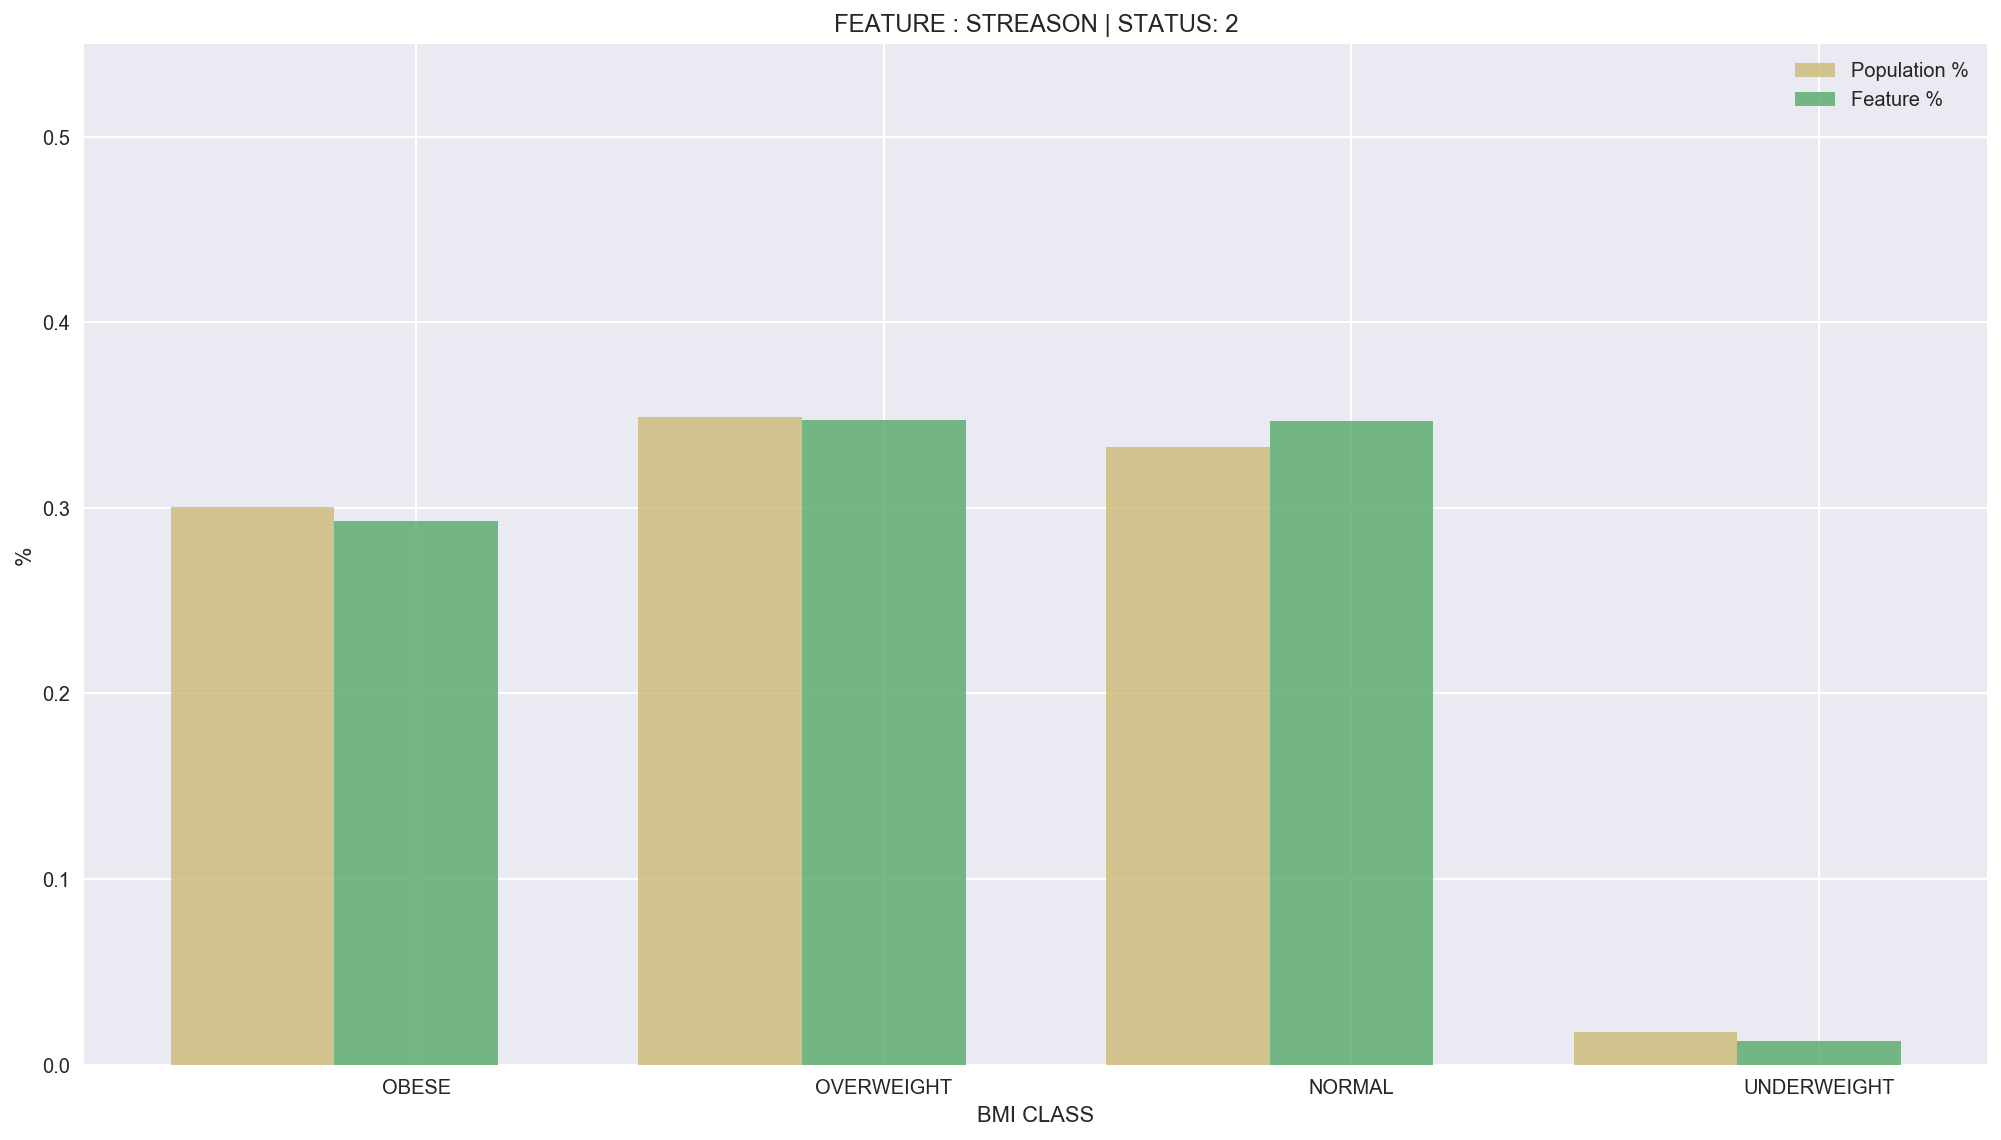

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     2036
STREASON 3 OBESE 	 490 	 24.0667976424 %    OFF :-6.39057168061
STREASON 3 OVER 	 684 	 33.5952848723 %    OFF :-1.38757716712
STREASON 3 NORMAL 	 834 	 40.9626719057 %    OFF :8.07921003766
STREASON 3 UNDER 	 28 	 1.37524557957 %    OFF :-0.301061189927



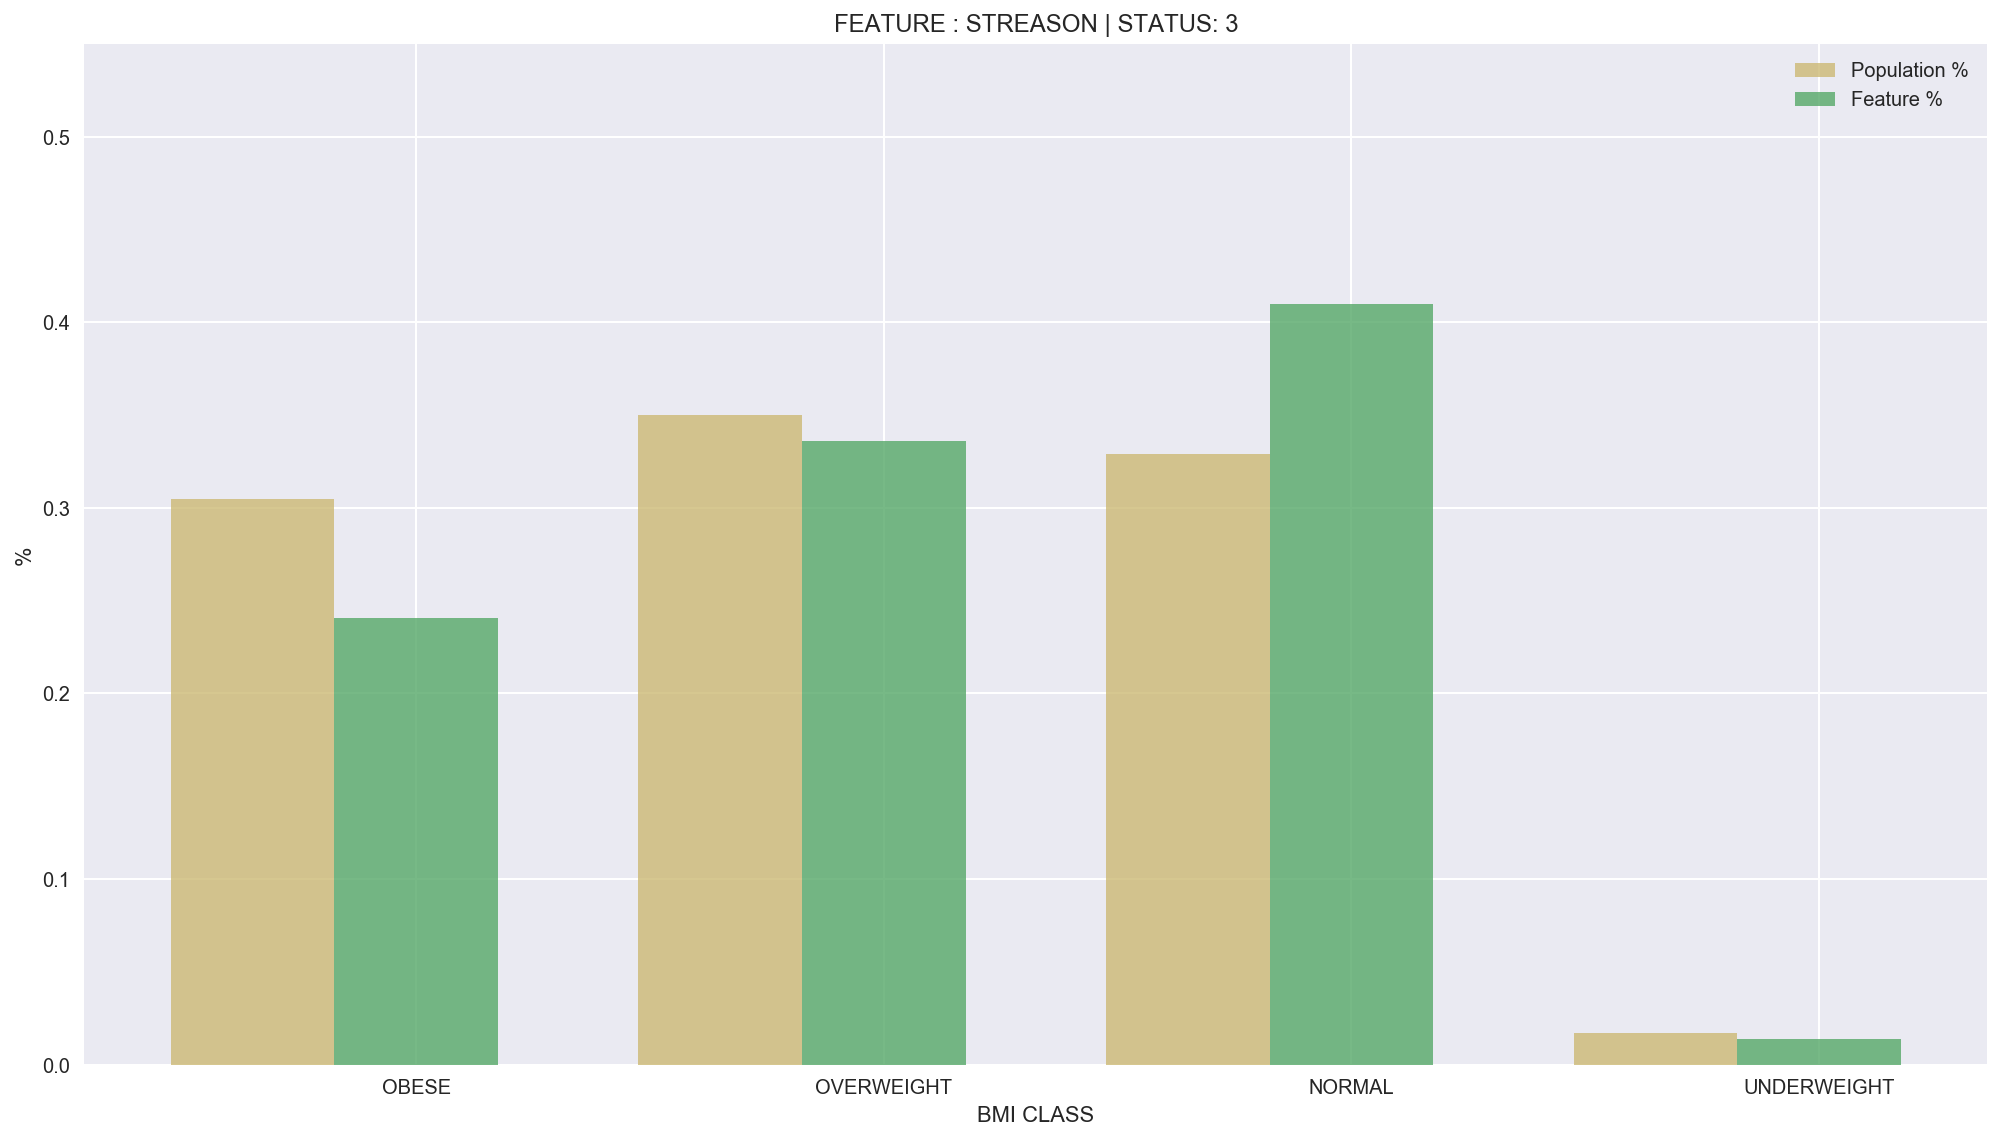

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     1354
STREASON 4 OBESE 	 424 	 31.3146233383 %    OFF :1.58950191633
STREASON 4 OVER 	 465 	 34.3426883309 %    OFF :-0.538989875184
STREASON 4 NORMAL 	 439 	 32.4224519941 %    OFF :-1.34317784987
STREASON 4 UNDER 	 26 	 1.92023633678 %    OFF :0.292665808724



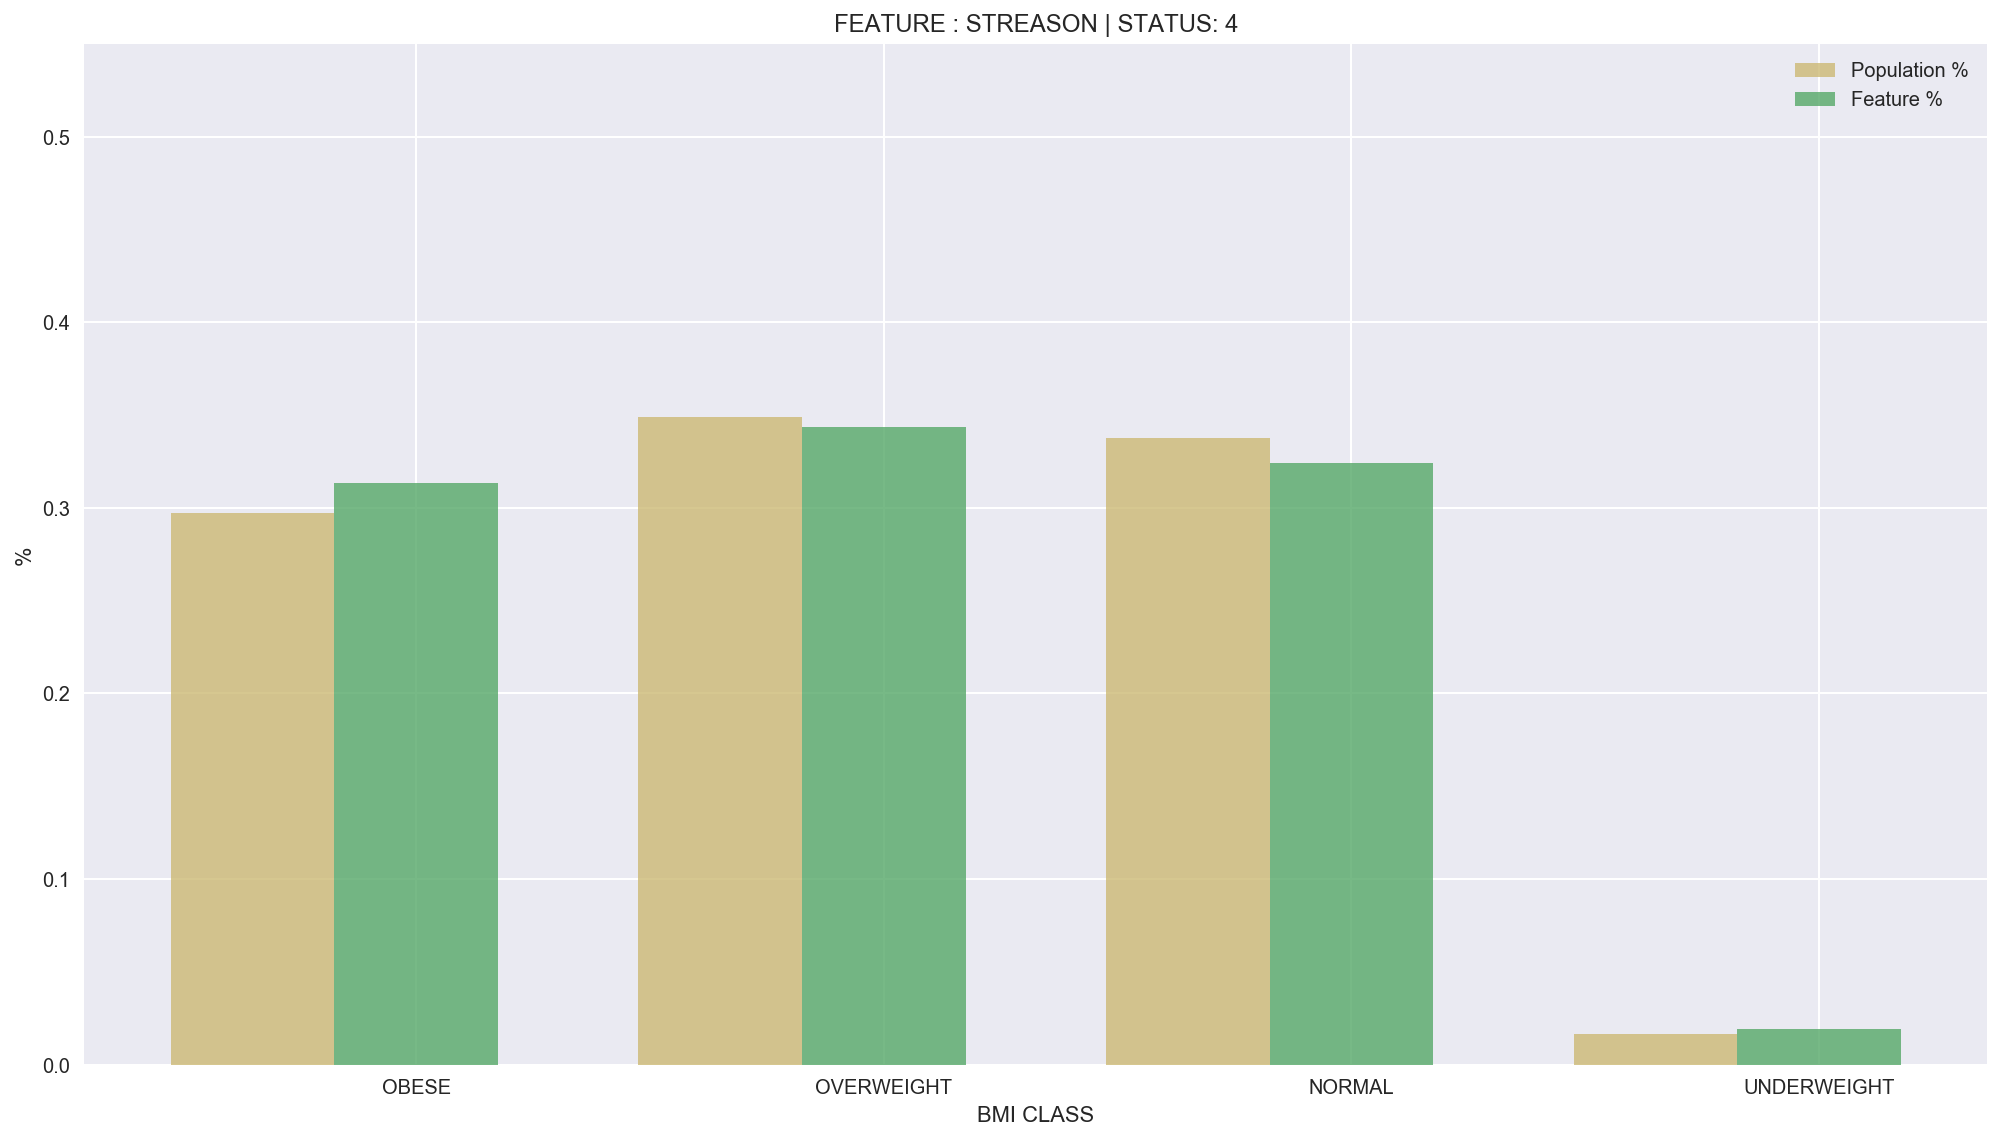

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     341
STREASON 5 OBESE 	 116 	 34.0175953079 %    OFF :4.25867155872
STREASON 5 OVER 	 127 	 37.2434017595 %    OFF :2.43709744373
STREASON 5 NORMAL 	 91 	 26.6862170088 %    OFF :-7.10864723238
STREASON 5 UNDER 	 7 	 2.05278592375 %    OFF :0.412878229935



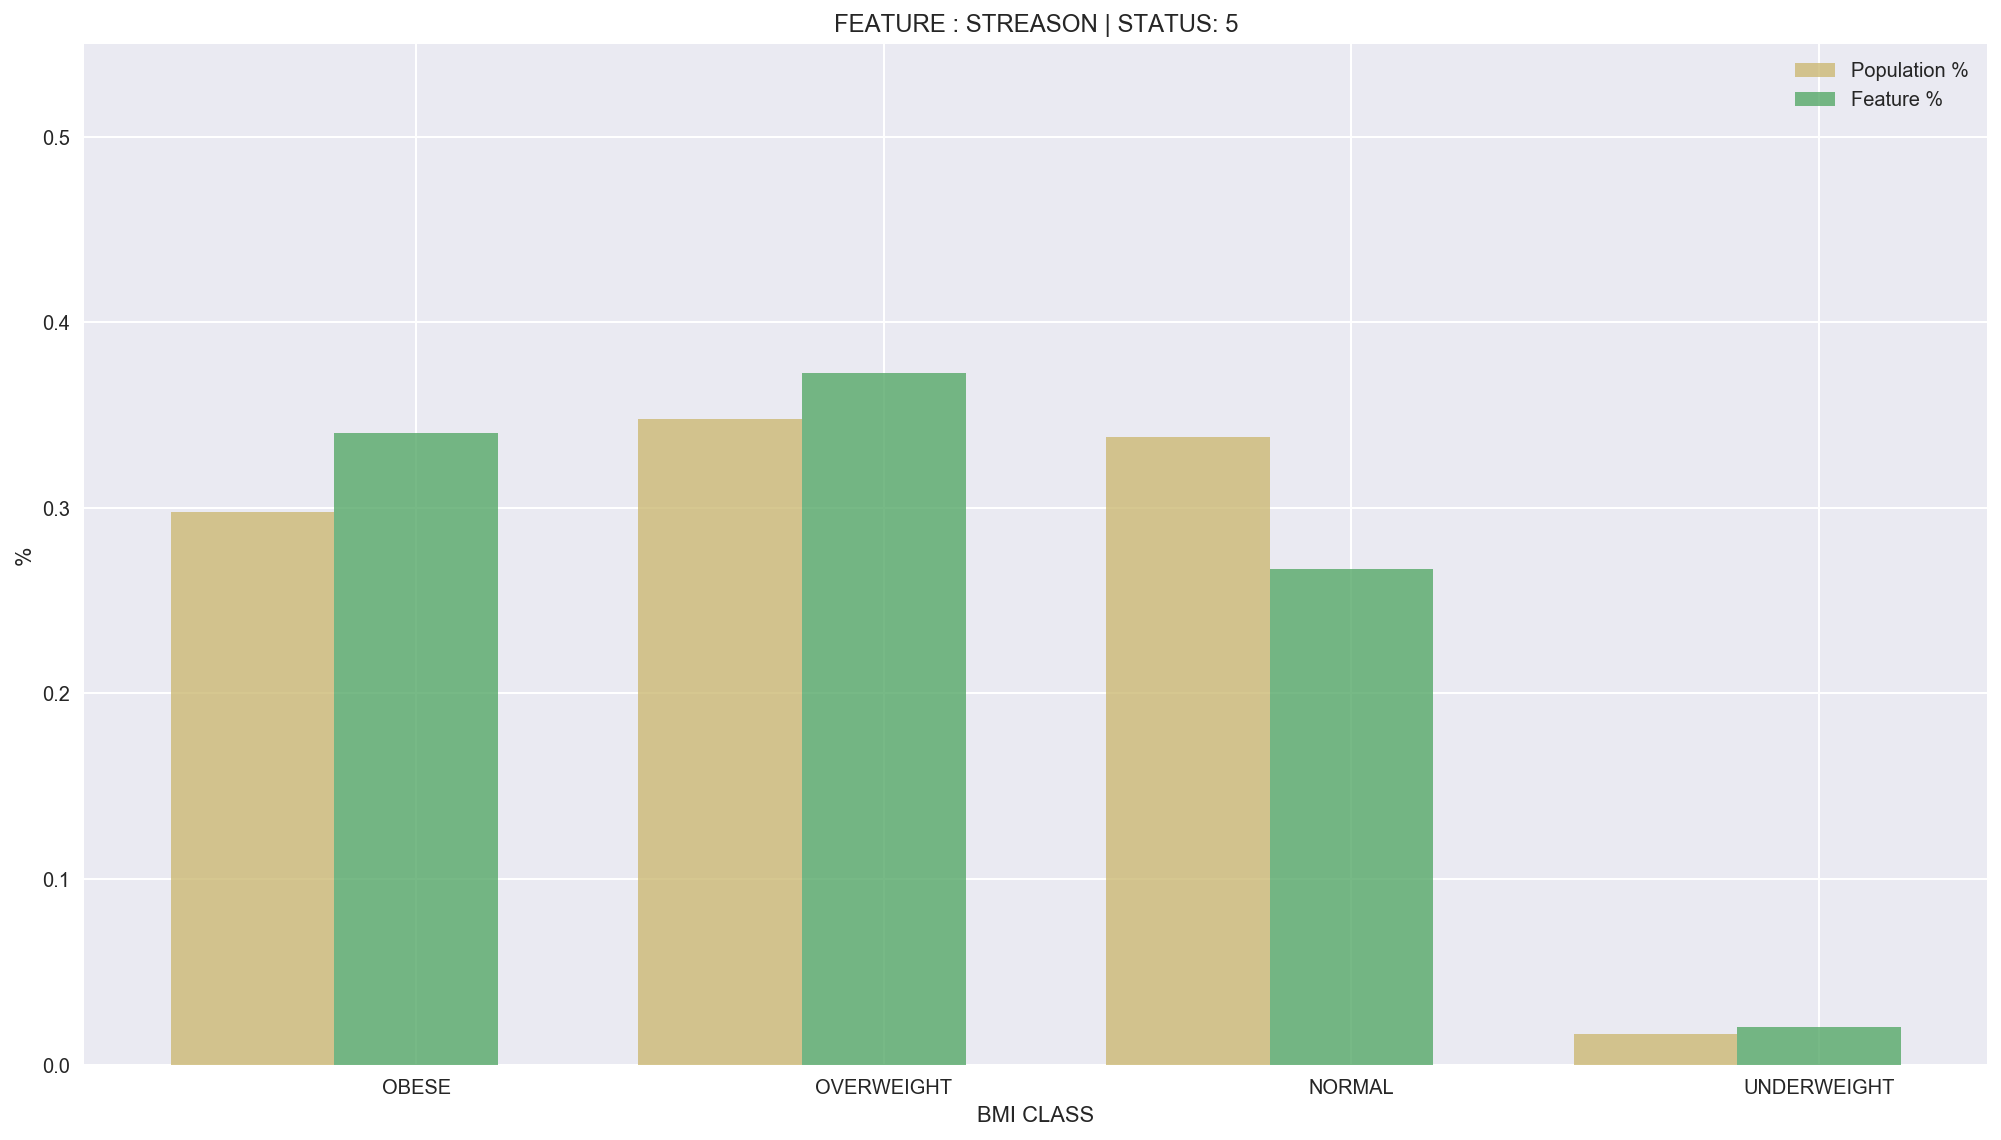

----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
TOTAL CASES:     827
STREASON 6 OBESE 	 260 	 31.4389359129 %    OFF :1.67685151075
STREASON 6 OVER 	 275 	 33.2527206771 %    OFF :-1.6600100708
STREASON 6 NORMAL 	 274 	 33.1318016929 %    OFF :-0.568716389726
STREASON 6 UNDER 	 18 	 2.17654171705 %    OFF :0.551874949784



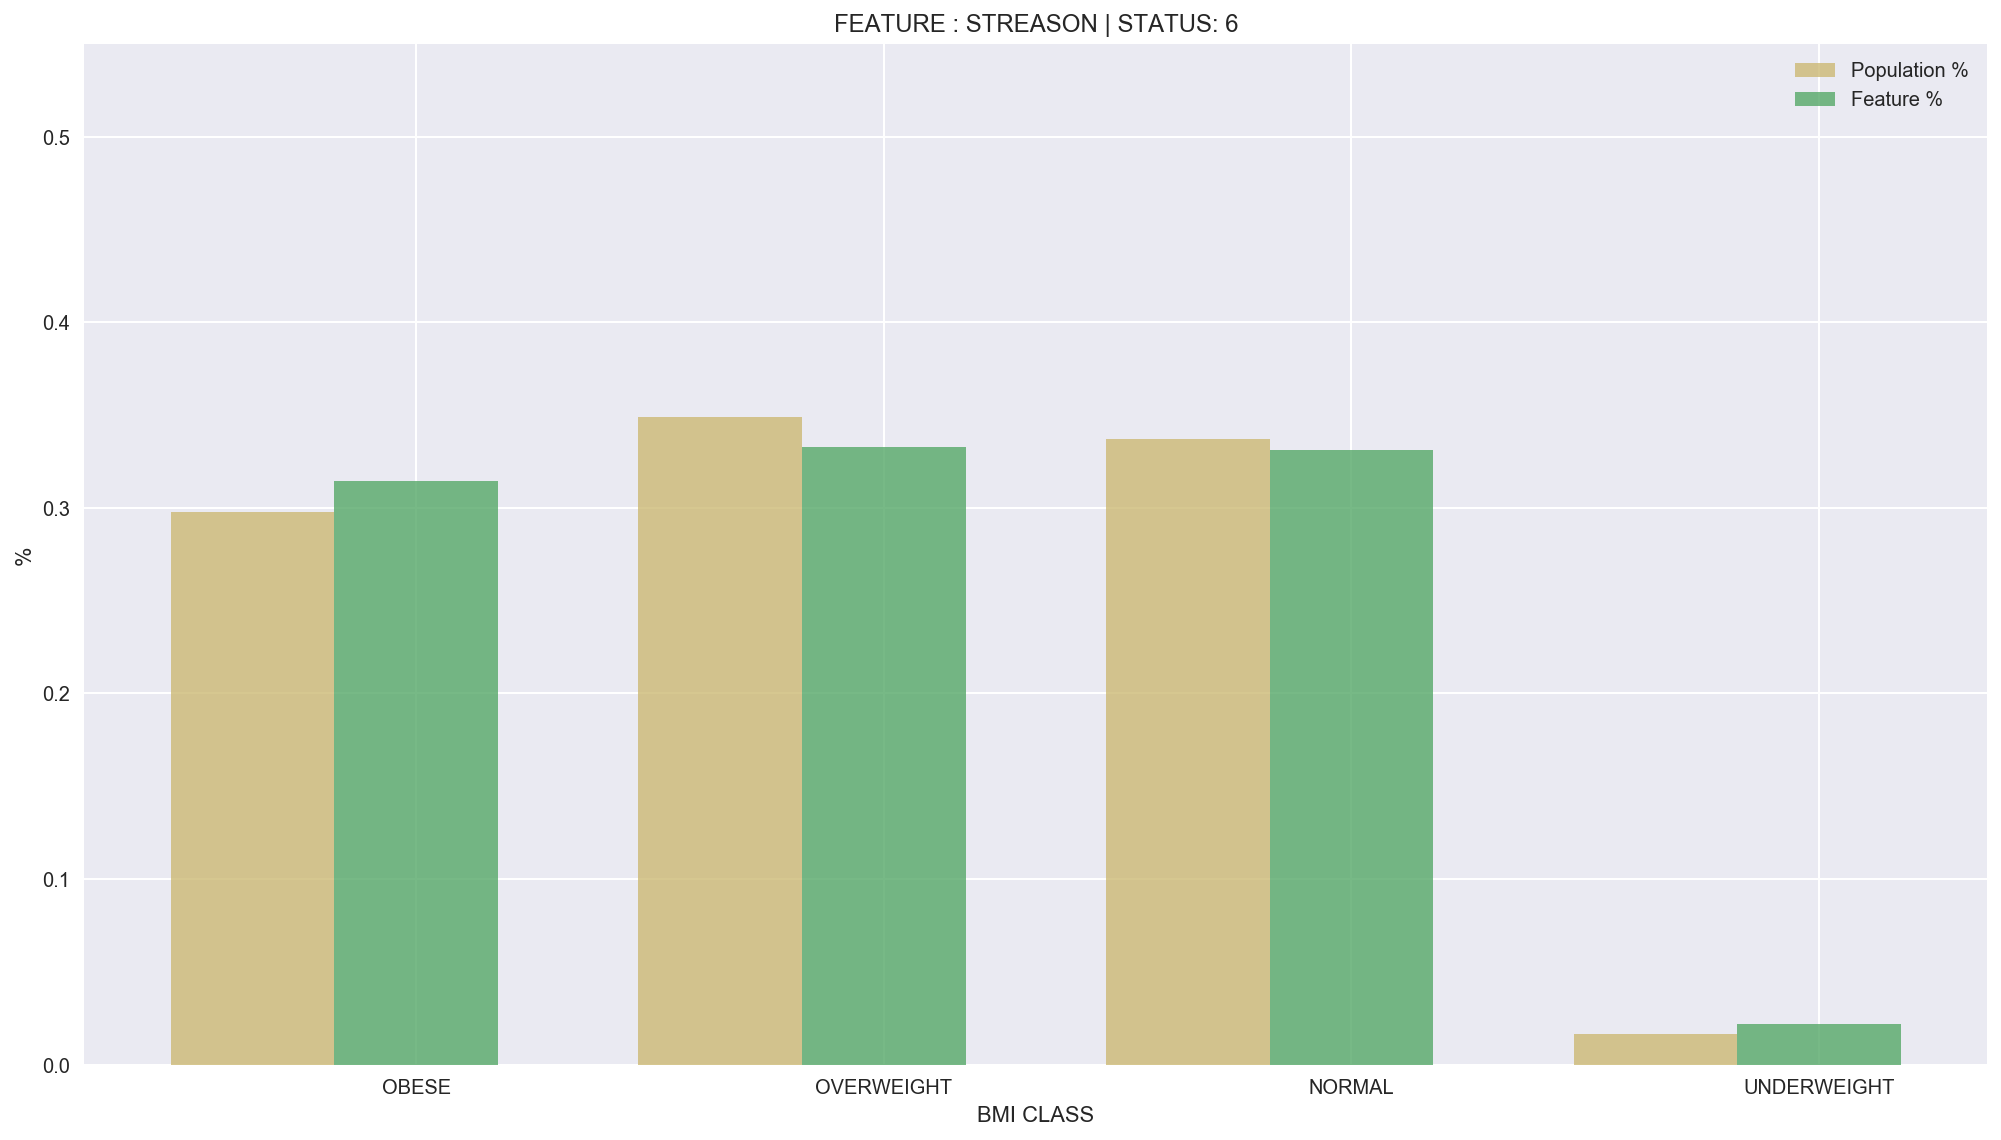

----------------------------------------------------------------------------------


[]

In [19]:
print("Bar charts showing difference of BMI class distribution between feature-specifc and general population")
print()
print("Note: \tGeneral popluation is taken to be the whole population - the features. ")
print("\tThis prevents double counting and accentuates the effect of the feature.")
print()
feat_to_bmi(RESULTS_ON_OFF,2,0)
feat_to_bmi(RESULTS_THREE,3,0)
feat_to_bmi(RESULTS_FIVE,5,0)
feat_to_bmi(RESULTS_SIX,6,0)

Next, we visualize the difference between the shape of distributions!

Legend: Yellow is general population BMI distribution, Blue is feature BMI distribution.


----------------------------------------------------------------------------------


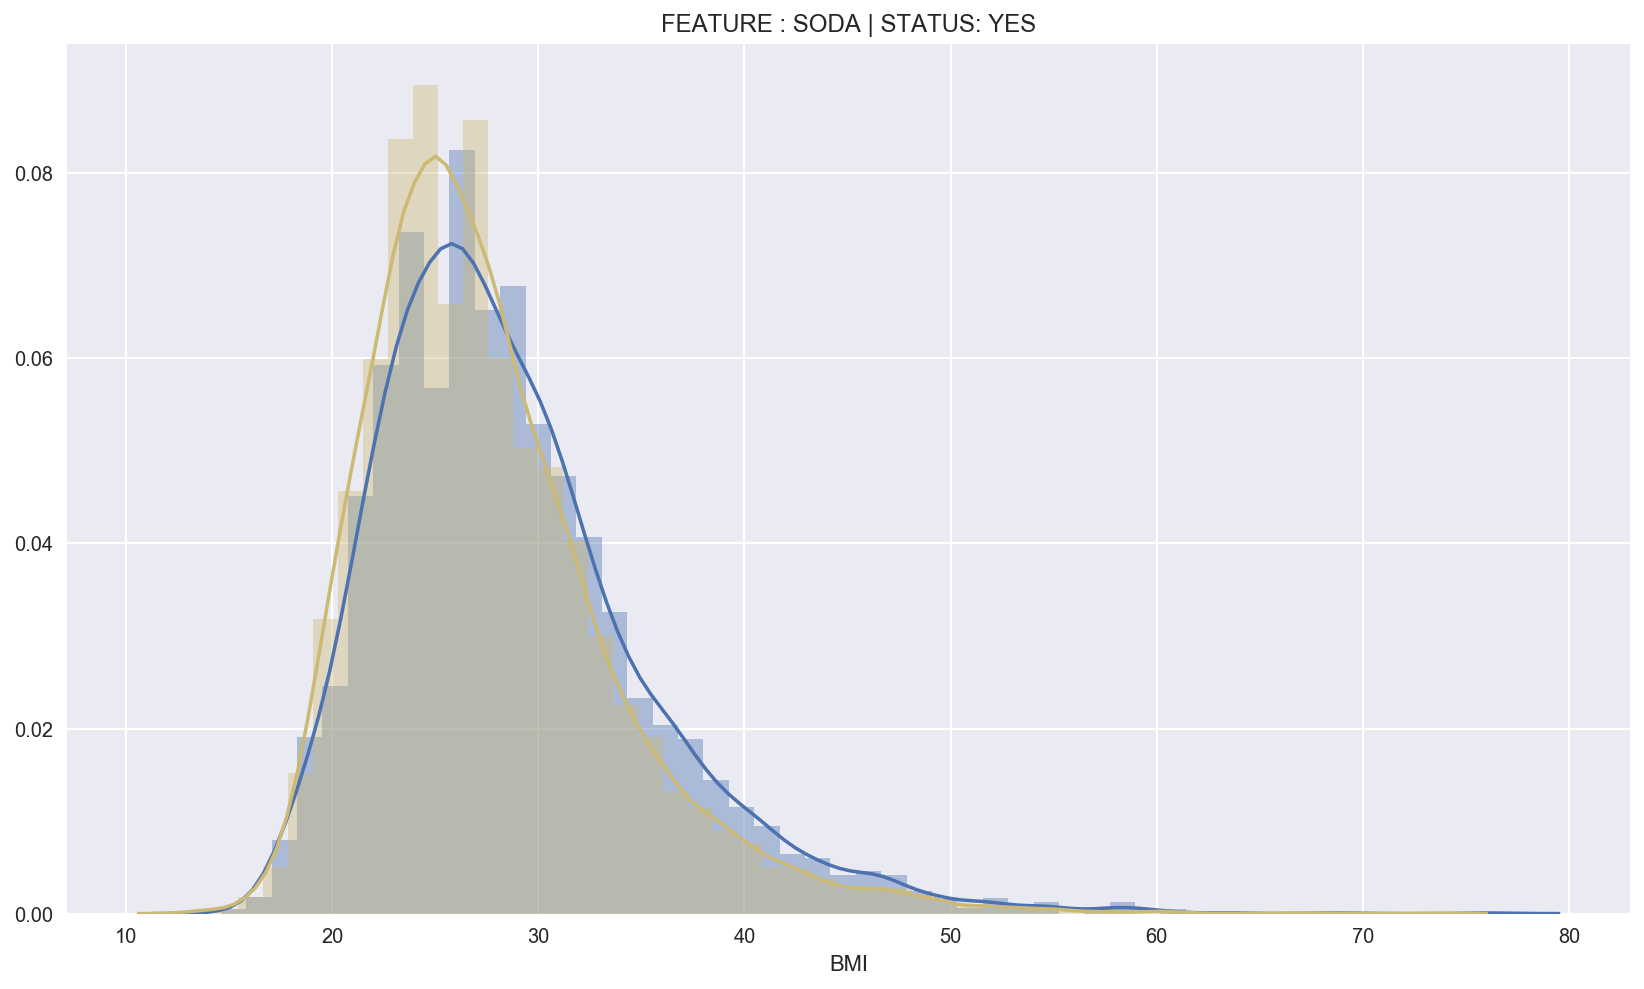

T-statistic: 11.8471891138 p-value: 2.82933581925e-32
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


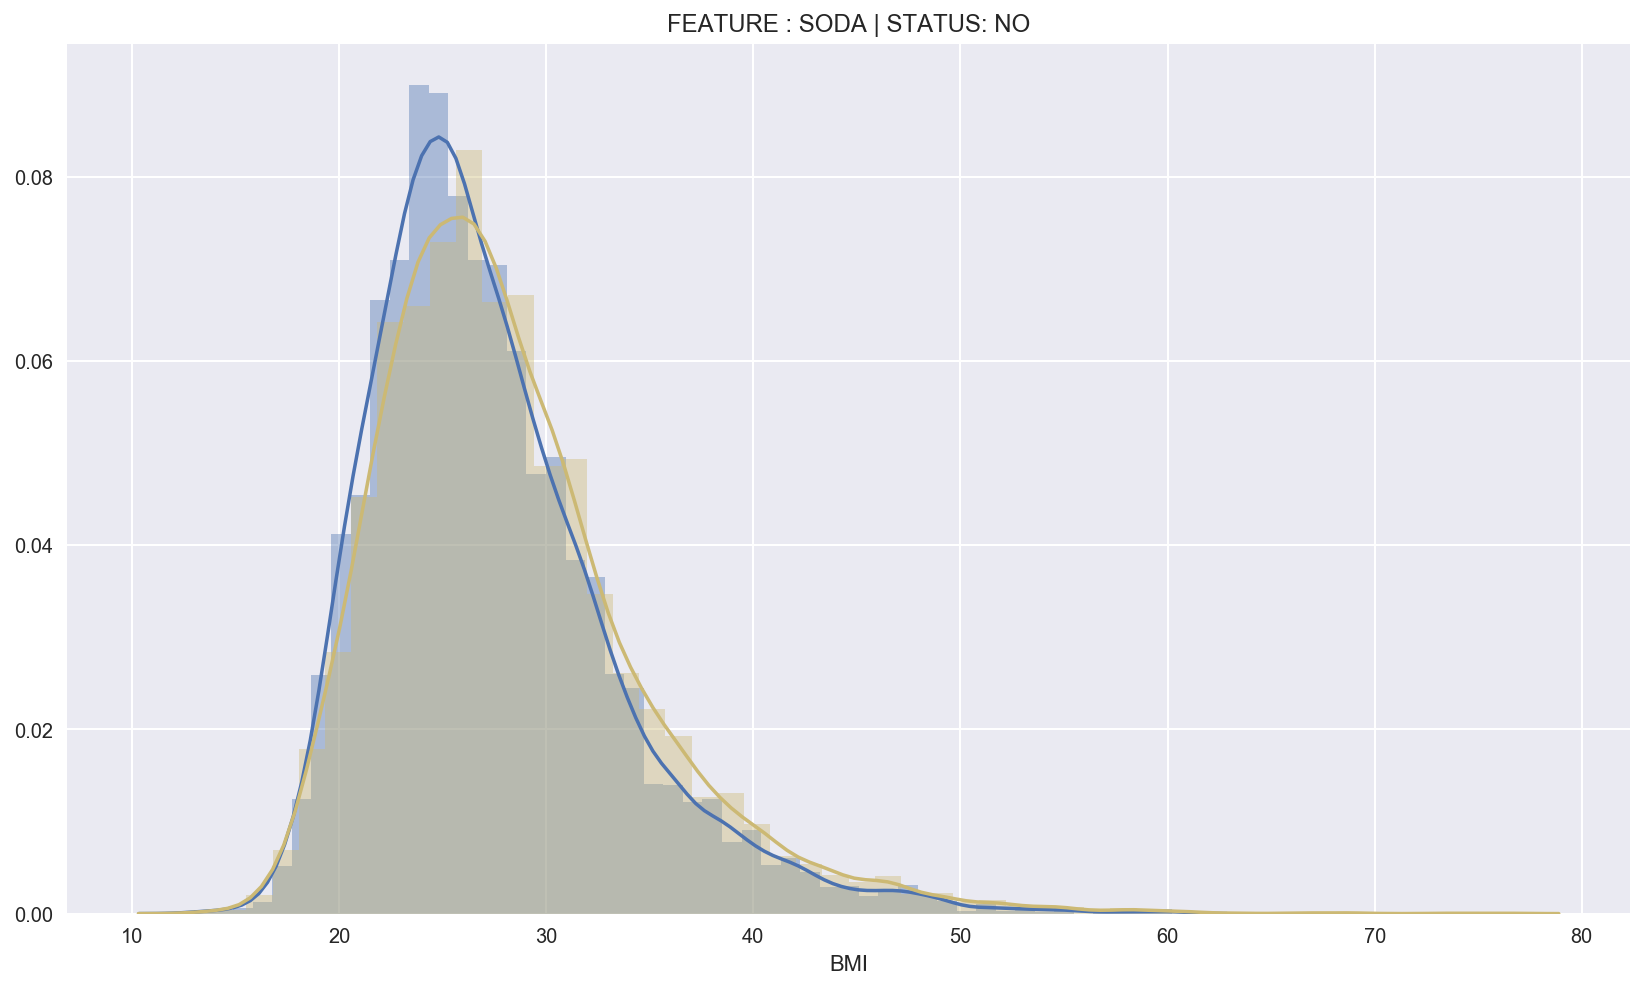

T-statistic: -9.68693961832 p-value: 3.81812436321e-22
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


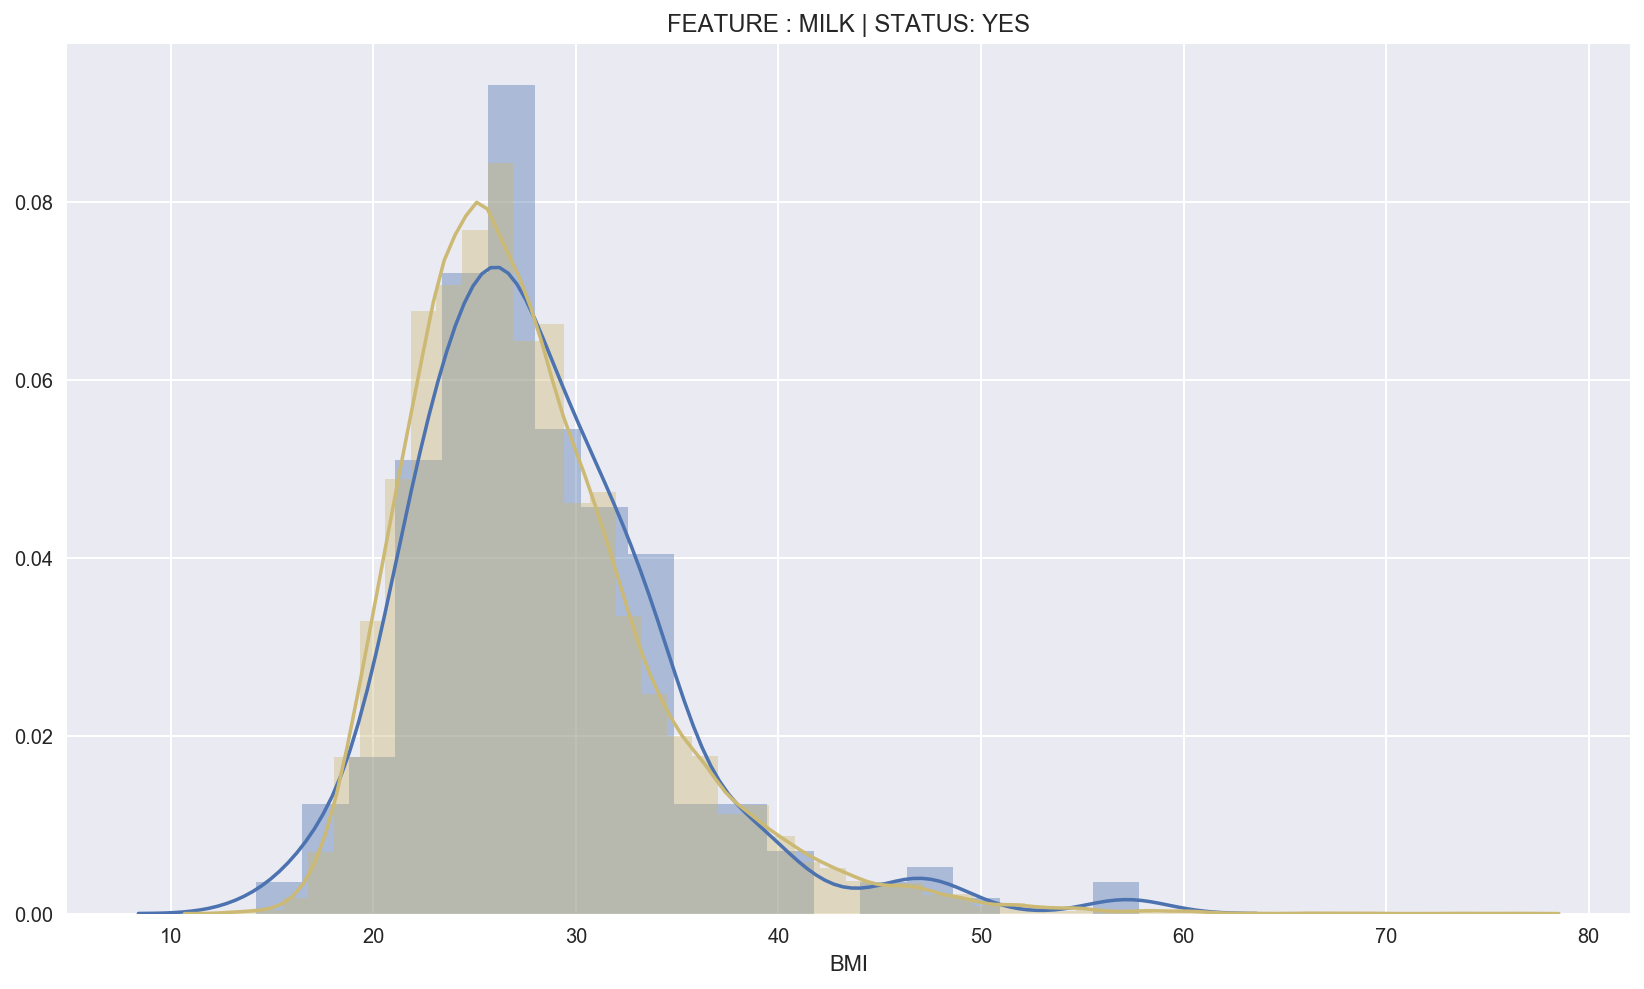

T-statistic: 1.00191997015 p-value: 0.316393954995
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


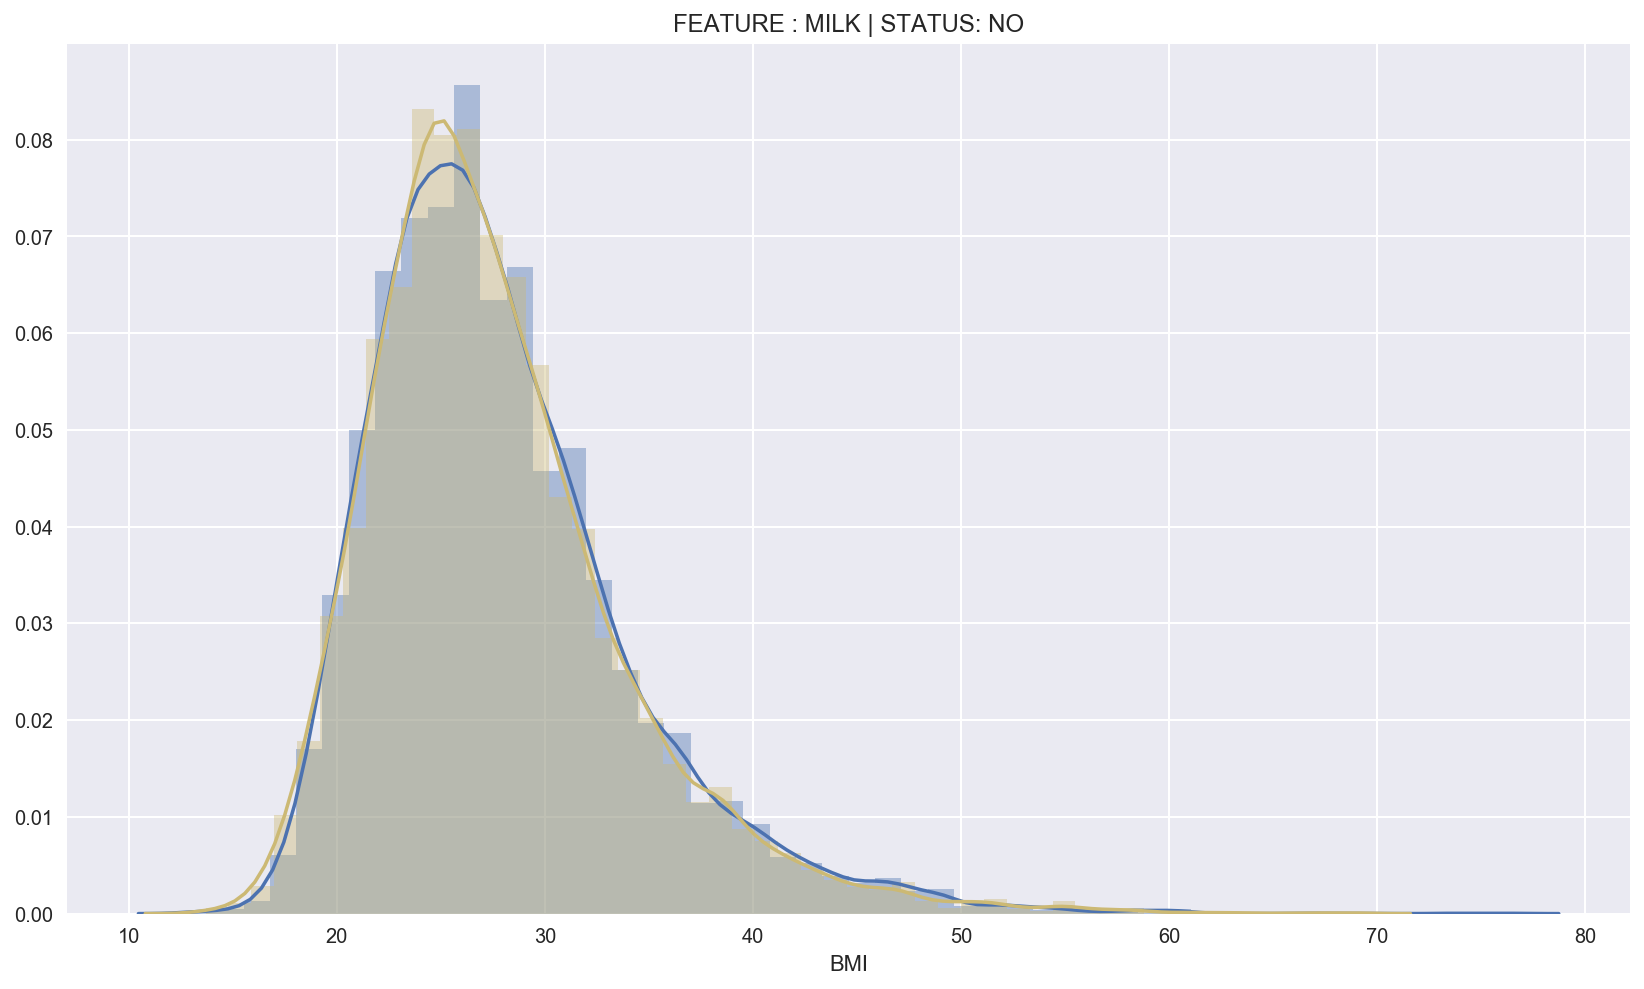

T-statistic: 2.29757902921 p-value: 0.0215956840527
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


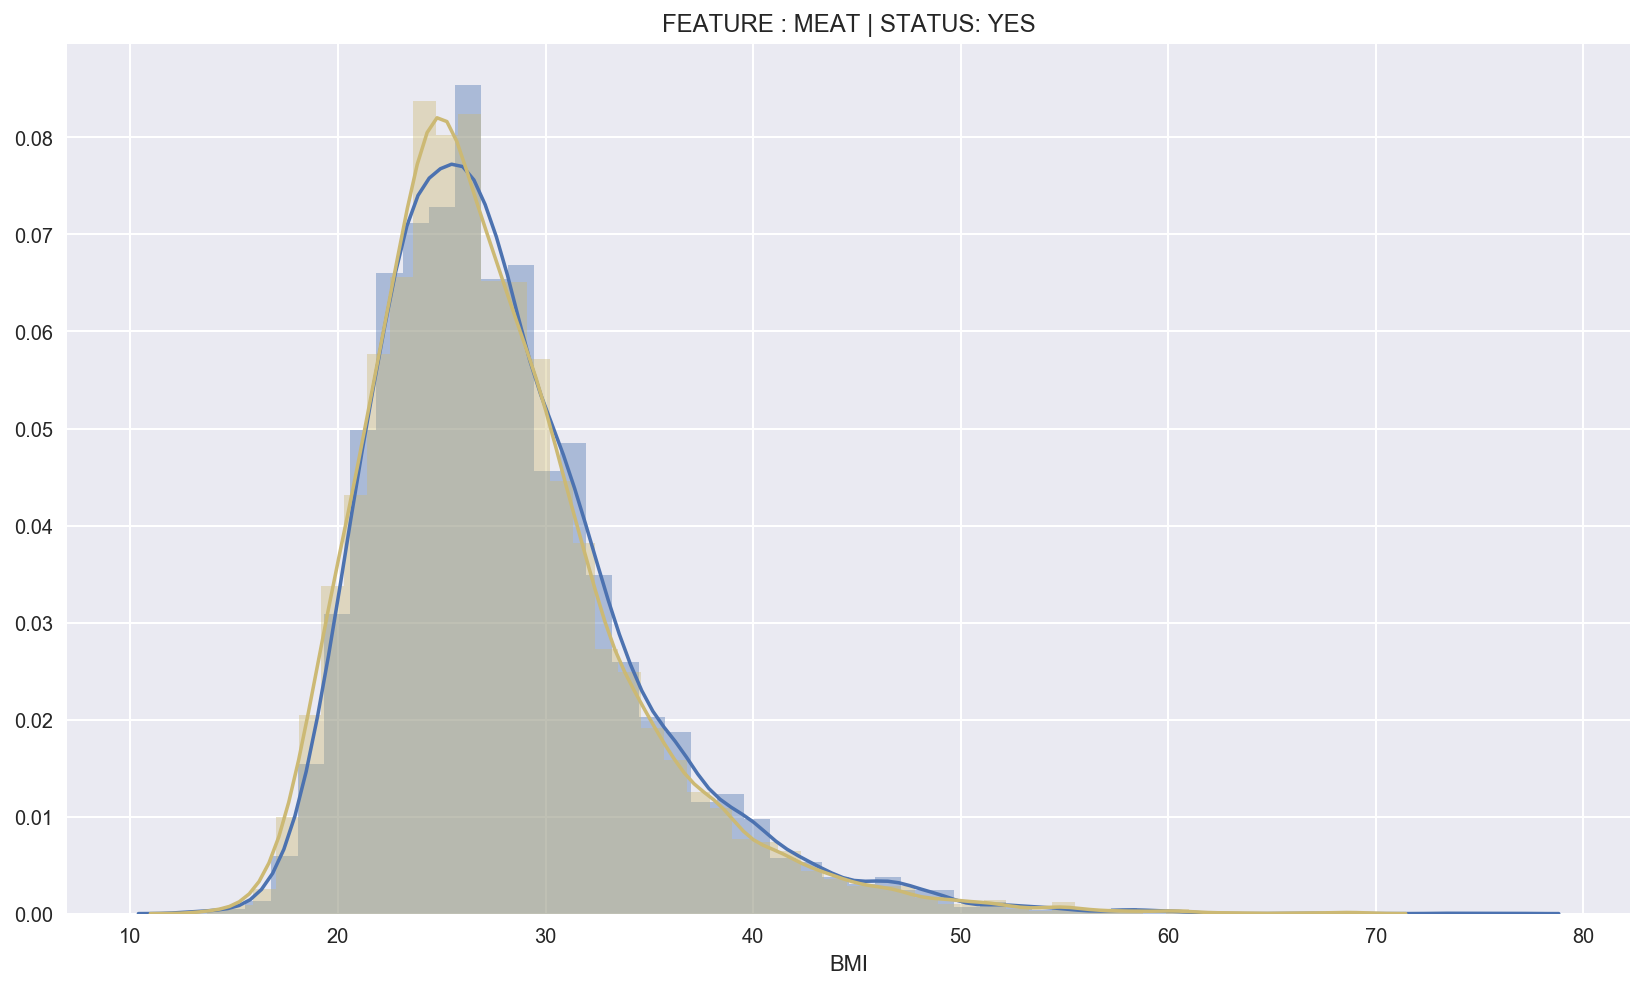

T-statistic: 4.4348015634 p-value: 9.26314383924e-06
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


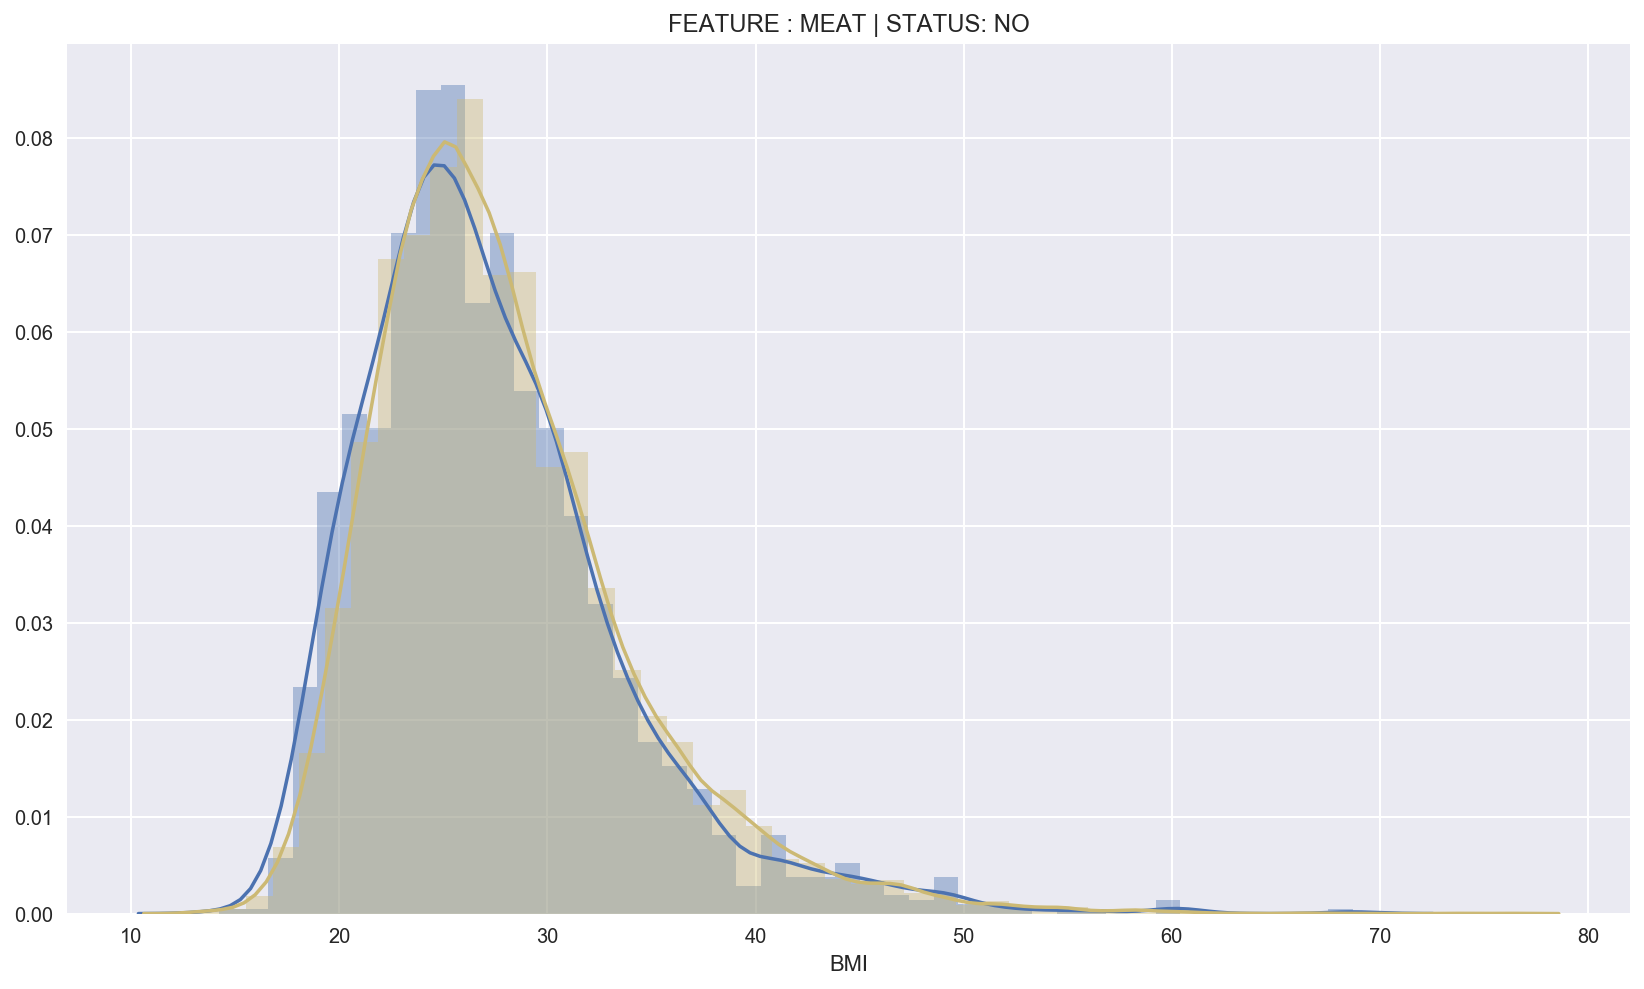

T-statistic: -3.61870323036 p-value: 0.000296787945814
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


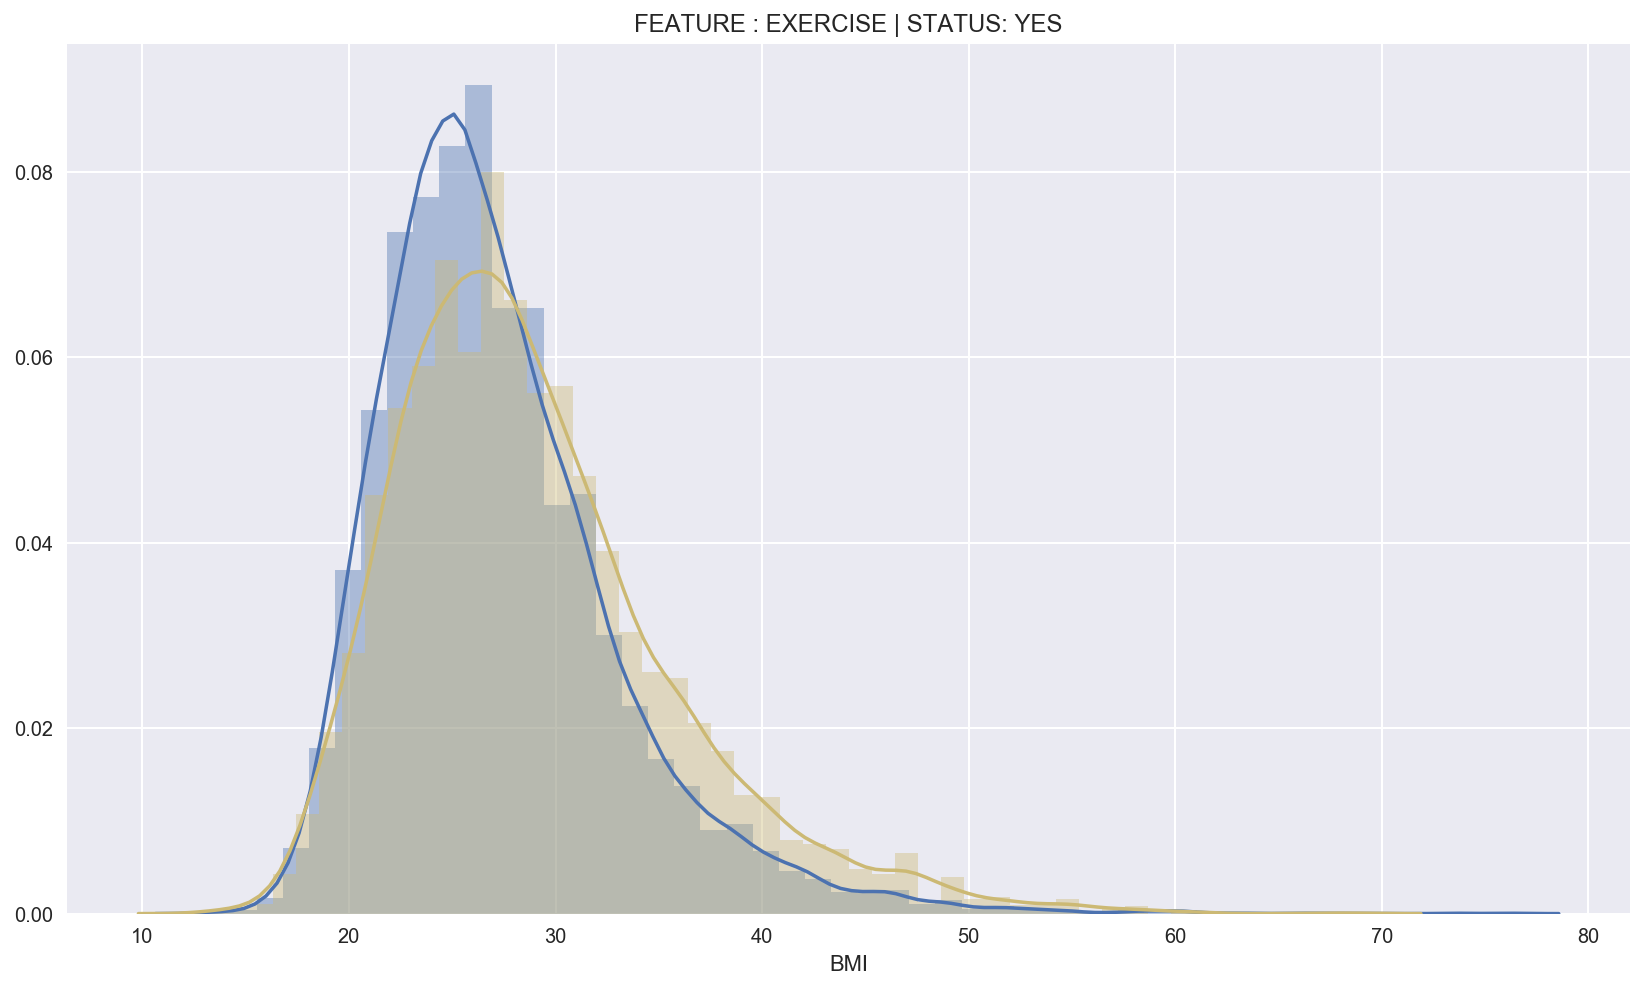

T-statistic: -19.2640171169 p-value: 5.61884001424e-82
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


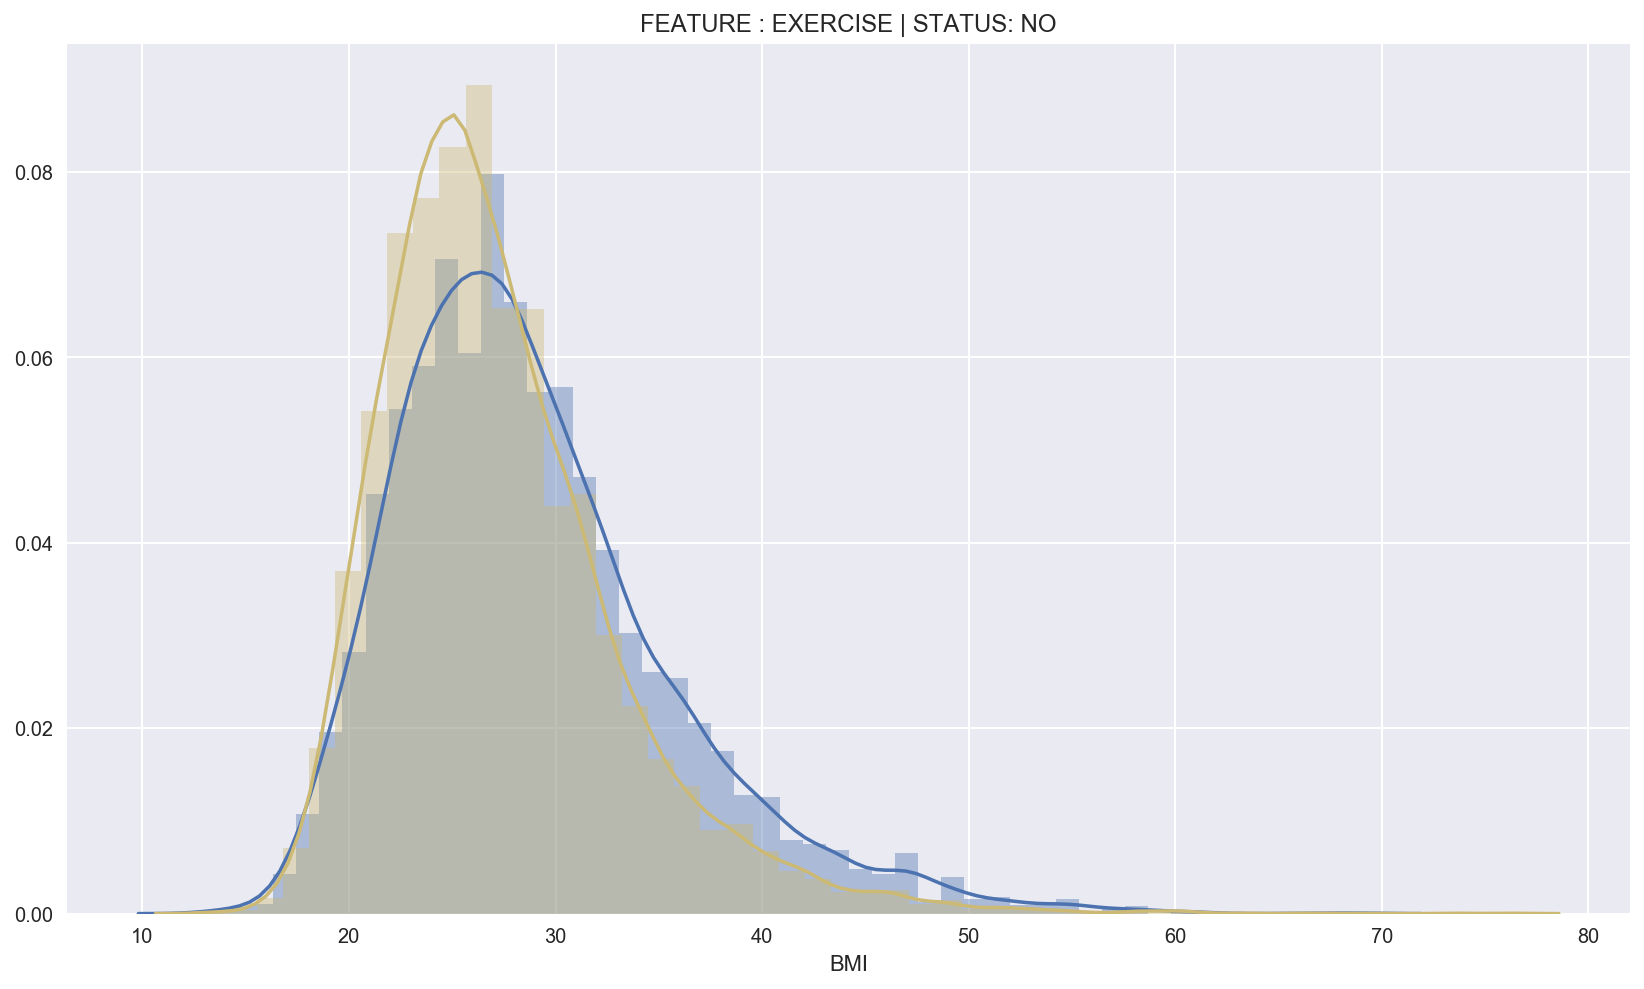

T-statistic: 19.2470431275 p-value: 7.75300105844e-82
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


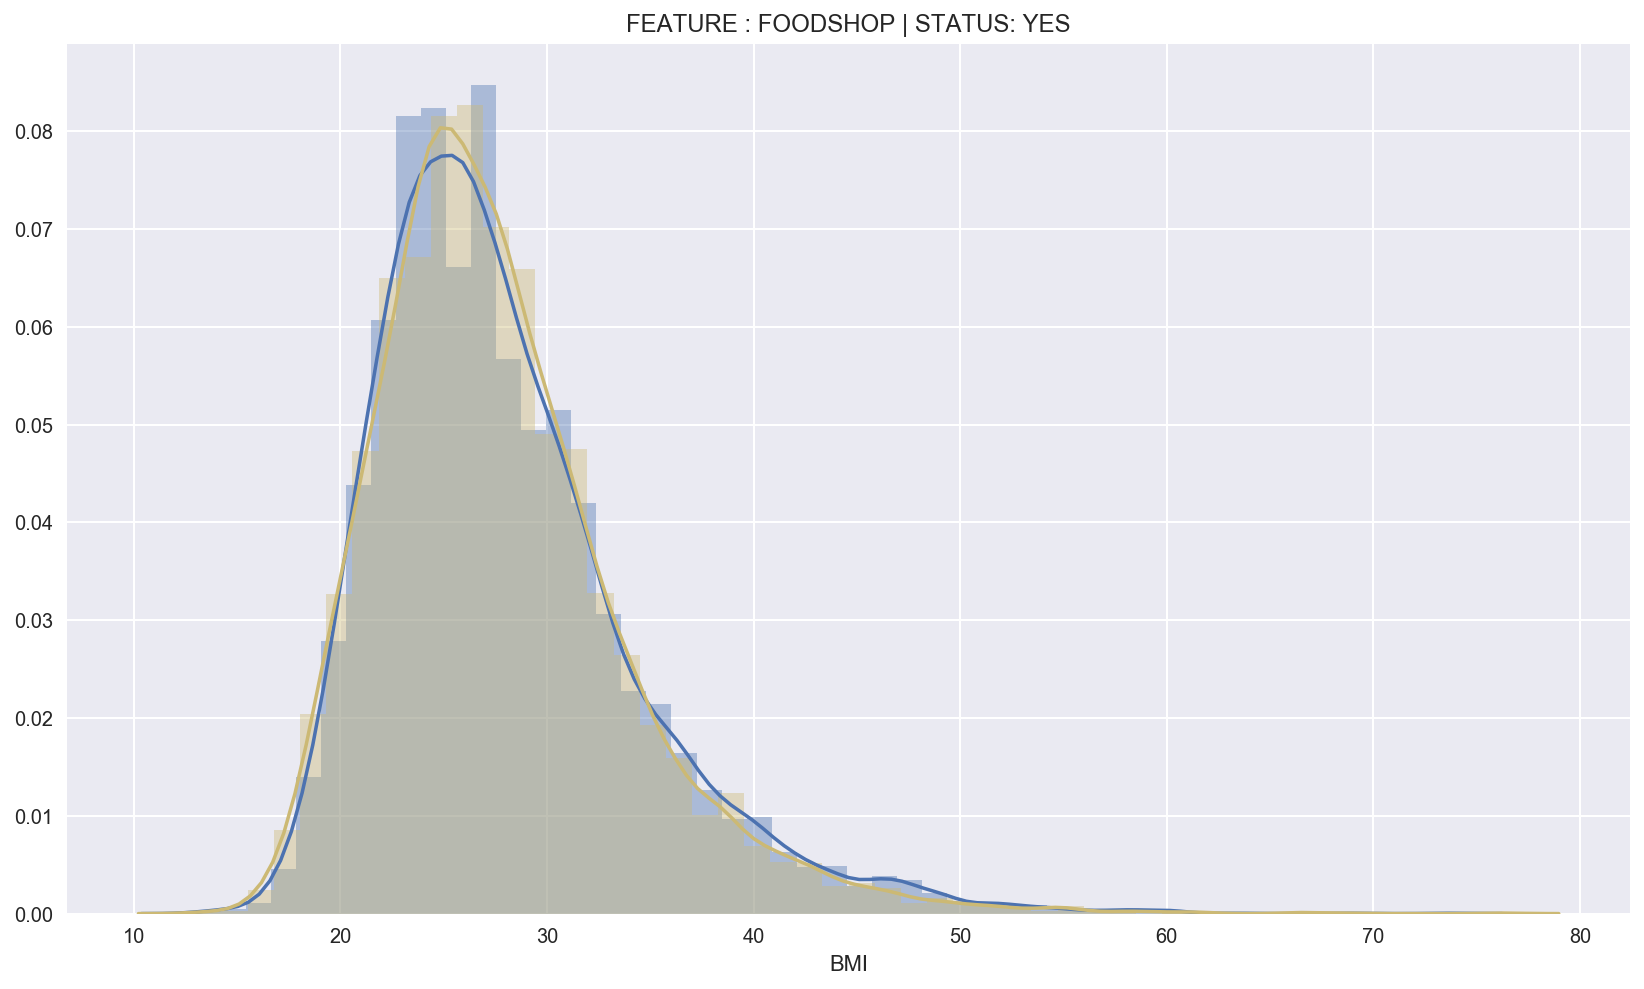

T-statistic: 3.05485758496 p-value: 0.00225453611869
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


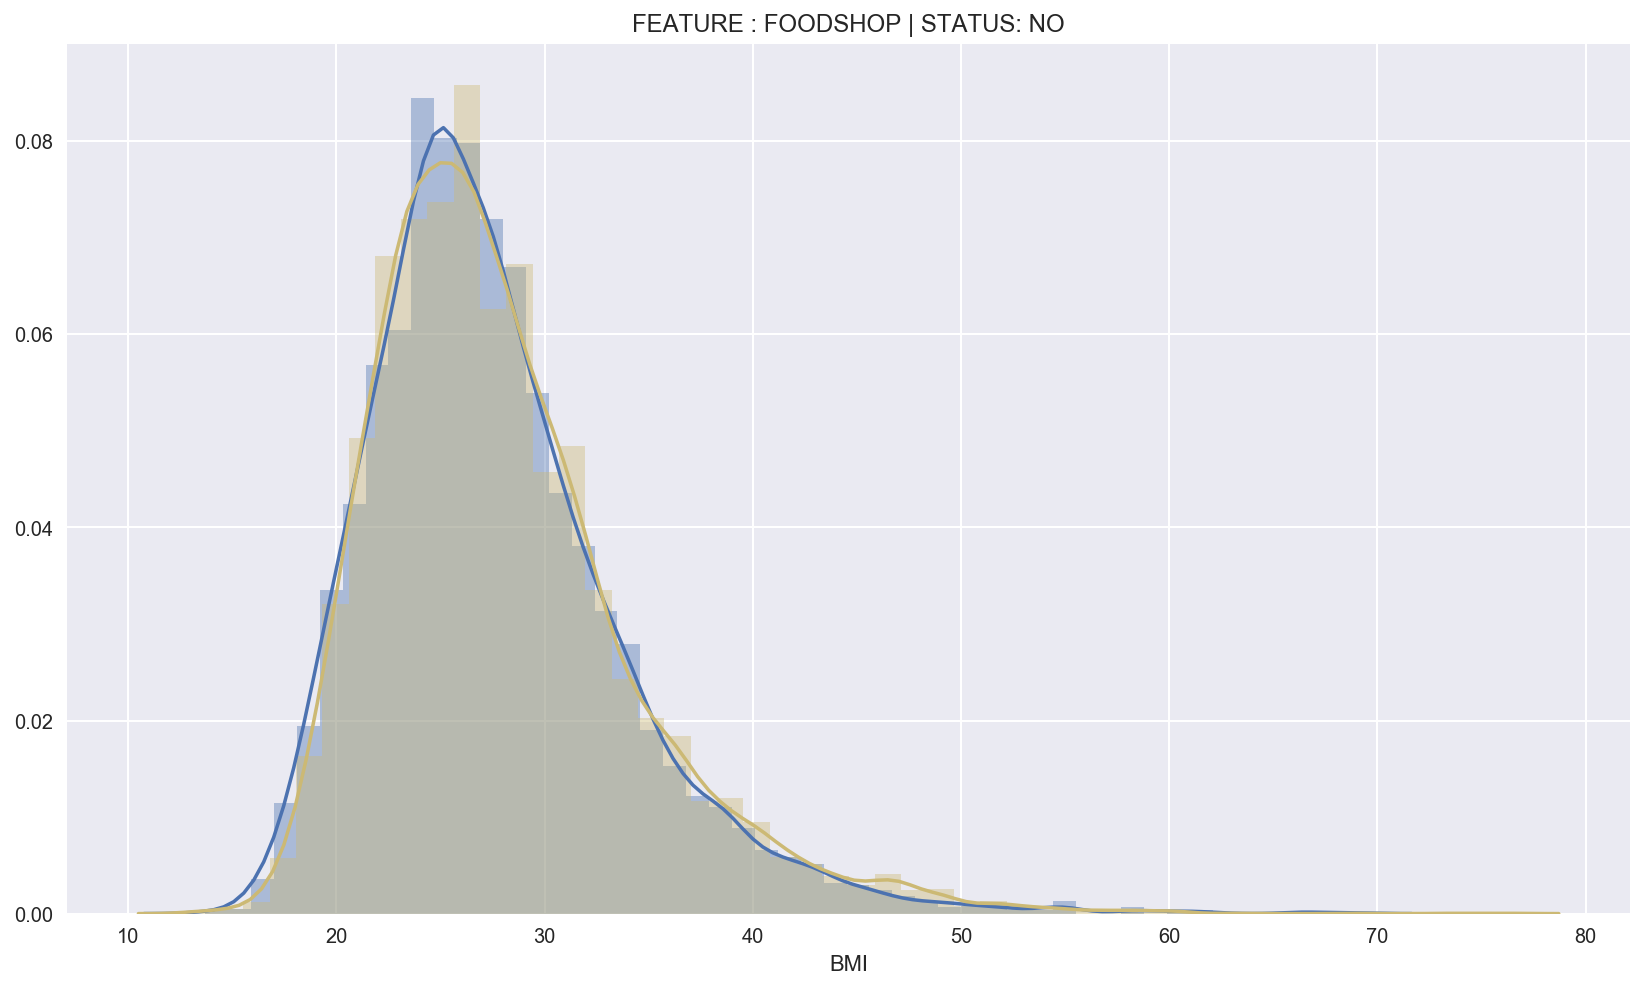

T-statistic: -3.81826775099 p-value: 0.000134783585052
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


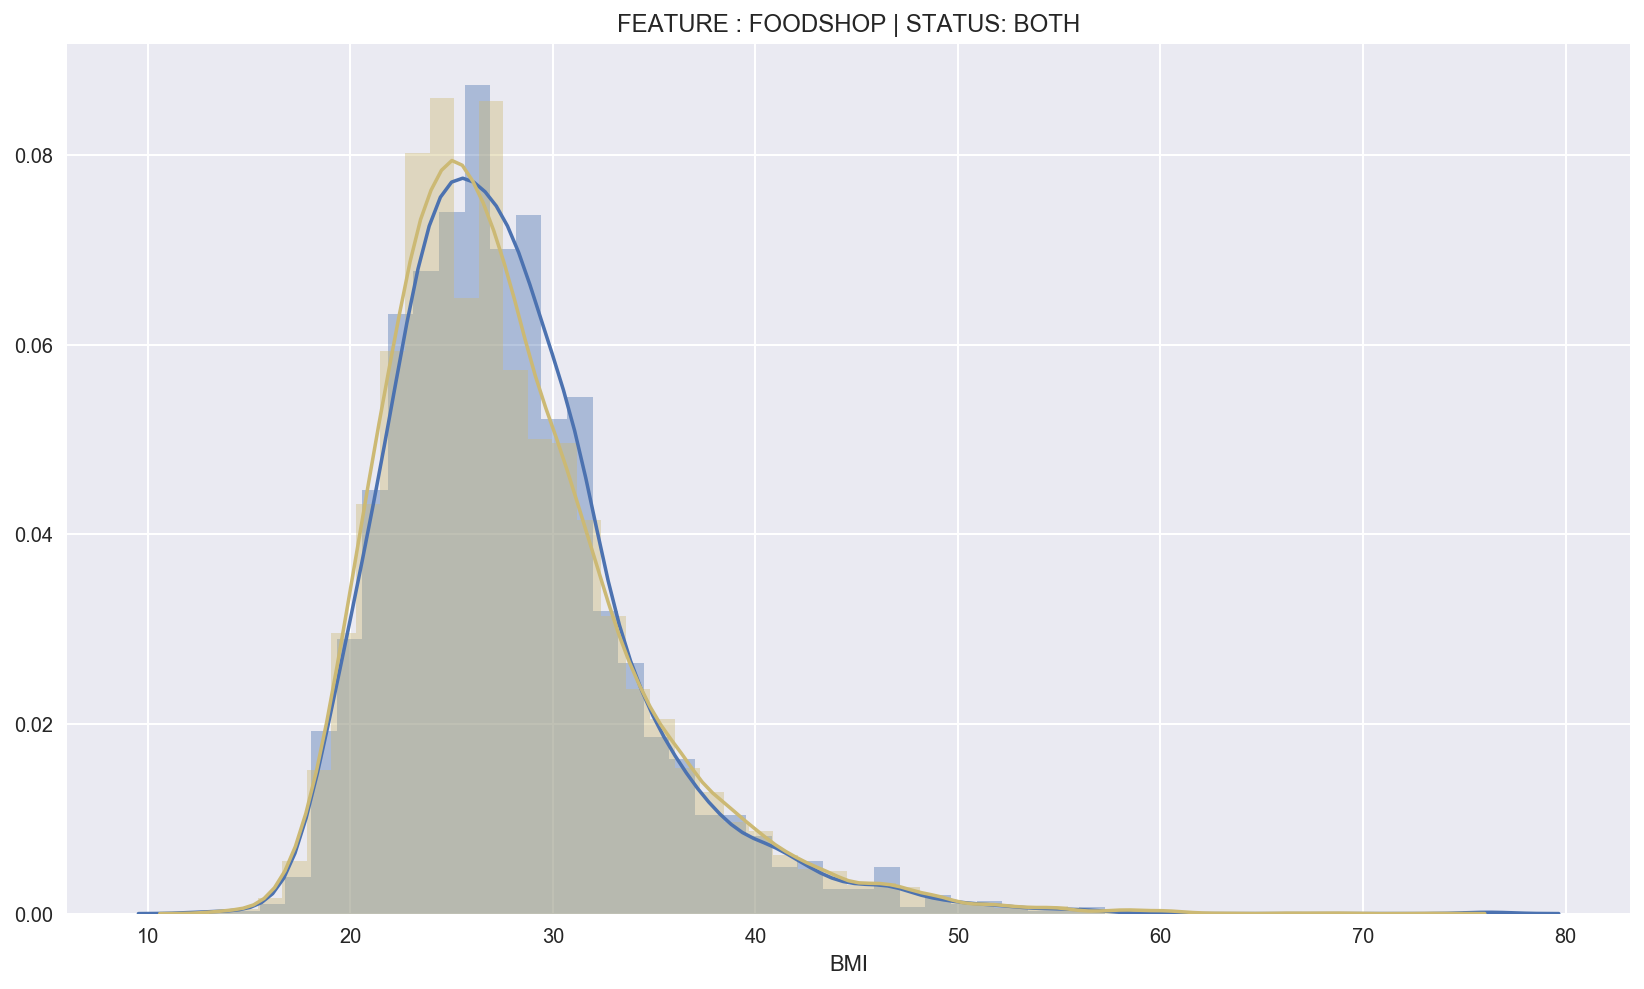

T-statistic: 0.655529180304 p-value: 0.512134388269
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


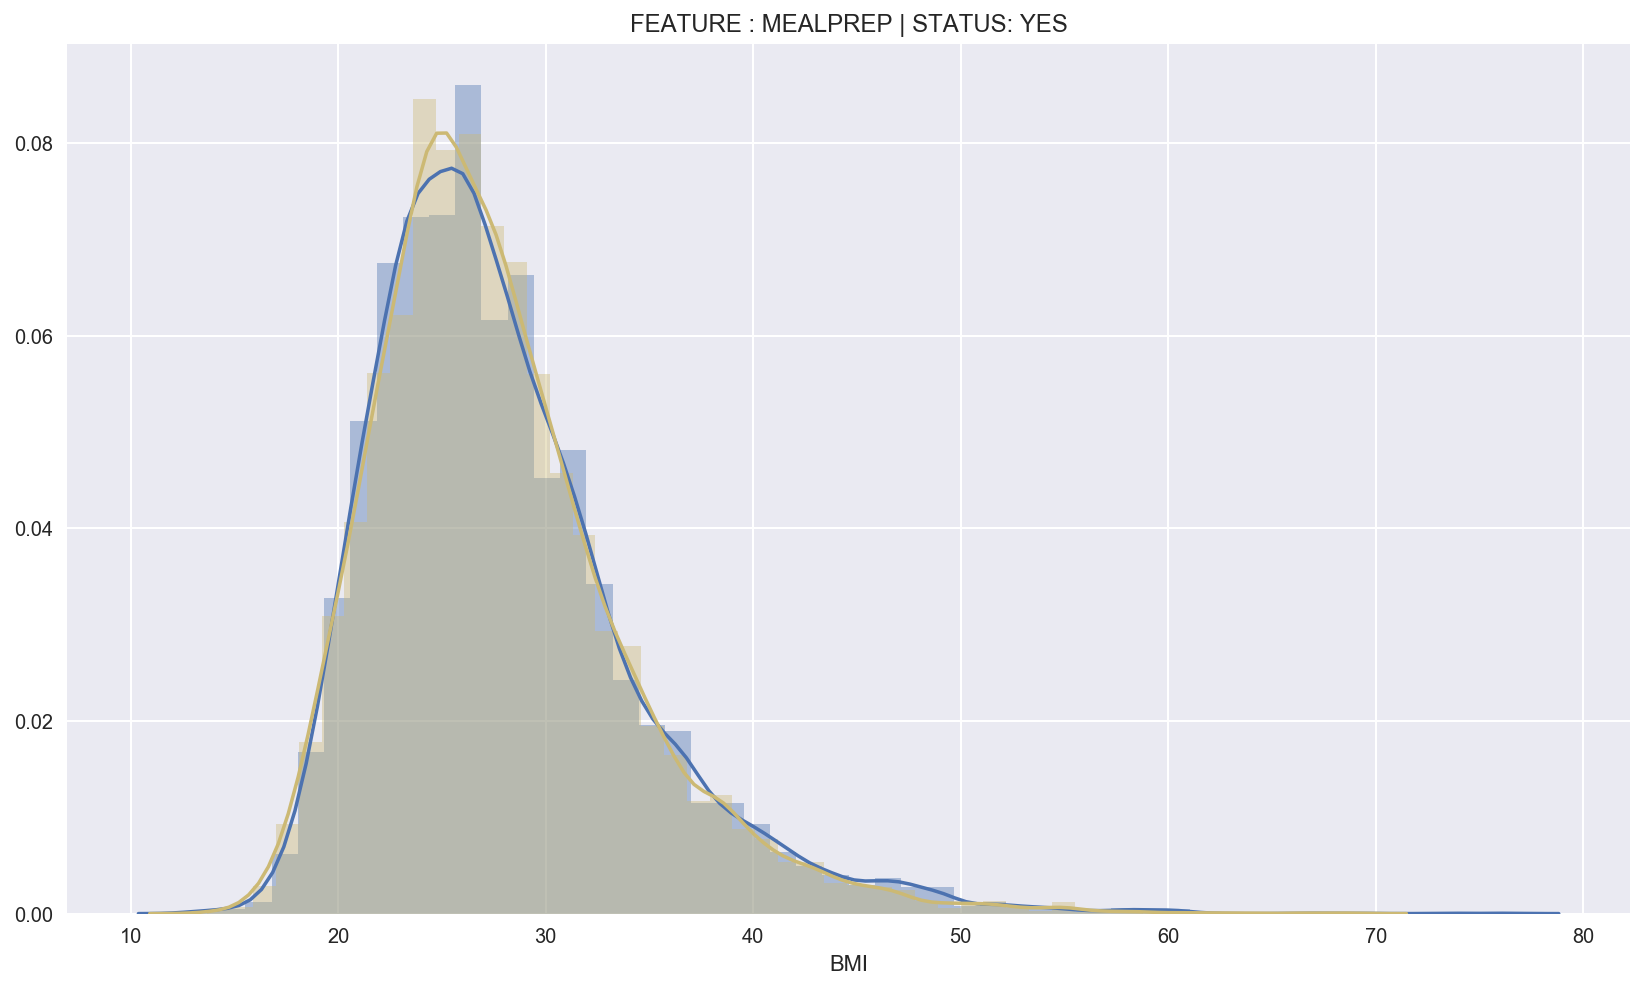

T-statistic: 2.43925584096 p-value: 0.0147258822021
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


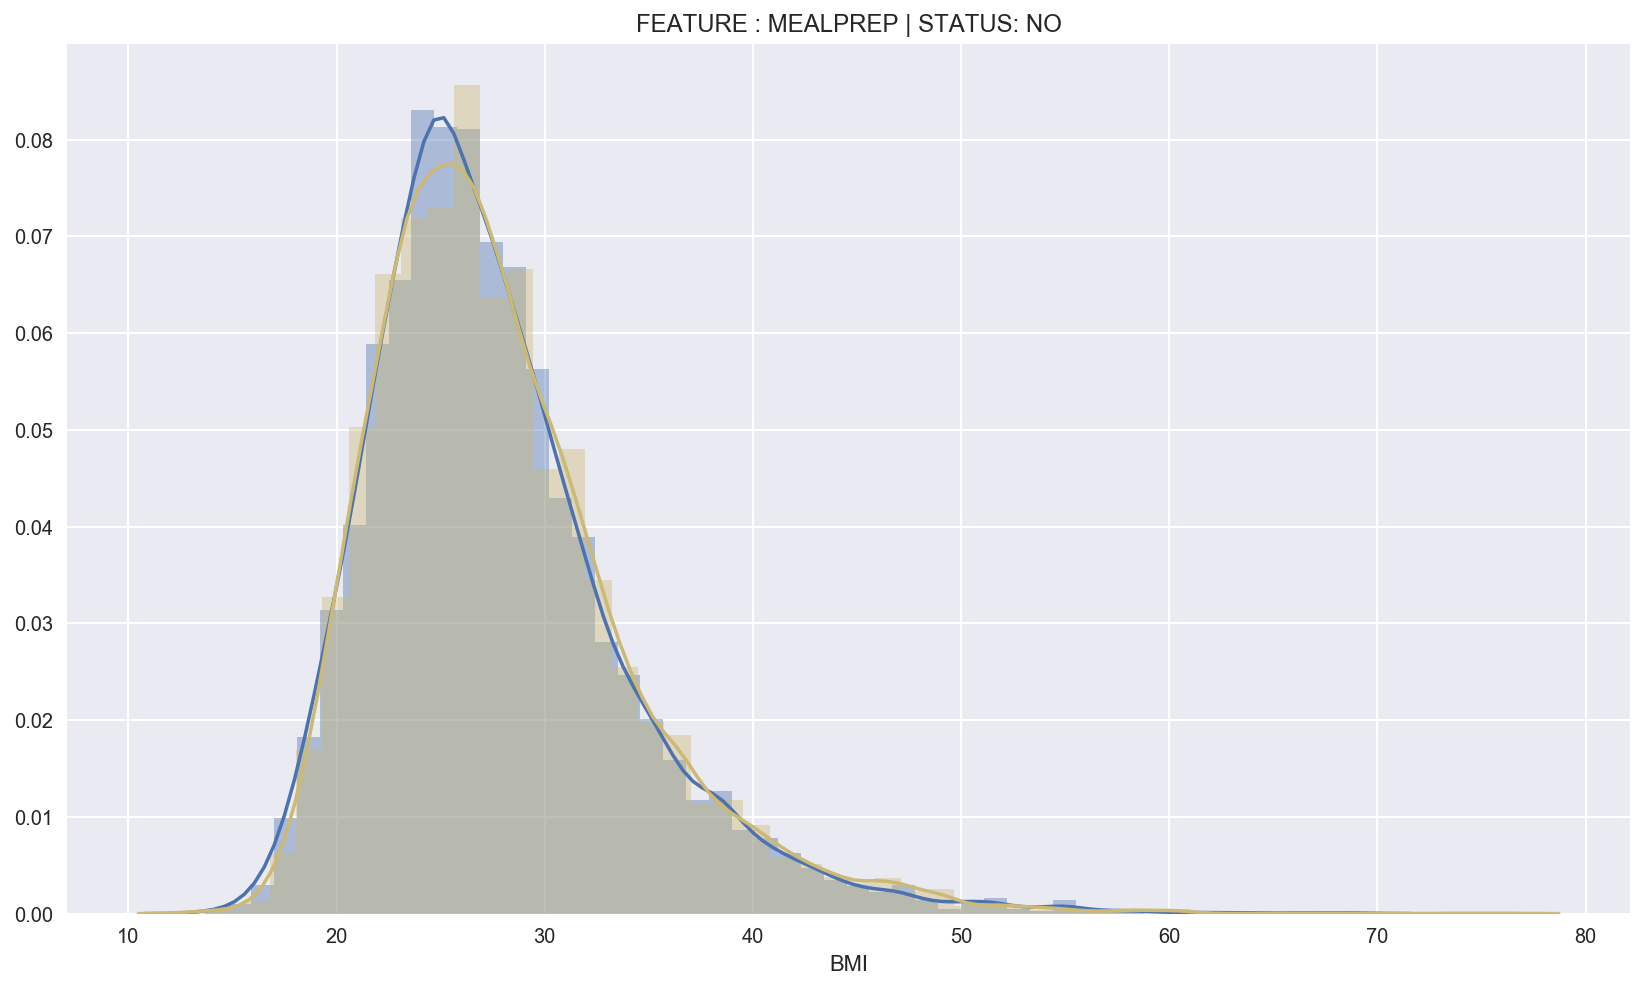

T-statistic: -2.50730732704 p-value: 0.0121730822439
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


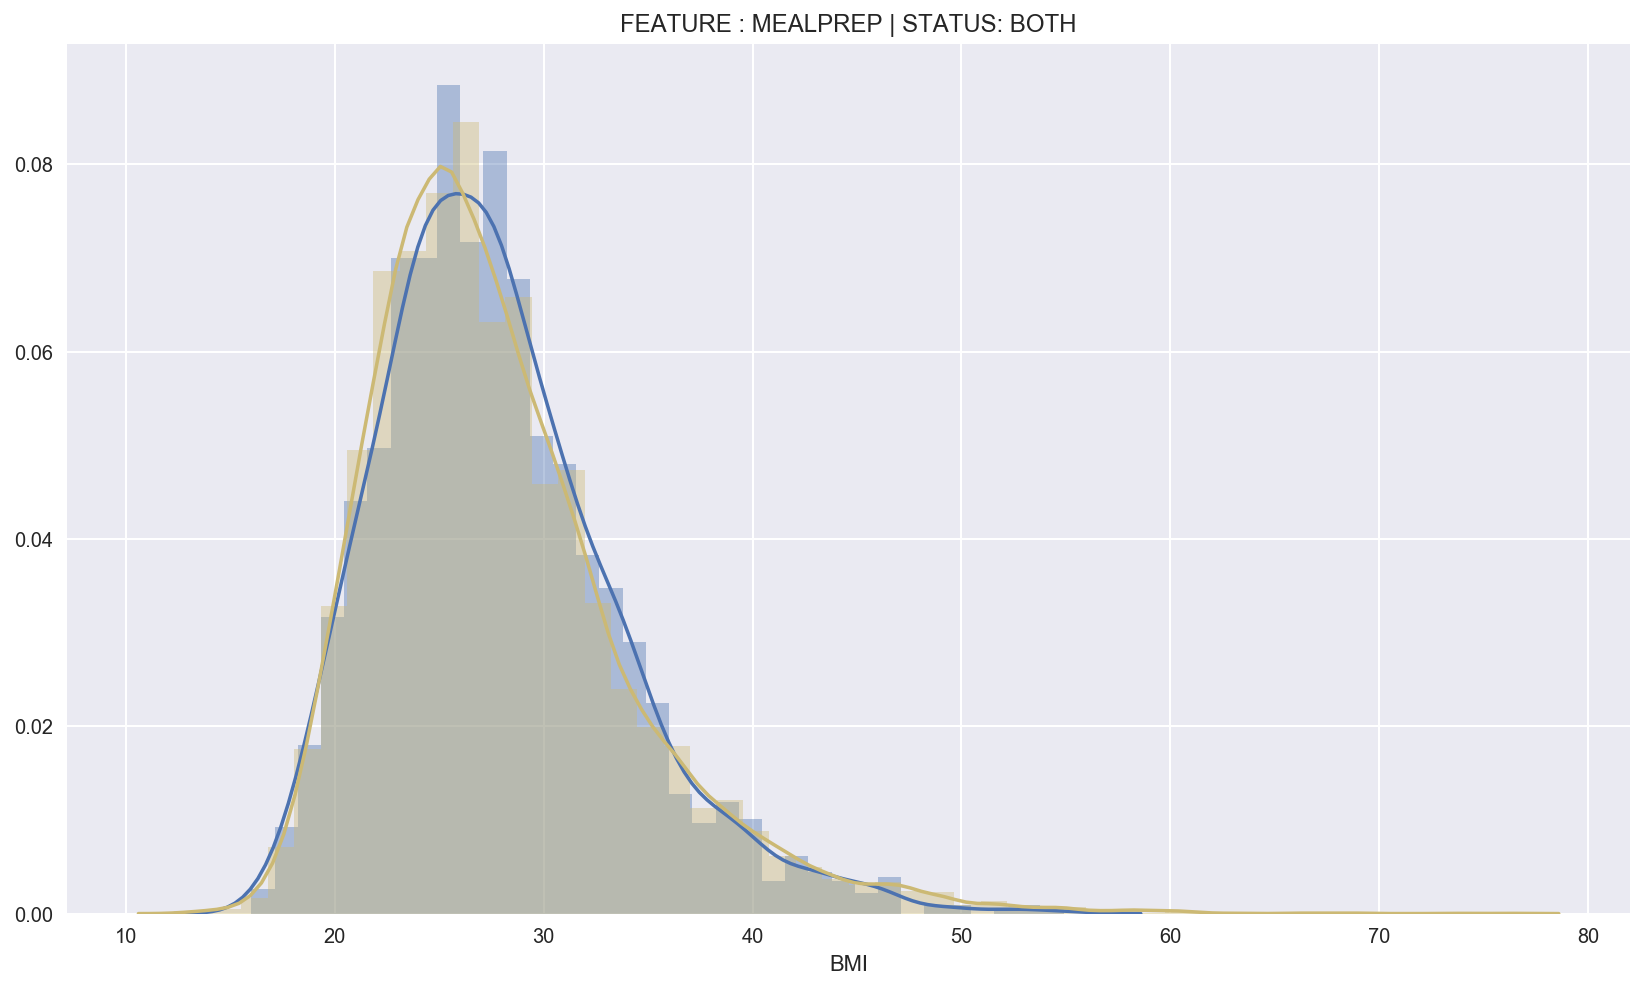

T-statistic: -0.245580617629 p-value: 0.806009328662
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


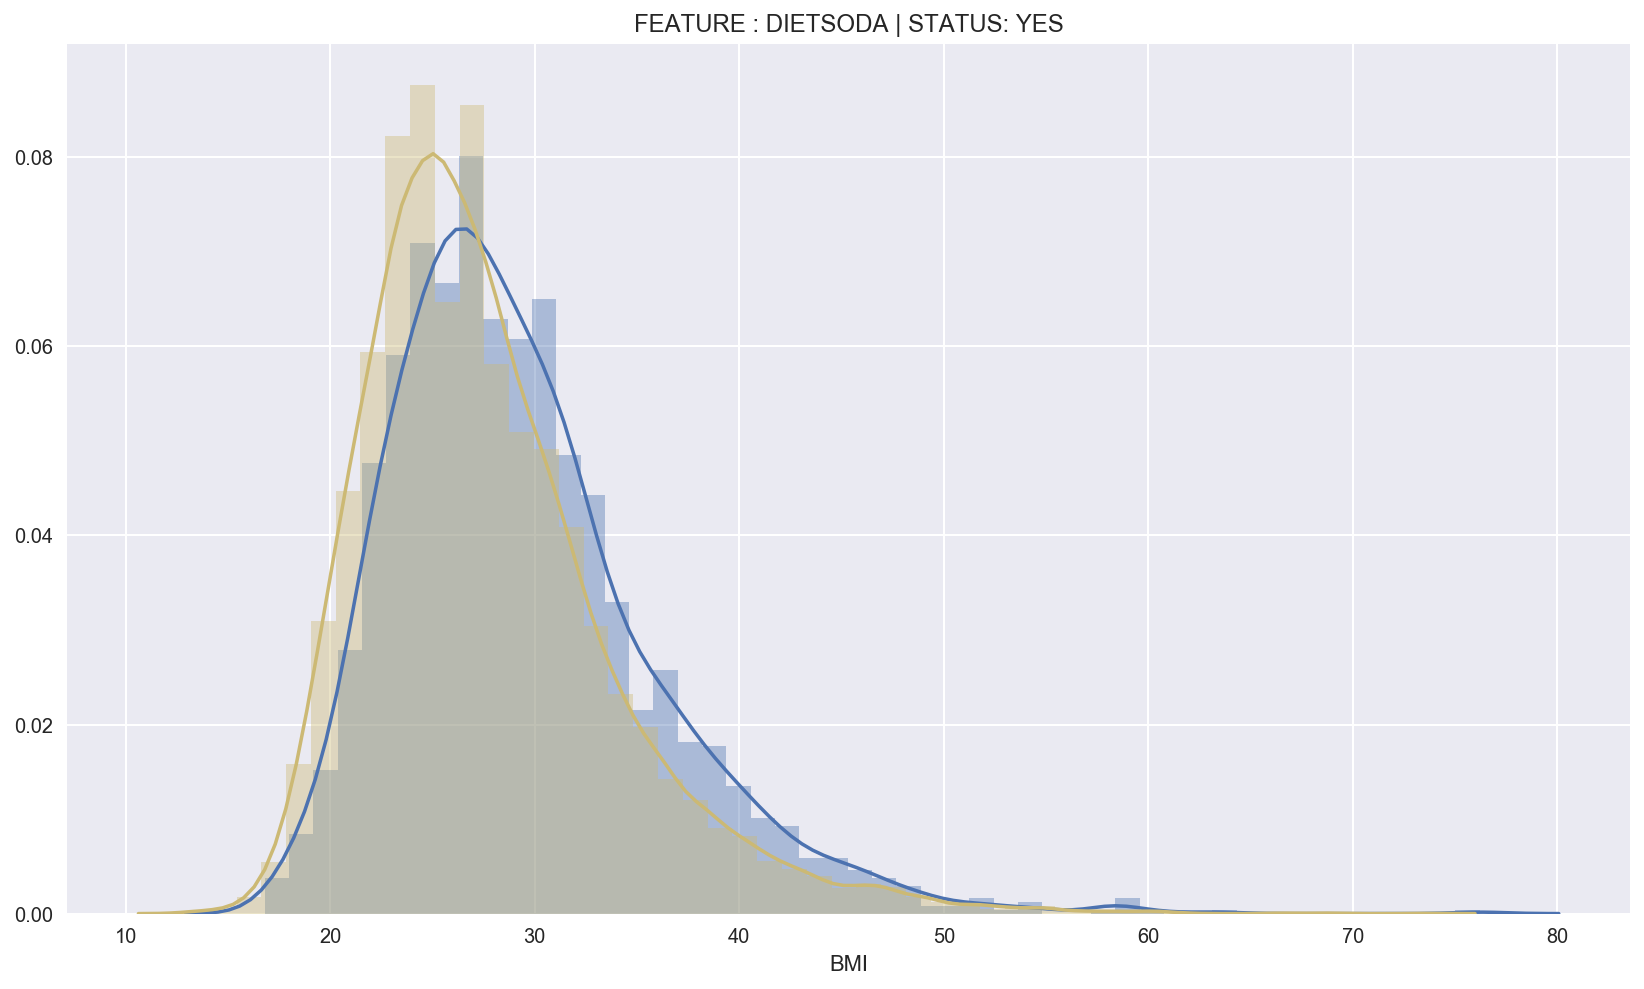

T-statistic: 11.9340039483 p-value: 1.00763998937e-32
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


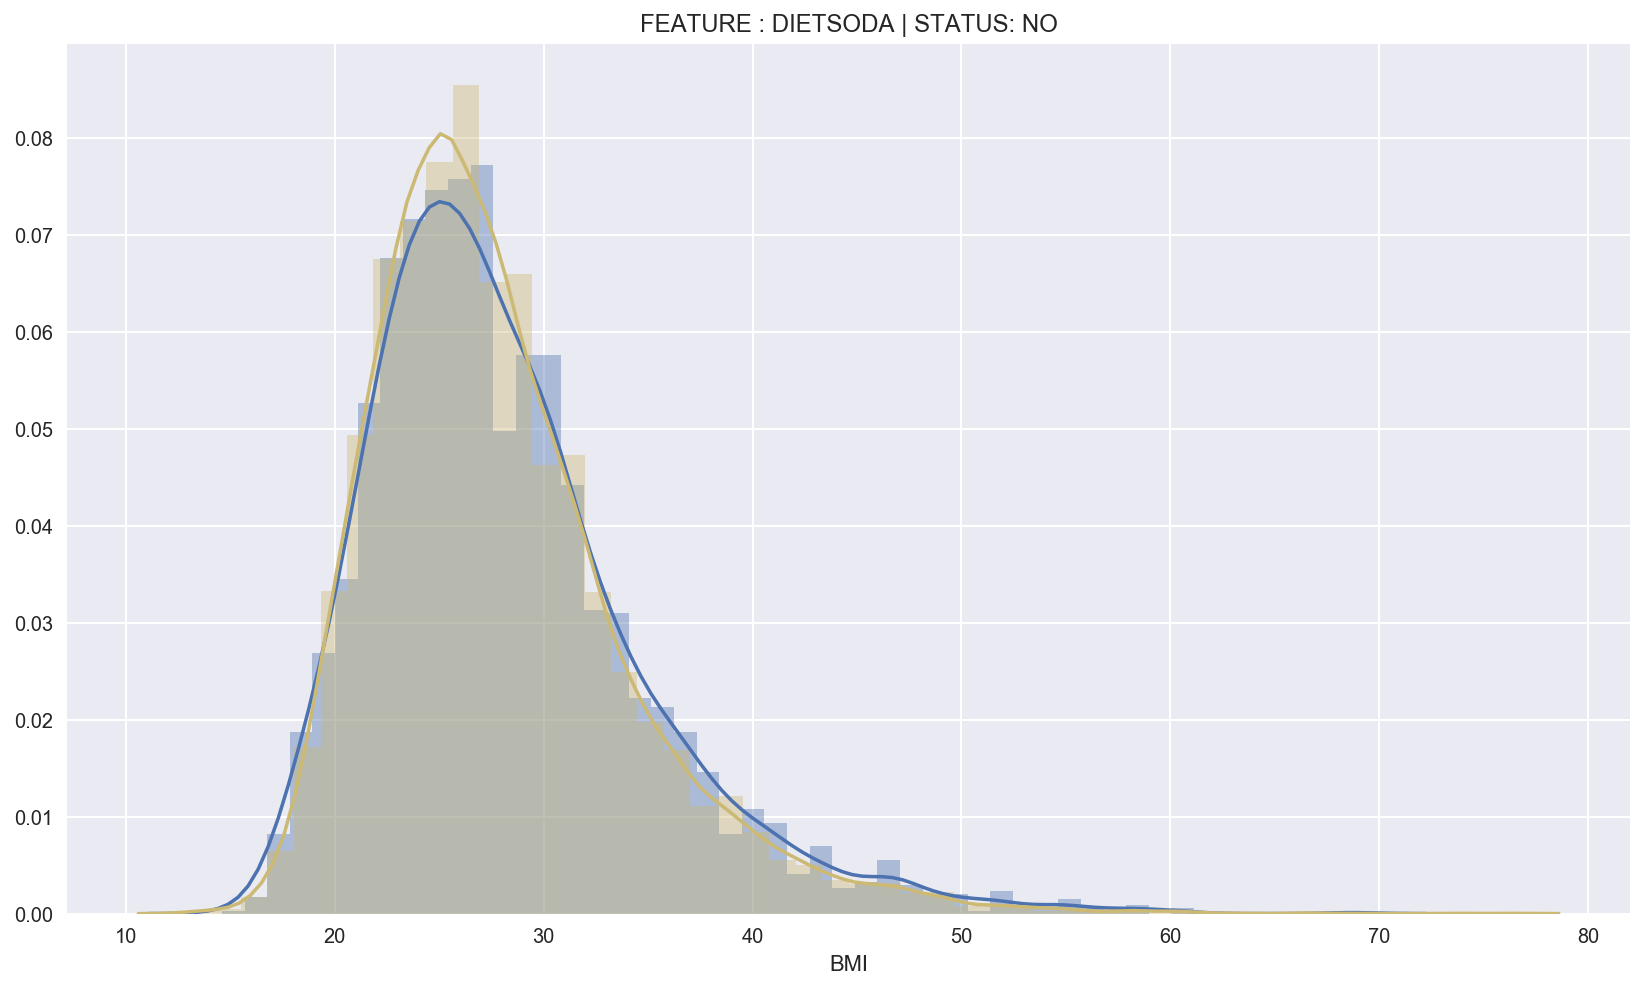

T-statistic: 3.2924407123 p-value: 0.000994881642564
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


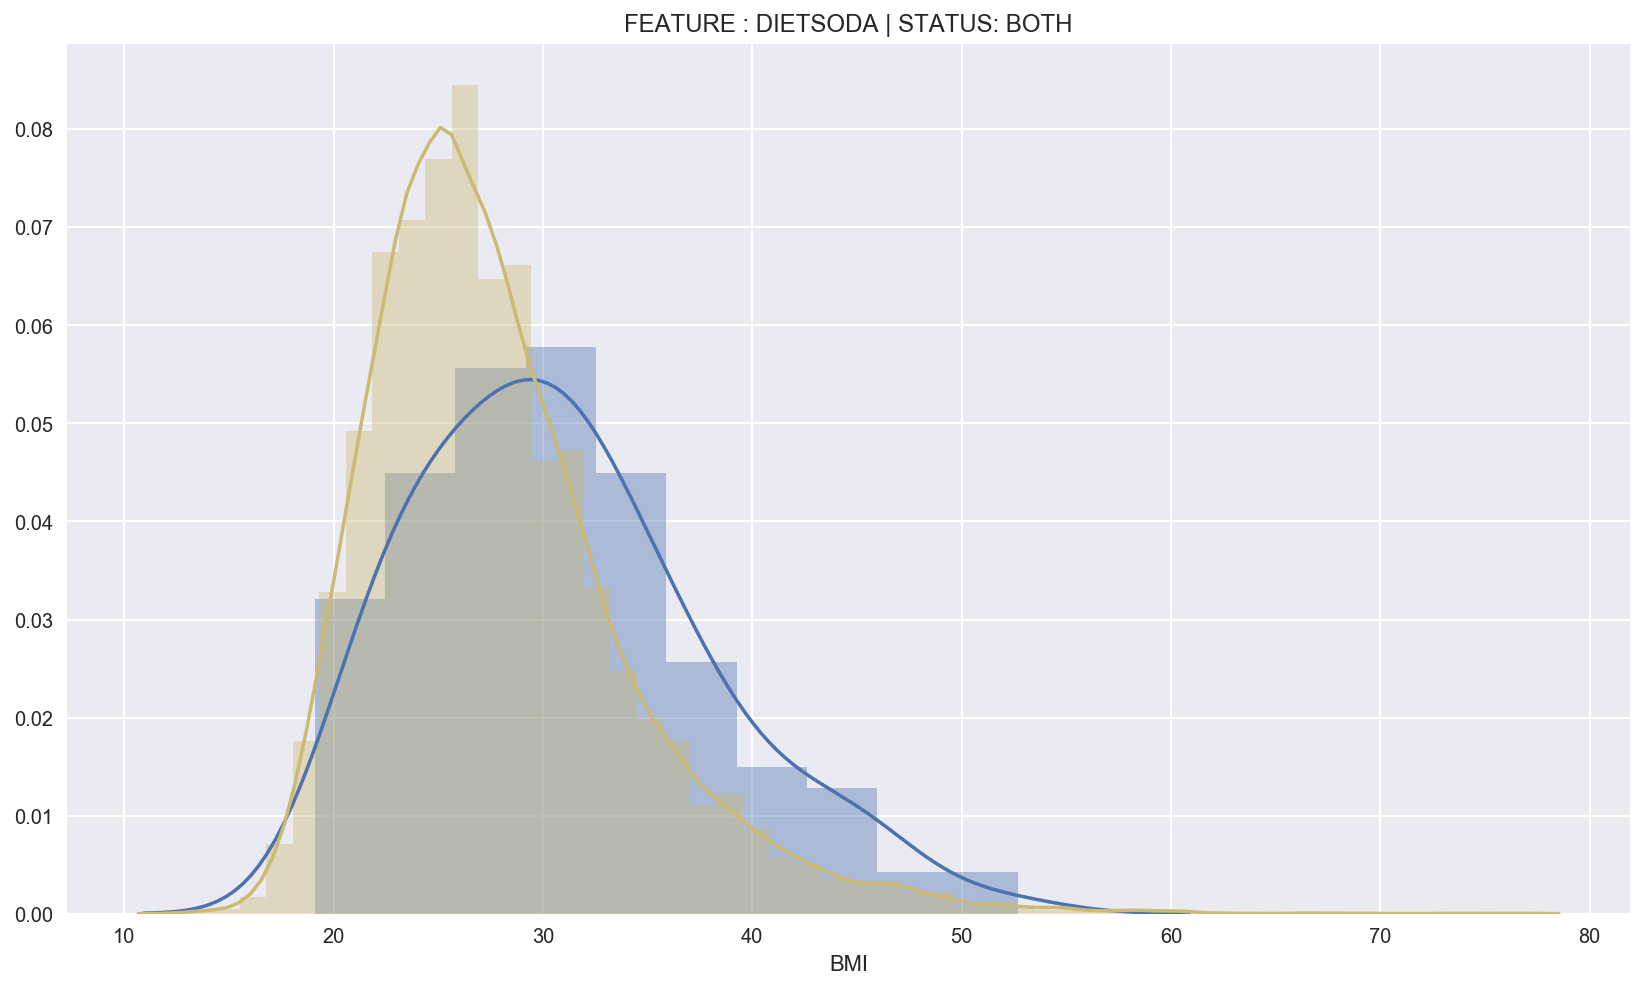

T-statistic: 5.73025247441 p-value: 1.01673382237e-08
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


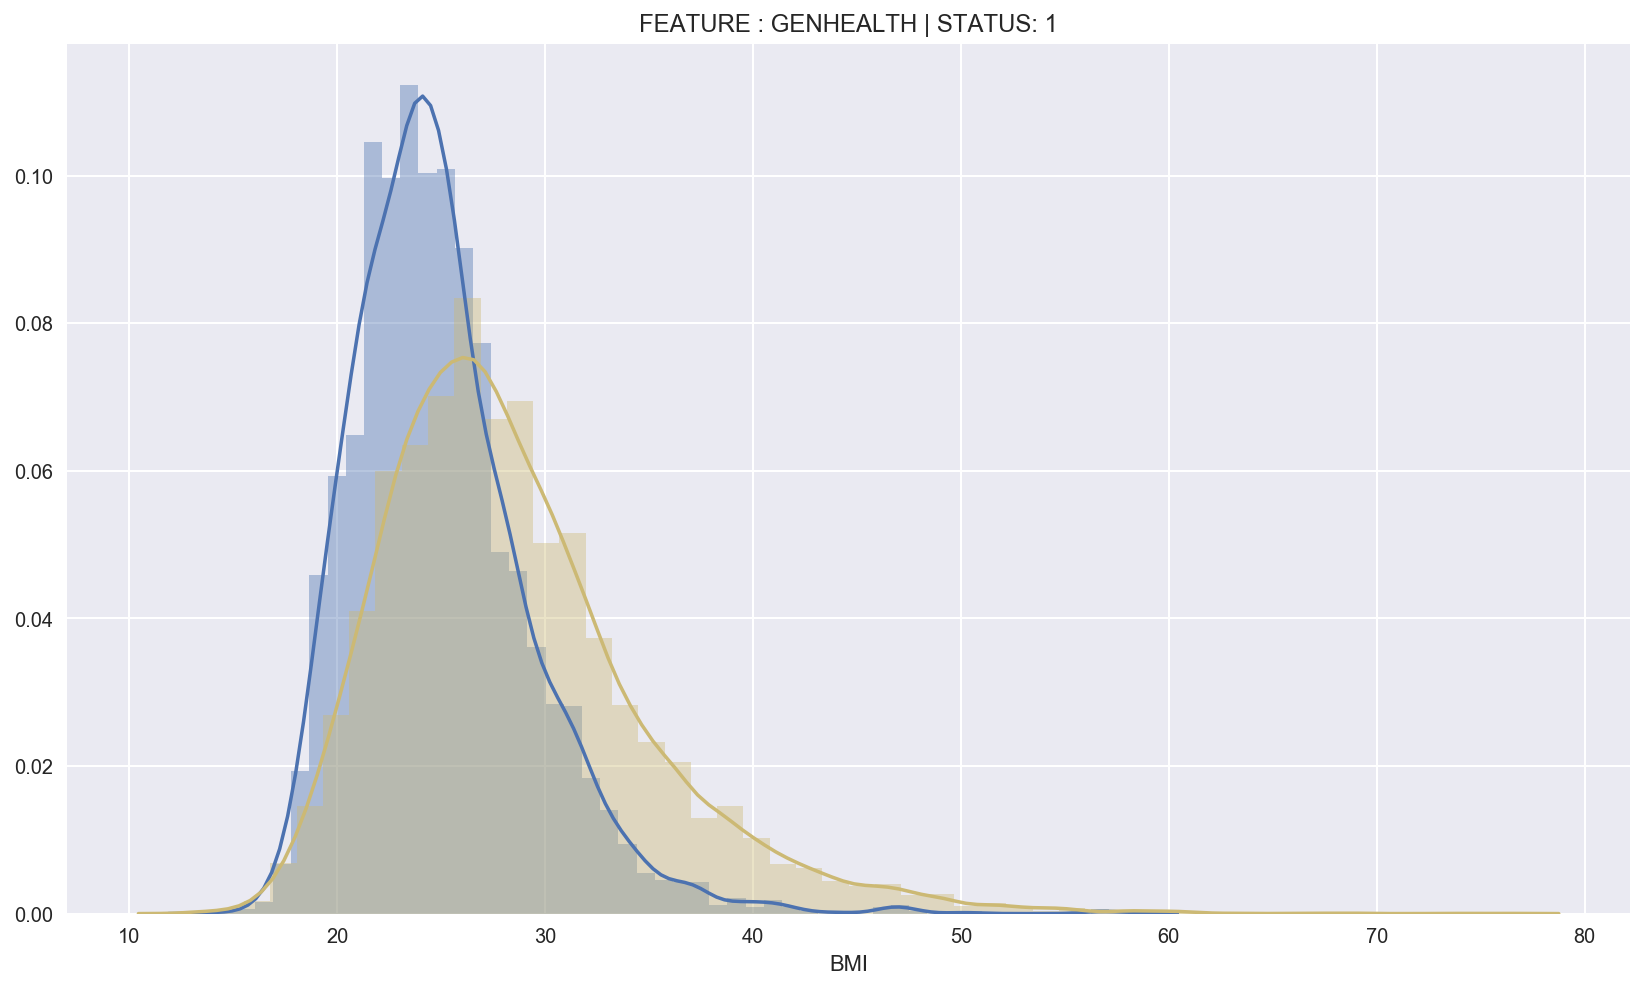

T-statistic: -31.7152202057 p-value: 1.35281983714e-215
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


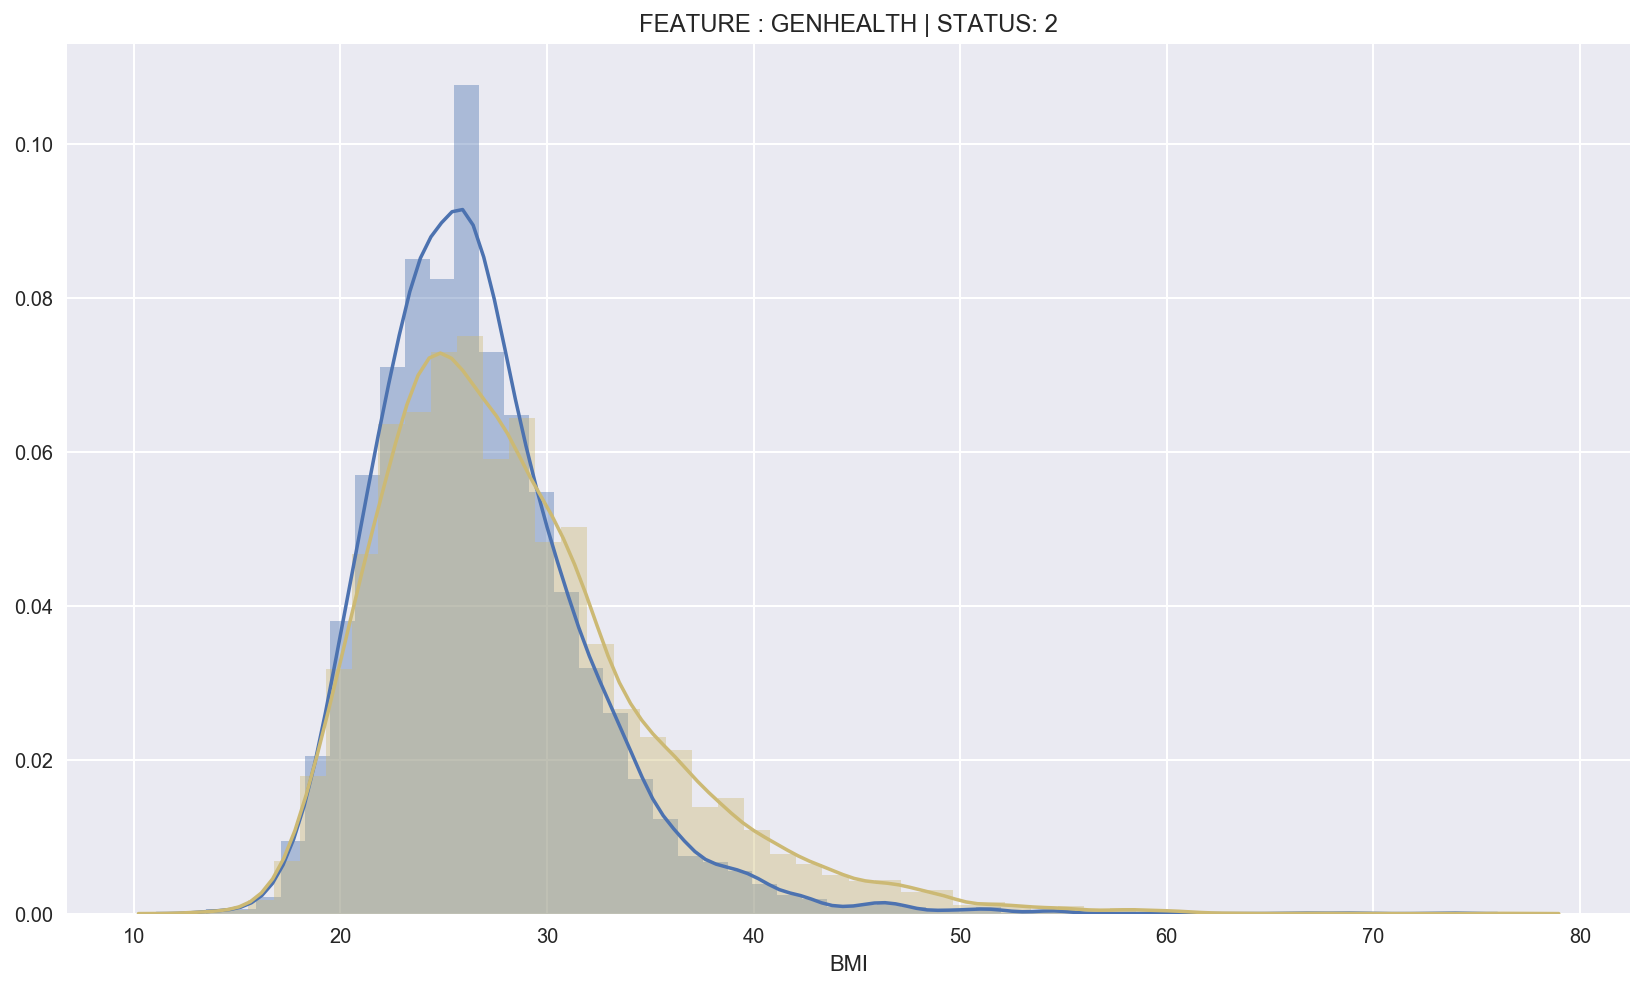

T-statistic: -18.0495753009 p-value: 2.84786945076e-72
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


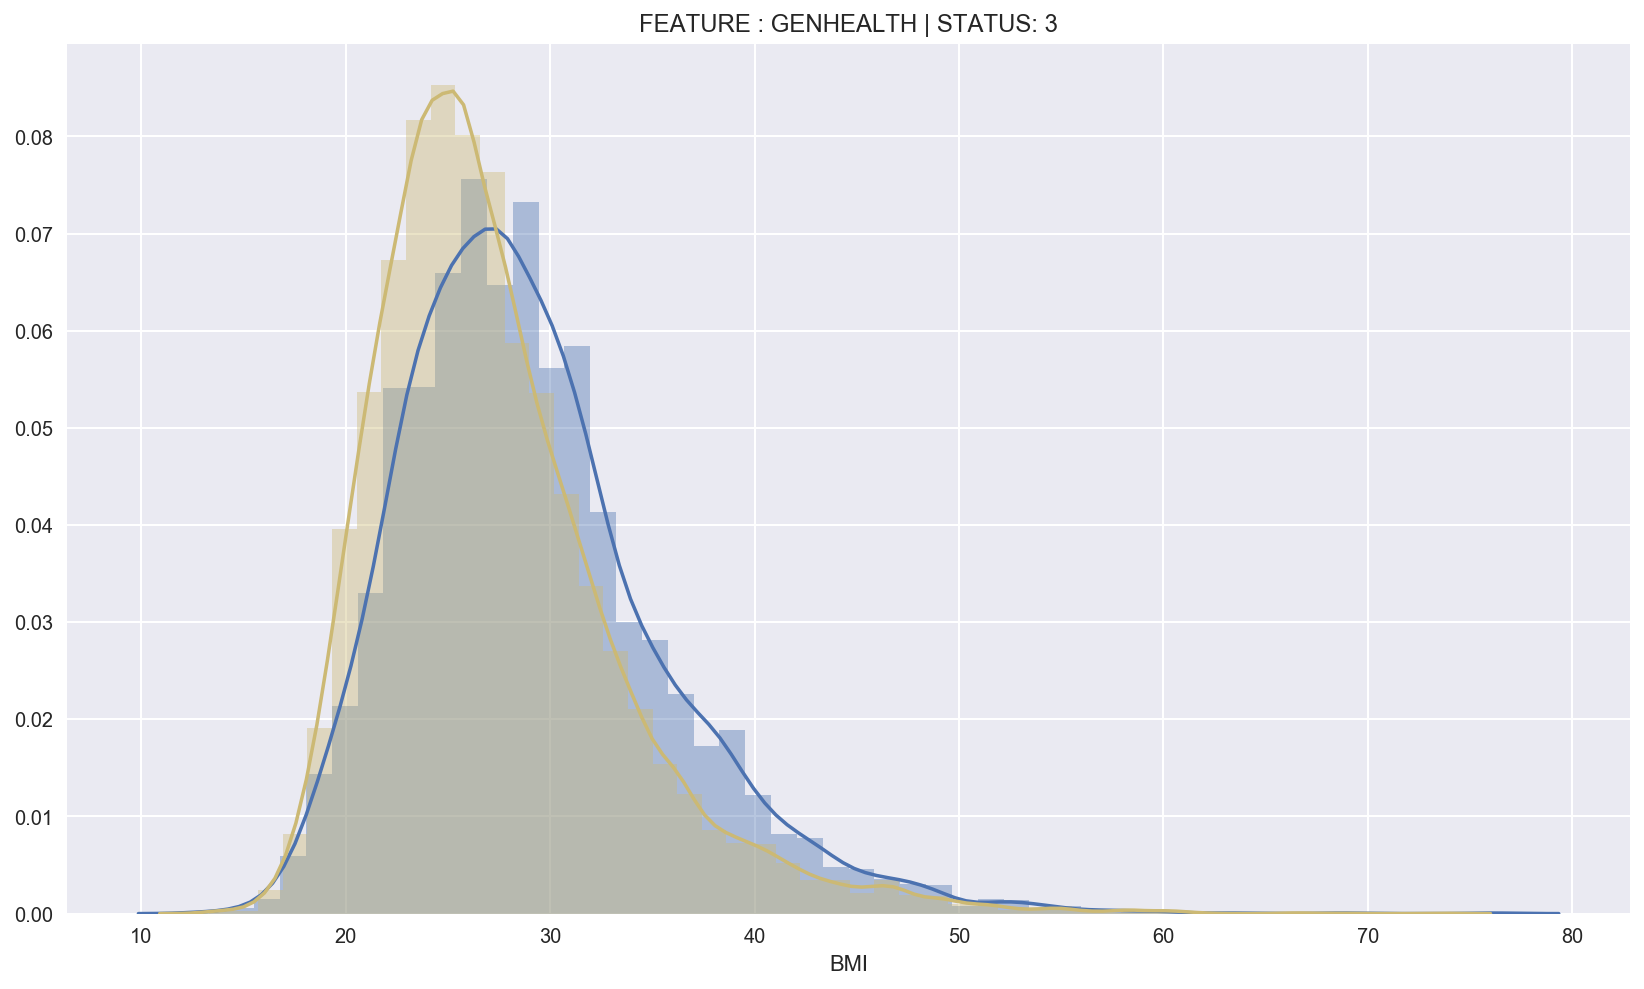

T-statistic: 20.168349703 p-value: 1.34738844641e-89
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


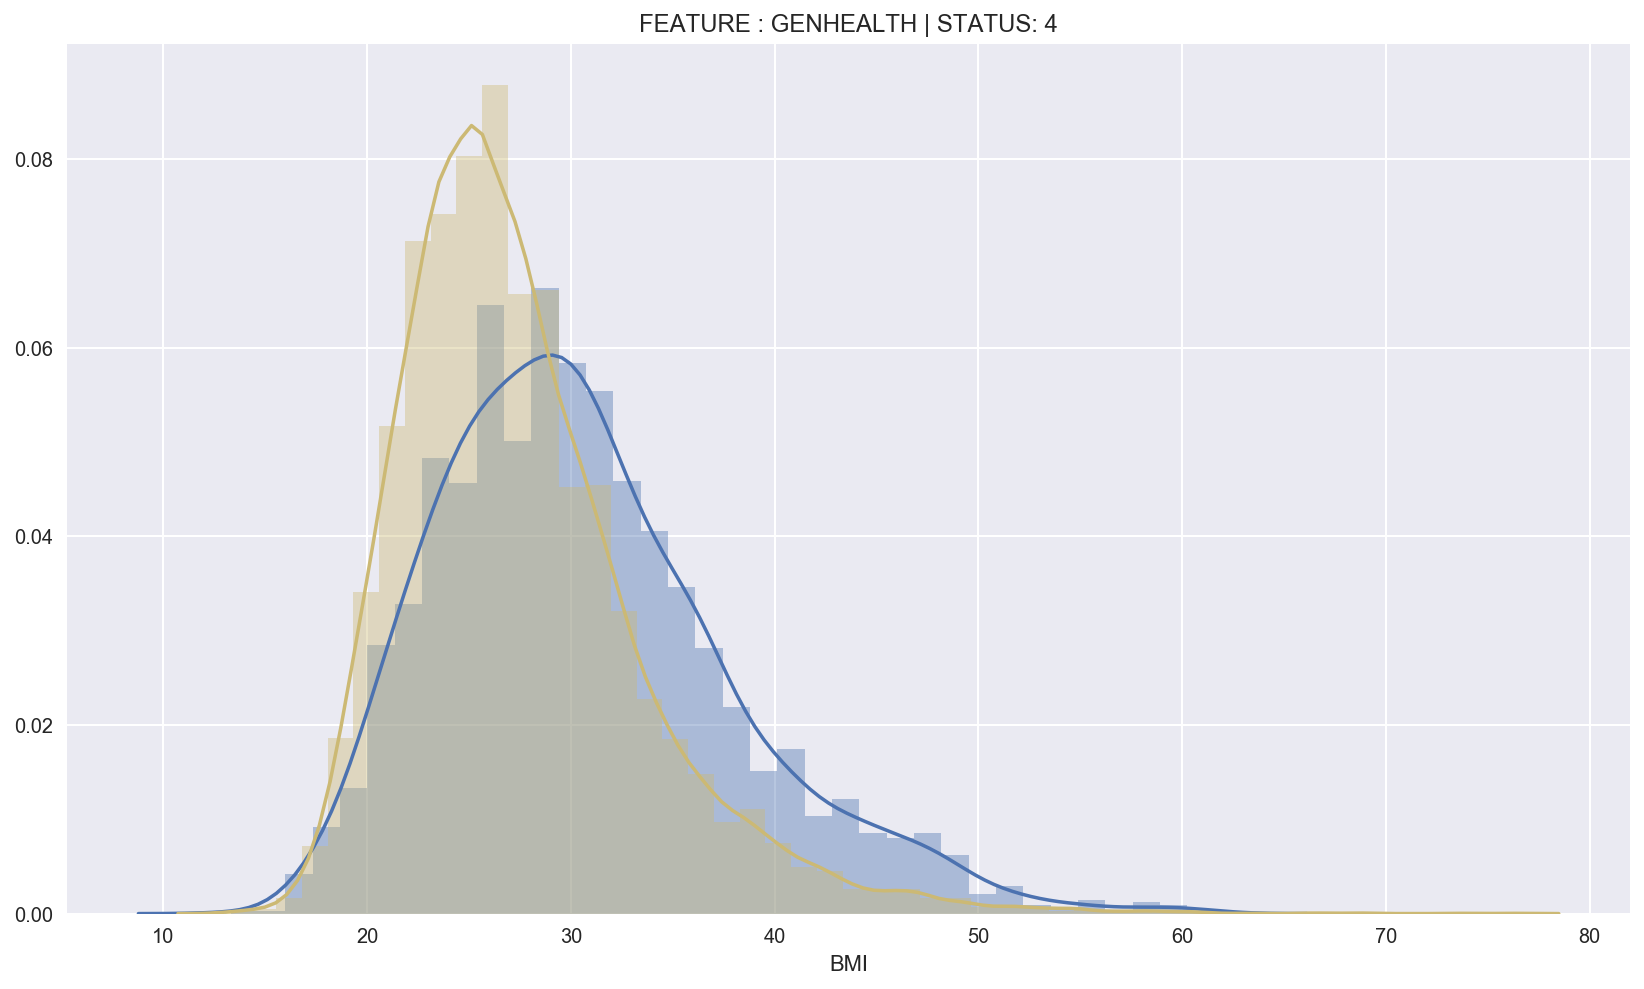

T-statistic: 24.5715968989 p-value: 1.93444680634e-131
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


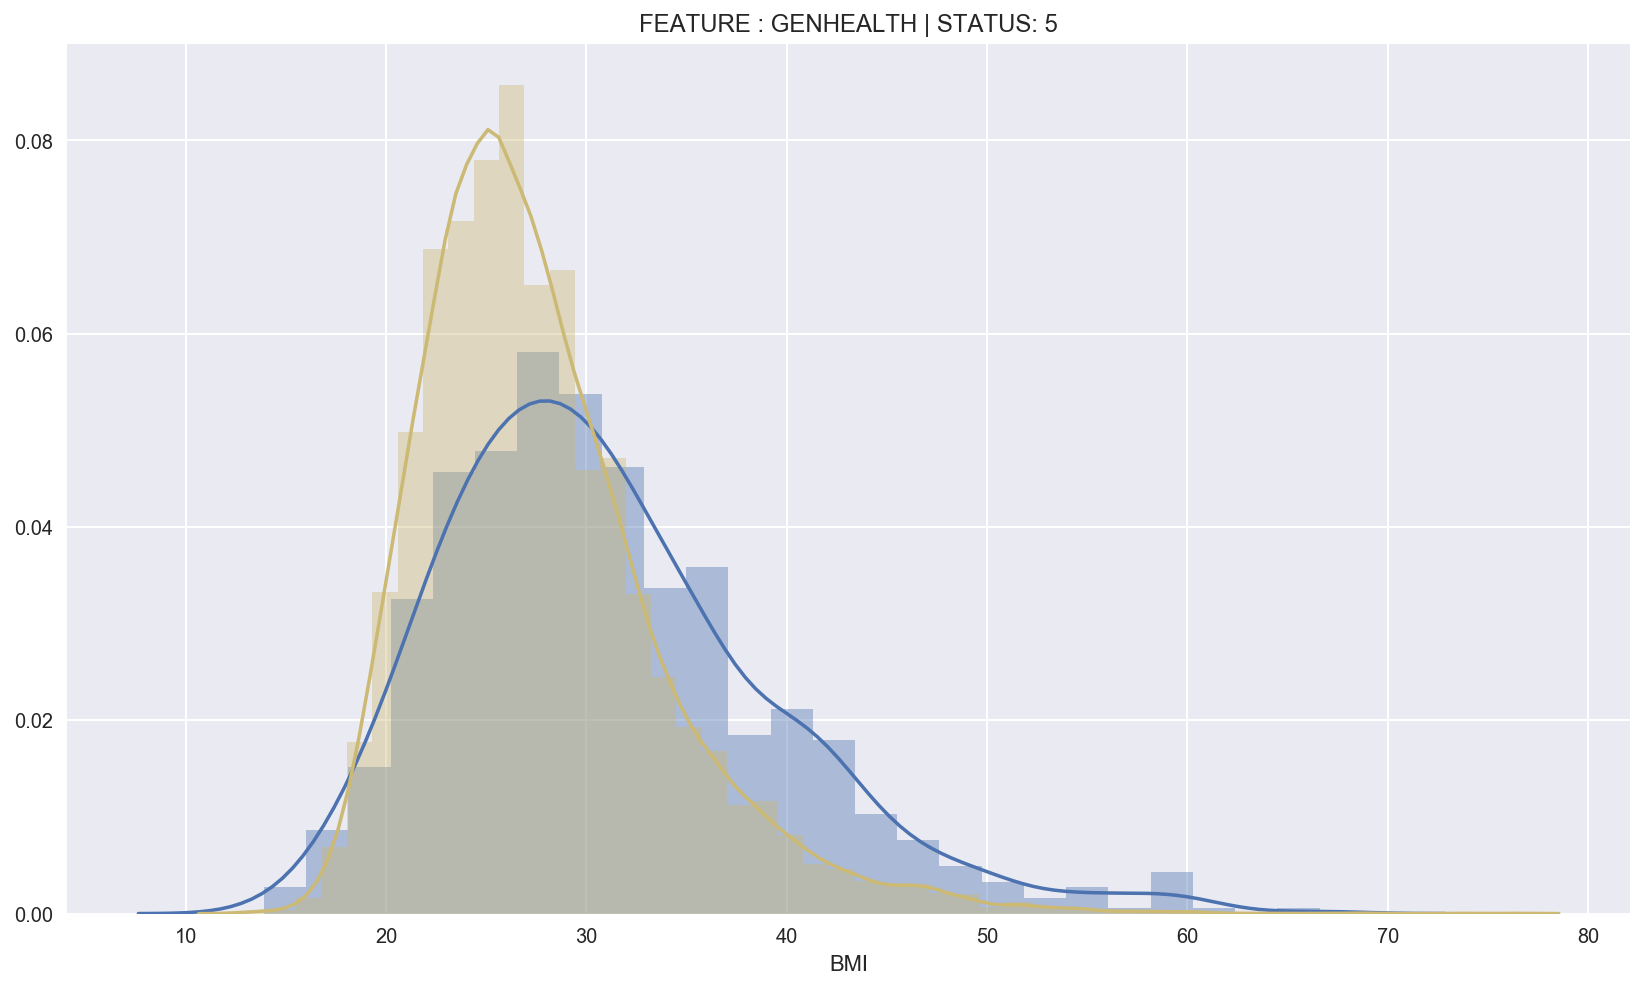

T-statistic: 15.6504893668 p-value: 6.80395293479e-55
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


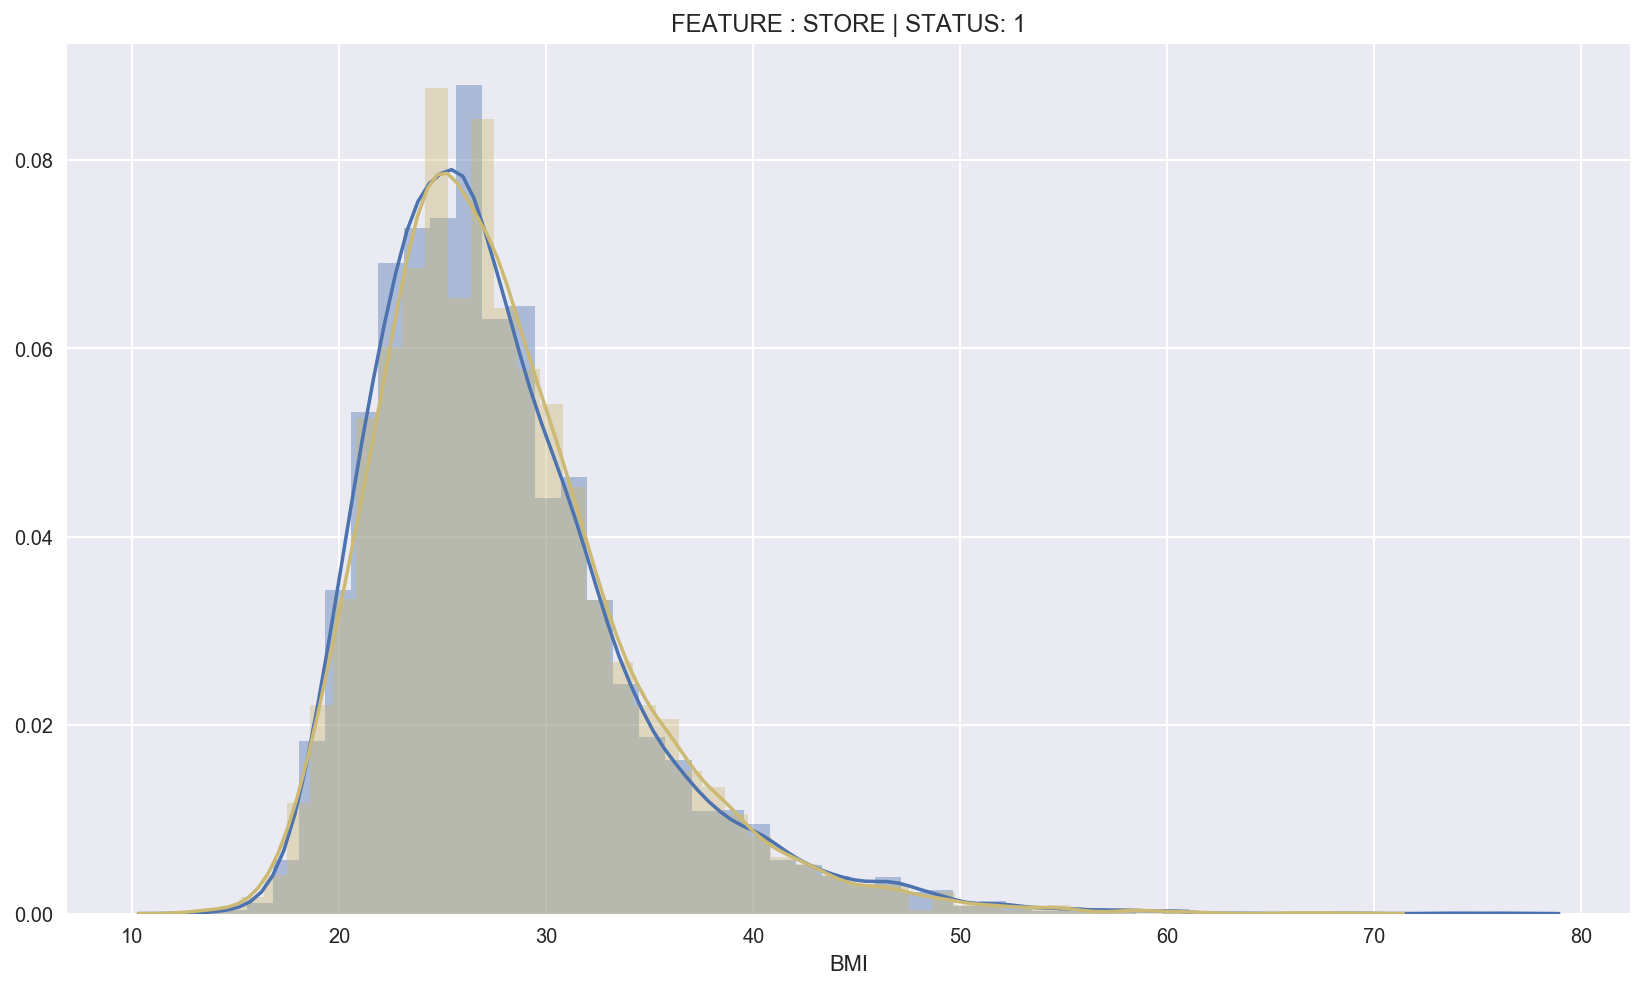

T-statistic: -1.47270933807 p-value: 0.140844627311
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


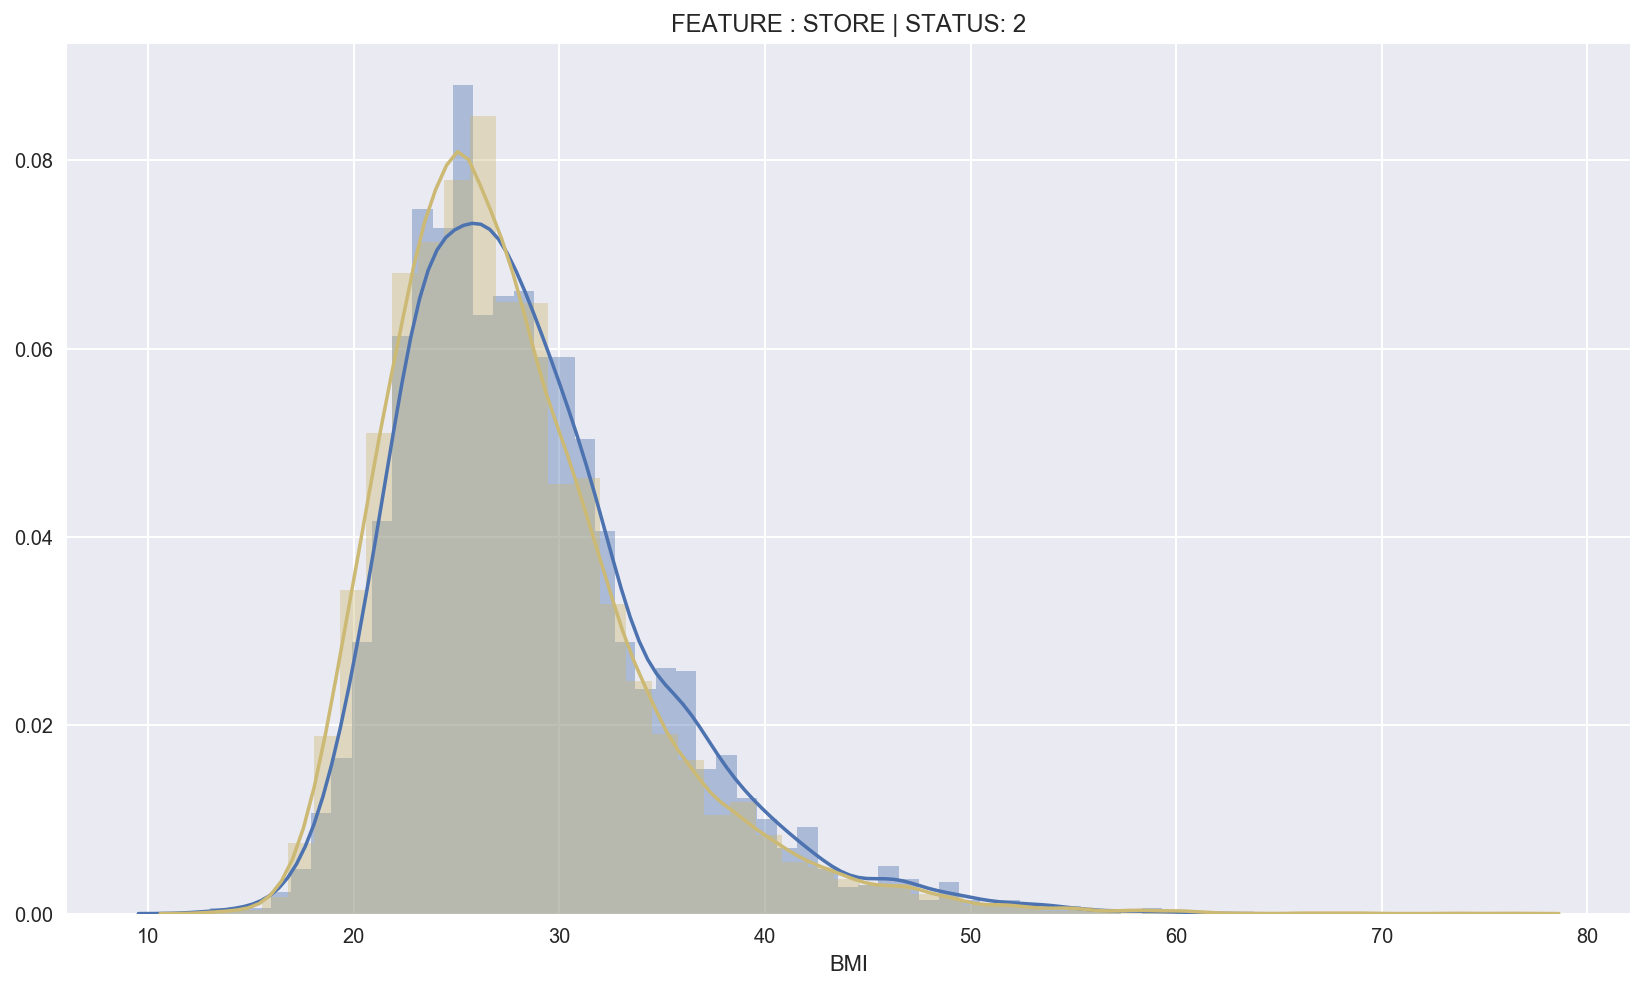

T-statistic: 7.22469589812 p-value: 5.19639161594e-13
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


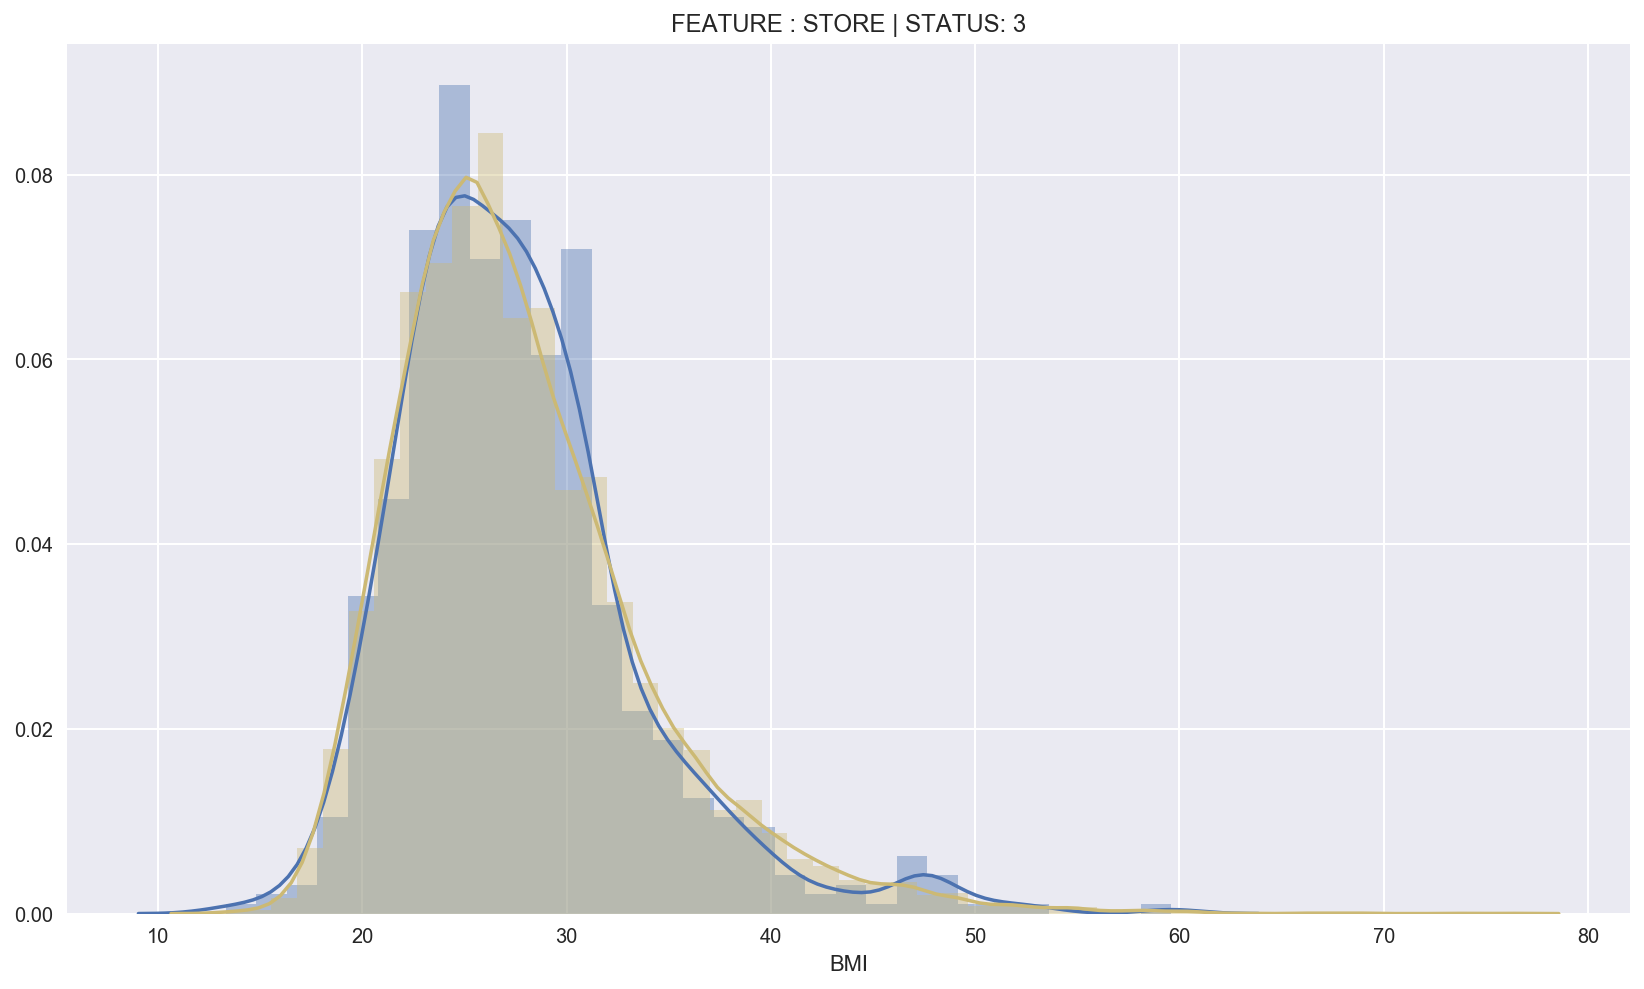

T-statistic: -0.461796482857 p-value: 0.644232124836
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


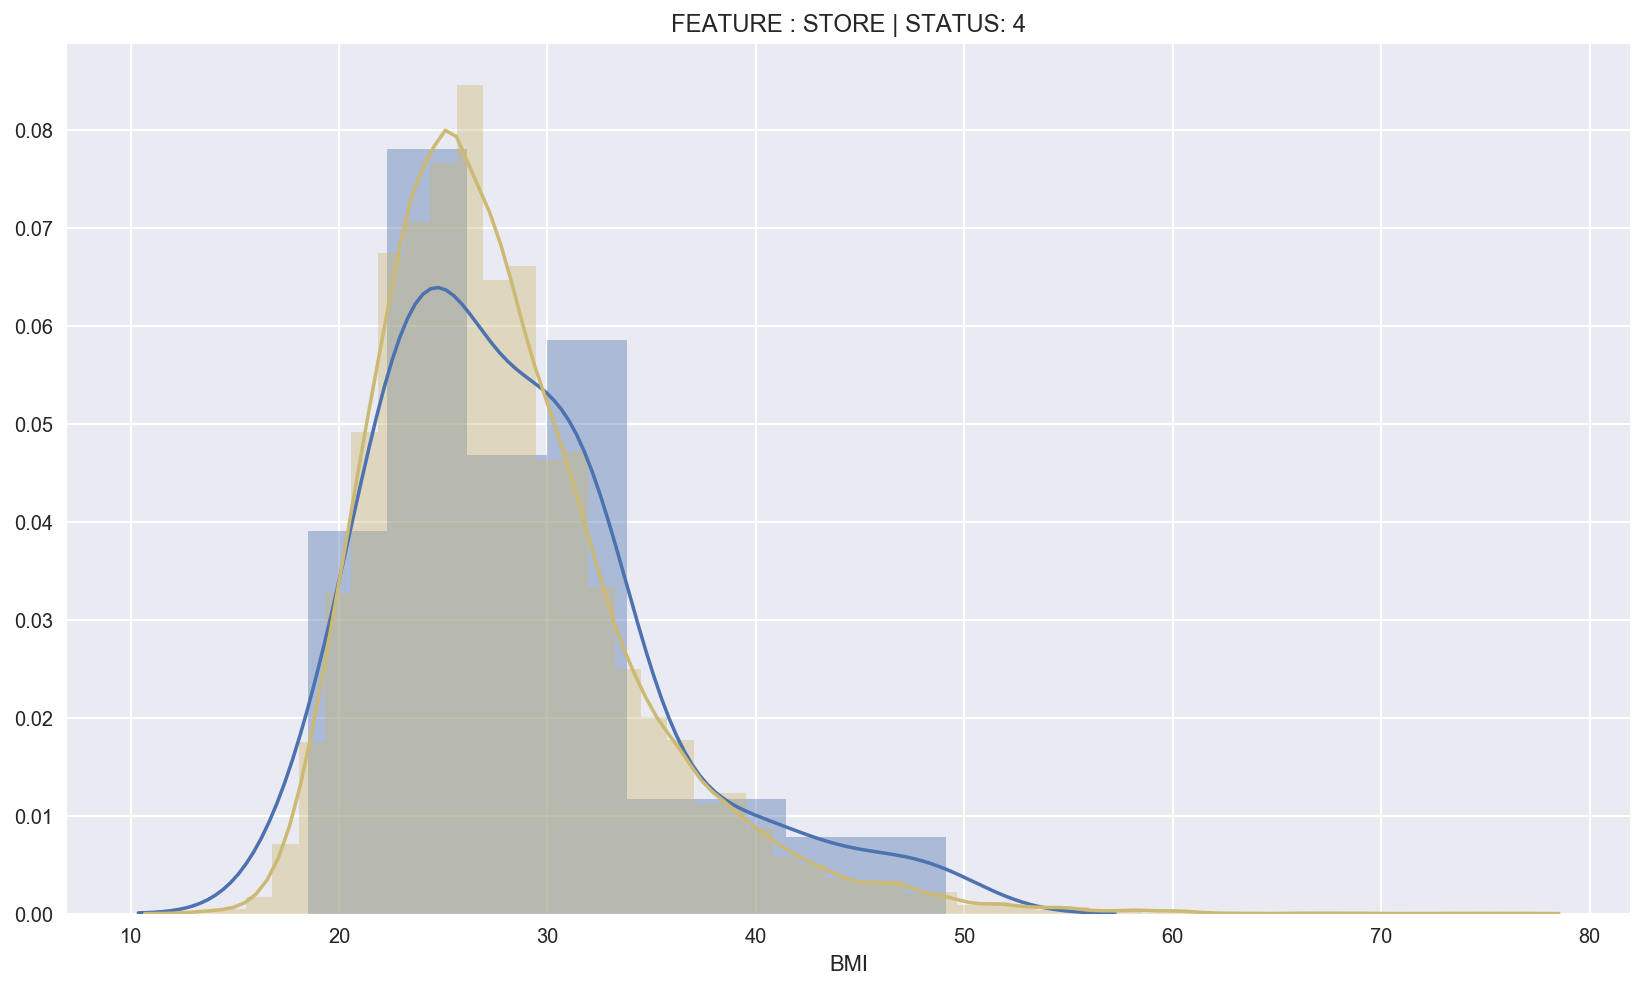

T-statistic: 0.850473333583 p-value: 0.395071814208
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


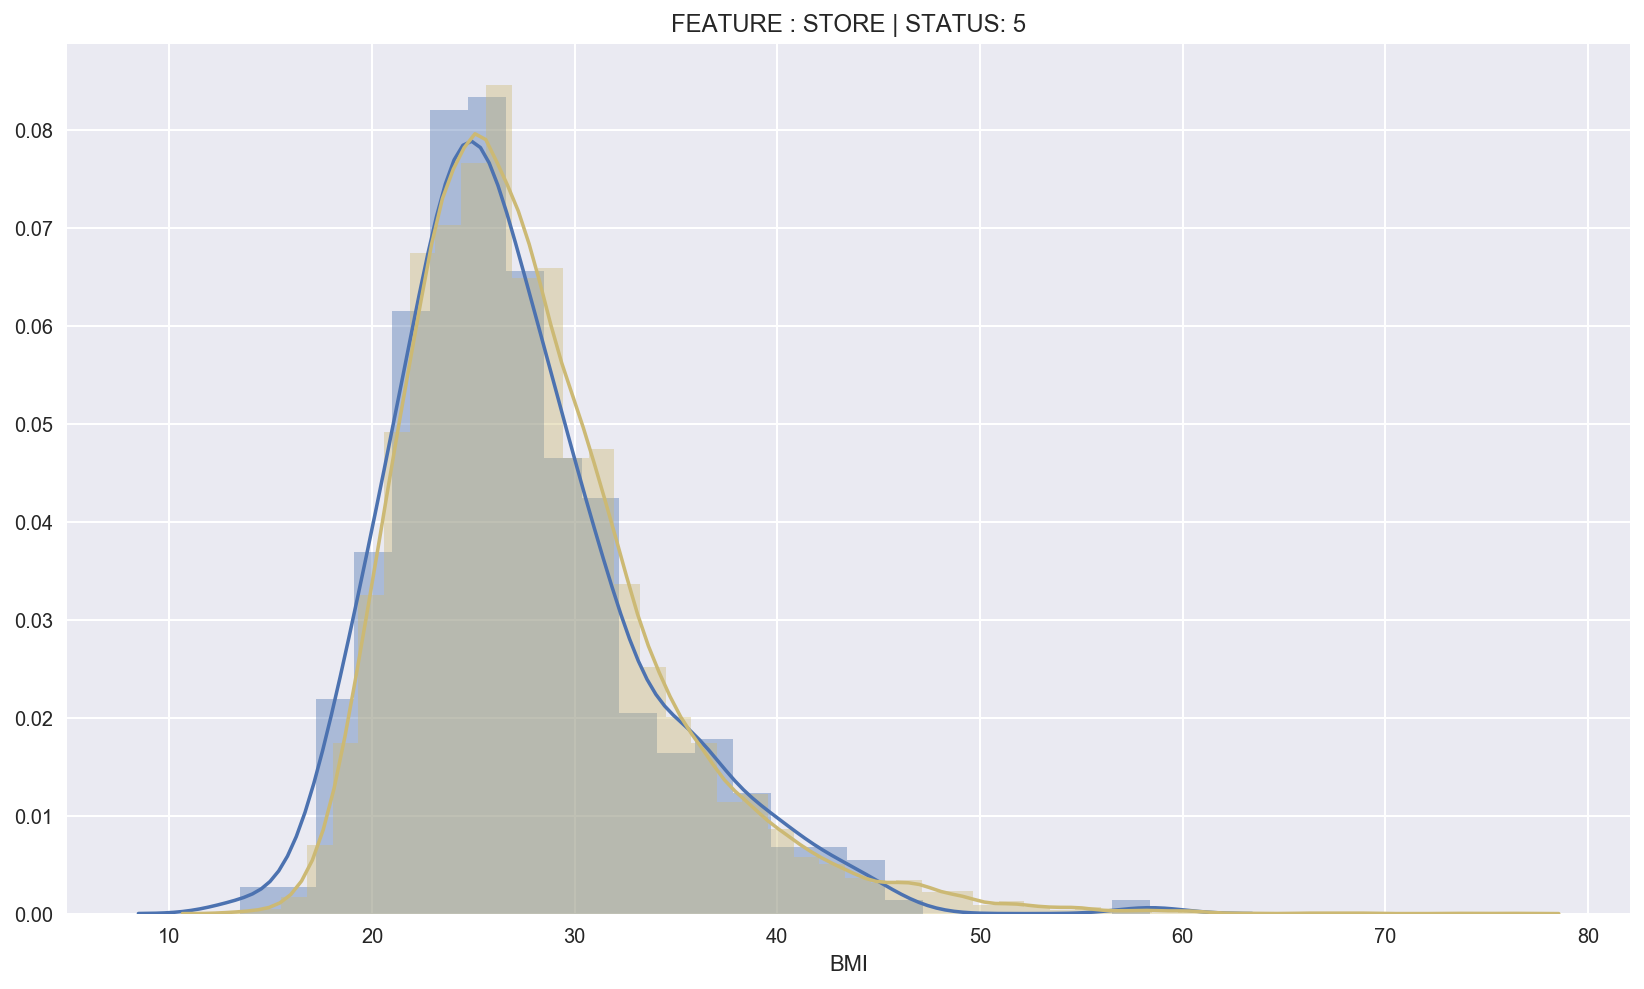

T-statistic: -2.2697139836 p-value: 0.0232351780522
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


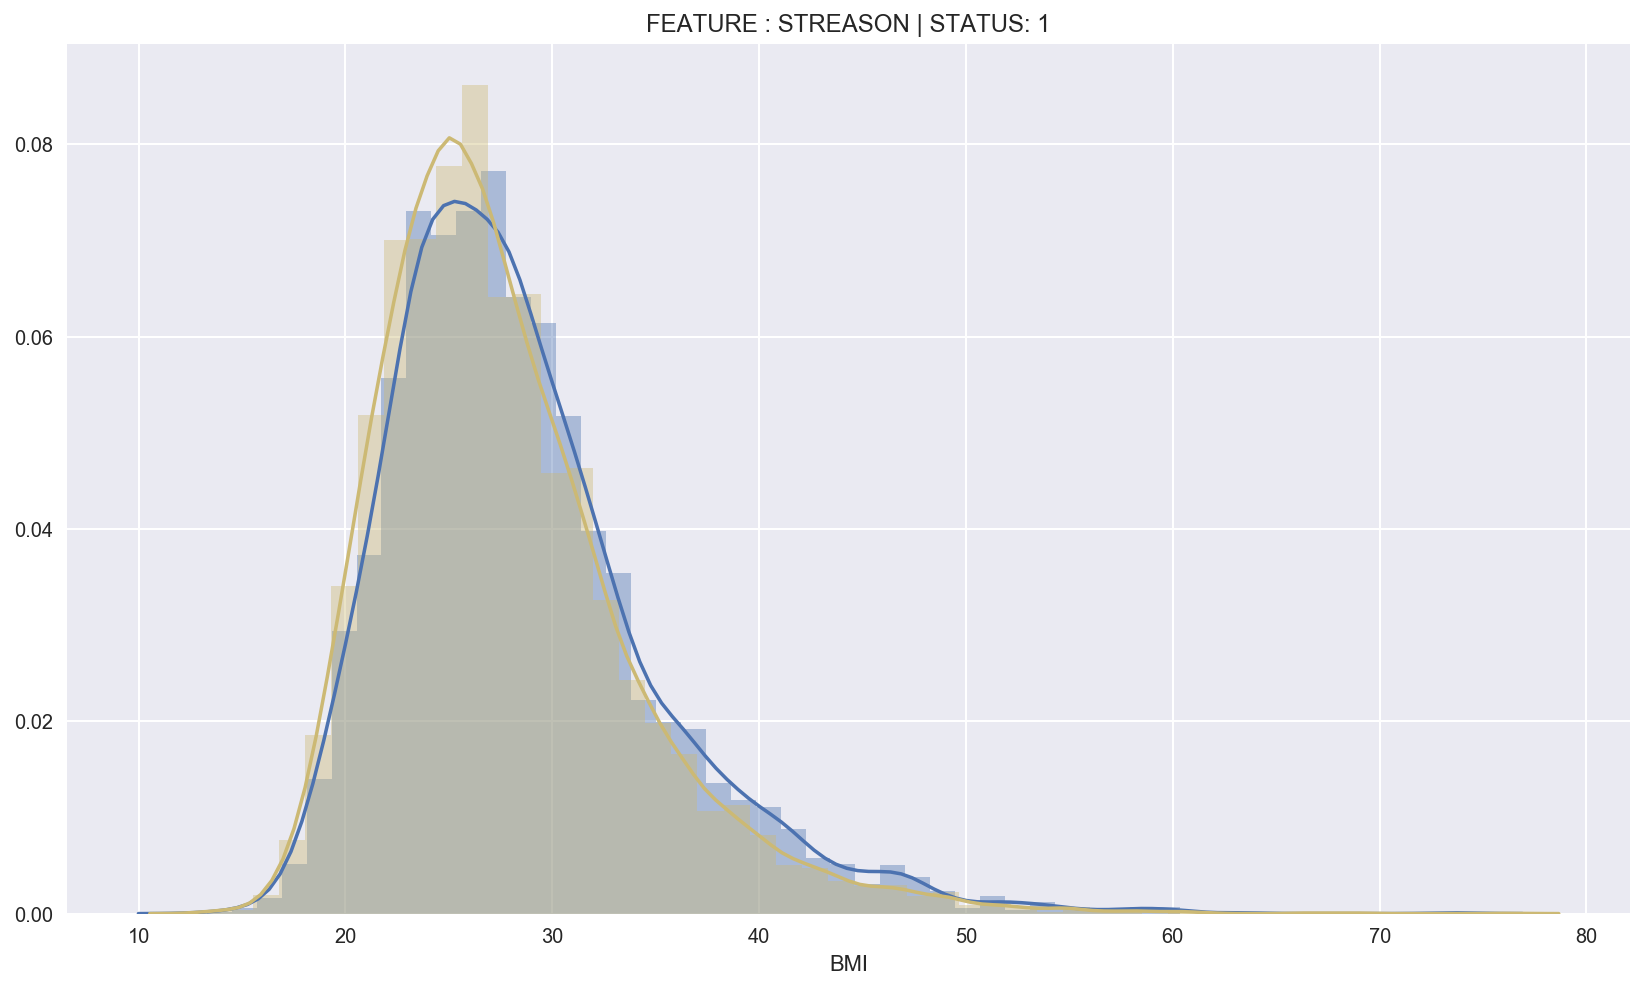

T-statistic: 8.74345405674 p-value: 2.43022439614e-18
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


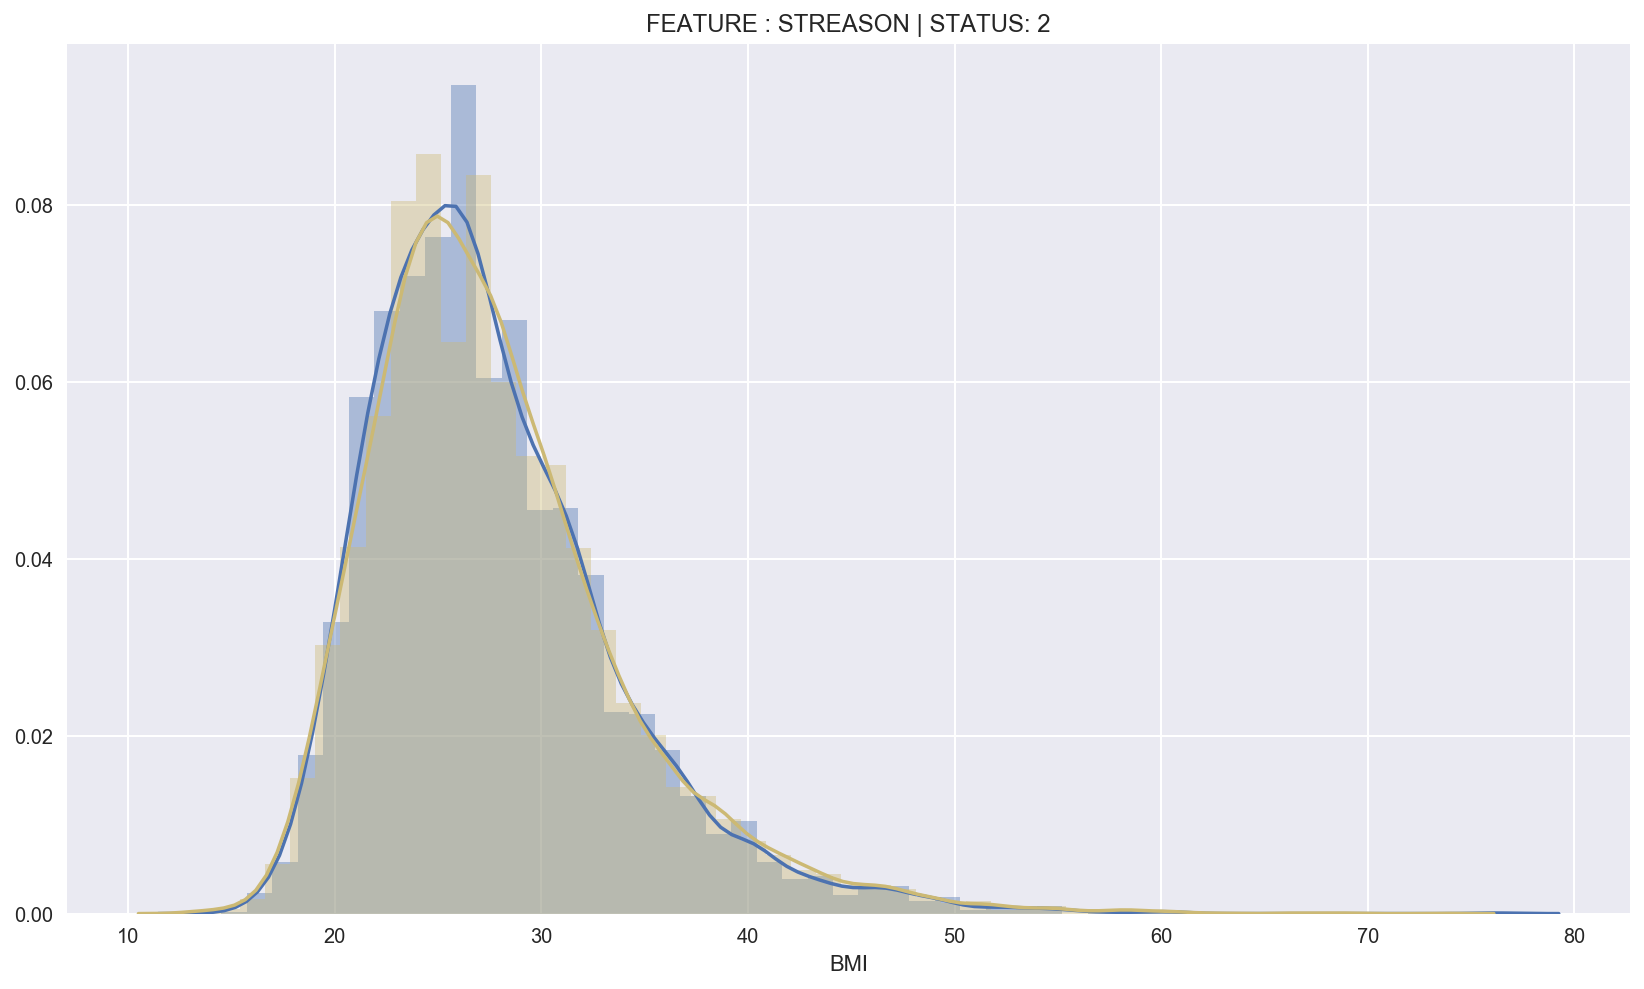

T-statistic: -1.88066648021 p-value: 0.0600313248041
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


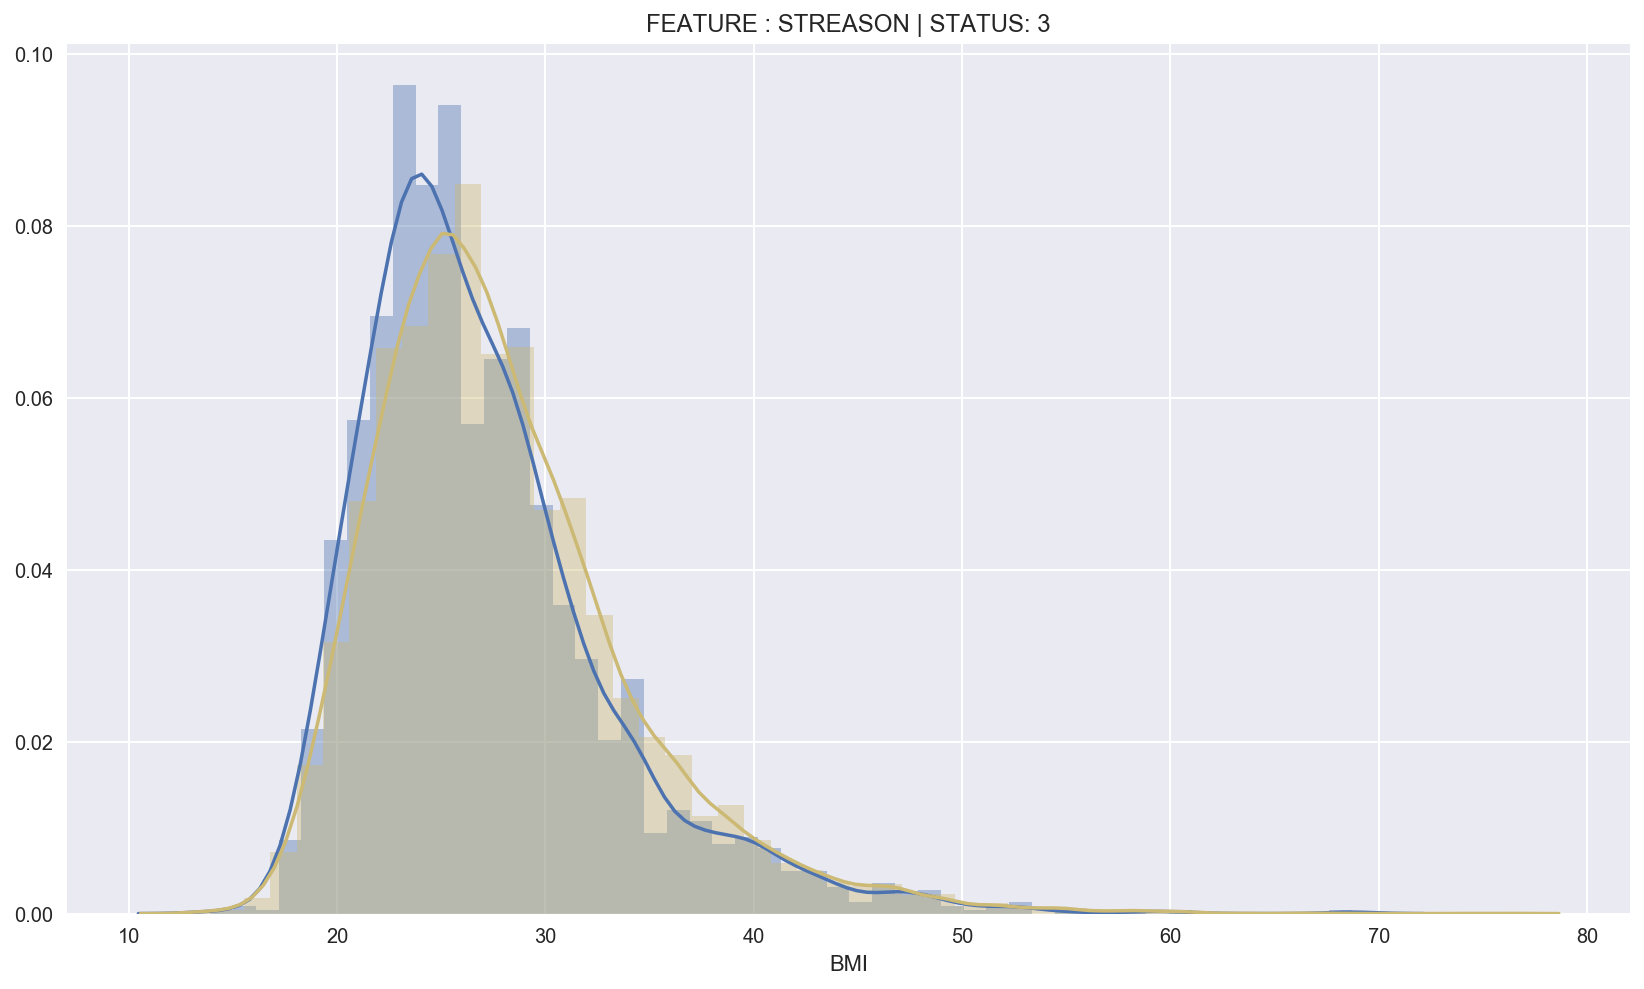

T-statistic: -6.02847660445 p-value: 1.6831562588e-09
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


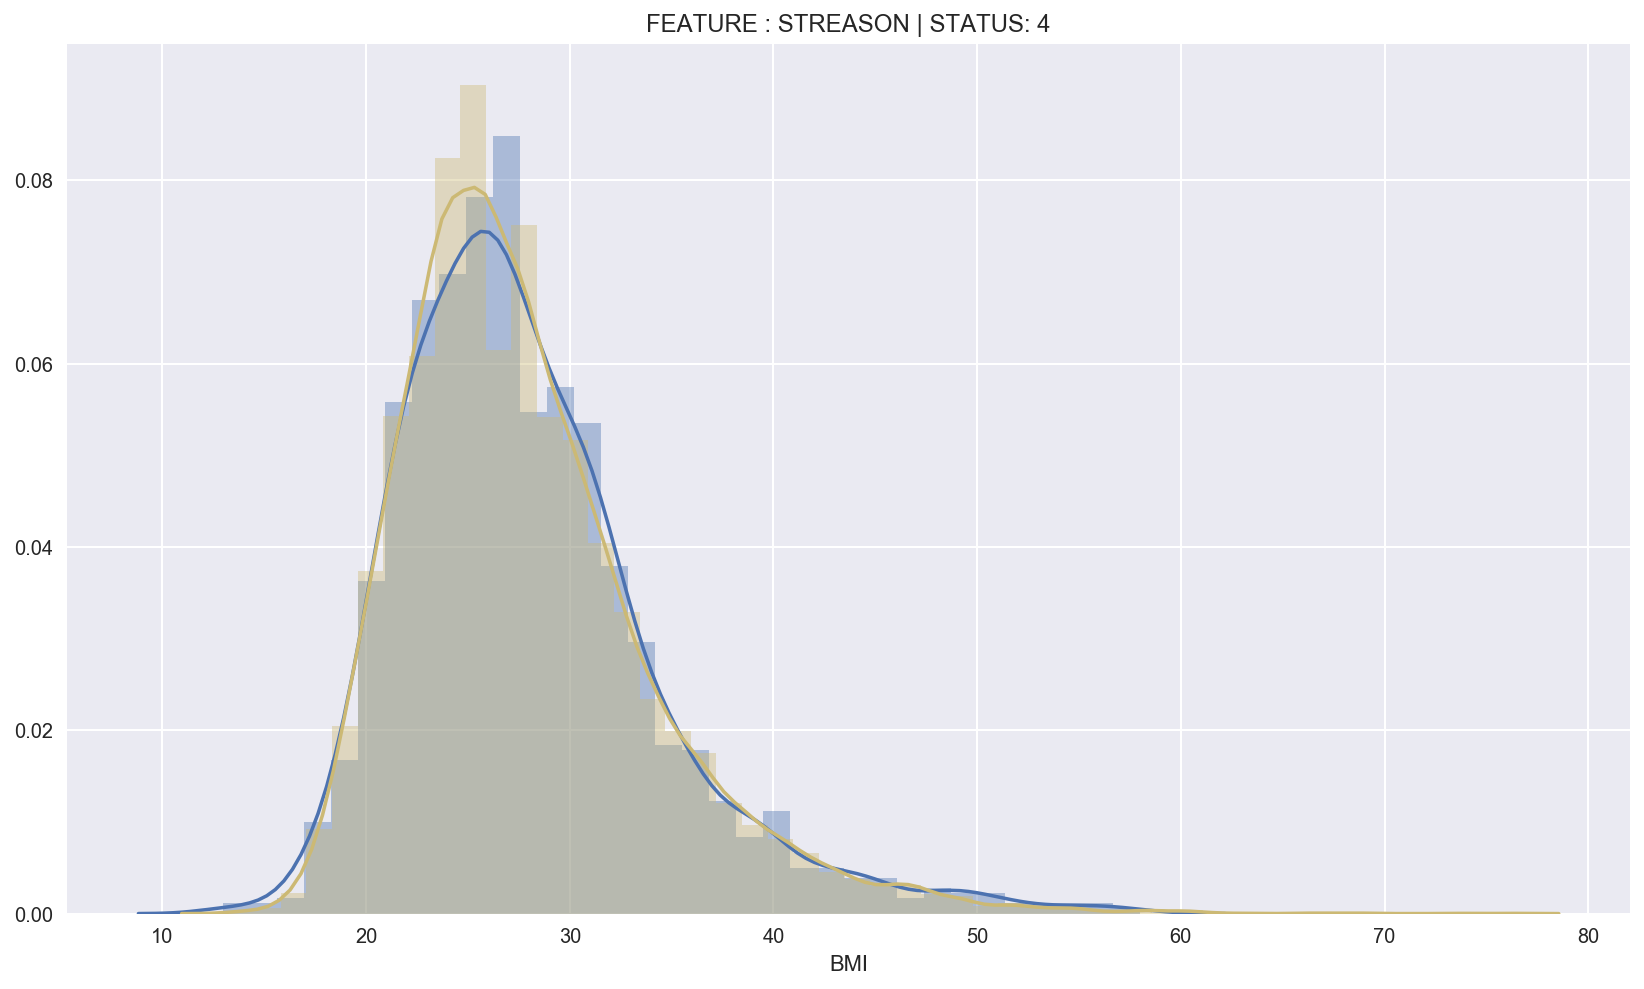

T-statistic: 0.668576071145 p-value: 0.503773394085
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


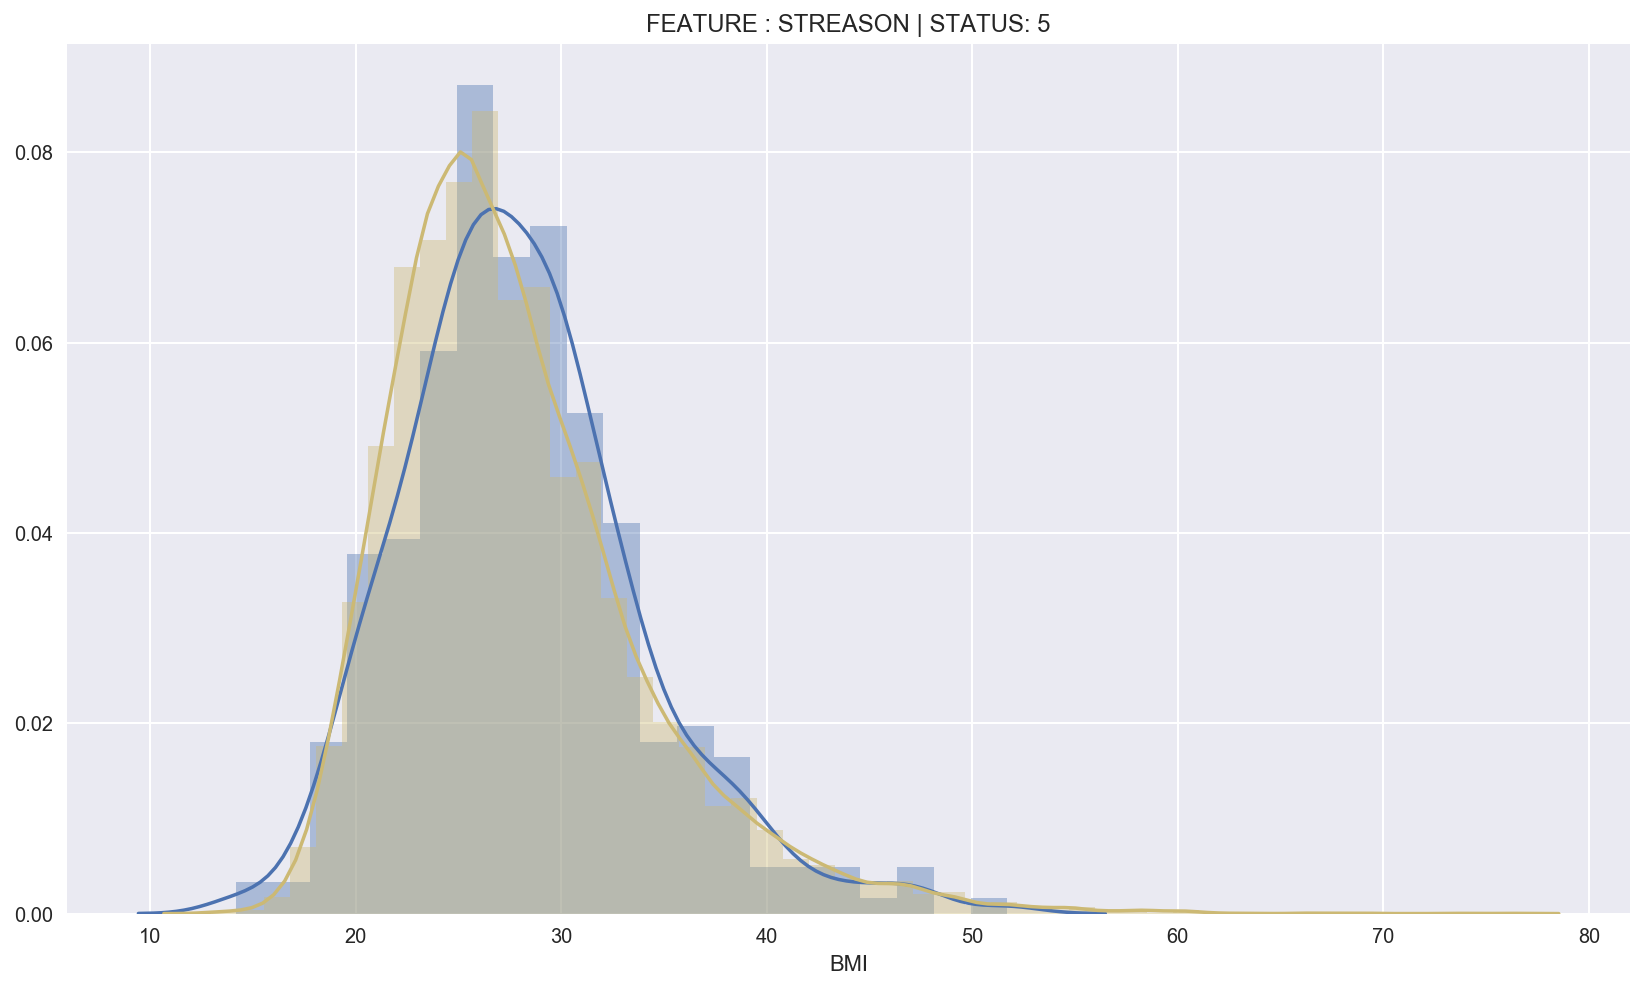

T-statistic: 1.00001902303 p-value: 0.317312988017
----------------------------------------------------------------------------------

----------------------------------------------------------------------------------


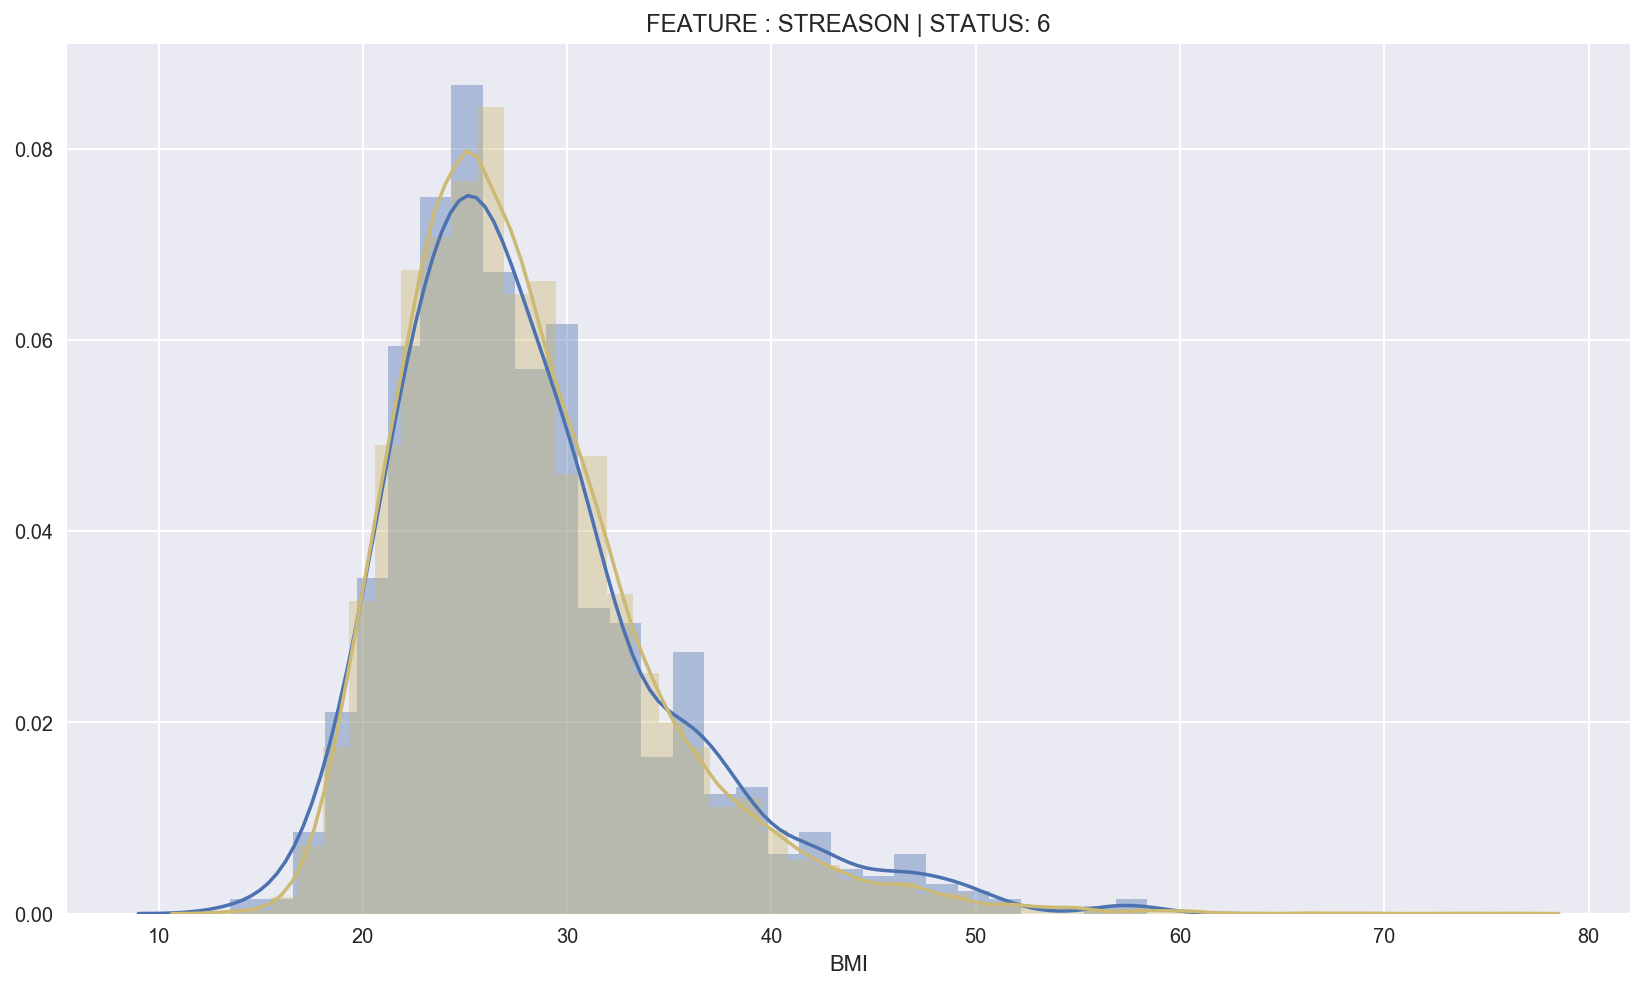

T-statistic: 1.01738938327 p-value: 0.308980117813
----------------------------------------------------------------------------------



In [20]:
print("Next, we visualize the difference between the shape of distributions!")
print()
print("Legend: Yellow is general population BMI distribution, Blue is feature BMI distribution.")
print()
print()
z1 = feat_to_bmi(RESULTS_ON_OFF,2,1)
z2 = feat_to_bmi(RESULTS_THREE,3,1)
z3 = feat_to_bmi(RESULTS_FIVE,5,1)
z4 = feat_to_bmi(RESULTS_SIX,6,1)



In [21]:
z_list = [z1,z2,z3,z4]
z_master = []

for x in z_list:
    for y in x:
        z_master.append(y)

b = sorted(z_master)

print("Table showing t-test results ranked by p-Values")

print()
print("Format:")
print("[P-value, T-Value, Feature, State]")
print("---------------------------------------")
for a in b:
    print (a)
print()

print ("From this table, we can see how much each feature, affect BMI by how much and how confidently.")

Table showing t-test results ranked by p-Values

Format:
[P-value, T-Value, Feature, State]
---------------------------------------
[1.3528198371401643e-215, -31.715220205670217, 'GENHEALTH', 1]
[1.9344468063404748e-131, 24.571596898873743, 'GENHEALTH', 4]
[1.3473884464144848e-89, 20.168349703029751, 'GENHEALTH', 3]
[5.6188400142383629e-82, -19.264017116854202, 'EXERCISE', 1]
[7.7530010584359683e-82, 19.247043127505965, 'EXERCISE', 2]
[2.8478694507638723e-72, -18.0495753009018, 'GENHEALTH', 2]
[6.8039529347893179e-55, 15.650489366776144, 'GENHEALTH', 5]
[1.0076399893707383e-32, 11.934003948305142, 'DIETSODA', 1]
[2.8293358192505686e-32, 11.847189113775118, 'SODA', 1]
[3.8181243632110883e-22, -9.6869396183176821, 'SODA', 2]
[2.4302243961422798e-18, 8.7434540567350396, 'STREASON', 1]
[5.1963916159413415e-13, 7.2246958981186342, 'STORE', 2]
[1.6831562587974941e-09, -6.0284766044464222, 'STREASON', 3]
[1.0167338223700198e-08, 5.7302524744142236, 'DIETSODA', 3]
[9.2631438392433312e-06, 4.43

### Part 2: Analysis of Continuous Variables

In [22]:
CONTINUOUS_FEATURES = [ 'AGE', 'PED', 'SED_EAT', 'EXFREQ', 'FASTFDFREQ']
df_x= df_atus[CONTINUOUS_FEATURES + ['BMI']]

print("Testing for different kinds of correlations for cotinuous feature")
for x in CONTINUOUS_FEATURES:
    print ('['+x+']')
    print ('Pearson')
    print (df_x[[x,'BMI']].corr(method='pearson'))
    print ()
    print ('Spearman')
    print (df_x[[x,'BMI']].corr(method='spearman'))
    print ()
    print ('Kendall-tau')
    print (df_x[[x,'BMI']].corr(method='kendall'))
    print ()
    print ('-------------------------')
    print ()



Testing for different kinds of correlations for cotinuous feature
[AGE]
Pearson
          AGE       BMI
AGE  1.000000  0.072296
BMI  0.072296  1.000000

Spearman
          AGE       BMI
AGE  1.000000  0.106875
BMI  0.106875  1.000000

Kendall-tau
          AGE       BMI
AGE  1.000000  0.071113
BMI  0.071113  1.000000

-------------------------

[PED]
Pearson
          PED       BMI
PED  1.000000 -0.064037
BMI -0.064037  1.000000

Spearman
          PED       BMI
PED  1.000000 -0.058694
BMI -0.058694  1.000000

Kendall-tau
          PED       BMI
PED  1.000000 -0.040296
BMI -0.040296  1.000000

-------------------------

[SED_EAT]
Pearson
          SED_EAT       BMI
SED_EAT  1.000000 -0.011245
BMI     -0.011245  1.000000

Spearman
          SED_EAT       BMI
SED_EAT  1.000000 -0.029761
BMI     -0.029761  1.000000

Kendall-tau
          SED_EAT       BMI
SED_EAT  1.000000 -0.021593
BMI     -0.021593  1.000000

-------------------------

[EXFREQ]
Pearson
          EXFREQ       BMI
EXFREQ 

Age and EXFREQ has the biggest impact on BMI. Spearman for EXEFREQ vs BMI is -0.12.   
Since EXEFREQ and FASTFDFREQ are base on the same unit (times per week), they can be compared.   
Next, let us visualize scatterplots.  

--------------------------------------------------------
   	 scatter plot of: AGE


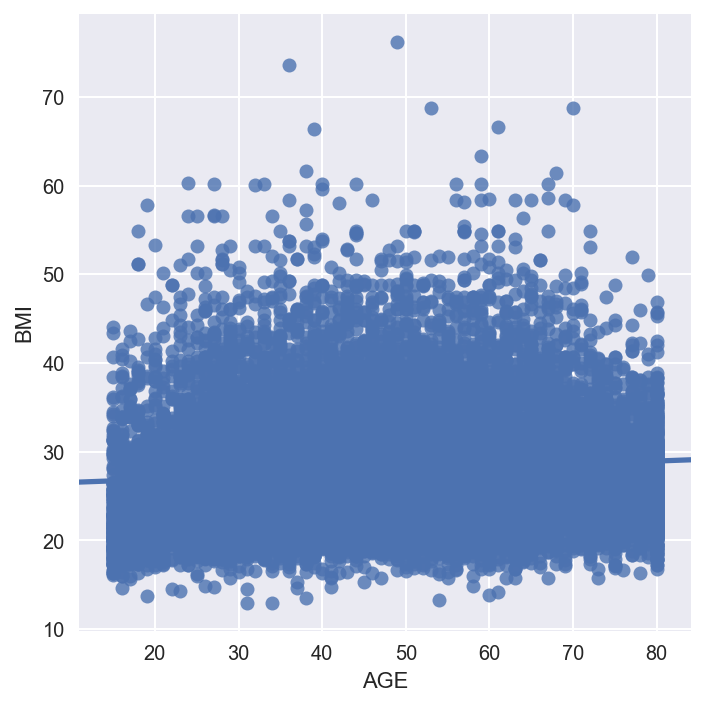

Pearson Coeff: 0.0945210587485 P-value: 2.25675358292e-41

--------------------------------------------------------
--------------------------------------------------------
   	 scatter plot of: PED


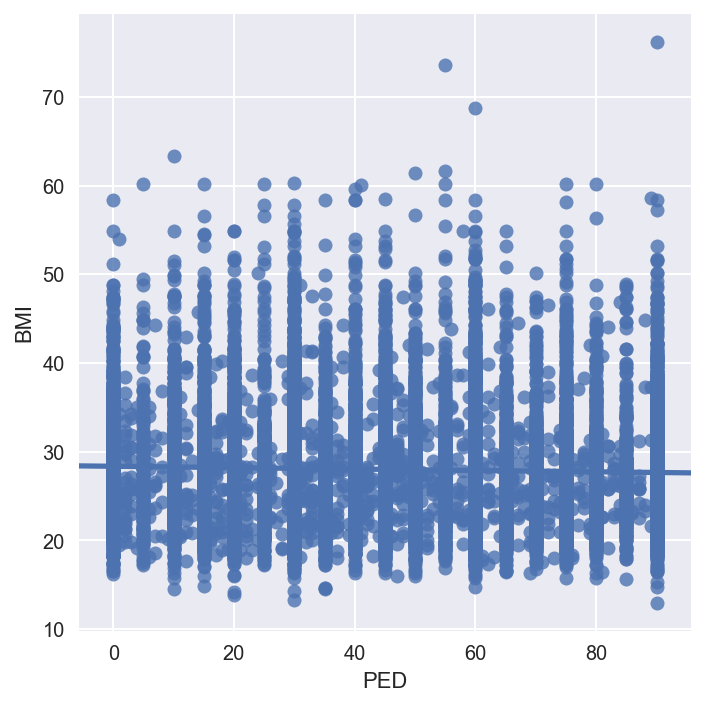

Pearson Coeff: -0.0317285121076 P-value: 5.1727919176e-05

--------------------------------------------------------
--------------------------------------------------------
   	 scatter plot of: SED_EAT


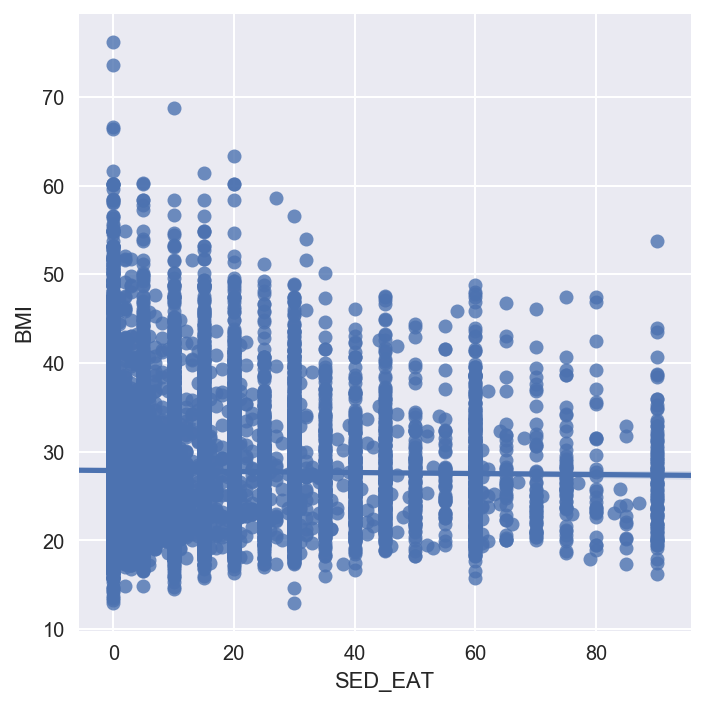

Pearson Coeff: -0.0143138173458 P-value: 0.0431315610182

--------------------------------------------------------
--------------------------------------------------------
   	 scatter plot of: EXFREQ


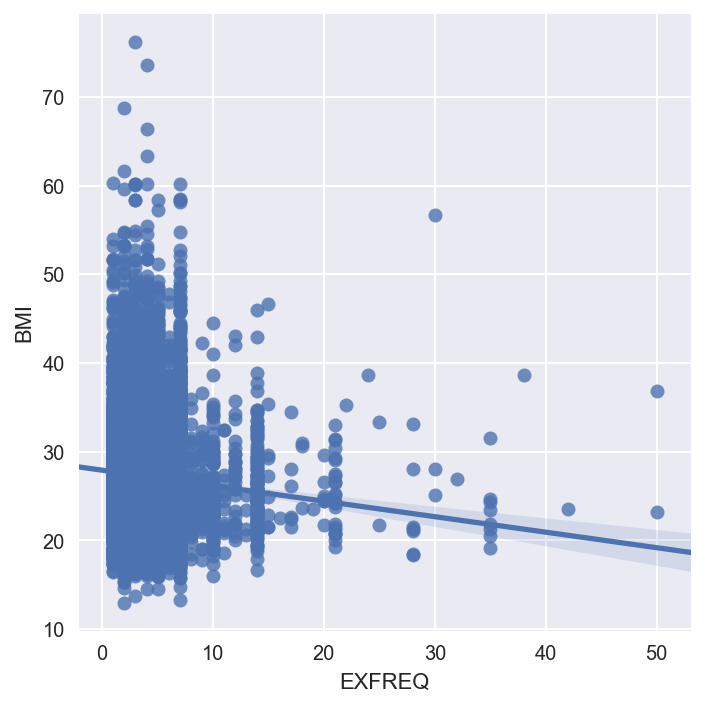

Pearson Coeff: -0.0832193622995 P-value: 1.51371822002e-21

--------------------------------------------------------
--------------------------------------------------------
   	 scatter plot of: FASTFDFREQ


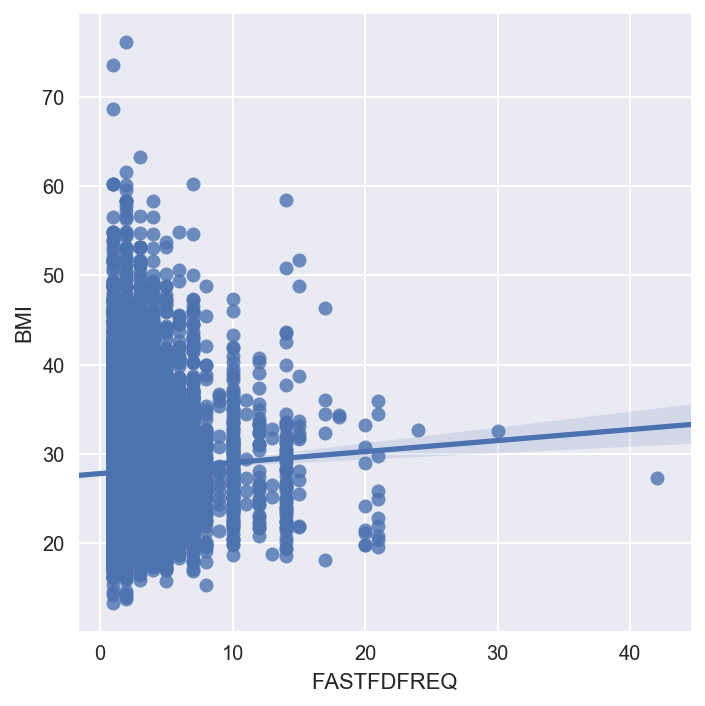

Pearson Coeff: 0.0444882016761 P-value: 1.1818591754e-06

--------------------------------------------------------


In [23]:

keep_record = []
for x in CONTINUOUS_FEATURES:
   
    #df_x[[x,'BMI']].plot(kind='scatter', x=x, y='BMI')
    temp_df = df_x
    if (x=='AGE'):
        temp_df = temp_df[temp_df[x] <= 80]
    if (x=='SED_EAT'):
        temp_df = temp_df[temp_df[x] <= 8000]
    if (x=='EXFREQ' or 'FASTFDFREQ'):
        temp_df = temp_df[temp_df[x] <= 90]
        
    print('--------------------------------------------------------')
    print('   \t scatter plot of: '+str(x))
    sns.lmplot(x=x,y='BMI',data=temp_df,fit_reg=True,  palette="Set1")
    plt.show()
    s = scipy.stats.pearsonr(temp_df[x],temp_df['BMI'])
    print( "Pearson Coeff: "+str(s[0]),"P-value: "+str(s[1]) )
    keep_record.append([s[1],s[0],x])
    
    
    print()
    print('--------------------------------------------------------')

We can also see people reported in whole numbers who are multiples of 10.
The graphs above show pearson coefficent and the p-value.

In [24]:
b = sorted(keep_record)

print("Table showing correlation results ranked by p-Values")

print()
print("Format:")
print("[P-value, Pearson Coeff. , Feature]")
print("---------------------------------------")
for a in b:
    print (a)
print()
print()
print ("From this table, we can see how much each feature, affect BMI by how much and how confidently.")

Table showing correlation results ranked by p-Values

Format:
[P-value, Pearson Coeff. , Feature]
---------------------------------------
[2.2567535829171954e-41, 0.094521058748525566, 'AGE']
[1.5137182200203121e-21, -0.083219362299529143, 'EXFREQ']
[1.181859175396034e-06, 0.044488201676123405, 'FASTFDFREQ']
[5.1727919176046218e-05, -0.031728512107630794, 'PED']
[0.043131561018245501, -0.01431381734580655, 'SED_EAT']


From this table, we can see how much each feature, affect BMI by how much and how confidently.


### Part 3: Machine Learning Model

The above analysis led us to gain a clearer understanding of the impact of individual food and exercise related features on obesity. Though we investigated our hypothesis using statistical tools, how can we use our dataset for a real-world purpose?

We decided to investigate whether a machine learning model could be trained that could aid governments predict whether or not communities are at-risk for obesity. Since we have a mixture of nominal and continuous features which mostly non-linear relationships with the dependent variable (BMI), we decided to train an ensemble decision tree model, a random forest classifier that could categorize humans into obese (BMI > 30) or not-obese.

**Model: Random forest classifier trained only all available features**

In doing so, we get an intuition for the relative importance of groups of features as weighted by the model.

In [25]:
def train_model(categorical_feats, continous_feats):
    # The patsy specification is used to generate a feature space that ensures nominal features are one-hot encoded.
    patsy_spec = ' + '.join(continous_feats)
    patsy_spec += ' + '
    patsy_spec += ' + '.join(['C({0})'.format(c) for c in categorical_feats])
    patsy_spec += ' - 1' # remove intercept, because we're training a non-linear model
    
    # create a patsy design matrix for all features incl one-hot-encoded features. 
    # Used to lookup feature index -> feature name later
    d = patsy.dmatrix(patsy_spec, df_atus)
    
    # Generate features and labels based on patsy specification
    y, X = patsy.dmatrices('BMI ~ ' + patsy_spec, df_atus)
    assert len(y) == len(X)
    
    # Generate yes/no obesity labels (BMI >= 30 is obese)
    y_train_clf = [1 if y > 30 else 0 for y in y]
    
    # Split data into train and test set
    X_train_clf, X_train_test_clf, y_train_clf, y_train_test = train_test_split(X, y_train_clf, test_size=0.2)
    
    # Split data into training (80%) and test set (20%)
    
    clf_model = RandomForestClassifier()
    clf_model.fit(X_train_clf, y_train_clf)
    
    score = clf_model.score(X_train_test_clf, y_train_test)
    
    return clf_model, score, d

In [26]:
FILTERED_CATEGORICAL = list(set(FOOD_EXERCISE_FEATURES).intersection(set(CATEGORICAL_FEATURES)))
FILTERED_CONTINUOUS = list(set(FOOD_EXERCISE_FEATURES).intersection(set(CONTINUOUS_FEATURES)))

clf_model_fdex_feats, score1, patsy_dinfo1 = train_model(FILTERED_CATEGORICAL, FILTERED_CONTINUOUS)
clf_model_all_feats, score2, patsy_dinfo2 = train_model(CATEGORICAL_FEATURES, CONTINUOUS_FEATURES)

**Model accuracy score**

In [28]:
score2

0.70738773539352973

In [38]:
def generate_feature_importance_plot(clf_model, patsy_dinfo):

    importances = clf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = patsy_dinfo.design_info.column_names

    num_top_feats = 30
    
    #Print the feature ranking
    print("Feature ranking (best to worst):")

    for f in range(num_top_feats):
        print("%d. feature %d (%s): %f" % (f + 1, indices[f], feature_names[f], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    std = np.std([tree.feature_importances_ for tree in clf_model.estimators_],axis=0)

    fig = plt.gcf()
    fig.set_size_inches(14, 6)



    plt.title("Top %d feature importances of trained random forest model" % num_top_feats)
    plt.bar(range(num_top_feats), importances[indices][:num_top_feats],
           color='#43ABB7', yerr=std[indices][:num_top_feats], align="center")
    plt.xticks(range(num_top_feats), feature_names[:num_top_feats], rotation=70)
    plt.xlim([-1, num_top_feats])
    plt.show()

**Model Feature importances**

Feature ranking (best to worst):
1. feature 133 (C(FAMINCOME)[1]): 0.090553
2. feature 134 (C(FAMINCOME)[2]): 0.077195
3. feature 135 (C(FAMINCOME)[3]): 0.051341
4. feature 136 (C(FAMINCOME)[4]): 0.042872
5. feature 137 (C(FAMINCOME)[5]): 0.039535
6. feature 50 (C(FAMINCOME)[6]): 0.024663
7. feature 49 (C(FAMINCOME)[7]): 0.023382
8. feature 25 (C(FAMINCOME)[8]): 0.019943
9. feature 54 (C(FAMINCOME)[9]): 0.016797
10. feature 33 (C(FAMINCOME)[10]): 0.016032
11. feature 130 (C(FAMINCOME)[11]): 0.015424
12. feature 76 (C(FAMINCOME)[12]): 0.015300
13. feature 107 (C(FAMINCOME)[13]): 0.015279
14. feature 55 (C(FAMINCOME)[14]): 0.015225
15. feature 30 (C(FAMINCOME)[15]): 0.014034
16. feature 44 (C(FAMINCOME)[16]): 0.013947
17. feature 32 (C(POVERTY130)[T.12.0]): 0.013661
18. feature 74 (C(POVERTY130)[T.20.0]): 0.013647
19. feature 85 (C(POVERTY130)[T.96.0]): 0.012898
20. feature 48 (C(POVERTY130)[T.97.0]): 0.011853
21. feature 120 (C(POVERTY130)[T.99.0]): 0.011644
22. feature 100 (C(POVERTY18

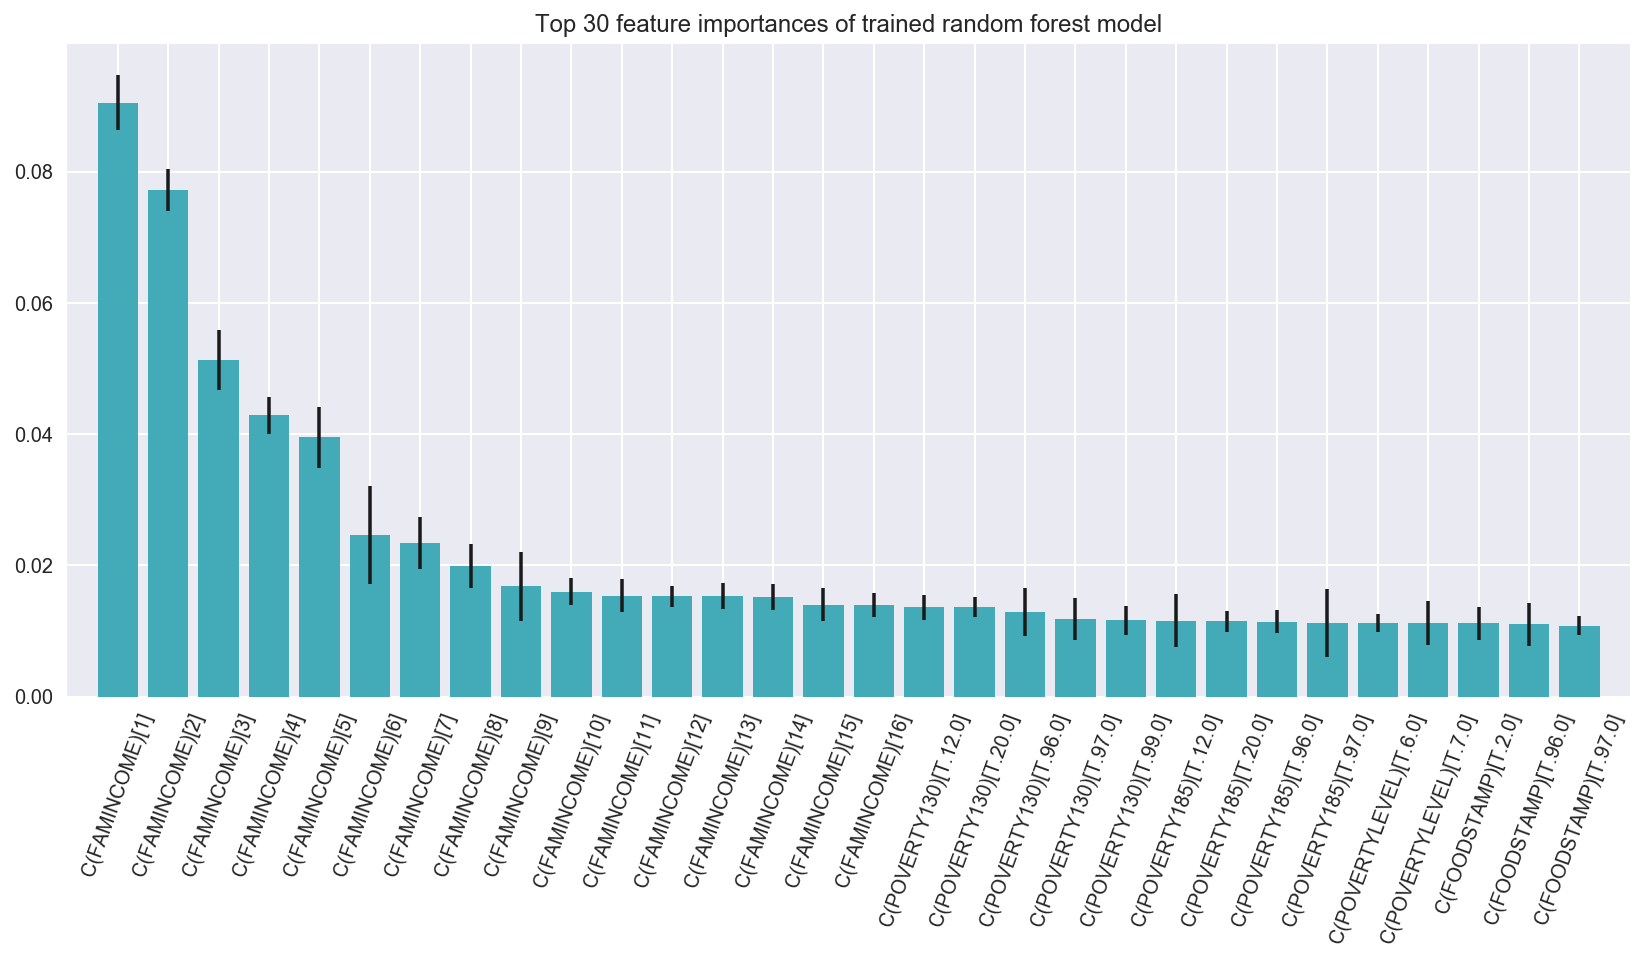

In [40]:
generate_feature_importance_plot(clf_model_all_feats, patsy_dinfo2)

## Conclusions / Discussion


### Hypothesis Testing
* Our null hypothesis is that "exercise and dieting have equal effect on BMI".

* Our hypothesis is that dieting has a greater  impact  on BMI than exercise.  

* Our alternative hypothesis  is that dieting has a lesser  impact on BMI than exercise.     

### Observation and Trends

#### Categorical variables:  

* General health highly correlates with BMI.


* We see that exercise, has a greater impact than dieting and shopping habits.
This is supported by the fact that it has both a lower p-value and higher absolute T-value! 
Exercise : p-value < 0.01, |T-value| = 20
Diet (max): p-value < 0.01, |T-value| = 13


* We can conclude that both dieting and exersing contribute to BMI significantly. 
Our results also show that certain dieting features are more important than others, which can be consulted with the table above.


* We can reject our null hypothesis and infer that our alternative hypothesis as correct:
Dieting has a smaller impact on BMI than exercise.

#### Continuous variables:

* From the plots generated above, we see that more time spent during eating correlate with decrease BMI.
A possible explanation for this observation is that people who eat slower,
tend to also be the healthier eater - or at least, they are not eating fast food.


* We observe age has the most highly and confidently correlation with BMI as compare to other factors.
Frequency of exercise correlate with lower BMI. Away from Obesity to normal.
Exerise frequency of exerise has the strongest pearson corrleation with the lowest p-value(<0.01) besides AGE.


* Again we can reject the null hypothesis, Exerise plays a bigger role than dieting habbits and food shopping features.
We can also accept our alternative hypothesis.

#### Machine Learning Model Feature Importances

* The accuracy of the final classification model which, given all aforementioned features, predicts whether or not someone is obese (BMI > 30) is: 70%


* The first graph of feature importances in the random forest model shows the relative weights that the decision tree assigned
to each of the given features. Most notably, including all features – not just considering diet and exercise-related ones
– reveals that family income is a feature that outperforms the remaining ones.


* It is reasonable to postulate that family income confounds with certain exercise and diet-related features,
as busy lower-class working parents are probably more frequent consumers of fast food because it's cheap and convenient.

   
### Limitations of methods and analysis

In ideal cases, testing our hypothesis would require only a simple two sided t-test between the "dieting sample" and "exercise sample". However, given the format of the survery data, this would not be possible as the sample is not split as such. There are multiple features under dieting which have no conventionally coherent way of being combined into a single metric score or class. Instead, we devised to run several t-test, one on each individual feature and ranked them according. Doing so allows us to circumvent the inherent limitation imposed by the orignal data format without the need do dimension reduction(to reduce the dimensions of diet to the dimensions of exercise). The individual t-tests were  feature-specific sample versus control, which we take to be the general population subtracting the feature specific in order to avoid double counting. The results of each of the t-test were ranked by their p-value and t-value, which allows us to compare the confidence we have and the magnitude of impact of each of feature respectively. 

For the machine learning model, ideally, we would have close to zero missing values per feature. However, this was not the case, so we had a lot of different kinds of missing values which we provided into the decision tree anyway, because removing rows with any missing values would have left us with fewer than 100 training examples, which are insufficient to train a decision tree. The distributions of missing values affect the machine learning model, and this is why we advise caution when interpreting the graph of relative feature weights.

For example: if the DIETSODA feature was given a stronger weight than EXFREQ (exercise frequency), this does not imply that EXFREQ is meaningless. It is the case that many respondents did not report EXFREQ during the survey, whereas less of them did not report DIETSODA; it may very well be the case that EXFREQ has higher feature importances in a different model where EXFREQ and DIETSODA have the same number of survey responses. So: the feature importance graph should NOT be misinterpreted as a statistically significant signal of correlation on a per-feature basis!

It is also important to keep in mind that we trained model to do binary classification, which can be considered more simplistic than a proper regression problem, which – in our testing – we determined to have very low accuracy and a relatively high mean squared error for the machine learning model.


### Potential future work

It would be worthwhile to elucidate confounding factors such as family income and other variables, as revealed in the discussion of the feature importances above. 

It might also be worth exploring if random forest parameters can be hypertuned for even better performance, and whether imputing missing values with the population mean results in better performance.

Finally, it may be interesting to train and optimize a regression model, not just a binary classification model, to predict BMI given a set of personal features. Our preliminal experiments revealed a low $R^2 < 5%$, and it remains to be investigated why the performance is so rather low for regression.